# Vehicle Detection
In this Jupyter Notebook, we will try to detect vehicles from images and videos feeds using computer vision and machine learning tecniques.

The main objectivs of this project will be as follows:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Getting Started
There are many features that we can consider extracting from an image or a video frame. We can first take a look at the images that we have in the training set.

In [214]:
## import needed packages
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.externals import joblib
from skimage.feature import hog
from tqdm import tqdm
from PIL import Image
from collections import deque

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
## import training images
veh_images = glob.glob('./training_images/vehicles/**/*.png')
nonveh_images = glob.glob('./training_images/non-vehicles/**/*.png')

print("Vehicle Images: "+str(len(veh_images)))
print("Non-vehicle Images: "+str(len(nonveh_images)))

Vehicle Images: 8792
Non-vehicle Images: 8968


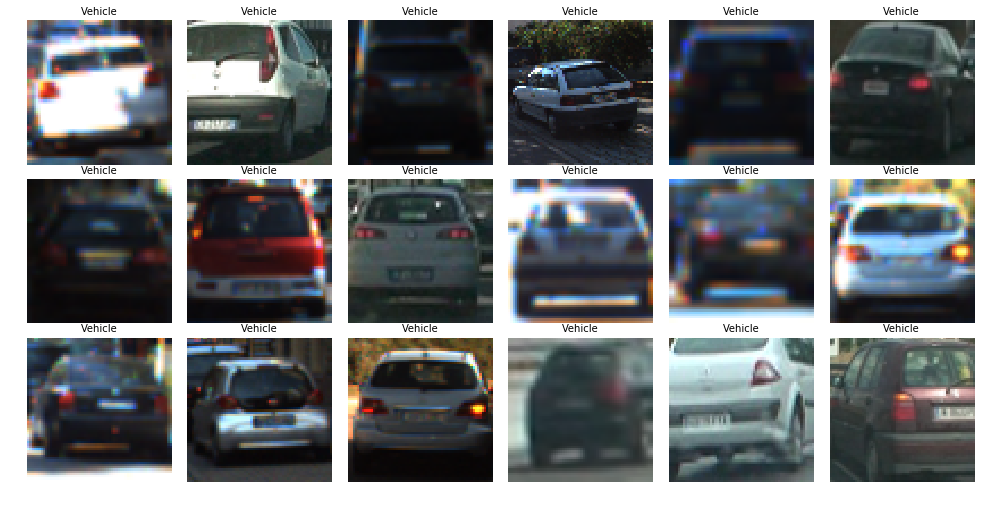

In [3]:
## plot vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicles.png")

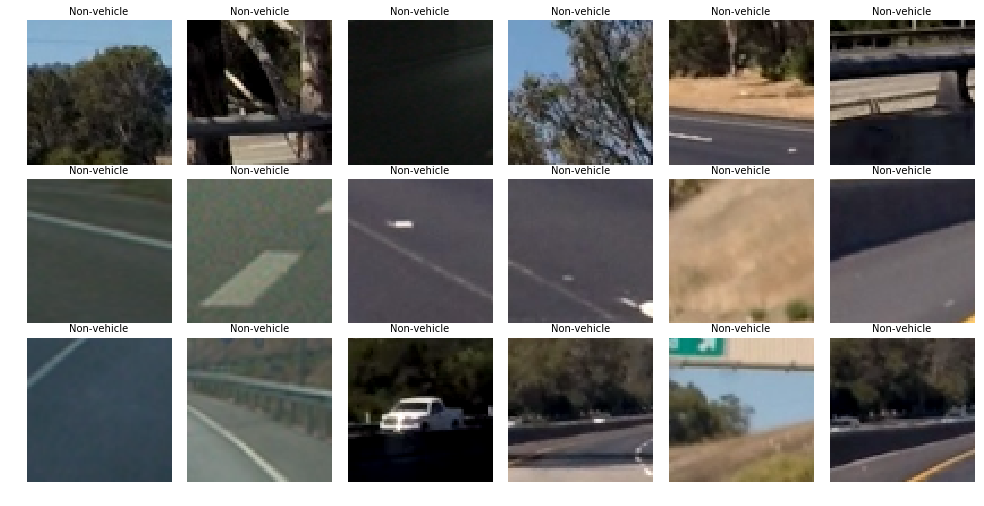

In [4]:
## plot non-vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/non_vehicles.png")

As expected, the images above show cars are various zooms, crops, and angles while the non-vehicle images show scenes do not contain any cars. We can use these images to extract relevant features, which will ultimately be used to train our classifier. 

[(947, 578), (877, 619)]


/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


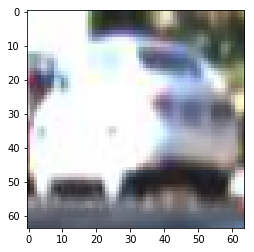

In [17]:
## using additional images from https://github.com/udacity/self-driving-car/tree/master/annotations
labels_df = pd.read_csv("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/crowdai_labels.csv")
car_labels = labels_df[labels_df['Label']=='Car'].reset_index()

car_labels['window'] = car_labels.apply(lambda x: [(x['ymin'],x['xmax']),(x['xmin'], x['ymax'])], axis=1)
car_labels

## test to see new images
img_idx = 62437

## read in image
crowdai_path = "/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/object-detection-crowdai/"
image = cv2.imread(crowdai_path+car_labels.ix[img_idx,'Frame'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

extracted_image = draw_boxes(image, [car_labels.ix[img_idx,'window']])
print(car_labels.ix[img_idx,'window'])

plt.imshow(extracted_image)
blah = cv2.resize(image[car_labels.ix[img_idx,'window'][0][1]:car_labels.ix[img_idx,'window'][1][1], 
                        car_labels.ix[img_idx,'window'][1][0]:car_labels.ix[img_idx,'window'][0][0]], (64, 64))

plt.imshow(blah)


In [122]:
## function to extract car images from crowd ai iamges
def save_additional_cars(car_labels_df, area_thresh=22500, base_path="/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/"):
    
    ## set paths
    crowdai_path = base_path + 'object-detection-crowdai/'
    additional_imgs = base_path + 'additional_vehicles/'

    ## iterate through the list of images
    for i, file in tqdm(enumerate(car_labels_df['Frame'])):

        try:
            ## image features
            img_features = []

            ## read in each one by one
            img = mpimg.imread(crowdai_path+car_labels_df.ix[i,'Frame'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ## resize images
            img = cv2.resize(img[car_labels_df.ix[i,'window'][0][1]:car_labels_df.ix[i,'window'][1][1], 
                                car_labels_df.ix[i,'window'][1][0]:car_labels_df.ix[i,'window'][0][0]], (64, 64))
            
            if np.abs((car_labels_df.ix[i,'window'][0][1]-car_labels_df.ix[i,'window'][1][1]) * 
                      (car_labels_df.ix[i,'window'][1][0]-car_labels_df.ix[i,'window'][0][0])) > area_thresh:
                cv2.imwrite(additional_imgs+file,img)
                
        except:
            continue
            
def color_equalizer(imgs, base_path="/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/"):
    
    ## image paths
    additional_imgs = base_path + 'additional_vehicles_equal/'
    
    ## read in the images in a loop
    for i in tqdm(imgs):
        
        file_name = i.split('/')[-1]
        
        ## reading images
        img = cv2.imread(i, 1)

        ## converting
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        ## split image colors
        l, a, b = cv2.split(lab)

        ## apply clahe
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)

        ## merge color channels together
        limg = cv2.merge((cl,a,b))

        ## convert back to RGB
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        cv2.imwrite(additional_imgs+file_name,final)
        
def convert_to_png(imgs):
    
    ## read in the images in a loop
    for i in tqdm(imgs):
        
        ## read in image
        im = Image.open(i)
        
        ## save as png
        im.save(i[:-4]+'.png', "PNG")

In [ ]:
## save additional images
save_additional_cars(car_labels)

56649it [2:20:08, 19.33s/it] 

In [27]:
## import additional training images to be equalized
add_veh_images = glob.glob('./training_images/additional_vehicles/*.jpg')

## equalize additional images
color_equalizer(add_veh_images)

100%|██████████| 6251/6251 [00:04<00:00, 1352.58it/s]


In [125]:
## import additional training images
add_veh_images = glob.glob('./training_images/additional_vehicles_equal/*.png')

## use once to turn jpg to png
#convert_to_png(add_veh_images)

print("Additional Vehicle Images: "+str(len(add_veh_images)))

Additional Vehicle Images: 6251


## Extracting Features
### Histogram of Gradients
First, we can try to extract the histogram of gradients. The gradients of an image will help to identify the structures within the image. On the otherhand, if we use color, it might be difficult to extract the relavant features because the same model car can be different colors. The gradient is able to capture the edges of the shape of the car. We use a modified version that averages the gradients across multiple cells to account for some possible noise in the image.

In [8]:
## hog extractor function (from exercise) to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


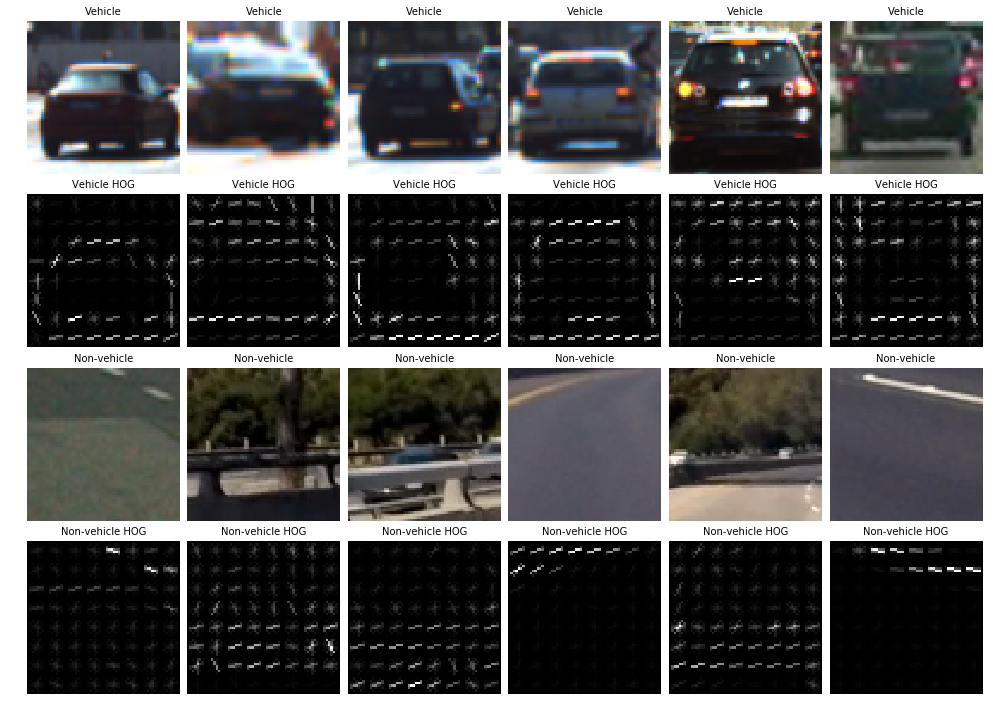

In [9]:
## plot images
f, ax = plt.subplots(4,6, figsize=(14, 10))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()
    
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Step through the list and search for chessboard corners
for i in range(6):
    ## plot img
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')

# Step through the list and search for chessboard corners
for i in range(12,18):
    ## plot img
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Non-vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/hog_examples.png")

Awesome, we can look closely at the HOG visualizations and see that the gradients seem to capture the shape of the vehicles quite well. If we compare the HOG visualizations of the vehicles vs. the non-vehicles, we can see that there is a difference between the different types of images.

Next, we can explore another set of features: color.

### Color Related Features
We can imagine that the color of vehicles will be slightly different when compared to the non-vehicle images. Specifically, in some cases the vehicles are usually more saturated when compared to a pale background. Let's take a closer look and use a function to extract the color histogram of the image.

In [10]:
## function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    ## compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    ## generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    ## concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # return the individual histograms, bin_centers, and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

<Container object of 32 artists>

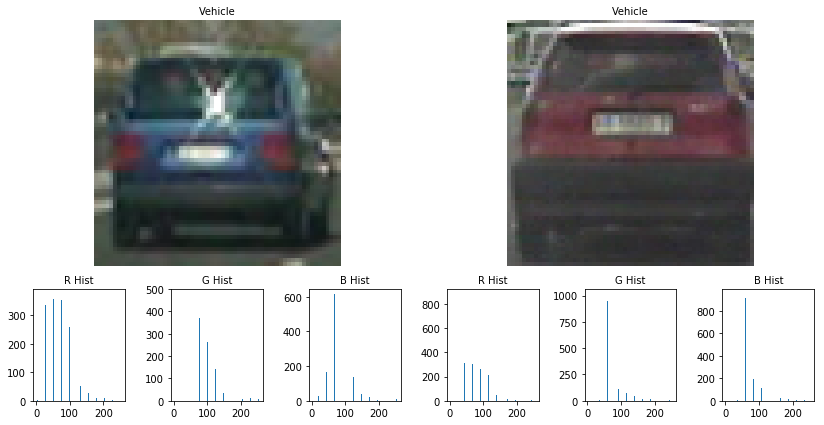

In [11]:
## setup figure
f = plt.figure(figsize=(14, 7))
f.subplots_adjust(hspace = .2, wspace=.5)

## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax1 = plt.subplot2grid((3,6), (0,0), rowspan=2, colspan=3)
ax1.axis('off')
ax1.set_title('Vehicle', fontsize=10)
ax1.imshow(img1)

## R Hist
ax3 = plt.subplot2grid((3,6), (2,0))
ax3.set_title('R Hist', fontsize=10)
ax3.bar(bincen, rh[0])

## G hist
ax4 = plt.subplot2grid((3,6), (2,1))
ax4.set_title('G Hist', fontsize=10)
ax4.bar(bincen, gh[0])

## b hist
ax5 = plt.subplot2grid((3,6), (2,2))
ax5.set_title('B Hist', fontsize=10)
ax5.bar(bincen, bh[0])


## read image 2
img1 = cv2.imread(veh_images[2130])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax2 = plt.subplot2grid((3,6), (0,3), rowspan=2, colspan=3)
ax2.axis('off')
ax2.set_title('Vehicle', fontsize=10)
ax2.imshow(img1)

## R Hist
ax6 = plt.subplot2grid((3,6), (2,3))
ax6.set_title('R Hist', fontsize=10)
ax6.bar(bincen, rh[0])

## G hist
ax7 = plt.subplot2grid((3,6), (2,4))
ax7.set_title('G Hist', fontsize=10)
ax7.bar(bincen, gh[0])

## b hist
ax8 = plt.subplot2grid((3,6), (2,5))
ax8.set_title('B Hist', fontsize=10)
ax8.bar(bincen, bh[0])

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/color_hist.png")

We can also take into account the raw pixel values. However, there might be too many features if we do that so we can reduce the size of the image to return a slightly lower resolution image with the same features.

In [12]:
# function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    ## convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    
    ## use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

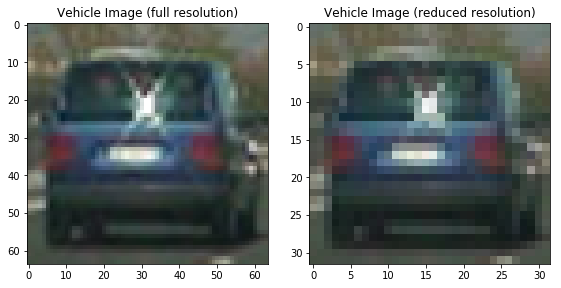

In [13]:
## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

## take a look at the reduced resolution image
feature_vec = bin_spatial(img1, color_space='RGB', size=(32, 32))

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Vehicle Image (full resolution)', fontsize=12)

ax2.imshow(feature_vec.reshape((32,32,3)))
ax2.set_title('Vehicle Image (reduced resolution)', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/spatial_bin.png")

We can see that in the above image the vehicle image on the right has a lower resolution but still captures most of the color information that we see in the original image.

At this point we have quite a few techniques to extract both color and gradient information from the images. We can define a pipeline to extract these features. Note that if and when we combine the color and gradient features we need to normalize and scale the features so that the different scales of the features do not adversely affect the classifier that we will build.

In [232]:
## function to extract features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=False, color_feat=False, hog_feat=True):
    ## create a list to append feature vectors to
    features = []
    
    ## iterate through the list of images
    for file in imgs:
        ## image features
        img_features = []
        
        ## read in each one by one
        img = mpimg.imread(file)
        
        ## apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        
        ## get spatial binning features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        
        ## get color features
        if color_feat:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        
        if hog_feat:
            ## get hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
            
        ## append features to overall feature set
        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

## function to extract features from a single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, color_feat=True, hog_feat=True):    
    
    ## define an empty list to receive features
    img_features = []
    
    ## apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    ## spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    ## color features
    if color_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    ## HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        ## append features to list
        img_features.append(hog_features)

    ## return concatenated array of features
    return np.concatenate(img_features)

## Classifying Images
With the pipeline for feature extraction built, we can build a classifier to see how the feature extraction and model performs. We will have to play with the different parameters to be able to identify the best set of parameters.

In [144]:
## define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

random.seed(999)

t=time.time()
## extract vehicle image features
car_features = extract_features(veh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

add_car_features = extract_features(add_veh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

car_features = car_features + add_car_features

print('Total vehicle images: ', len(car_features))

## extract non vehicle image features
notcar_features = extract_features(nonveh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   color_feat=color_feat, hog_feat=hog_feat)

add_notcar_features = random.sample(notcar_features, 7000)

notcar_features = notcar_features + add_notcar_features

print('Total non-vehicle images: ', len(notcar_features)) 
t2 = time.time()

print(round(t2-t, 2), 'seconds to extract features')

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total vehicle images:  15043
Total non-vehicle images:  15968
63.85 seconds to extract features


In [159]:
## combine observations
X = np.vstack((car_features, notcar_features)).astype(np.float64)

## fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)

## apply the scaler to X
scaled_X = X_scaler.transform(X)

## define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## split up data into randomized training and test sets
rand_state = 22
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Model Training

In [160]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf = RandomForestClassifier()

## check the training time for the RF
t=time.time()
rf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
15.86 seconds to train RF
Test Accuracy of RF =  0.9906
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00306 Seconds to predict 10 labels with RF


We can use grid search to find the best parameters for our random forest model.

In [20]:
## random forest with grid search
## set of parameters to try in grid search for random forest
# param_grid = {"n_estimators":[15,50,100],
#               "min_samples_split": [5,7,9],
#               "min_samples_leaf": [1,3,5],
#               "max_leaf_nodes": [None,3,5],
#               }

# rf = RandomForestClassifier(n_jobs=3)

# ## timer for grid searching
# t = time.time()
# rf = GridSearchCV(rf, param_grid, cv=3)
# rf.fit(X_train, y_train)
# t2 = time.time()
# print("Elapsed time for grid search cv: {}".format(t2-t))

# ## used with grid search
# print(rf.best_score_)
# print(rf.best_params_)

## best params: {'n_estimators': 50, 'max_leaf_nodes': None, 'min_samples_split': 7, 'min_samples_leaf': 1}
## best score: 0.992117117117

In [164]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf_1 = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

## check the training time for the RF
t=time.time()
rf_1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf_1.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf_1.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
63.33 seconds to train RF
Test Accuracy of RF =  0.9939
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00641 Seconds to predict 10 labels with RF


In [165]:
## train the model on all of the data
rf_final = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)
rf_final.fit(scaled_X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

The grid search returned parameters that performed better than the standard model! We can also try to use gradient boosted trees, which are more robust.

In [ ]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
gbc = GradientBoostingClassifier()

## check the training time for the GBC
t=time.time()
gbc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train GBC')

## check the score of the GBC
print('Test Accuracy of GBC = ', round(gbc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', gbc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with GBC')

It seems like the base version of the classifier without any parameter tuning performs better than the random forest; however, because it takes so long to train, it might be better to use the parameter turned random forest or the gradient boosted classifier without parameter tuning.

In [161]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use SVC
svc = LinearSVC(loss='hinge')

## check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC')

## check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', svc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
27.05 seconds to train SVC
Test Accuracy of SVC =  0.9836
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00188 Seconds to predict 10 labels with SVC


## Sliding Window
Now that our classifier can identify if an image or a frame of a video contains a car, we need to find a way to look through the image to search for potential car matches so that we can run it against our classfier. One idea is to use a sliding window approach to scan through the image to identify possible car-like objects, then pass it to our classifier.

In [233]:
## function that creates sliding windows (from lesson)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    ## if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    ## compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    ## compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    ## compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    ## initialize a list to append window positions to
    window_list = []
    
    ## loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            ## calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            ## append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

## function so search through an image
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    color_feat=True, hog_feat=True):

    ## create an empty list to receive positive detection windows
    on_windows = []
    
    ## iterate over all windows in the list
    for window in windows:
        
        ## extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        ## extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            color_feat=color_feat, hog_feat=hog_feat)
        
        ## scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        ## predict using your classifier
        prediction = clf.predict(test_features)
        ## if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    ## return windows for positive detections
    return on_windows

## function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    ## make a copy of the image
    imcopy = np.copy(img)
    
    ## iterate through the bounding boxes
    for bbox in bboxes:
        
        ## draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

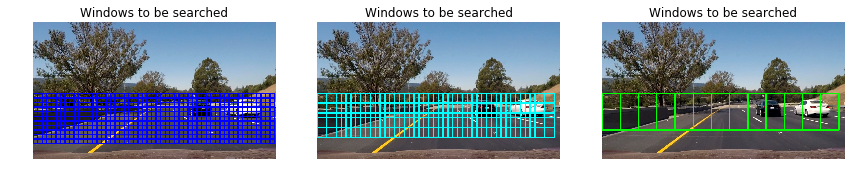

In [138]:
## read in the file paths to the test images
test_imgs = glob.glob('./test_images/*.jpg')

## read in image
image_orig = cv2.imread(test_imgs[5])
image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image = image_orig.astype(np.float32)/255

## create boundary for search
y_start_stop = [375, 640]

## create windows to be searched
window_sizes = [96, 128, 192]
colors = [(0,0,255),(0,255,255),(0,255,0)]
windows_img = np.copy(image)
windows = []

for idx, window_size in enumerate(window_sizes):
    ## find windows at different scales
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
    
    ## adding the new windows
    windows += temp_windows

#     ## draw windows on the original image
#     windows_img = draw_boxes(windows_img, temp_windows, color=colors[idx])

## create windows
windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[0], window_sizes[0]), xy_overlap=(0.75, 0.75))
windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[1], window_sizes[1]), xy_overlap=(0.6, 0.6))
windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[2], window_sizes[2]), xy_overlap=(0.5, 0.5))

## add windows to images
windows_1_img = draw_boxes(image_orig, windows_1, color=colors[0])
windows_2_img = draw_boxes(image_orig, windows_2, color=colors[1])
windows_3_img = draw_boxes(image_orig, windows_3, color=colors[2])

## plot the images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 10))
f.tight_layout()

ax1.imshow(windows_1_img)
ax1.axis('off')
ax1.set_title('Windows to be searched', fontsize=12)

ax2.imshow(windows_2_img)
ax2.axis('off')
ax2.set_title('Windows to be searched', fontsize=12)

ax3.imshow(windows_3_img)
ax3.axis('off')
ax3.set_title('Windows to be searched', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/search_windows_separate.png")

Next we can search the windows specified above for presence of vehicles.

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


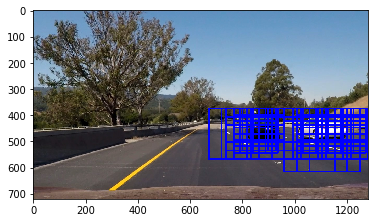

In [234]:
## search windows and classify cars
hot_windows = search_windows(image, windows, rf_final, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        color_feat=color_feat, hog_feat=hog_feat)                       

## draw boxes around possible cars
window_img = draw_boxes(image_orig, hot_windows)                    

plt.imshow(window_img)

# plt.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/located_cars.png")

In [287]:
## function to create heatmap
def add_heat(heatmap, bbox_list):
    
    ## iterate through list of bboxes
    for box in bbox_list:
        
        ## add += 1 for all pixels inside each bbox
        ## assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
## create a mask based on the heatmap
def apply_threshold(heatmap, threshold):
    
    ## zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

## final boxes around cars
def draw_labeled_bboxes(img, labels, ret_bbox=False):
    
    ## iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        ## find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        ## identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ## define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        ## draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    if ret_bbox:
        return img, bbox
    else:
        return img

## define a single function that can extract features
def find_cars(img, y_start_stop, window_sizes, clf, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             hog_channel, spatial_feat, color_feat, hog_feat, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    
    ## convert jpg for test images
    if test_flag:
        img = img_orig.astype(np.float32)/255
    
    ## create empty windows list
    windows = []
    
    ## varying overlap
    overlap = [0.75, 0.6, 0.5]

    for idx, window_size in enumerate(window_sizes):
        ## find windows at different scales
        temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

        ## adding the new windows
        windows += temp_windows
    
    ## search windows and classify cars
    hot_windows = search_windows(img, windows, clf, X_scaler, cspace=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)                       

    ## draw boxes around possible cars
    window_img = draw_boxes(img_orig, hot_windows)
    
    ## create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    ## add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    ## apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,7)

    ## visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    ## find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
    
    if all([windows_flag,heat_flag]):
        return window_img, heat_img
    elif windows_flag:
        return window_img
    elif heat_flag:
        return heat_img
    else:
        return final_img

## function to convert color
def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
## define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_efficient(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                        hist_bins, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    draw_img = np.copy(img)
    
    ## convert jpg for test images
    if test_flag:
        img = draw_img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            ## just keep channel 0
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox = ((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]))

                ## store the bounding box if its a car
                hot_windows.append(bbox)
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)
            
    
    ## create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    ## add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    ## apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,3)

    ## visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    ## find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
         
    if all([windows_flag,heat_flag]):
        return draw_img, heat_img
    elif windows_flag:
        return draw_img
    elif heat_flag:
        return heat_img
    elif final_img is not None:
        return final_img
    else:
        return img

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


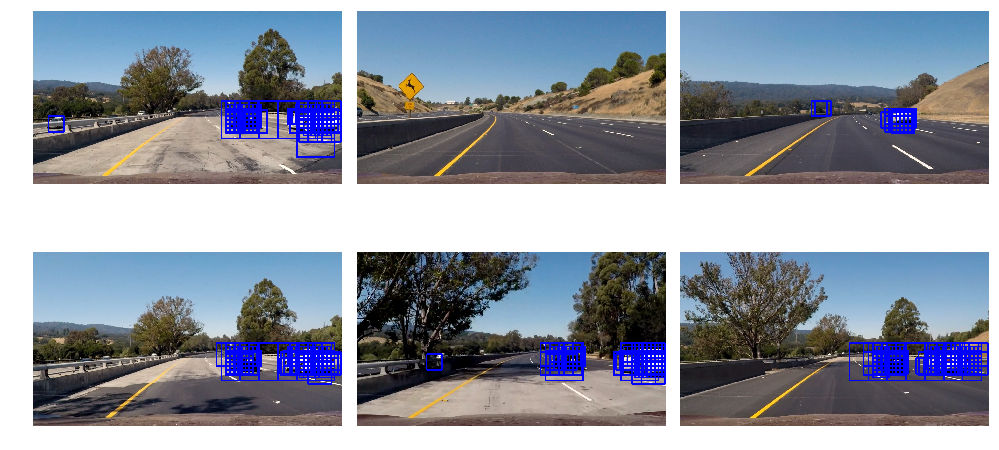

In [236]:
## set parameters
y_start_stop = [375, 640]
window_sizes = [64, 96, 156]
clf = rf_final
X_scaler = X_scaler

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

test_flag = True
windows_flag = True
heat_flag = False

## plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    ## read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    ## run the pipeline
    output_img = find_cars(img1_orig, y_start_stop, window_sizes, rf_final, X_scaler, color_space, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel, spatial_feat, color_feat, hog_feat, 
                           test_flag, windows_flag, heat_flag)
    
    ## plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicle_final.png")

While the above function does a good job of finding cars, it is quite inefficient and slow. Namely, because we are scanning and running our HOG function (among others), it is a bit redundant. We can actually combine the different steps together to make things work faster.

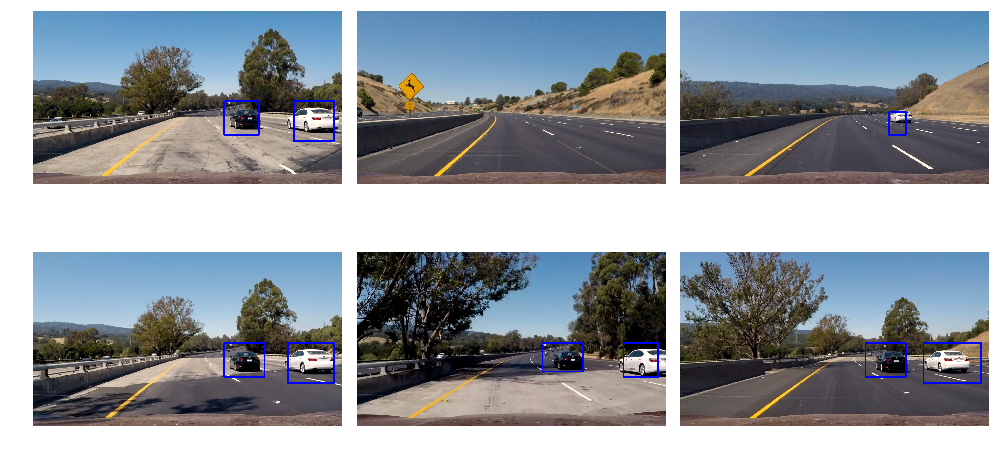

In [288]:
## set parameters
y_start_stop = [375, 640]
scale = 1.5
clf = rf_final
X_scaler = X_scaler
orient = 8
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
test_flag = True
windows_flag = False
heat_flag = False

## plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    ## read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    ## run the pipeline
    output_img = find_cars_efficient(img1_orig, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, test_flag, windows_flag, heat_flag)
    
    ## plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicle_final_efficient.png")

The pipeline seems to find the cars fairly well on the test images. However, we see that there is still a little bit of noise in some of the images. We can try to solve this problem by using a heatmap to count the number of times the pixels are contained within the "hot" bounding boxes.

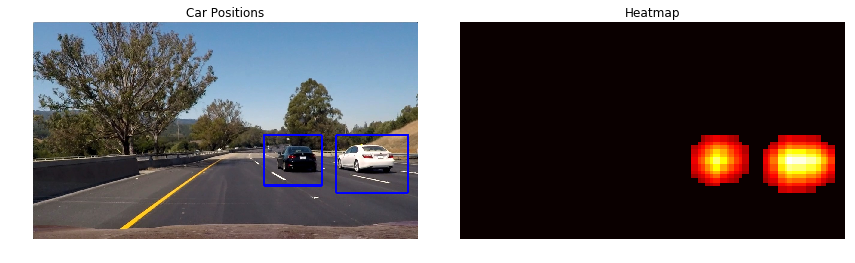

In [206]:
## create empty heatmap
heat_mask = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat_mask = add_heat(heat_mask,hot_windows)
    
# Apply threshold to help remove false positives
heat_mask = apply_threshold(heat_mask,7)

# Visualize the heatmap when displaying    
heatmap_img = np.clip(heat_mask, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap_img)
draw_img = draw_labeled_bboxes(np.copy(image_orig), labels)

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
f.tight_layout()

ax1.imshow(draw_img)
ax1.axis('off')
ax1.set_title('Car Positions', fontsize=12)

ax2.imshow(heatmap_img, cmap='hot')
ax2.axis('off')
ax2.set_title('Heatmap', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/heatmap.png")

The heatmap strategy works fairly well to control for the noise in our images. We can apply the pipeline to videos now!

## Video Processing

In [254]:
## parameter dictionary
param_dict = {"y_start_stop":[375, 640],
              "window_sizes":[64, 96, 156],
              
              "clf":rf_final,
              "X_scaler":X_scaler,
              "color_space":'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              "orient":8,
              "pix_per_cell":8,
              "cell_per_block":2,
              "hog_channel":0, # Can be 0, 1, 2, or "ALL"
              "spatial_size":(16, 16),
              "hist_bins":32,
              "hist_range":(0,256),
              "spatial_feat":True,
              "color_feat":True,
              "hog_feat":True,
              "test_flag":False,
              "windows_flag":False,
              "heat_flag":False}

## defining a class to keep track of the previous bounding boxes
class Vehicle_Detector:
    
    ## initial list of variables to be passed in
    y_start_stop = None
    window_sizes = None
    clf = None
    X_scaler = None
    color_space = None
    orient = None
    pix_per_cell = None
    cell_per_block = None
    spatial_size = None
    hist_bins = None
    hog_channel = None
    spatial_feat = None
    color_feat = None
    hog_feat = None
    test_flag = None
    windows_flag = None
    heat_flag = None
    
    ## initialize variables
    def __init__(self, aDict, frames_to_keep=10):
        self.hotbox_hist = deque(maxlen=frames_to_keep)
        self.__dict__.update(aDict)
        
    
    ## defining the pipeline
    def pipeline(self, img):
    
        img_orig = np.copy(img)

        ## convert jpg for test images
        if self.test_flag:
            img = img_orig.astype(np.float32)/255

        ## create empty windows list
        windows = []

        ## varying overlap
        overlap = [0.75, 0.6, 0.5]

        for idx, window_size in enumerate(self.window_sizes):
            ## find windows at different scales
            temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=self.y_start_stop, 
                                   xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

            ## adding the new windows
            windows += temp_windows

        ## search windows and classify cars
        hot_windows = search_windows(img, windows, self.clf, self.X_scaler, cspace=self.color_space, 
                                    spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                    orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                    cell_per_block=self.cell_per_block, 
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                                    color_feat=self.color_feat, hog_feat=self.hog_feat)                       

        ## draw boxes around possible cars
        window_img = draw_boxes(img_orig, hot_windows)

        
        ## current image ##
        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, hot_windows)

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,7)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        _, bbox = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=True)
        
        ## store the box with previous history
        self.hotbox_hist.append(bbox)
        
        
        ## averaging previous boxes ##
        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, self.hotbox_hist)

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,5)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)
        
        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        final_img = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=False)

        if final_img is not None:
            if all([self.windows_flag, self.heat_flag]):
                return window_img, heat_img
            elif self.windows_flag:
                return window_img
            elif self.heat_flag:
                return heat_img
            else:
                return final_img
        else:
            return img

In [255]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [256]:
## initialize detector
veh_detector = Vehicle_Detector(param_dict)

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(veh_detector.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

None
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:06<2:06:02,  6.00s/it]

None


  0%|          | 2/1261 [00:11<2:05:54,  6.00s/it]

None


  0%|          | 3/1261 [00:17<2:05:28,  5.98s/it]

None


  0%|          | 4/1261 [00:23<2:05:07,  5.97s/it]

None


  0%|          | 5/1261 [00:29<2:05:27,  5.99s/it]

[[[107 147 190]
  [107 147 190]
  [104 144 187]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[107 147 190]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 95  74  70]
  [106  85  81]
  [107  86  82]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 90  69  65]
  [ 96  75  71]
  [ 98  77  73]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 78  57  53]
  [ 81  60  56]
  [ 82  61  57]]]


  0%|          | 6/1261 [00:36<2:06:47,  6.06s/it]

[[[107 147 190]
  [107 147 190]
  [104 144 187]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[107 147 190]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[103  81  73]
  [102  80  72]
  [106  84  76]
  ..., 
  [ 91  70  66]
  [103  82  78]
  [107  86  82]]

 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 85  64  60]
  [ 90  69  65]
  [ 94  73  69]]

 [[106  84  76]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 78  57  53]
  [ 80  59  55]
  [ 82  61  57]]]


  1%|          | 7/1261 [00:42<2:07:13,  6.09s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[102  80  72]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 88  67  63]
  [ 99  78  74]
  [103  82  78]]

 [[103  81  73]
  [106  84  76]
  [100  78  70]
  ..., 
  [ 82  61  57]
  [ 83  62  58]
  [ 87  66  62]]

 [[103  81  73]
  [107  85  77]
  [102  80  72]
  ..., 
  [ 78  57  53]
  [ 78  57  53]
  [ 80  59  55]]]


  1%|          | 8/1261 [00:48<2:07:43,  6.12s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[103  81  73]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 89  68  64]
  [103  82  78]
  [107  86  82]]

 [[100  78  70]
  [103  81  73]
  [102  80  72]
  ..., 
  [ 84  63  59]
  [ 94  73  69]
  [ 97  76  72]]

 [[100  78  70]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 78  57  53]
  [ 78  57  53]
  [ 82  61  57]]]


  1%|          | 9/1261 [00:54<2:07:19,  6.10s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 92  71  67]
  [105  84  80]
  [107  86  82]]

 [[100  78  70]
  [103  81  73]
  [ 99  77  69]
  ..., 
  [ 87  66  62]
  [ 95  74  70]
  [ 97  76  72]]

 [[100  78  70]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 78  57  53]
  [ 80  59  55]
  [ 82  61  57]]]


  1%|          | 10/1261 [01:01<2:14:06,  6.43s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 92  71  67]
  [105  84  80]
  [107  86  82]]

 [[100  78  70]
  [103  81  73]
  [ 99  77  69]
  ..., 
  [ 87  66  62]
  [ 95  74  70]
  [ 97  76  72]]

 [[100  78  70]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 78  57  53]
  [ 80  59  55]
  [ 82  61  57]]]


  1%|          | 11/1261 [01:09<2:23:38,  6.89s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 95  74  70]
  [102  81  77]
  [105  84  80]]

 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 88  67  63]
  [ 99  78  74]
  [103  82  78]]

 [[102  80  72]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 81  60  56]
  [ 87  66  62]
  [ 91  70  66]]]


  1%|          | 12/1261 [01:17<2:28:35,  7.14s/it]

[[[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[105 145 188]
  [105 145 188]
  [103 143 186]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 85  64  60]
  [ 97  76  72]
  [102  81  77]]

 [[103  81  73]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 80  59  55]
  [ 84  63  59]
  [ 89  68  64]]

 [[ 99  77  69]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 81  60  56]
  [ 78  57  53]
  [ 75  54  50]]]


  1%|          | 13/1261 [01:24<2:25:39,  7.00s/it]

[[[103 143 186]
  [103 143 186]
  [102 142 185]
  ..., 
  [ 78 123 175]
  [ 78 123 175]
  [ 78 123 175]]

 [[103 143 186]
  [104 144 187]
  [102 142 185]
  ..., 
  [ 78 123 175]
  [ 78 123 175]
  [ 78 123 175]]

 [[104 144 187]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 78 123 175]
  [ 78 123 175]
  [ 78 123 175]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 87  66  62]
  [ 98  77  73]
  [103  82  78]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 81  60  56]
  [ 88  67  63]
  [ 94  73  69]]

 [[103  81  73]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 81  60  56]
  [ 80  59  55]
  [ 78  57  53]]]


  1%|          | 14/1261 [01:30<2:21:30,  6.81s/it]

[[[103 143 186]
  [103 143 186]
  [102 142 185]
  ..., 
  [ 70 122 169]
  [ 59 125 169]
  [ 59 125 169]]

 [[103 143 186]
  [104 144 187]
  [102 142 185]
  ..., 
  [ 70 122 169]
  [ 59 125 169]
  [ 59 125 169]]

 [[104 144 187]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 70 122 169]
  [ 59 125 169]
  [ 59 125 169]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 90  69  65]
  [104  83  79]
  [109  88  84]]

 [[104  82  74]
  [104  82  74]
  [104  82  74]
  ..., 
  [ 83  62  58]
  [ 91  70  66]
  [ 97  76  72]]

 [[105  83  75]
  [106  84  76]
  [104  82  74]
  ..., 
  [ 78  57  53]
  [ 75  54  50]
  [ 73  52  48]]]


  1%|          | 15/1261 [01:36<2:15:39,  6.53s/it]

[[[104 144 187]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 69 123 173]
  [ 67 124 173]
  [ 67 124 173]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 69 123 173]
  [ 67 124 173]
  [ 67 124 173]]

 [[107 147 190]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 69 123 173]
  [ 67 124 173]
  [ 67 124 173]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 88  67  63]
  [101  80  76]
  [109  88  84]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 81  60  56]
  [ 90  69  65]
  [ 96  75  71]]

 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 77  56  52]
  [ 77  56  52]
  [ 73  52  48]]]


  1%|▏         | 16/1261 [01:42<2:11:33,  6.34s/it]

[[[107 147 190]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[107 147 190]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[108 148 191]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 91  70  66]
  [ 98  77  73]
  [104  83  79]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 85  64  60]
  [ 98  77  73]
  [106  85  81]]

 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 82  61  57]
  [ 89  68  64]
  [ 92  71  67]]]


  1%|▏         | 17/1261 [01:48<2:08:25,  6.19s/it]

[[[107 147 190]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[107 147 190]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[107 147 190]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [ 90  69  65]
  [ 97  76  72]
  [101  80  76]]

 [[102  80  72]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 91  70  66]
  [104  83  79]
  [110  89  85]]

 [[106  84  76]
  [105  83  75]
  [102  80  72]
  ..., 
  [ 85  64  60]
  [ 91  70  66]
  [ 94  73  69]]]


  1%|▏         | 18/1261 [01:53<2:06:23,  6.10s/it]

[[[104 144 187]
  [103 143 186]
  [102 142 185]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 65 122 166]]

 [[104 144 187]
  [103 143 186]
  [102 142 185]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 65 122 166]]

 [[104 144 187]
  [103 143 186]
  [102 142 185]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 66 123 167]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 94  73  69]
  [ 97  76  72]
  [ 97  76  72]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 90  69  65]
  [102  81  77]
  [107  86  82]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 89  68  64]
  [ 98  77  73]
  [103  82  78]]]


  2%|▏         | 19/1261 [01:59<2:04:42,  6.02s/it]

[[[105 145 188]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 65 122 166]]

 [[105 145 188]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 65 122 166]]

 [[105 145 188]
  [104 144 187]
  [103 143 186]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 66 123 167]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 88  67  63]
  [ 99  78  74]
  [106  85  81]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 87  66  62]
  [ 96  75  71]
  [103  82  78]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 82  61  57]
  [ 91  70  66]
  [ 96  75  71]]]


  2%|▏         | 20/1261 [02:05<2:03:38,  5.98s/it]

[[[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[102  80  72]
  [104  82  74]
  [107  85  77]
  ..., 
  [ 91  70  66]
  [103  82  78]
  [110  89  85]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 85  64  60]
  [ 95  74  70]
  [101  80  76]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 77  56  52]
  [ 87  66  62]
  [ 91  70  66]]]


  2%|▏         | 21/1261 [02:11<2:02:45,  5.94s/it]

[[[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[102  80  74]
  [104  82  76]
  [108  86  80]
  ..., 
  [ 94  73  69]
  [104  83  79]
  [109  88  84]]

 [[103  81  75]
  [104  82  76]
  [105  83  77]
  ..., 
  [ 82  61  57]
  [ 91  70  66]
  [ 95  74  70]]

 [[104  82  76]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 78  57  53]
  [ 87  66  62]
  [ 90  69  65]]]


  2%|▏         | 22/1261 [02:17<2:01:46,  5.90s/it]

[[[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[ 99  79  72]
  [102  82  75]
  [106  86  79]
  ..., 
  [ 85  66  62]
  [ 95  76  72]
  [ 99  80  76]]

 [[103  83  76]
  [104  84  77]
  [105  85  78]
  ..., 
  [ 76  57  53]
  [ 85  66  62]
  [ 87  68  64]]

 [[105  85  78]
  [104  84  77]
  [103  83  76]
  ..., 
  [ 79  60  56]
  [ 85  66  62]
  [ 86  67  63]]]


  2%|▏         | 23/1261 [02:23<2:01:38,  5.90s/it]

[[[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[105 145 186]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 83  64  60]
  [ 96  77  73]
  [101  82  78]]

 [[109  89  80]
  [107  87  78]
  [105  85  76]
  ..., 
  [ 81  62  58]
  [ 87  68  64]
  [ 89  70  66]]

 [[106  86  77]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 81  62  58]
  [ 86  67  63]
  [ 82  63  59]]]


  2%|▏         | 24/1261 [02:29<2:01:48,  5.91s/it]

[[[105 145 188]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[105 145 188]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[105 145 188]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[ 99  79  70]
  [103  83  74]
  [105  85  76]
  ..., 
  [ 83  64  60]
  [ 96  77  73]
  [102  83  79]]

 [[109  89  80]
  [107  87  78]
  [104  84  75]
  ..., 
  [ 82  63  59]
  [ 89  70  66]
  [ 93  74  70]]

 [[111  91  82]
  [109  89  80]
  [104  84  75]
  ..., 
  [ 81  62  58]
  [ 86  67  63]
  [ 83  64  60]]]


  2%|▏         | 25/1261 [02:35<2:01:57,  5.92s/it]

[[[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[ 97  77  68]
  [101  81  72]
  [105  85  76]
  ..., 
  [ 87  68  64]
  [ 99  80  76]
  [105  86  82]]

 [[103  83  74]
  [103  83  74]
  [103  83  74]
  ..., 
  [ 86  67  63]
  [ 97  78  74]
  [103  84  80]]

 [[107  87  78]
  [104  84  75]
  [102  82  73]
  ..., 
  [ 85  66  62]
  [ 90  71  67]
  [ 93  74  70]]]


  2%|▏         | 26/1261 [02:41<2:03:14,  5.99s/it]

[[[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[102  82  75]
  [103  83  76]
  [105  85  78]
  ..., 
  [ 85  66  62]
  [ 96  77  73]
  [108  89  85]]

 [[106  86  79]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 82  63  59]
  [ 92  73  69]
  [ 95  76  72]]

 [[107  87  80]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 80  61  57]
  [ 86  67  63]
  [ 88  69  65]]]


  2%|▏         | 27/1261 [02:47<2:06:47,  6.17s/it]

[[[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[ 99  79  72]
  [102  82  75]
  [103  83  76]
  ..., 
  [ 85  66  62]
  [ 96  77  73]
  [105  86  82]]

 [[105  85  78]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 78  59  55]
  [ 86  67  63]
  [ 88  69  65]]

 [[107  87  80]
  [104  84  77]
  [101  81  74]
  ..., 
  [ 79  60  56]
  [ 85  66  62]
  [ 87  68  64]]]


  2%|▏         | 28/1261 [02:54<2:10:24,  6.35s/it]

[[[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[108 149 192]
  [107 148 191]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[ 97  77  70]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [ 79  60  56]
  [ 89  70  66]
  [ 93  74  70]]

 [[103  83  76]
  [102  82  75]
  [101  81  74]
  ..., 
  [ 75  56  52]
  [ 81  62  58]
  [ 83  64  60]]

 [[105  85  78]
  [102  82  75]
  [ 99  79  72]
  ..., 
  [ 79  60  56]
  [ 83  64  60]
  [ 86  67  63]]]


  2%|▏         | 29/1261 [03:01<2:10:48,  6.37s/it]

[[[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[ 97  76  72]
  [ 99  78  74]
  [103  82  78]
  ..., 
  [ 80  61  57]
  [ 90  71  67]
  [ 96  77  73]]

 [[102  81  77]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 73  54  50]
  [ 80  61  57]
  [ 83  64  60]]

 [[105  84  80]
  [102  81  77]
  [ 99  78  74]
  ..., 
  [ 78  59  55]
  [ 81  62  58]
  [ 85  66  62]]]


  2%|▏         | 30/1261 [03:07<2:08:12,  6.25s/it]

[[[107 148 191]
  [107 148 191]
  [106 147 190]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 [[107 148 191]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 [[106 147 190]
  [106 147 190]
  [104 145 188]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 ..., 
 [[ 98  77  73]
  [ 99  78  74]
  [102  81  77]
  ..., 
  [ 88  69  65]
  [ 97  78  74]
  [103  84  80]]

 [[103  82  78]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 75  56  52]
  [ 86  67  63]
  [ 89  70  66]]

 [[105  84  80]
  [103  82  78]
  [ 99  78  74]
  ..., 
  [ 72  53  49]
  [ 80  61  57]
  [ 87  68  64]]]


  2%|▏         | 31/1261 [03:13<2:07:14,  6.21s/it]

[[[100 140 183]
  [108 148 191]
  [109 149 192]
  ..., 
  [ 70 120 171]
  [ 69 121 171]
  [ 69 121 171]]

 [[101 141 184]
  [107 147 190]
  [109 149 192]
  ..., 
  [ 71 121 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[103 143 186]
  [104 144 187]
  [107 147 190]
  ..., 
  [ 71 121 172]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 85  64  62]
  [ 97  76  74]
  [105  84  82]]

 [[101  80  76]
  [101  80  76]
  [102  81  77]
  ..., 
  [ 75  54  52]
  [ 78  57  55]
  [ 88  67  65]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 75  54  52]
  [ 73  52  50]
  [ 80  59  57]]]


  3%|▎         | 32/1261 [03:20<2:17:01,  6.69s/it]

[[[100 140 183]
  [108 148 191]
  [109 149 192]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[101 141 184]
  [107 147 190]
  [109 149 192]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[103 143 186]
  [104 144 187]
  [107 147 190]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[104  83  79]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 91  70  68]
  [104  83  81]
  [109  88  86]]

 [[102  81  77]
  [102  81  77]
  [103  82  78]
  ..., 
  [ 88  67  65]
  [101  80  78]
  [107  86  84]]

 [[ 99  78  74]
  [ 99  78  74]
  [101  80  76]
  ..., 
  [ 77  56  54]
  [ 83  62  60]
  [ 92  71  69]]]


  3%|▎         | 33/1261 [03:27<2:18:34,  6.77s/it]

[[[100 140 183]
  [108 148 191]
  [109 149 192]
  ..., 
  [ 71 121 172]
  [ 71 121 172]
  [ 71 121 172]]

 [[101 141 184]
  [107 147 190]
  [109 149 192]
  ..., 
  [ 71 121 172]
  [ 71 121 172]
  [ 71 121 172]]

 [[103 143 186]
  [104 144 187]
  [107 147 190]
  ..., 
  [ 71 121 172]
  [ 71 121 172]
  [ 71 121 172]]

 ..., 
 [[ 99  78  74]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 92  71  69]
  [105  84  82]
  [111  90  88]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 98  77  73]
  ..., 
  [ 76  55  53]
  [ 85  64  62]
  [ 95  74  72]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 98  77  73]
  ..., 
  [ 77  56  54]
  [ 85  64  62]
  [ 96  75  73]]]


  3%|▎         | 34/1261 [03:33<2:13:01,  6.51s/it]

[[[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 91  70  68]
  [102  81  79]
  [111  90  88]]

 [[ 98  77  73]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 76  55  53]
  [ 83  62  60]
  [ 94  73  71]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 98  77  73]
  ..., 
  [ 71  50  48]
  [ 78  57  55]
  [ 89  68  66]]]


  3%|▎         | 35/1261 [03:39<2:09:44,  6.35s/it]

[[[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 73 121 169]
  [ 73 121 169]
  [ 73 121 169]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 73 121 169]
  [ 73 121 169]
  [ 73 121 169]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 73 121 169]
  [ 73 121 169]
  [ 73 121 169]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 85  65  58]
  [ 90  70  63]
  [ 99  79  72]]

 [[ 98  77  73]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 70  50  43]
  [ 77  57  50]
  [ 88  68  61]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 98  77  73]
  ..., 
  [ 67  47  40]
  [ 74  54  47]
  [ 83  63  56]]]


  3%|▎         | 36/1261 [03:46<2:11:04,  6.42s/it]

[[[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[102  81  77]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 83  63  56]
  [ 89  69  62]
  [ 98  78  71]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 71  51  44]
  [ 73  53  46]
  [ 81  61  54]]

 [[ 98  77  73]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 69  49  42]
  [ 76  56  49]
  [ 84  64  57]]]


  3%|▎         | 37/1261 [03:52<2:09:49,  6.36s/it]

[[[107 144 188]
  [107 144 188]
  [106 143 187]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[107 144 188]
  [107 144 188]
  [106 143 187]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[107 144 188]
  [107 144 188]
  [106 143 187]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 81  61  54]
  [ 92  72  65]
  [104  84  77]]

 [[ 98  77  73]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 74  54  47]
  [ 76  56  49]
  [ 84  64  57]]

 [[ 98  77  73]
  [ 99  78  74]
  [ 99  78  74]
  ..., 
  [ 73  53  46]
  [ 76  56  49]
  [ 82  62  55]]]


  3%|▎         | 38/1261 [03:58<2:08:51,  6.32s/it]

[[[109 146 190]
  [109 146 190]
  [107 144 188]
  ..., 
  [ 70 120 171]
  [ 68 118 169]
  [ 68 118 169]]

 [[109 146 190]
  [109 146 190]
  [107 144 188]
  ..., 
  [ 70 120 171]
  [ 70 120 171]
  [ 70 120 171]]

 [[109 146 190]
  [109 146 190]
  [107 144 188]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 78  57  55]
  [ 87  66  64]
  [ 98  77  75]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 75  54  52]
  [ 76  55  53]
  [ 84  63  61]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 75  54  52]
  [ 78  57  55]
  [ 84  63  61]]]


  3%|▎         | 39/1261 [04:05<2:11:04,  6.44s/it]

[[[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 89  68  66]
  [101  80  78]
  [105  84  82]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 81  60  58]
  [ 91  70  68]
  [ 97  76  74]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 74  53  51]
  [ 78  57  55]
  [ 83  62  60]]]


  3%|▎         | 40/1261 [04:12<2:16:10,  6.69s/it]

[[[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[104 145 188]
  [104 145 188]
  [104 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 96  75  73]
  [104  83  81]
  [107  86  84]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 87  66  64]
  [ 96  75  73]
  [101  80  78]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 71  50  48]
  [ 80  59  57]
  [ 85  64  62]]]


  3%|▎         | 41/1261 [04:19<2:16:35,  6.72s/it]

[[[106 143 187]
  [105 142 186]
  [105 142 186]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[106 143 187]
  [106 143 187]
  [106 143 187]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 97  76  74]
  [106  85  83]
  [112  91  89]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 89  68  66]
  [ 98  77  75]
  [105  84  82]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 74  53  51]
  [ 80  59  57]
  [ 87  66  64]]]


  3%|▎         | 42/1261 [04:26<2:19:02,  6.84s/it]

[[[106 143 187]
  [105 142 186]
  [105 142 186]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 [[106 143 187]
  [106 143 187]
  [106 143 187]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 [[107 144 188]
  [107 144 188]
  [107 144 188]
  ..., 
  [ 76 121 173]
  [ 76 121 173]
  [ 76 121 173]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 91  70  68]
  [102  81  79]
  [109  88  86]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 84  63  61]
  [ 91  70  68]
  [ 98  77  75]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 76  55  53]
  [ 81  60  58]
  [ 88  67  65]]]


  3%|▎         | 43/1261 [04:32<2:14:55,  6.65s/it]

[[[104 144 187]
  [103 143 186]
  [103 143 186]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 88  67  65]
  [ 97  76  74]
  [104  83  81]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 81  60  58]
  [ 84  63  61]
  [ 91  70  68]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 77  56  54]
  [ 83  62  60]
  [ 90  69  67]]]


  3%|▎         | 44/1261 [04:40<2:17:59,  6.80s/it]

[[[104 144 187]
  [103 143 186]
  [103 143 186]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [101  80  76]
  ..., 
  [ 83  62  60]
  [ 94  73  71]
  [102  81  79]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 76  55  53]
  [ 80  59  57]
  [ 85  64  62]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 76  55  53]
  [ 80  59  57]
  [ 88  67  65]]]


  4%|▎         | 45/1261 [04:45<2:12:23,  6.53s/it]

[[[104 144 187]
  [104 144 187]
  [105 145 188]
  ..., 
  [ 70 120 168]
  [ 70 120 168]
  [ 70 120 168]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 71 121 169]
  [ 71 121 169]
  [ 71 121 169]]

 [[108 148 191]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[104  83  79]
  [103  82  78]
  [101  80  76]
  ..., 
  [ 82  61  59]
  [ 92  71  69]
  [ 99  78  76]]

 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 71  50  48]
  [ 70  49  47]
  [ 78  57  55]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 78  57  55]
  [ 76  55  53]
  [ 89  68  66]]]


  4%|▎         | 46/1261 [04:53<2:17:15,  6.78s/it]

[[[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 70 120 168]
  [ 70 120 168]
  [ 70 120 168]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 71 121 169]
  [ 71 121 169]
  [ 71 121 169]]

 [[105 145 188]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [101  80  76]
  ..., 
  [ 87  66  64]
  [101  80  78]
  [105  84  82]]

 [[101  80  76]
  [101  80  76]
  [101  80  76]
  ..., 
  [ 77  56  54]
  [ 82  61  59]
  [ 88  67  65]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 73  52  50]
  [ 74  53  51]
  [ 82  61  59]]]


  4%|▎         | 47/1261 [05:00<2:21:38,  7.00s/it]

[[[105 145 188]
  [105 145 188]
  [104 144 187]
  ..., 
  [ 65 122 171]
  [ 67 124 173]
  [ 69 126 175]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 65 122 171]
  [ 67 124 173]
  [ 69 126 175]]

 [[105 145 188]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 65 122 171]
  [ 67 124 173]
  [ 68 125 174]]

 ..., 
 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 85  64  62]
  [101  80  78]
  [107  86  84]]

 [[101  80  76]
  [101  80  76]
  [101  80  76]
  ..., 
  [ 73  52  50]
  [ 78  57  55]
  [ 88  67  65]]

 [[101  80  76]
  [101  80  76]
  [ 99  78  74]
  ..., 
  [ 73  52  50]
  [ 75  54  52]
  [ 84  63  61]]]


  4%|▍         | 48/1261 [05:07<2:18:52,  6.87s/it]

[[[105 145 188]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[105 145 188]
  [104 144 187]
  [105 145 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[106 147 188]
  [106 147 188]
  [104 145 186]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[104  83  79]
  [104  83  79]
  [102  81  77]
  ..., 
  [ 81  60  58]
  [ 97  76  74]
  [107  86  84]]

 [[102  81  77]
  [102  81  77]
  [102  81  77]
  ..., 
  [ 73  52  50]
  [ 77  56  54]
  [ 85  64  62]]

 [[103  82  78]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 77  56  54]
  [ 75  54  52]
  [ 80  59  57]]]


  4%|▍         | 49/1261 [05:13<2:16:22,  6.75s/it]

[[[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 76 121 173]
  [ 76 121 173]
  [ 76 121 173]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 76 121 173]
  [ 76 121 173]
  [ 76 121 173]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[105  82  79]
  [105  82  79]
  [103  80  77]
  ..., 
  [ 78  57  55]
  [ 87  66  64]
  [ 96  75  73]]

 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [ 76  55  53]
  [ 75  54  52]
  [ 80  59  57]]

 [[104  81  78]
  [104  81  78]
  [104  81  78]
  ..., 
  [ 82  61  59]
  [ 78  57  55]
  [ 83  62  60]]]


  4%|▍         | 50/1261 [05:20<2:14:46,  6.68s/it]

[[[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 80 120 173]
  [ 80 120 173]
  [ 80 120 173]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 80 120 173]
  [ 80 120 173]
  [ 80 120 173]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 ..., 
 [[105  82  79]
  [105  82  79]
  [103  80  77]
  ..., 
  [ 75  54  52]
  [ 78  57  55]
  [ 85  64  62]]

 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [ 71  50  48]
  [ 68  47  45]
  [ 71  50  48]]

 [[104  81  78]
  [104  81  78]
  [104  81  78]
  ..., 
  [ 91  70  68]
  [ 89  68  66]
  [ 94  73  71]]]


  4%|▍         | 51/1261 [05:26<2:13:21,  6.61s/it]

[[[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 66 123 169]
  [ 66 123 169]
  [ 66 123 169]]

 [[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 66 123 169]
  [ 66 123 169]
  [ 66 123 169]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 66 123 169]
  [ 66 123 169]
  [ 66 123 169]]

 ..., 
 [[107  84  81]
  [106  83  80]
  [102  79  76]
  ..., 
  [ 75  54  52]
  [ 77  56  54]
  [ 83  62  60]]

 [[105  82  79]
  [104  81  78]
  [102  79  76]
  ..., 
  [ 70  49  47]
  [ 71  50  48]
  [ 77  56  54]]

 [[106  83  80]
  [105  82  79]
  [103  80  77]
  ..., 
  [ 89  68  66]
  [ 89  68  66]
  [ 96  75  73]]]


  4%|▍         | 52/1261 [05:34<2:17:53,  6.84s/it]

[[[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 68 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[104 144 187]
  [104 144 187]
  [104 144 187]
  ..., 
  [ 68 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 68 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 ..., 
 [[107  84  81]
  [106  83  80]
  [102  79  76]
  ..., 
  [ 82  61  59]
  [ 88  67  65]
  [ 95  74  72]]

 [[105  82  79]
  [104  81  78]
  [102  79  76]
  ..., 
  [ 69  48  46]
  [ 70  49  47]
  [ 75  54  52]]

 [[106  83  80]
  [105  82  79]
  [103  80  77]
  ..., 
  [ 80  59  57]
  [ 80  59  57]
  [ 87  66  64]]]


  4%|▍         | 53/1261 [05:40<2:12:23,  6.58s/it]

[[[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 ..., 
 [[107  84  81]
  [106  83  80]
  [102  79  76]
  ..., 
  [ 88  67  65]
  [ 99  78  76]
  [105  84  82]]

 [[105  82  79]
  [104  81  78]
  [102  79  76]
  ..., 
  [ 83  62  60]
  [ 90  69  67]
  [ 96  75  73]]

 [[106  83  80]
  [105  82  79]
  [103  80  77]
  ..., 
  [ 69  48  46]
  [ 71  50  48]
  [ 75  54  52]]]


  4%|▍         | 54/1261 [05:46<2:08:21,  6.38s/it]

[[[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 65 124 173]
  [ 65 124 173]
  [ 65 124 173]]

 [[105 145 188]
  [105 145 188]
  [105 145 188]
  ..., 
  [ 65 124 173]
  [ 65 124 173]
  [ 65 124 173]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 67 124 173]
  [ 67 124 173]
  [ 67 124 173]]

 ..., 
 [[107  85  79]
  [106  84  78]
  [102  80  74]
  ..., 
  [ 91  70  68]
  [102  81  79]
  [105  84  82]]

 [[105  83  77]
  [104  82  76]
  [102  80  74]
  ..., 
  [ 85  64  62]
  [ 92  71  69]
  [ 96  75  73]]

 [[106  84  78]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 69  48  46]
  [ 73  52  50]
  [ 75  54  52]]]


  4%|▍         | 55/1261 [05:52<2:05:56,  6.27s/it]

[[[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 ..., 
 [[107  85  79]
  [106  84  78]
  [102  80  74]
  ..., 
  [ 84  63  61]
  [ 97  76  74]
  [104  83  81]]

 [[107  85  79]
  [106  84  78]
  [102  80  74]
  ..., 
  [ 80  59  57]
  [ 84  63  61]
  [ 89  68  66]]

 [[105  83  77]
  [104  82  76]
  [103  81  75]
  ..., 
  [ 70  49  47]
  [ 69  48  46]
  [ 74  53  51]]]


  4%|▍         | 56/1261 [05:58<2:03:49,  6.17s/it]

[[[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 71 121 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 71 121 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 71 121 172]
  [ 70 122 172]
  [ 70 122 172]]

 ..., 
 [[107  85  79]
  [106  84  78]
  [102  80  74]
  ..., 
  [ 85  64  62]
  [ 96  75  73]
  [103  82  80]]

 [[107  85  79]
  [106  84  78]
  [102  80  74]
  ..., 
  [ 80  59  57]
  [ 82  61  59]
  [ 87  66  64]]

 [[105  83  77]
  [104  82  76]
  [103  81  75]
  ..., 
  [ 73  52  50]
  [ 71  50  48]
  [ 76  55  53]]]


  5%|▍         | 57/1261 [06:03<2:02:16,  6.09s/it]

[[[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[107 147 190]
  [107 147 190]
  [107 147 190]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[107  85  79]
  [105  83  77]
  [102  80  74]
  ..., 
  [ 77  56  54]
  [ 84  63  61]
  [ 95  74  72]]

 [[107  85  79]
  [105  83  77]
  [102  80  74]
  ..., 
  [ 71  50  48]
  [ 74  53  51]
  [ 84  63  61]]

 [[105  83  77]
  [104  82  76]
  [103  81  75]
  ..., 
  [ 69  48  46]
  [ 70  49  47]
  [ 80  59  57]]]


  5%|▍         | 58/1261 [06:09<2:01:05,  6.04s/it]

[[[107 147 190]
  [107 147 190]
  [105 145 188]
  ..., 
  [ 67 121 171]
  [ 65 119 169]
  [ 65 119 169]]

 [[104 144 187]
  [104 144 187]
  [107 147 190]
  ..., 
  [ 68 122 172]
  [ 67 121 171]
  [ 67 121 171]]

 [[104 145 186]
  [104 145 186]
  [104 145 186]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[105  85  78]
  [104  84  77]
  [101  81  74]
  ..., 
  [ 80  59  57]
  [ 89  68  66]
  [ 97  76  74]]

 [[104  84  77]
  [104  84  77]
  [101  81  74]
  ..., 
  [ 66  45  43]
  [ 71  50  48]
  [ 80  59  57]]

 [[103  83  76]
  [102  82  75]
  [102  82  75]
  ..., 
  [ 73  52  50]
  [ 76  55  53]
  [ 84  63  61]]]


  5%|▍         | 59/1261 [06:15<2:00:30,  6.02s/it]

[[[109 146 188]
  [109 146 188]
  [107 144 186]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[110 147 189]
  [110 147 189]
  [109 146 188]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[105  85  78]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 84  63  61]
  [ 92  71  69]
  [103  82  80]]

 [[105  85  78]
  [104  84  77]
  [101  81  74]
  ..., 
  [ 67  46  44]
  [ 71  50  48]
  [ 80  59  57]]

 [[103  83  76]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 73  52  50]
  [ 74  53  51]
  [ 82  61  59]]]


  5%|▍         | 60/1261 [06:21<2:00:01,  6.00s/it]

[[[109 146 188]
  [109 146 188]
  [107 144 186]
  ..., 
  [ 71 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 [[110 147 189]
  [110 147 189]
  [109 146 188]
  ..., 
  [ 71 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 [[108 148 189]
  [108 148 189]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 ..., 
 [[105  85  78]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 89  68  66]
  [102  81  79]
  [109  88  86]]

 [[105  85  78]
  [104  84  77]
  [101  81  74]
  ..., 
  [ 85  64  62]
  [ 95  74  72]
  [103  82  80]]

 [[104  84  77]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 69  48  46]
  [ 75  54  52]
  [ 82  61  59]]]


  5%|▍         | 61/1261 [06:27<1:59:45,  5.99s/it]

[[[107 144 186]
  [107 144 186]
  [107 144 186]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 70 122 169]]

 [[107 144 186]
  [107 144 186]
  [107 144 186]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 70 122 169]]

 [[107 144 186]
  [107 144 186]
  [107 144 186]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 69 121 168]]

 ..., 
 [[104  84  75]
  [103  83  74]
  [102  82  73]
  ..., 
  [ 87  66  64]
  [101  80  78]
  [105  84  82]]

 [[103  83  74]
  [103  83  74]
  [103  83  74]
  ..., 
  [ 82  61  59]
  [ 95  74  72]
  [109  88  86]]

 [[103  83  74]
  [103  83  74]
  [103  83  74]
  ..., 
  [ 73  52  50]
  [ 75  54  52]
  [ 83  62  60]]]


  5%|▍         | 62/1261 [06:33<1:59:25,  5.98s/it]

[[[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[104  83  79]
  [103  82  78]
  [102  81  77]
  ..., 
  [ 87  66  64]
  [101  80  78]
  [105  84  82]]

 [[104  83  79]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 82  61  59]
  [ 95  74  72]
  [109  88  86]]

 [[103  82  78]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 73  52  50]
  [ 75  54  52]
  [ 83  62  60]]]


  5%|▍         | 63/1261 [06:39<1:59:08,  5.97s/it]

[[[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 69 123 170]
  [ 67 124 170]
  [ 67 124 170]]

 [[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 69 123 170]
  [ 67 124 170]
  [ 67 124 170]]

 [[109 144 186]
  [109 144 186]
  [109 144 186]
  ..., 
  [ 69 123 170]
  [ 67 124 170]
  [ 67 124 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 85  64  62]
  [101  80  78]
  [109  88  86]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 80  59  57]
  [ 90  69  67]
  [103  82  80]]

 [[103  83  76]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 73  52  50]
  [ 74  53  51]
  [ 82  61  59]]]


  5%|▌         | 64/1261 [06:45<1:58:53,  5.96s/it]

[[[105 145 186]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 85  64  62]
  [ 99  78  76]
  [109  88  86]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 77  56  54]
  [ 85  64  62]
  [ 98  77  75]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 73  52  50]
  [ 74  53  51]
  [ 81  60  58]]]


  5%|▌         | 65/1261 [06:51<1:58:37,  5.95s/it]

[[[105 145 186]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 84  63  61]
  [ 97  76  74]
  [107  86  84]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 76  55  53]
  [ 82  61  59]
  [ 94  73  71]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 73  52  50]
  [ 74  53  51]
  [ 80  59  57]]]


  5%|▌         | 66/1261 [06:57<1:58:01,  5.93s/it]

[[[104 145 186]
  [104 145 186]
  [106 147 188]
  ..., 
  [ 69 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 69 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 69 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 85  64  62]
  [ 99  78  76]
  [107  86  84]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 78  57  55]
  [ 87  66  64]
  [ 98  77  75]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 74  53  51]
  [ 75  54  52]
  [ 82  61  59]]]


  5%|▌         | 67/1261 [07:03<1:57:55,  5.93s/it]

[[[105 145 186]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 69 123 168]
  [ 67 124 168]
  [ 67 124 168]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 168]
  [ 67 124 168]
  [ 67 124 168]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 69 123 168]
  [ 67 124 168]
  [ 67 124 168]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 89  68  66]
  [102  81  79]
  [106  85  83]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 82  61  59]
  [ 94  73  71]
  [105  84  82]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 76  55  53]
  [ 80  59  57]
  [ 89  68  66]]]


  5%|▌         | 68/1261 [07:09<1:57:52,  5.93s/it]

[[[105 145 186]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 90  69  67]
  [103  82  80]
  [107  86  84]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 83  62  60]
  [ 94  73  71]
  [102  81  79]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 77  56  54]
  [ 82  61  59]
  [ 89  68  66]]]


  5%|▌         | 69/1261 [07:15<1:57:35,  5.92s/it]

[[[105 145 186]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[107 147 188]
  [107 147 188]
  [107 147 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 89  68  66]
  [101  80  78]
  [106  85  83]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 82  61  59]
  [ 95  74  72]
  [103  82  80]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 78  57  55]
  [ 83  62  60]
  [ 90  69  67]]]


  6%|▌         | 70/1261 [07:21<1:57:31,  5.92s/it]

[[[107 144 186]
  [107 144 186]
  [109 146 188]
  ..., 
  [ 72 122 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[109 146 188]
  [109 146 188]
  [109 146 188]
  ..., 
  [ 72 122 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[109 146 188]
  [109 146 188]
  [109 146 188]
  ..., 
  [ 72 122 170]
  [ 71 123 170]
  [ 71 123 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 85  64  62]
  [104  83  81]
  [112  91  89]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 78  57  55]
  [ 90  69  67]
  [ 99  78  76]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 76  55  53]
  [ 81  60  58]
  [ 88  67  65]]]


  6%|▌         | 71/1261 [07:26<1:57:21,  5.92s/it]

[[[109 144 186]
  [109 144 186]
  [111 146 188]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 [[111 146 188]
  [111 146 188]
  [111 146 188]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 [[111 146 188]
  [111 146 188]
  [111 146 188]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 81  60  58]
  [ 96  75  73]
  [106  85  83]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 74  53  51]
  [ 82  61  59]
  [ 89  68  66]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 75  54  52]
  [ 78  57  55]
  [ 84  63  61]]]


  6%|▌         | 72/1261 [07:32<1:57:02,  5.91s/it]

[[[111 143 186]
  [111 143 186]
  [113 145 188]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[113 145 188]
  [113 145 188]
  [113 145 188]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[113 145 188]
  [113 145 188]
  [113 145 188]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 82  61  59]
  [ 96  75  73]
  [106  85  83]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 76  55  53]
  [ 84  63  61]
  [ 91  70  68]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 71  50  48]
  [ 73  52  50]
  [ 76  55  53]]]


  6%|▌         | 73/1261 [07:38<1:57:03,  5.91s/it]

[[[113 145 188]
  [113 145 188]
  [114 146 189]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[114 146 189]
  [114 146 189]
  [114 146 189]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[114 146 189]
  [114 146 189]
  [114 146 189]
  ..., 
  [ 71 123 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 85  64  62]
  [ 99  78  76]
  [107  86  84]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 81  60  58]
  [ 90  69  67]
  [ 97  76  74]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 69  48  46]
  [ 70  49  47]
  [ 71  50  48]]]


  6%|▌         | 74/1261 [07:44<1:57:05,  5.92s/it]

[[[111 146 188]
  [111 146 188]
  [112 147 189]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 88  67  65]
  [ 99  78  76]
  [107  86  84]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 82  61  59]
  [ 95  74  72]
  [105  84  82]]

 [[104  84  77]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 76  55  53]
  [ 83  62  60]
  [ 89  68  66]]]


  6%|▌         | 75/1261 [07:50<1:57:12,  5.93s/it]

[[[111 146 188]
  [111 146 188]
  [112 147 189]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 70 122 172]
  [ 68 122 172]
  [ 68 122 172]]

 ..., 
 [[105  83  77]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 85  64  62]
  [ 98  77  75]
  [109  88  86]]

 [[103  81  75]
  [ 98  76  70]
  [102  80  74]
  ..., 
  [ 77  56  54]
  [ 90  69  67]
  [ 98  77  75]]

 [[103  81  75]
  [ 97  75  69]
  [102  80  74]
  ..., 
  [ 74  53  51]
  [ 82  61  59]
  [ 88  67  65]]]


  6%|▌         | 76/1261 [07:56<1:57:07,  5.93s/it]

[[[111 146 188]
  [111 146 188]
  [112 147 189]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[106  84  78]
  [105  83  77]
  [107  85  79]
  ..., 
  [ 87  66  64]
  [ 98  77  75]
  [111  90  88]]

 [[105  83  77]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 76  55  53]
  [ 88  67  65]
  [ 98  77  75]]

 [[103  81  75]
  [ 98  76  70]
  [102  80  74]
  ..., 
  [ 71  50  48]
  [ 77  56  54]
  [ 83  62  60]]]


  6%|▌         | 77/1261 [08:02<1:56:53,  5.92s/it]

[[[113 148 188]
  [112 147 187]
  [113 148 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[113 148 188]
  [113 148 188]
  [112 147 187]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[102  80  74]
  [102  80  74]
  [106  84  78]
  ..., 
  [ 74  53  51]
  [ 80  59  57]
  [ 91  70  68]]

 [[104  82  76]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 68  47  45]
  [ 75  54  52]
  [ 83  62  60]]

 [[103  81  75]
  [100  78  72]
  [102  80  74]
  ..., 
  [ 80  59  57]
  [ 81  60  58]
  [ 84  63  61]]]


  6%|▌         | 78/1261 [08:08<1:56:36,  5.91s/it]

[[[115 147 188]
  [114 146 187]
  [115 147 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[115 147 188]
  [115 147 188]
  [114 146 187]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [105  83  77]
  ..., 
  [ 74  53  51]
  [ 80  59  57]
  [ 91  70  68]]

 [[103  81  75]
  [100  78  72]
  [104  82  76]
  ..., 
  [ 68  47  45]
  [ 75  54  52]
  [ 83  62  60]]

 [[103  81  75]
  [ 99  77  71]
  [102  80  74]
  ..., 
  [ 80  59  57]
  [ 81  60  58]
  [ 84  63  61]]]


  6%|▋         | 79/1261 [08:14<1:56:42,  5.92s/it]

[[[113 148 188]
  [112 147 187]
  [113 148 188]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[113 148 188]
  [113 148 188]
  [112 147 187]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 ..., 
 [[103  81  75]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 77  56  54]
  [ 85  64  62]
  [ 95  74  72]]

 [[102  80  74]
  [100  78  72]
  [102  80  74]
  ..., 
  [ 67  46  44]
  [ 75  54  52]
  [ 82  61  59]]

 [[102  80  74]
  [ 99  77  71]
  [102  80  74]
  ..., 
  [ 81  60  58]
  [ 83  62  60]
  [ 85  64  62]]]


  6%|▋         | 80/1261 [08:20<1:56:25,  5.91s/it]

[[[107 144 186]
  [109 146 188]
  [109 146 188]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 [[109 146 188]
  [109 146 188]
  [110 147 189]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 [[110 147 189]
  [109 146 188]
  [110 147 189]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 ..., 
 [[102  80  74]
  [104  82  76]
  [105  83  77]
  ..., 
  [ 80  59  57]
  [ 91  70  68]
  [102  81  79]]

 [[100  78  72]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 69  48  46]
  [ 75  54  52]
  [ 83  62  60]]

 [[103  81  75]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 77  56  54]
  [ 81  60  58]
  [ 85  64  62]]]


  6%|▋         | 81/1261 [08:26<1:56:10,  5.91s/it]

[[[107 144 184]
  [109 146 186]
  [109 146 186]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[109 146 186]
  [109 146 186]
  [110 147 187]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[110 147 187]
  [109 146 186]
  [110 147 187]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [ 94  73  71]
  [104  83  81]
  [112  91  89]]

 [[103  81  75]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 89  68  66]
  [101  80  78]
  [111  90  88]]

 [[104  82  76]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 68  47  45]
  [ 73  52  50]
  [ 81  60  58]]]


  7%|▋         | 82/1261 [08:32<1:56:32,  5.93s/it]

[[[107 144 184]
  [107 144 184]
  [107 144 184]
  ..., 
  [ 81 121 169]
  [ 81 121 169]
  [ 81 121 169]]

 [[109 146 186]
  [109 146 186]
  [109 146 186]
  ..., 
  [ 81 121 169]
  [ 81 121 169]
  [ 81 121 169]]

 [[110 147 187]
  [110 147 187]
  [110 147 187]
  ..., 
  [ 81 121 169]
  [ 82 122 170]
  [ 82 122 170]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [ 93  77  74]
  [103  87  84]
  [112  96  93]]

 [[103  81  75]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 83  67  64]
  [ 94  78  75]
  [105  89  86]]

 [[104  82  76]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 69  53  50]
  [ 73  57  54]
  [ 81  65  62]]]


  7%|▋         | 83/1261 [08:38<1:56:36,  5.94s/it]

[[[110 147 187]
  [110 147 187]
  [110 147 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[111 148 188]
  [111 148 188]
  [111 148 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 76 121 168]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [ 97  81  78]
  [101  85  82]
  [107  91  88]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 85  69  66]
  [ 95  79  76]
  [106  90  87]]

 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 66  50  47]
  [ 70  54  51]
  [ 78  62  59]]]


  7%|▋         | 84/1261 [08:43<1:56:13,  5.92s/it]

[[[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [ 94  73  71]
  [102  81  79]
  [111  90  88]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 66  45  43]
  [ 69  48  46]
  [ 77  56  54]]

 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 71  50  48]
  [ 77  56  54]
  [ 87  66  64]]]


  7%|▋         | 85/1261 [08:49<1:56:21,  5.94s/it]

[[[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 72 124 169]
  [ 73 125 170]
  [ 73 125 170]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 72 124 169]
  [ 73 125 170]
  [ 73 125 170]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 72 124 169]
  [ 73 125 170]
  [ 73 125 170]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [ 84  63  61]
  [ 92  71  69]
  [101  80  78]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 62  41  39]
  [ 66  45  43]
  [ 74  53  51]]

 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 76  55  53]
  [ 81  60  58]
  [ 89  68  66]]]


  7%|▋         | 86/1261 [08:55<1:56:01,  5.92s/it]

[[[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 71 123 168]
  [ 69 123 168]
  [ 69 123 168]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 71 123 168]
  [ 69 123 168]
  [ 69 123 168]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 71 123 168]
  [ 69 123 168]
  [ 69 123 168]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [104  82  76]
  ..., 
  [128 107 105]
  [120  99  97]
  [117  96  94]]

 [[103  81  75]
  [104  82  76]
  [103  81  75]
  ..., 
  [ 98  77  75]
  [ 95  74  72]
  [ 92  71  69]]

 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 77  56  54]
  [ 81  60  58]
  [ 82  61  59]]]


  7%|▋         | 87/1261 [09:01<1:56:02,  5.93s/it]

[[[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 72 122 168]
  [ 72 124 169]
  [ 72 124 169]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 73 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 73 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 ..., 
 [[105  83  77]
  [107  85  79]
  [105  83  77]
  ..., 
  [ 99  78  76]
  [101  80  78]
  [101  80  78]]

 [[104  82  76]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 81  60  58]
  [ 82  61  59]
  [ 82  61  59]]

 [[104  82  76]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 80  59  57]
  [ 77  56  54]
  [ 75  54  52]]]


  7%|▋         | 88/1261 [09:07<1:55:48,  5.92s/it]

[[[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[105  83  77]
  [107  85  79]
  [105  83  77]
  ..., 
  [112  91  89]
  [112  91  89]
  [111  90  88]]

 [[104  82  76]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 98  77  75]
  [ 99  78  76]
  [ 99  78  76]]

 [[104  82  76]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 78  57  55]
  [ 80  59  57]
  [ 80  59  57]]]


  7%|▋         | 89/1261 [09:13<1:55:35,  5.92s/it]

[[[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 146 187]
  [114 146 187]
  [114 146 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[107  85  79]
  [108  86  80]
  [106  84  78]
  ..., 
  [111  90  88]
  [113  92  90]
  [112  91  89]]

 [[106  84  78]
  [107  85  79]
  [106  84  78]
  ..., 
  [104  83  81]
  [106  85  83]
  [107  86  84]]

 [[106  84  78]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 80  59  57]
  [ 81  60  58]
  [ 81  60  58]]]


  7%|▋         | 90/1261 [09:19<1:55:39,  5.93s/it]

[[[116 148 189]
  [116 148 189]
  [116 148 189]
  ..., 
  [ 80 123 172]
  [ 79 122 171]
  [ 79 122 171]]

 [[116 148 189]
  [116 148 189]
  [116 148 189]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 [[116 148 189]
  [116 148 189]
  [116 148 189]
  ..., 
  [ 78 121 170]
  [ 79 122 171]
  [ 79 122 171]]

 ..., 
 [[106  84  78]
  [105  83  77]
  [104  82  76]
  ..., 
  [111  90  88]
  [112  91  89]
  [112  91  89]]

 [[107  85  79]
  [108  86  80]
  [106  84  78]
  ..., 
  [104  83  81]
  [110  89  87]
  [110  89  87]]

 [[106  84  78]
  [107  85  79]
  [106  84  78]
  ..., 
  [104  83  81]
  [102  81  79]
  [102  81  79]]]


  7%|▋         | 91/1261 [09:25<1:55:24,  5.92s/it]

[[[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 73 123 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 73 123 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 75 123 171]
  [ 72 124 171]
  [ 72 124 171]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 95  76  74]
  [103  84  82]
  [103  84  82]]

 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [115  96  94]
  [112  93  91]
  [107  88  86]]

 [[105  83  75]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 87  68  66]
  [ 88  69  67]
  [ 93  74  72]]]


  7%|▋         | 92/1261 [09:31<1:55:14,  5.92s/it]

[[[110 147 189]
  [110 147 189]
  [110 147 189]
  ..., 
  [ 70 124 171]
  [ 66 125 171]
  [ 66 125 171]]

 [[110 147 189]
  [110 147 189]
  [110 147 189]
  ..., 
  [ 70 124 171]
  [ 66 125 171]
  [ 66 125 171]]

 [[110 147 189]
  [110 147 189]
  [110 147 189]
  ..., 
  [ 70 124 171]
  [ 66 125 171]
  [ 66 125 171]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [115  96  94]
  [117  98  96]
  [111  92  90]]

 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [107  88  86]
  [105  86  84]
  [104  85  83]]

 [[105  83  75]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 78  59  57]
  [ 80  61  59]
  [ 86  67  65]]]


  7%|▋         | 93/1261 [09:37<1:55:01,  5.91s/it]

[[[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 66 125 171]
  [ 63 126 171]
  [ 63 126 171]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 66 125 171]
  [ 63 126 171]
  [ 63 126 171]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 66 125 171]
  [ 63 126 171]
  [ 63 126 171]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [105  86  84]
  [110  91  89]
  [108  89  87]]

 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [114  95  93]
  [112  93  91]
  [109  90  88]]

 [[105  83  75]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 83  64  62]
  [ 85  66  64]
  [ 89  70  68]]]


  7%|▋         | 94/1261 [09:43<1:54:47,  5.90s/it]

[[[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 65 124 170]
  [ 65 124 170]
  [ 65 124 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 65 124 170]
  [ 65 124 170]
  [ 65 124 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 67 124 170]
  [ 67 124 170]
  [ 67 124 170]]

 ..., 
 [[103  81  75]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 93  74  72]
  [100  81  79]
  [101  82  80]]

 [[103  81  75]
  [103  81  75]
  [105  83  77]
  ..., 
  [107  88  86]
  [108  89  87]
  [104  85  83]]

 [[105  83  77]
  [104  82  76]
  [105  83  77]
  ..., 
  [ 86  67  65]
  [ 83  64  62]
  [ 86  67  65]]]


  8%|▊         | 95/1261 [09:49<1:54:29,  5.89s/it]

[[[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 65 124 170]
  [ 65 124 170]
  [ 65 124 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 65 124 170]
  [ 65 124 170]
  [ 65 124 170]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 67 124 170]
  [ 67 124 170]
  [ 67 124 170]]

 ..., 
 [[103  81  75]
  [103  81  75]
  [105  83  77]
  ..., 
  [ 96  77  75]
  [102  83  81]
  [109  90  88]]

 [[105  83  77]
  [104  82  76]
  [105  83  77]
  ..., 
  [102  83  81]
  [110  91  89]
  [110  91  89]]

 [[105  83  77]
  [104  82  76]
  [105  83  77]
  ..., 
  [ 94  75  73]
  [ 96  77  75]
  [ 99  80  78]]]


  8%|▊         | 96/1261 [09:54<1:54:39,  5.90s/it]

[[[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[102  80  74]
  [102  80  74]
  [103  81  75]
  ..., 
  [ 94  75  73]
  [102  83  81]
  [104  85  83]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 95  76  74]
  [103  84  82]
  [105  86  84]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 92  73  71]
  [ 93  74  72]
  [ 94  75  73]]]


  8%|▊         | 97/1261 [10:00<1:54:21,  5.89s/it]

[[[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 74 122 170]
  [ 73 121 169]
  [ 73 121 169]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 74 122 170]
  [ 73 121 169]
  [ 73 121 169]]

 [[112 147 189]
  [112 147 189]
  [112 147 189]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[102  80  74]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 92  73  71]
  [102  83  81]
  [108  89  87]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 83  64  62]
  [ 95  76  74]
  [100  81  79]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 87  68  66]
  [ 86  67  65]
  [ 86  67  65]]]


  8%|▊         | 98/1261 [10:06<1:54:26,  5.90s/it]

[[[112 147 187]
  [112 147 187]
  [112 147 187]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[112 147 187]
  [112 147 187]
  [112 147 187]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[112 147 187]
  [112 147 187]
  [112 147 187]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 ..., 
 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 89  70  68]
  [102  83  81]
  [109  90  88]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 78  59  57]
  [ 86  67  65]
  [ 89  70  68]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 93  74  72]
  [ 90  71  69]
  [ 90  71  69]]]


  8%|▊         | 99/1261 [10:12<1:54:26,  5.91s/it]

[[[110 147 187]
  [110 147 187]
  [110 147 187]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[110 147 187]
  [110 147 187]
  [110 147 187]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[110 147 187]
  [110 147 187]
  [110 147 187]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 ..., 
 [[103  81  75]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 93  74  72]
  [102  83  81]
  [108  89  87]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 80  61  59]
  [ 88  69  67]
  [ 92  73  71]]

 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 90  71  69]
  [ 89  70  68]
  [ 90  71  69]]]


  8%|▊         | 100/1261 [10:18<1:54:28,  5.92s/it]

[[[113 148 184]
  [112 147 183]
  [113 148 186]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[113 148 184]
  [113 148 184]
  [112 147 185]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[111 149 182]
  [111 149 182]
  [110 147 183]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[103  80  77]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 92  73  71]
  [102  83  81]
  [111  92  90]]

 [[103  80  77]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 76  57  55]
  [ 86  67  65]
  [ 93  74  72]]

 [[103  80  77]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 86  67  65]
  [ 86  67  65]
  [ 90  71  69]]]


  8%|▊         | 101/1261 [10:24<1:54:26,  5.92s/it]

[[[115 147 184]
  [114 146 183]
  [115 147 186]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 [[115 147 184]
  [115 147 184]
  [114 146 185]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 [[113 149 182]
  [113 149 182]
  [112 147 183]
  ..., 
  [ 77 122 171]
  [ 78 123 172]
  [ 78 123 172]]

 ..., 
 [[103  80  77]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 77  61  58]
  [ 88  72  69]
  [ 98  82  79]]

 [[103  80  77]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 72  56  53]
  [ 78  62  59]
  [ 90  74  71]]

 [[103  80  77]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 84  68  65]
  [ 83  67  64]
  [ 87  71  68]]]


  8%|▊         | 102/1261 [10:30<1:54:49,  5.94s/it]

[[[114 149 189]
  [114 149 189]
  [111 148 190]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[114 149 189]
  [114 149 189]
  [111 148 190]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[112 149 189]
  [112 149 189]
  [111 148 190]
  ..., 
  [ 72 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 ..., 
 [[102  81  77]
  [102  81  77]
  [104  83  79]
  ..., 
  [ 97  81  78]
  [ 99  83  80]
  [101  85  82]]

 [[102  81  77]
  [102  81  77]
  [104  83  79]
  ..., 
  [ 88  72  69]
  [100  84  81]
  [103  87  84]]

 [[102  81  77]
  [102  81  77]
  [103  82  78]
  ..., 
  [ 73  57  54]
  [ 86  70  67]
  [ 92  76  73]]]


  8%|▊         | 103/1261 [10:36<1:54:32,  5.94s/it]

[[[114 149 187]
  [114 149 187]
  [111 148 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[114 149 187]
  [114 149 187]
  [111 148 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[112 149 187]
  [112 149 187]
  [111 148 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 73 123 169]]

 ..., 
 [[102  81  77]
  [102  81  77]
  [104  83  79]
  ..., 
  [102  86  83]
  [102  86  83]
  [102  86  83]]

 [[102  81  77]
  [102  81  77]
  [103  82  78]
  ..., 
  [ 92  76  73]
  [ 97  81  78]
  [ 99  83  80]]

 [[102  81  77]
  [102  81  77]
  [103  82  78]
  ..., 
  [ 71  55  52]
  [ 84  68  65]
  [ 94  78  75]]]


  8%|▊         | 104/1261 [10:42<1:54:28,  5.94s/it]

[[[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 79 127 173]
  [ 77 125 171]
  [ 74 122 168]]

 [[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 76 124 170]
  [ 77 125 171]
  [ 76 124 170]]

 [[114 149 187]
  [114 149 187]
  [113 148 188]
  ..., 
  [ 75 123 169]
  [ 76 124 170]
  [ 79 127 173]]

 ..., 
 [[104  81  78]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 91  75  72]
  [ 95  79  76]
  [103  87  84]]

 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 95  79  76]
  [100  84  81]
  [107  91  88]]

 [[102  79  76]
  [102  79  76]
  [104  81  78]
  ..., 
  [ 79  63  60]
  [ 84  68  65]
  [ 91  75  72]]]


  8%|▊         | 105/1261 [10:48<1:54:20,  5.93s/it]

[[[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 72 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 72 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[114 149 187]
  [114 149 187]
  [113 148 188]
  ..., 
  [ 72 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 ..., 
 [[103  80  77]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 97  81  78]
  [101  85  82]
  [108  92  89]]

 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 84  68  65]
  [ 88  72  69]
  [ 95  79  76]]

 [[102  79  76]
  [102  79  76]
  [104  81  78]
  ..., 
  [ 81  65  62]
  [ 86  70  67]
  [ 93  77  74]]]


  8%|▊         | 106/1261 [10:54<1:54:13,  5.93s/it]

[[[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 68 125 169]
  [ 66 125 169]
  [ 66 125 169]]

 [[116 148 187]
  [116 148 187]
  [113 148 188]
  ..., 
  [ 68 125 169]
  [ 66 125 169]
  [ 66 125 169]]

 [[114 149 187]
  [114 149 187]
  [113 148 188]
  ..., 
  [ 70 124 169]
  [ 68 125 169]
  [ 68 125 169]]

 ..., 
 [[104  81  78]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 87  71  68]
  [ 87  71  68]
  [ 94  78  75]]

 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 77  61  58]
  [ 79  63  60]
  [ 87  71  68]]

 [[102  79  76]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 77  61  58]
  [ 80  64  61]
  [ 88  72  69]]]


  8%|▊         | 107/1261 [11:00<1:54:15,  5.94s/it]

[[[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[113 148 186]
  [113 148 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 ..., 
 [[ 97  74  71]
  [100  77  74]
  [107  84  81]
  ..., 
  [ 66  50  47]
  [ 74  58  55]
  [ 85  69  66]]

 [[100  77  74]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 71  55  52]
  [ 78  62  59]
  [ 88  72  69]]

 [[107  84  81]
  [107  84  81]
  [104  81  78]
  ..., 
  [ 79  63  60]
  [ 83  67  64]
  [ 90  74  71]]]


  9%|▊         | 108/1261 [11:06<1:53:59,  5.93s/it]

[[[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[113 148 186]
  [113 148 186]
  [112 147 187]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 ..., 
 [[103  80  77]
  [105  82  79]
  [110  87  84]
  ..., 
  [ 73  57  54]
  [ 81  65  62]
  [ 93  77  74]]

 [[ 98  75  72]
  [102  79  76]
  [108  85  82]
  ..., 
  [ 59  43  40]
  [ 69  53  50]
  [ 81  65  62]]

 [[ 99  76  73]
  [102  79  76]
  [105  82  79]
  ..., 
  [ 78  62  59]
  [ 80  64  61]
  [ 88  72  69]]]


  9%|▊         | 109/1261 [11:12<1:54:06,  5.94s/it]

[[[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[115 147 186]
  [115 147 186]
  [112 147 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[113 148 186]
  [113 148 186]
  [112 147 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[103  80  77]
  [102  79  76]
  [105  82  79]
  ..., 
  [ 93  77  74]
  [ 97  81  78]
  [102  86  83]]

 [[100  77  74]
  [100  77  74]
  [104  81  78]
  ..., 
  [ 72  56  53]
  [ 77  61  58]
  [ 85  69  66]]

 [[102  79  76]
  [102  79  76]
  [103  80  77]
  ..., 
  [ 72  56  53]
  [ 72  56  53]
  [ 78  62  59]]]


  9%|▊         | 110/1261 [11:18<1:53:59,  5.94s/it]

[[[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 76 124 170]
  [ 77 125 171]
  [ 77 125 171]]

 [[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 76 124 170]
  [ 77 125 171]
  [ 77 125 171]]

 [[113 150 190]
  [112 149 189]
  [113 150 190]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 ..., 
 [[103  80  77]
  [103  80  77]
  [106  83  80]
  ..., 
  [ 94  78  75]
  [100  84  81]
  [103  87  84]]

 [[100  77  74]
  [102  79  76]
  [105  82  79]
  ..., 
  [ 71  55  52]
  [ 79  63  60]
  [ 84  68  65]]

 [[102  79  76]
  [103  80  77]
  [103  80  77]
  ..., 
  [ 74  58  55]
  [ 79  63  60]
  [ 83  67  64]]]


  9%|▉         | 111/1261 [11:23<1:53:45,  5.93s/it]

[[[114 149 189]
  [114 149 189]
  [114 149 189]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[114 149 189]
  [114 149 189]
  [114 149 189]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 190]
  [114 149 189]
  [115 150 190]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[104  81  78]
  [104  81  78]
  [107  84  81]
  ..., 
  [100  84  81]
  [108  92  89]
  [110  94  91]]

 [[100  77  74]
  [102  79  76]
  [106  83  80]
  ..., 
  [ 97  81  78]
  [107  91  88]
  [112  96  93]]

 [[102  79  76]
  [103  80  77]
  [104  81  78]
  ..., 
  [ 74  58  55]
  [ 83  67  64]
  [ 87  71  68]]]


  9%|▉         | 112/1261 [11:29<1:53:41,  5.94s/it]

[[[116 148 189]
  [116 148 189]
  [116 148 189]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[116 148 189]
  [116 148 189]
  [116 148 189]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[117 149 190]
  [116 148 189]
  [117 149 190]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[ 99  76  73]
  [100  77  74]
  [105  82  79]
  ..., 
  [116 100  97]
  [115  99  96]
  [115  99  96]]

 [[103  80  77]
  [104  81  78]
  [105  82  79]
  ..., 
  [109  93  90]
  [108  92  89]
  [108  92  89]]

 [[103  80  77]
  [104  81  78]
  [105  82  79]
  ..., 
  [103  87  84]
  [103  87  84]
  [102  86  83]]]


  9%|▉         | 113/1261 [11:35<1:53:36,  5.94s/it]

[[[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 77 122 169]
  [ 75 120 167]
  [ 74 119 166]]

 [[115 147 188]
  [115 147 188]
  [115 147 188]
  ..., 
  [ 79 124 171]
  [ 76 121 168]
  [ 75 120 167]]

 [[116 148 189]
  [115 147 188]
  [116 148 189]
  ..., 
  [ 82 127 174]
  [ 79 124 171]
  [ 77 122 169]]

 ..., 
 [[100  77  74]
  [102  79  76]
  [106  83  80]
  ..., 
  [ 83  67  64]
  [ 93  77  74]
  [103  87  84]]

 [[100  77  74]
  [102  79  76]
  [105  82  79]
  ..., 
  [ 84  68  65]
  [ 83  67  64]
  [ 87  71  68]]

 [[103  80  77]
  [104  81  78]
  [105  82  79]
  ..., 
  [ 78  62  59]
  [ 76  60  57]
  [ 76  60  57]]]


  9%|▉         | 114/1261 [11:41<1:53:48,  5.95s/it]

[[[116 148 187]
  [116 148 187]
  [116 148 187]
  ..., 
  [ 75 125 169]
  [ 76 128 171]
  [ 76 128 171]]

 [[116 148 187]
  [116 148 187]
  [116 148 187]
  ..., 
  [ 74 124 168]
  [ 73 125 168]
  [ 73 125 168]]

 [[112 149 187]
  [113 150 188]
  [115 150 188]
  ..., 
  [ 73 123 167]
  [ 71 123 166]
  [ 71 123 166]]

 ..., 
 [[100  77  74]
  [102  79  76]
  [106  83  80]
  ..., 
  [ 78  57  55]
  [ 92  71  69]
  [103  82  80]]

 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 70  49  47]
  [ 76  55  53]
  [ 81  60  58]]

 [[103  80  77]
  [104  81  78]
  [105  82  79]
  ..., 
  [ 80  59  57]
  [ 81  60  58]
  [ 82  61  59]]]


  9%|▉         | 115/1261 [11:47<1:53:47,  5.96s/it]

[[[118 147 187]
  [118 147 187]
  [118 147 187]
  ..., 
  [ 75 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[118 147 187]
  [118 147 187]
  [118 147 187]
  ..., 
  [ 75 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[114 149 187]
  [114 149 187]
  [114 149 187]
  ..., 
  [ 77 125 171]
  [ 75 125 171]
  [ 75 125 171]]

 ..., 
 [[104  81  78]
  [104  81  78]
  [106  83  80]
  ..., 
  [ 84  63  61]
  [ 97  76  74]
  [107  86  84]]

 [[100  77  74]
  [102  79  76]
  [106  83  80]
  ..., 
  [ 76  55  53]
  [ 84  63  61]
  [ 89  68  66]]

 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [ 78  57  55]
  [ 80  59  57]
  [ 81  60  58]]]


  9%|▉         | 116/1261 [11:53<1:53:51,  5.97s/it]

[[[116 148 187]
  [116 148 187]
  [116 148 187]
  ..., 
  [ 73 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 [[116 148 187]
  [116 148 187]
  [116 148 187]
  ..., 
  [ 73 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 75 125 171]
  [ 74 126 171]
  [ 74 126 171]]

 ..., 
 [[103  81  75]
  [104  82  76]
  [106  84  78]
  ..., 
  [ 88  67  65]
  [102  81  79]
  [110  89  87]]

 [[100  78  72]
  [102  80  74]
  [106  84  78]
  ..., 
  [ 89  68  66]
  [103  82  80]
  [113  92  90]]

 [[102  80  74]
  [103  81  75]
  [105  83  77]
  ..., 
  [ 76  55  53]
  [ 82  61  59]
  [ 85  64  62]]]


  9%|▉         | 117/1261 [11:59<1:53:52,  5.97s/it]

[[[119 148 188]
  [119 148 188]
  [119 148 188]
  ..., 
  [ 79 122 171]
  [ 80 123 172]
  [ 80 123 172]]

 [[118 147 187]
  [118 147 187]
  [118 147 187]
  ..., 
  [ 80 123 172]
  [ 80 123 172]
  [ 80 123 172]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 80 123 172]
  [ 80 123 172]
  [ 80 123 172]]

 ..., 
 [[102  80  74]
  [103  81  75]
  [103  81  75]
  ..., 
  [103  82  80]
  [106  85  83]
  [106  85  83]]

 [[102  80  74]
  [102  80  74]
  [105  83  77]
  ..., 
  [102  81  79]
  [110  89  87]
  [111  90  88]]

 [[105  83  77]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 82  61  59]
  [ 84  63  61]
  [ 87  66  64]]]


  9%|▉         | 118/1261 [12:05<1:53:36,  5.96s/it]

[[[117 149 188]
  [117 149 188]
  [117 149 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[116 148 187]
  [116 148 187]
  [116 148 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[111 148 186]
  [111 148 186]
  [111 148 186]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[102  80  74]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 97  78  74]
  [103  84  80]
  [112  93  89]]

 [[102  80  74]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 90  71  67]
  [ 97  78  74]
  [104  85  81]]

 [[105  83  77]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 86  67  63]
  [ 87  68  64]
  [ 86  67  63]]]


  9%|▉         | 119/1261 [12:11<1:53:10,  5.95s/it]

[[[119 148 188]
  [119 148 188]
  [119 148 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[118 147 187]
  [118 147 187]
  [118 147 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[102  80  74]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 96  77  73]
  [108  89  85]
  [119 100  96]]

 [[102  80  74]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 86  67  63]
  [ 95  76  72]
  [107  88  84]]

 [[105  83  77]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 80  61  57]
  [ 80  61  57]
  [ 87  68  64]]]


 10%|▉         | 120/1261 [12:17<1:53:01,  5.94s/it]

[[[117 149 188]
  [117 149 188]
  [117 149 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[117 149 188]
  [117 149 188]
  [117 149 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[117 149 188]
  [117 149 188]
  [117 149 188]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 92  73  69]
  [105  86  82]
  [115  96  92]]

 [[103  81  75]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 81  62  58]
  [ 97  78  74]
  [110  91  87]]

 [[103  81  75]
  [103  81  75]
  [106  84  78]
  ..., 
  [ 72  53  49]
  [ 81  62  58]
  [ 92  73  69]]]


 10%|▉         | 121/1261 [12:23<1:53:11,  5.96s/it]

[[[115 150 188]
  [114 149 187]
  [113 148 186]
  ..., 
  [ 83 126 175]
  [ 80 123 172]
  [ 79 122 171]]

 [[115 150 188]
  [114 149 187]
  [113 148 186]
  ..., 
  [ 81 124 173]
  [ 80 123 172]
  [ 80 123 172]]

 [[115 150 188]
  [114 149 187]
  [113 148 186]
  ..., 
  [ 79 122 171]
  [ 80 123 172]
  [ 80 123 172]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [105  83  75]
  ..., 
  [107  91  86]
  [119 103  98]
  [115  99  94]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [116 100  95]
  [120 104  99]
  [116 100  95]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [106  90  85]
  [110  94  89]
  [117 101  96]]]


 10%|▉         | 122/1261 [12:29<1:53:15,  5.97s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 83 126 175]
  [ 80 123 172]
  [ 80 123 172]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 81 124 173]
  [ 80 123 172]
  [ 80 123 172]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 78 121 170]
  [ 80 123 172]
  [ 80 123 172]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [106  84  76]
  ..., 
  [121 105 100]
  [119 103  98]
  [117 101  96]]

 [[105  83  75]
  [106  84  76]
  [105  83  75]
  ..., 
  [128 112 107]
  [128 112 107]
  [128 112 107]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [122 106 101]
  [120 104  99]
  [119 103  98]]]


 10%|▉         | 123/1261 [12:35<1:52:46,  5.95s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[116 151 189]
  [116 151 189]
  [116 151 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [120 104  99]
  [120 104  99]
  [120 104  99]]

 [[105  83  75]
  [106  84  76]
  [105  83  75]
  ..., 
  [122 106 101]
  [122 106 101]
  [122 106 101]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [124 108 103]
  [124 108 103]
  [124 108 103]]]


 10%|▉         | 124/1261 [12:41<1:52:27,  5.93s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ..., 
  [121 105 100]
  [120 104  99]
  [119 103  98]]

 [[105  83  75]
  [106  84  76]
  [106  84  76]
  ..., 
  [123 107 102]
  [122 106 101]
  [121 105 100]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [126 110 105]
  [124 108 103]
  [123 107 102]]]


 10%|▉         | 125/1261 [12:47<1:52:10,  5.92s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ..., 
  [121 105 100]
  [120 104  99]
  [119 103  98]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [123 107 102]
  [122 106 101]
  [121 105 100]]

 [[105  83  75]
  [106  84  76]
  [106  84  76]
  ..., 
  [126 110 105]
  [124 108 103]
  [123 107 102]]]


 10%|▉         | 126/1261 [12:53<1:52:13,  5.93s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [119 103  98]
  [117 101  96]
  [117 101  96]]

 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [121 105 100]
  [120 104  99]
  [120 104  99]]

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ..., 
  [122 106 101]
  [121 105 100]
  [121 105 100]]]


 10%|█         | 127/1261 [12:59<1:51:56,  5.92s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [120 104  99]
  [119 103  98]
  [119 103  98]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [122 106 101]
  [121 105 100]
  [121 105 100]]

 [[100  78  70]
  [102  80  72]
  [103  81  73]
  ..., 
  [122 106 101]
  [121 105 100]
  [121 105 100]]]


 10%|█         | 128/1261 [13:04<1:51:52,  5.92s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [123 107 102]
  [121 105 100]
  [121 105 100]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [120 104  99]
  [119 103  98]
  [117 101  96]]

 [[100  78  70]
  [102  80  72]
  [103  81  73]
  ..., 
  [116 100  95]
  [115  99  94]
  [114  98  93]]]


 10%|█         | 129/1261 [13:10<1:51:33,  5.91s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [121 105 100]
  [119 103  98]
  [119 103  98]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [123 107 102]
  [121 105 100]
  [121 105 100]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [119 103  98]
  [117 101  96]
  [116 100  95]]]


 10%|█         | 130/1261 [13:16<1:51:19,  5.91s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[100  78  70]
  [100  78  70]
  [104  82  74]
  ..., 
  [120 104  99]
  [117 101  96]
  [117 101  96]]

 [[103  81  73]
  [103  81  73]
  [102  80  72]
  ..., 
  [123 107 102]
  [121 105 100]
  [121 105 100]]

 [[104  82  74]
  [103  81  73]
  [102  80  72]
  ..., 
  [121 105 100]
  [120 104  99]
  [119 103  98]]]


 10%|█         | 131/1261 [13:22<1:51:16,  5.91s/it]

[[[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[115 150 188]
  [115 150 188]
  [115 150 188]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[113 148 186]
  [113 148 186]
  [113 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[ 97  75  67]
  [100  78  70]
  [105  83  75]
  ..., 
  [120 104  99]
  [117 101  96]
  [117 101  96]]

 [[ 99  77  69]
  [103  81  73]
  [102  80  72]
  ..., 
  [123 107 102]
  [121 105 100]
  [121 105 100]]

 [[103  81  73]
  [104  82  74]
  [100  78  70]
  ..., 
  [121 105 100]
  [120 104  99]
  [119 103  98]]]


 10%|█         | 132/1261 [13:28<1:51:08,  5.91s/it]

[[[118 153 191]
  [116 151 189]
  [114 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[118 153 191]
  [116 151 189]
  [114 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[118 153 191]
  [116 151 189]
  [114 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[ 98  76  68]
  [102  80  72]
  [105  83  75]
  ..., 
  [117 101  96]
  [115  99  94]
  [115  99  94]]

 [[ 98  76  68]
  [102  80  72]
  [105  83  75]
  ..., 
  [122 106 101]
  [120 104  99]
  [120 104  99]]

 [[100  78  70]
  [104  82  74]
  [102  80  72]
  ..., 
  [122 106 101]
  [121 105 100]
  [120 104  99]]]


 11%|█         | 133/1261 [13:34<1:51:16,  5.92s/it]

[[[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[ 99  77  69]
  [103  81  73]
  [106  84  76]
  ..., 
  [124 108 103]
  [123 107 102]
  [124 108 103]]

 [[100  78  70]
  [104  82  74]
  [106  84  76]
  ..., 
  [121 105 100]
  [121 105 100]
  [120 104  99]]

 [[102  80  72]
  [105  83  75]
  [103  81  73]
  ..., 
  [119 103  98]
  [116 100  95]
  [115  99  94]]]


 11%|█         | 134/1261 [13:40<1:51:18,  5.93s/it]

[[[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[114 151 189]
  [113 150 188]
  [111 148 186]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [124 108 103]
  [123 107 102]
  [124 108 103]]

 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [121 105 100]
  [121 105 100]
  [120 104  99]]

 [[104  82  74]
  [103  81  73]
  [102  80  72]
  ..., 
  [119 103  98]
  [116 100  95]
  [115  99  94]]]


 11%|█         | 135/1261 [13:46<1:51:09,  5.92s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 74 126 169]
  [ 65 124 166]
  [ 63 122 164]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 73 125 168]
  [ 65 124 166]
  [ 65 124 166]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 72 124 167]
  [ 69 126 168]
  [ 70 127 169]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [122 106 101]
  [121 105 100]
  [122 106 101]]

 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [117 101  96]
  [117 101  96]
  [116 100  95]]

 [[104  82  74]
  [103  81  73]
  [102  80  72]
  ..., 
  [115  99  94]
  [113  97  92]
  [112  96  91]]]


 11%|█         | 136/1261 [13:52<1:51:08,  5.93s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 79 122 169]
  [ 79 122 169]
  [ 79 122 169]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [106  84  76]
  ..., 
  [123 107 102]
  [122 106 101]
  [123 107 102]]

 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [117 101  96]
  [117 101  96]
  [116 100  95]]

 [[104  82  74]
  [103  81  73]
  [103  81  73]
  ..., 
  [114  98  93]
  [112  96  91]
  [110  94  89]]]


 11%|█         | 137/1261 [13:58<1:51:08,  5.93s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 74 122 168]
  [ 74 122 168]
  [ 74 122 168]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 77 125 171]
  [ 79 127 173]
  [ 79 127 173]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 79 124 171]
  [ 81 126 173]
  [ 81 126 173]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [107  85  77]
  ..., 
  [121 105 100]
  [119 103  98]
  [120 104  99]]

 [[103  81  73]
  [104  82  74]
  [106  84  76]
  ..., 
  [122 106 101]
  [122 106 101]
  [122 106 101]]

 [[105  83  75]
  [104  82  74]
  [104  82  74]
  ..., 
  [116 100  95]
  [116 100  95]
  [115  99  94]]]


 11%|█         | 138/1261 [14:04<1:51:25,  5.95s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [121 105 100]
  [121 105 100]
  [121 105 100]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [121 105 100]
  [121 105 100]
  [121 105 100]]

 [[103  81  73]
  [102  80  72]
  [102  80  72]
  ..., 
  [116 100  95]
  [115  99  94]
  [115  99  94]]]


 11%|█         | 139/1261 [14:10<1:51:10,  5.95s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [122 103  99]
  [122 103  99]
  [122 103  99]]

 [[102  80  72]
  [102  80  72]
  [104  82  74]
  ..., 
  [124 105 101]
  [124 105 101]
  [124 105 101]]

 [[103  81  73]
  [102  80  72]
  [102  80  72]
  ..., 
  [119 100  96]
  [118  99  95]
  [118  99  95]]]


 11%|█         | 140/1261 [14:16<1:51:08,  5.95s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 76 121 168]
  [ 76 121 168]
  [ 76 121 168]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 78 123 170]
  [ 81 126 173]
  [ 81 126 173]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [122 103  99]
  [122 103  99]
  [122 103  99]]

 [[103  81  73]
  [102  80  72]
  [103  81  73]
  ..., 
  [122 103  99]
  [122 103  99]
  [122 103  99]]

 [[103  81  73]
  [102  80  72]
  [102  80  72]
  ..., 
  [118  99  95]
  [117  98  94]
  [117  98  94]]]


 11%|█         | 141/1261 [14:22<1:51:14,  5.96s/it]

[[[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [121 102  98]
  [121 102  98]
  [121 102  98]]

 [[102  80  72]
  [102  80  72]
  [105  83  75]
  ..., 
  [121 102  98]
  [121 102  98]
  [121 102  98]]

 [[103  81  73]
  [102  80  72]
  [103  81  73]
  ..., 
  [117  98  94]
  [116  97  93]
  [116  97  93]]]


 11%|█▏        | 142/1261 [14:28<1:51:17,  5.97s/it]

[[[114 151 189]
  [114 151 189]
  [112 149 187]
  ..., 
  [ 73 125 168]
  [ 71 125 168]
  [ 71 125 168]]

 [[114 151 189]
  [114 151 189]
  [112 149 187]
  ..., 
  [ 73 125 168]
  [ 71 125 168]
  [ 71 125 168]]

 [[114 151 189]
  [114 151 189]
  [112 149 187]
  ..., 
  [ 73 125 168]
  [ 72 126 169]
  [ 72 126 169]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [122 103  99]
  [122 103  99]
  [122 103  99]]

 [[102  80  72]
  [102  80  72]
  [104  82  74]
  ..., 
  [119 100  96]
  [119 100  96]
  [119 100  96]]

 [[103  81  73]
  [102  80  72]
  [103  81  73]
  ..., 
  [117  98  94]
  [116  97  93]
  [116  97  93]]]


 11%|█▏        | 143/1261 [14:34<1:53:44,  6.10s/it]

[[[114 151 189]
  [114 151 189]
  [113 150 188]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[114 151 189]
  [114 151 189]
  [113 150 188]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 [[114 151 189]
  [114 151 189]
  [113 150 188]
  ..., 
  [ 76 124 170]
  [ 76 124 170]
  [ 76 124 170]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [124 105 101]
  [124 105 101]
  [125 106 102]]

 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [122 103  99]
  [122 103  99]
  [123 104 100]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [119 100  96]
  [118  99  95]
  [119 100  96]]]


 11%|█▏        | 144/1261 [14:40<1:55:16,  6.19s/it]

[[[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [119 100  96]
  [119 100  96]
  [121 102  98]]

 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [124 105 101]
  [124 105 101]
  [125 106 102]]

 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [122 103  99]
  [122 103  99]
  [123 104 100]]]


 11%|█▏        | 145/1261 [14:47<1:57:47,  6.33s/it]

[[[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [105  83  75]
  ..., 
  [119 100  96]
  [119 100  96]
  [121 102  98]]

 [[100  78  70]
  [102  80  72]
  [103  81  73]
  ..., 
  [124 105 101]
  [124 105 101]
  [125 106 102]]

 [[100  78  70]
  [100  78  70]
  [102  80  72]
  ..., 
  [122 103  99]
  [122 103  99]
  [123 104 100]]]


 12%|█▏        | 146/1261 [14:53<1:55:32,  6.22s/it]

[[[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [104  82  74]
  ..., 
  [119 100  96]
  [118  99  95]
  [119 100  96]]

 [[102  80  72]
  [104  82  74]
  [105  83  75]
  ..., 
  [121 102  98]
  [121 102  98]
  [122 103  99]]

 [[100  78  70]
  [103  81  73]
  [104  82  74]
  ..., 
  [124 105 101]
  [124 105 101]
  [125 106 102]]]


 12%|█▏        | 147/1261 [14:59<1:53:32,  6.12s/it]

[[[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [119 103 100]
  [119 103 100]
  [120 104 101]]

 [[102  80  72]
  [104  82  74]
  [105  83  75]
  ..., 
  [122 106 103]
  [122 106 103]
  [123 107 104]]

 [[100  78  70]
  [103  81  73]
  [104  82  74]
  ..., 
  [122 106 103]
  [122 106 103]
  [123 107 104]]]


 12%|█▏        | 148/1261 [15:05<1:52:06,  6.04s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 73 123 174]
  [ 73 123 174]
  [ 73 123 174]]

 ..., 
 [[108  86  78]
  [105  83  75]
  [103  81  73]
  ..., 
  [119 103 100]
  [119 103 100]
  [120 104 101]]

 [[105  83  75]
  [104  82  74]
  [105  83  75]
  ..., 
  [122 106 103]
  [122 106 103]
  [123 107 104]]

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ..., 
  [122 106 103]
  [122 106 103]
  [123 107 104]]]


 12%|█▏        | 149/1261 [15:11<1:51:14,  6.00s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 69 123 173]
  [ 71 125 175]
  [ 72 126 176]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 69 123 173]
  [ 71 125 175]
  [ 71 125 175]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 72 124 174]
  [ 72 124 174]
  [ 73 125 175]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [104  82  74]
  ..., 
  [119 103 100]
  [119 103 100]
  [120 104 101]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [121 105 102]
  [120 104 101]
  [121 105 102]]

 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [121 105 102]
  [120 104 101]
  [120 104 101]]]


 12%|█▏        | 150/1261 [15:17<1:50:32,  5.97s/it]

[[[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 [[112 149 187]
  [112 149 187]
  [112 149 187]
  ..., 
  [ 77 122 174]
  [ 77 122 174]
  [ 77 122 174]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [104  82  74]
  ..., 
  [120 104 101]
  [119 103 100]
  [120 104 101]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [122 106 103]
  [121 105 102]
  [122 106 103]]

 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [122 106 103]
  [121 105 102]
  [122 106 103]]]


 12%|█▏        | 151/1261 [15:23<1:50:18,  5.96s/it]

[[[114 149 189]
  [114 149 189]
  [114 149 189]
  ..., 
  [ 78 122 164]
  [ 80 124 166]
  [ 81 125 167]]

 [[114 149 189]
  [114 149 189]
  [114 149 189]
  ..., 
  [ 78 122 164]
  [ 80 124 166]
  [ 81 125 167]]

 [[113 148 188]
  [113 148 188]
  [113 148 188]
  ..., 
  [ 79 122 167]
  [ 80 123 168]
  [ 81 124 169]]

 ..., 
 [[ 99  79  72]
  [ 99  79  72]
  [ 99  79  72]
  ..., 
  [121 105 104]
  [121 105 104]
  [122 106 105]]

 [[101  81  74]
  [102  82  75]
  [105  85  78]
  ..., 
  [121 105 104]
  [122 106 105]
  [122 106 105]]

 [[104  84  77]
  [104  84  77]
  [107  87  80]
  ..., 
  [123 107 106]
  [123 107 106]
  [124 108 107]]]


 12%|█▏        | 152/1261 [15:28<1:49:52,  5.94s/it]

[[[115 150 190]
  [115 150 190]
  [115 150 190]
  ..., 
  [ 78 123 172]
  [ 78 123 172]
  [ 78 123 172]]

 [[115 150 190]
  [115 150 190]
  [115 150 190]
  ..., 
  [ 78 123 172]
  [ 78 123 172]
  [ 78 123 172]]

 [[114 149 189]
  [114 149 189]
  [114 149 189]
  ..., 
  [ 78 123 172]
  [ 78 123 172]
  [ 78 123 172]]

 ..., 
 [[ 99  79  72]
  [101  81  74]
  [103  83  76]
  ..., 
  [121 105 104]
  [121 105 104]
  [122 106 105]]

 [[103  83  76]
  [103  83  76]
  [107  87  80]
  ..., 
  [121 105 104]
  [122 106 105]
  [122 106 105]]

 [[104  84  77]
  [104  84  77]
  [107  87  80]
  ..., 
  [123 107 106]
  [123 107 106]
  [124 108 107]]]


 12%|█▏        | 153/1261 [15:34<1:49:26,  5.93s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 74 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 ..., 
 [[101  81  74]
  [ 99  79  72]
  [ 97  77  70]
  ..., 
  [122 106 105]
  [122 106 105]
  [123 107 106]]

 [[ 99  79  72]
  [101  81  74]
  [103  83  76]
  ..., 
  [121 105 104]
  [121 105 104]
  [122 106 105]]

 [[103  83  76]
  [103  83  76]
  [107  87  80]
  ..., 
  [122 106 105]
  [123 107 106]
  [123 107 106]]]


 12%|█▏        | 154/1261 [15:40<1:49:22,  5.93s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[101  81  72]
  [ 99  79  70]
  [ 97  77  68]
  ..., 
  [116 100  99]
  [115  99  98]
  [114  98  97]]

 [[ 99  79  70]
  [101  81  72]
  [103  83  74]
  ..., 
  [117 101 100]
  [117 101 100]
  [116 100  99]]

 [[103  83  74]
  [103  83  74]
  [107  87  78]
  ..., 
  [117 101 100]
  [117 101 100]
  [117 101 100]]]


 12%|█▏        | 155/1261 [15:46<1:49:03,  5.92s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 68 125 171]
  [ 68 125 171]
  [ 68 125 171]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 68 125 171]
  [ 68 125 171]
  [ 68 125 171]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 68 125 171]
  [ 68 125 171]
  [ 68 125 171]]

 ..., 
 [[101  81  74]
  [ 99  79  72]
  [ 97  77  70]
  ..., 
  [ 83  67  66]
  [101  85  84]
  [108  92  91]]

 [[ 99  79  72]
  [101  81  74]
  [103  83  76]
  ..., 
  [ 87  71  70]
  [ 93  77  76]
  [100  84  83]]

 [[103  83  76]
  [103  83  76]
  [107  87  80]
  ..., 
  [ 81  65  64]
  [ 81  65  64]
  [ 92  76  75]]]


 12%|█▏        | 156/1261 [15:52<1:48:53,  5.91s/it]

[[[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 74 124 172]
  [ 74 124 172]
  [ 74 124 172]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 74 124 172]
  [ 74 124 172]
  [ 74 124 172]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 74 124 172]
  [ 74 124 172]
  [ 74 124 172]]

 ..., 
 [[ 98  78  71]
  [ 96  76  69]
  [ 97  77  70]
  ..., 
  [ 94  78  73]
  [105  89  84]
  [108  92  87]]

 [[ 97  77  70]
  [ 99  79  72]
  [101  81  74]
  ..., 
  [ 84  68  63]
  [ 97  81  76]
  [103  87  82]]

 [[101  81  74]
  [103  83  76]
  [104  84  77]
  ..., 
  [ 78  62  57]
  [ 84  68  63]
  [ 90  74  69]]]


 12%|█▏        | 157/1261 [15:58<1:48:39,  5.91s/it]

[[[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 73 123 171]
  [ 74 124 172]
  [ 74 124 172]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 73 123 171]
  [ 74 124 172]
  [ 74 124 172]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 73 123 171]
  [ 74 124 172]
  [ 74 124 172]]

 ..., 
 [[ 99  79  72]
  [ 97  77  70]
  [ 97  77  70]
  ..., 
  [ 83  67  66]
  [ 98  82  81]
  [107  91  90]]

 [[ 97  77  70]
  [ 98  78  71]
  [ 99  79  72]
  ..., 
  [ 76  60  59]
  [ 90  74  73]
  [ 99  83  82]]

 [[101  81  74]
  [103  83  76]
  [104  84  77]
  ..., 
  [ 74  58  57]
  [ 78  62  61]
  [ 81  65  64]]]


 13%|█▎        | 158/1261 [16:04<1:48:29,  5.90s/it]

[[[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 72 122 168]
  [ 72 122 168]
  [ 72 122 168]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 72 122 168]
  [ 72 122 168]
  [ 72 122 168]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 72 122 168]
  [ 72 122 168]
  [ 72 122 168]]

 ..., 
 [[ 98  78  71]
  [ 96  76  69]
  [ 99  79  72]
  ..., 
  [ 88  72  71]
  [ 99  83  82]
  [101  85  84]]

 [[ 97  77  70]
  [ 99  79  72]
  [101  81  74]
  ..., 
  [ 83  67  66]
  [ 99  83  82]
  [109  93  92]]

 [[102  82  75]
  [103  83  76]
  [102  82  75]
  ..., 
  [ 74  58  57]
  [ 85  69  68]
  [ 93  77  76]]]


 13%|█▎        | 159/1261 [16:10<1:48:26,  5.90s/it]

[[[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 71 123 170]
  [ 72 124 171]
  [ 72 124 171]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[108 149 186]
  [108 149 186]
  [108 149 186]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 ..., 
 [[ 98  77  75]
  [101  80  78]
  [102  81  79]
  ..., 
  [ 81  65  64]
  [ 95  79  78]
  [114  98  97]]

 [[103  82  80]
  [103  82  80]
  [102  81  79]
  ..., 
  [ 76  60  59]
  [ 87  71  70]
  [105  89  88]]

 [[103  82  80]
  [103  82  80]
  [102  81  79]
  ..., 
  [ 74  58  57]
  [ 84  68  67]
  [ 97  81  80]]]


 13%|█▎        | 160/1261 [16:16<1:48:14,  5.90s/it]

[[[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 73 121 169]
  [ 72 120 168]
  [ 72 120 168]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 76 124 172]
  [ 77 125 173]
  [ 77 125 173]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [ 97  81  80]
  [107  91  90]
  [112  96  95]]

 [[101  80  78]
  [101  80  78]
  [102  81  79]
  ..., 
  [ 94  78  77]
  [103  87  86]
  [108  92  91]]

 [[104  83  81]
  [104  83  81]
  [103  82  80]
  ..., 
  [ 86  70  69]
  [ 92  76  75]
  [ 94  78  77]]]


 13%|█▎        | 161/1261 [16:22<1:48:29,  5.92s/it]

[[[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 73 121 169]
  [ 73 121 169]
  [ 73 121 169]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 75 123 171]
  [ 77 125 173]
  [ 77 125 173]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [ 97  81  80]
  [105  89  88]
  [107  91  90]]

 [[101  80  78]
  [101  80  78]
  [102  81  79]
  ..., 
  [ 86  70  69]
  [ 88  72  71]
  [ 88  72  71]]

 [[104  83  81]
  [104  83  81]
  [103  82  80]
  ..., 
  [ 81  65  64]
  [ 80  64  63]
  [ 77  61  60]]]


 13%|█▎        | 162/1261 [16:28<1:48:33,  5.93s/it]

[[[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 72 124 171]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 73 125 172]]

 [[110 150 187]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 73 125 172]
  [ 76 128 175]
  [ 77 129 176]]

 ..., 
 [[ 97  77  70]
  [ 97  77  70]
  [ 98  78  71]
  ..., 
  [102  86  85]
  [108  92  91]
  [110  94  93]]

 [[101  81  74]
  [101  81  74]
  [102  82  75]
  ..., 
  [ 85  69  68]
  [ 88  72  71]
  [ 90  74  73]]

 [[104  84  77]
  [104  84  77]
  [103  83  76]
  ..., 
  [ 83  67  66]
  [ 85  69  68]
  [ 84  68  67]]]


 13%|█▎        | 163/1261 [16:33<1:48:25,  5.92s/it]

[[[109 149 186]
  [109 149 186]
  [109 149 186]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 72 124 171]]

 [[112 152 189]
  [112 152 189]
  [112 152 189]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 73 125 172]]

 [[112 152 189]
  [112 152 189]
  [112 152 189]
  ..., 
  [ 73 125 172]
  [ 76 128 175]
  [ 77 129 176]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [ 99  79  72]
  ..., 
  [ 90  74  73]
  [100  84  83]
  [108  92  91]]

 [[102  82  75]
  [102  82  75]
  [103  83  76]
  ..., 
  [ 79  63  62]
  [ 86  70  69]
  [ 91  75  74]]

 [[104  84  77]
  [104  84  77]
  [103  83  76]
  ..., 
  [ 83  67  66]
  [ 95  79  78]
  [102  86  85]]]


 13%|█▎        | 164/1261 [16:39<1:47:59,  5.91s/it]

[[[111 151 188]
  [110 150 187]
  [110 150 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[112 152 189]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[109 149 186]
  [109 149 186]
  [110 150 187]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[101  81  74]
  [101  81  74]
  [102  82  75]
  ..., 
  [120 104 103]
  [129 113 112]
  [131 115 114]]

 [[102  82  75]
  [102  82  75]
  [102  82  75]
  ..., 
  [131 115 114]
  [140 124 123]
  [133 117 116]]

 [[102  82  75]
  [102  82  75]
  [102  82  75]
  ..., 
  [126 110 109]
  [131 115 114]
  [130 114 113]]]


 13%|█▎        | 165/1261 [16:45<1:48:03,  5.92s/it]

[[[110 150 187]
  [109 149 186]
  [111 151 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[110 150 187]
  [109 149 186]
  [111 151 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[110 150 187]
  [109 149 186]
  [111 151 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[102  82  75]
  [102  82  75]
  [103  83  76]
  ..., 
  [130 114 113]
  [128 112 111]
  [128 112 111]]

 [[101  81  74]
  [101  81  74]
  [101  81  74]
  ..., 
  [137 121 120]
  [135 119 118]
  [134 118 117]]

 [[ 96  76  69]
  [ 97  77  70]
  [ 99  79  72]
  ..., 
  [136 120 119]
  [134 118 117]
  [133 117 116]]]


 13%|█▎        | 166/1261 [16:51<1:48:20,  5.94s/it]

[[[111 151 188]
  [110 150 187]
  [112 152 189]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[111 151 188]
  [110 150 187]
  [112 152 189]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 [[111 151 188]
  [110 150 187]
  [112 152 189]
  ..., 
  [ 73 123 169]
  [ 73 123 169]
  [ 73 123 169]]

 ..., 
 [[ 99  79  72]
  [ 98  78  71]
  [101  81  74]
  ..., 
  [133 117 114]
  [133 117 114]
  [133 117 114]]

 [[ 97  77  70]
  [ 94  74  67]
  [ 97  77  70]
  ..., 
  [138 122 119]
  [137 121 118]
  [137 121 118]]

 [[ 98  78  71]
  [ 94  74  67]
  [ 97  77  70]
  ..., 
  [133 117 114]
  [131 115 112]
  [131 115 112]]]


 13%|█▎        | 167/1261 [16:57<1:48:06,  5.93s/it]

[[[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 71 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 [[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 71 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 [[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 71 123 168]
  [ 71 123 168]
  [ 71 123 168]]

 ..., 
 [[ 99  79  72]
  [101  81  74]
  [104  84  77]
  ..., 
  [133 117 114]
  [130 114 111]
  [129 113 110]]

 [[ 99  79  72]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [138 122 119]
  [135 119 116]
  [134 118 115]]

 [[ 98  78  71]
  [ 95  75  68]
  [ 98  78  71]
  ..., 
  [130 114 111]
  [128 112 109]
  [126 110 107]]]


 13%|█▎        | 168/1261 [17:03<1:47:49,  5.92s/it]

[[[111 152 189]
  [110 151 188]
  [113 154 191]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[108 149 186]
  [107 148 185]
  [109 150 187]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[ 99  78  74]
  [101  80  76]
  [103  82  78]
  ..., 
  [133 117 114]
  [131 115 112]
  [131 115 112]]

 [[ 99  78  74]
  [101  80  76]
  [103  82  78]
  ..., 
  [135 119 116]
  [133 117 114]
  [133 117 114]]

 [[ 99  78  74]
  [ 98  77  73]
  [ 99  78  74]
  ..., 
  [128 112 109]
  [126 110 107]
  [126 110 107]]]


 13%|█▎        | 169/1261 [17:09<1:47:34,  5.91s/it]

[[[111 152 189]
  [110 151 188]
  [113 154 191]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[108 149 186]
  [107 148 185]
  [109 150 187]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[ 98  77  73]
  [102  81  77]
  [102  81  77]
  ..., 
  [135 119 116]
  [134 118 115]
  [134 118 115]]

 [[ 99  78  74]
  [101  80  76]
  [104  83  79]
  ..., 
  [130 114 111]
  [129 113 110]
  [129 113 110]]

 [[ 99  78  74]
  [101  80  76]
  [102  81  77]
  ..., 
  [121 105 102]
  [120 104 101]
  [120 104 101]]]


 13%|█▎        | 170/1261 [17:15<1:47:21,  5.90s/it]

[[[111 152 189]
  [110 151 188]
  [113 154 191]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[110 151 188]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[108 149 186]
  [107 148 185]
  [109 150 187]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 ..., 
 [[ 99  78  74]
  [101  80  76]
  [103  82  78]
  ..., 
  [135 119 116]
  [134 118 115]
  [134 118 115]]

 [[101  80  76]
  [102  81  77]
  [103  82  78]
  ..., 
  [130 114 111]
  [129 113 110]
  [129 113 110]]

 [[101  80  76]
  [102  81  77]
  [102  81  77]
  ..., 
  [121 105 102]
  [120 104 101]
  [120 104 101]]]


 14%|█▎        | 171/1261 [17:21<1:47:20,  5.91s/it]

[[[113 154 191]
  [111 152 189]
  [114 155 192]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[111 152 189]
  [110 151 188]
  [113 154 191]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 [[109 150 187]
  [108 149 186]
  [110 151 188]
  ..., 
  [ 70 124 169]
  [ 70 124 169]
  [ 70 124 169]]

 ..., 
 [[ 99  78  74]
  [102  81  77]
  [104  83  79]
  ..., 
  [134 118 115]
  [133 117 114]
  [133 117 114]]

 [[101  80  76]
  [102  81  77]
  [104  83  79]
  ..., 
  [133 117 114]
  [131 115 112]
  [131 115 112]]

 [[102  81  77]
  [102  81  77]
  [103  82  78]
  ..., 
  [123 107 104]
  [122 106 103]
  [122 106 103]]]


 14%|█▎        | 172/1261 [17:27<1:47:07,  5.90s/it]

[[[114 155 192]
  [114 155 192]
  [113 154 191]
  ..., 
  [ 71 125 170]
  [ 66 123 167]
  [ 65 122 166]]

 [[113 154 191]
  [113 154 191]
  [111 152 189]
  ..., 
  [ 68 122 167]
  [ 69 126 170]
  [ 70 127 171]]

 [[110 151 188]
  [110 151 188]
  [109 150 187]
  ..., 
  [ 68 122 167]
  [ 69 126 170]
  [ 70 127 171]]

 ..., 
 [[ 99  78  74]
  [102  81  77]
  [104  83  79]
  ..., 
  [131 115 112]
  [130 114 111]
  [130 114 111]]

 [[ 97  76  72]
  [ 99  78  74]
  [101  80  76]
  ..., 
  [133 117 114]
  [131 115 112]
  [131 115 112]]

 [[102  81  77]
  [103  82  78]
  [103  82  78]
  ..., 
  [124 108 105]
  [123 107 104]
  [123 107 104]]]


 14%|█▎        | 173/1261 [17:33<1:47:03,  5.90s/it]

[[[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[114 154 191]
  [114 154 191]
  [112 152 189]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[111 151 188]
  [111 151 188]
  [110 150 187]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [101  80  76]
  ..., 
  [131 115 112]
  [131 115 112]
  [130 114 111]]

 [[ 99  78  74]
  [ 98  77  73]
  [ 98  77  73]
  ..., 
  [130 114 111]
  [130 114 111]
  [129 113 110]]

 [[104  83  79]
  [103  82  78]
  [102  81  77]
  ..., 
  [123 107 104]
  [123 107 104]
  [122 106 103]]]


 14%|█▍        | 174/1261 [17:38<1:47:02,  5.91s/it]

[[[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[114 154 191]
  [114 154 191]
  [112 152 189]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[111 151 188]
  [111 151 188]
  [110 150 187]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [101  80  76]
  ..., 
  [129 113 110]
  [129 113 110]
  [128 112 109]]

 [[ 99  78  74]
  [ 98  77  73]
  [ 98  77  73]
  ..., 
  [130 114 111]
  [130 114 111]
  [129 113 110]]

 [[104  83  79]
  [103  82  78]
  [102  81  77]
  ..., 
  [123 107 104]
  [123 107 104]
  [122 106 103]]]


 14%|█▍        | 175/1261 [17:44<1:47:01,  5.91s/it]

[[[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[114 154 191]
  [114 154 191]
  [112 152 189]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 [[111 151 188]
  [111 151 188]
  [110 150 187]
  ..., 
  [ 70 124 171]
  [ 70 124 171]
  [ 70 124 171]]

 ..., 
 [[101  80  76]
  [101  80  76]
  [101  80  76]
  ..., 
  [129 113 110]
  [129 113 110]
  [127 111 108]]

 [[ 99  78  74]
  [ 98  77  73]
  [ 98  77  73]
  ..., 
  [130 114 111]
  [130 114 111]
  [130 114 111]]

 [[104  83  79]
  [103  82  78]
  [102  81  77]
  ..., 
  [126 110 107]
  [126 110 107]
  [124 108 105]]]


 14%|█▍        | 176/1261 [17:50<1:46:58,  5.92s/it]

[[[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [ 99  79  72]
  ..., 
  [126 110 107]
  [122 106 103]
  [119 103 100]]

 [[105  85  78]
  [104  84  77]
  [102  82  75]
  ..., 
  [130 114 111]
  [128 112 109]
  [128 112 109]]

 [[106  86  79]
  [104  84  77]
  [101  81  74]
  ..., 
  [129 113 110]
  [128 112 109]
  [128 112 109]]]


 14%|█▍        | 177/1261 [17:56<1:46:45,  5.91s/it]

[[[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[ 99  79  72]
  [ 96  76  69]
  [ 99  79  72]
  ..., 
  [122 106 103]
  [119 103 100]
  [116 100  97]]

 [[106  86  79]
  [102  82  75]
  [102  82  75]
  ..., 
  [126 110 107]
  [122 106 103]
  [120 104 101]]

 [[107  87  80]
  [102  82  75]
  [101  81  74]
  ..., 
  [129 113 110]
  [128 112 109]
  [128 112 109]]]


 14%|█▍        | 178/1261 [18:02<1:46:50,  5.92s/it]

[[[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[ 98  78  71]
  [ 96  76  69]
  [101  81  74]
  ..., 
  [123 107 104]
  [121 105 102]
  [117 101  98]]

 [[103  83  76]
  [ 98  78  71]
  [101  81  74]
  ..., 
  [128 112 109]
  [126 110 107]
  [123 107 104]]

 [[107  87  80]
  [103  83  76]
  [102  82  75]
  ..., 
  [129 113 110]
  [129 113 110]
  [129 113 110]]]


 14%|█▍        | 179/1261 [18:08<1:46:43,  5.92s/it]

[[[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 72 122 170]
  [ 72 122 170]
  [ 72 122 170]]

 ..., 
 [[101  81  74]
  [ 97  77  70]
  [103  83  76]
  ..., 
  [122 108 105]
  [119 105 102]
  [118 104 101]]

 [[ 99  79  72]
  [ 96  76  69]
  [101  81  74]
  ..., 
  [125 111 108]
  [122 108 105]
  [122 108 105]]

 [[105  85  78]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [124 110 107]
  [124 110 107]
  [124 110 107]]]


 14%|█▍        | 180/1261 [18:14<1:46:34,  5.92s/it]

[[[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 [[110 150 187]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 73 123 171]
  [ 73 123 171]
  [ 73 123 171]]

 ..., 
 [[101  81  74]
  [ 97  77  70]
  [103  83  76]
  ..., 
  [121 107 104]
  [119 105 102]
  [119 105 102]]

 [[ 99  79  72]
  [ 96  76  69]
  [101  81  74]
  ..., 
  [120 106 103]
  [120 106 103]
  [120 106 103]]

 [[105  85  78]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [120 106 103]
  [120 106 103]
  [120 106 103]]]


 14%|█▍        | 181/1261 [18:20<1:46:24,  5.91s/it]

[[[114 154 191]
  [114 154 191]
  [114 154 191]
  ..., 
  [ 67 119 166]
  [ 66 118 165]
  [ 63 115 162]]

 [[112 152 189]
  [112 152 189]
  [112 152 189]
  ..., 
  [ 73 125 172]
  [ 72 124 171]
  [ 69 121 168]]

 [[110 150 187]
  [110 150 187]
  [111 151 188]
  ..., 
  [ 74 126 173]
  [ 77 129 176]
  [ 74 126 173]]

 ..., 
 [[103  80  77]
  [102  79  76]
  [102  79  76]
  ..., 
  [122 106 103]
  [120 104 101]
  [119 103 100]]

 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [120 104 101]
  [117 101  98]
  [116 100  97]]

 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [113  97  94]
  [109  93  90]
  [110  94  91]]]


 14%|█▍        | 182/1261 [18:26<1:46:28,  5.92s/it]

None


 15%|█▍        | 183/1261 [18:32<1:46:26,  5.92s/it]

None


 15%|█▍        | 184/1261 [18:38<1:46:09,  5.91s/it]

None


 15%|█▍        | 185/1261 [18:44<1:45:54,  5.91s/it]

None


 15%|█▍        | 186/1261 [18:49<1:45:45,  5.90s/it]

None


 15%|█▍        | 187/1261 [18:55<1:45:36,  5.90s/it]

None


 15%|█▍        | 188/1261 [19:01<1:45:30,  5.90s/it]

[[[109 150 187]
  [109 150 187]
  [109 150 187]
  ..., 
  [ 79 122 174]
  [ 79 122 174]
  [ 79 122 174]]

 [[109 150 187]
  [109 150 187]
  [109 150 187]
  ..., 
  [ 79 122 174]
  [ 79 122 174]
  [ 79 122 174]]

 [[109 150 187]
  [109 150 187]
  [109 150 187]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [109  93  90]
  [110  94  91]
  [110  94  91]]

 [[102  79  76]
  [102  79  76]
  [100  77  74]
  ..., 
  [114  98  95]
  [113  97  94]
  [113  97  94]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [116 100  97]
  [114  98  95]
  [112  96  93]]]


 15%|█▍        | 189/1261 [19:07<1:45:28,  5.90s/it]

[[[108 149 186]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 64 125 173]
  [ 62 125 173]
  [ 62 125 173]]

 [[108 149 186]
  [109 150 187]
  [111 152 189]
  ..., 
  [ 64 125 173]
  [ 62 125 173]
  [ 62 125 173]]

 [[109 150 187]
  [110 151 188]
  [111 152 189]
  ..., 
  [ 67 124 173]
  [ 64 125 173]
  [ 64 125 173]]

 ..., 
 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [108  92  89]
  [109  93  90]
  [109  93  90]]

 [[102  79  76]
  [102  79  76]
  [100  77  74]
  ..., 
  [113  97  94]
  [112  96  93]
  [112  96  93]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [115  99  96]
  [114  98  95]
  [112  96  93]]]


 15%|█▌        | 190/1261 [19:13<1:45:22,  5.90s/it]

[[[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[112 152 191]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[112 152 191]
  [112 152 191]
  [111 151 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [110  94  91]
  [110  94  91]
  [112  96  93]]

 [[102  79  76]
  [102  79  76]
  [100  77  74]
  ..., 
  [113  97  94]
  [112  96  93]
  [109  93  90]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [112  96  93]
  [112  96  93]
  [108  92  89]]]


 15%|█▌        | 191/1261 [19:19<1:45:22,  5.91s/it]

[[[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 [[112 152 191]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 [[112 152 191]
  [112 152 191]
  [111 151 190]
  ..., 
  [ 78 121 173]
  [ 78 121 173]
  [ 78 121 173]]

 ..., 
 [[100  77  74]
  [100  77  74]
  [100  77  74]
  ..., 
  [108  92  89]
  [109  93  90]
  [110  94  91]]

 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [113  97  94]
  [112  96  93]
  [112  96  93]]

 [[ 99  76  73]
  [ 99  76  73]
  [100  77  74]
  ..., 
  [113  97  94]
  [112  96  93]
  [108  92  89]]]


 15%|█▌        | 192/1261 [19:25<1:45:17,  5.91s/it]

[[[110 151 190]
  [110 151 190]
  [108 149 188]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[110 151 190]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[110 151 190]
  [110 151 190]
  [109 150 189]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [109  93  90]
  [109  93  90]
  [109  93  90]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [109  93  90]
  [108  92  89]
  [106  90  87]]

 [[ 99  76  73]
  [ 98  75  72]
  [ 98  75  72]
  ..., 
  [109  93  90]
  [108  92  89]
  [105  89  86]]]


 15%|█▌        | 193/1261 [19:31<1:45:13,  5.91s/it]

[[[110 151 190]
  [110 151 190]
  [108 149 188]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 [[110 151 190]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 [[110 151 190]
  [110 151 190]
  [109 150 189]
  ..., 
  [ 73 121 172]
  [ 73 121 172]
  [ 73 121 172]]

 ..., 
 [[ 97  74  71]
  [ 98  75  72]
  [100  77  74]
  ..., 
  [110  94  91]
  [110  94  91]
  [110  94  91]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [109  93  90]
  [108  92  89]
  [106  90  87]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [107  91  88]
  [106  90  87]
  [101  85  82]]]


 15%|█▌        | 194/1261 [19:37<1:45:07,  5.91s/it]

[[[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 65 124 170]
  [ 64 125 170]
  [ 64 125 170]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 65 124 170]
  [ 64 125 170]
  [ 64 125 170]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 65 124 170]
  [ 64 125 170]
  [ 64 125 170]]

 ..., 
 [[ 97  74  71]
  [ 99  76  73]
  [102  79  76]
  ..., 
  [110  94  91]
  [110  94  91]
  [110  94  91]]

 [[100  77  74]
  [100  77  74]
  [103  80  77]
  ..., 
  [109  93  90]
  [107  91  88]
  [105  89  86]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [107  91  88]
  [105  89  86]
  [101  85  82]]]


 15%|█▌        | 195/1261 [19:43<1:45:01,  5.91s/it]

[[[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 66 123 169]
  [ 64 123 169]
  [ 63 122 168]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 67 124 170]
  [ 65 124 170]
  [ 65 124 170]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 68 125 171]
  [ 67 126 172]
  [ 67 126 172]]

 ..., 
 [[ 97  74  71]
  [ 99  76  73]
  [102  79  76]
  ..., 
  [109  93  90]
  [109  93  90]
  [109  93  90]]

 [[100  77  74]
  [100  77  74]
  [103  80  77]
  ..., 
  [108  92  89]
  [107  91  88]
  [105  89  86]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [107  91  88]
  [105  89  86]
  [101  85  82]]]


 16%|█▌        | 196/1261 [19:49<1:45:03,  5.92s/it]

[[[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 68 122 169]
  [ 70 122 169]
  [ 69 121 168]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 69 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 [[111 151 188]
  [111 151 188]
  [111 151 188]
  ..., 
  [ 70 124 171]
  [ 73 125 172]
  [ 73 125 172]]

 ..., 
 [[ 98  75  72]
  [100  77  74]
  [103  80  77]
  ..., 
  [101  85  82]
  [102  86  83]
  [103  87  84]]

 [[100  77  74]
  [100  77  74]
  [103  80  77]
  ..., 
  [100  84  81]
  [100  84  81]
  [100  84  81]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [ 94  78  75]
  [ 93  77  74]
  [ 93  77  74]]]


 16%|█▌        | 197/1261 [19:54<1:44:54,  5.92s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 69 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 69 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 69 123 170]
  [ 69 123 170]
  [ 69 123 170]]

 ..., 
 [[ 98  75  72]
  [100  77  74]
  [103  80  77]
  ..., 
  [ 97  81  78]
  [ 99  83  80]
  [ 99  83  80]]

 [[100  77  74]
  [100  77  74]
  [103  80  77]
  ..., 
  [ 98  82  79]
  [ 98  82  79]
  [ 99  83  80]]

 [[100  77  74]
  [100  77  74]
  [102  79  76]
  ..., 
  [ 92  76  73]
  [ 92  76  73]
  [ 92  76  73]]]


 16%|█▌        | 198/1261 [20:00<1:44:51,  5.92s/it]

None


 16%|█▌        | 199/1261 [20:06<1:44:31,  5.91s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 70 122 169]
  [ 68 122 169]
  [ 68 122 169]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 70 122 169]
  [ 68 122 169]
  [ 68 122 169]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 70 122 169]
  [ 68 122 169]
  [ 68 122 169]]

 ..., 
 [[ 99  76  73]
  [100  77  74]
  [102  79  76]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [ 99  83  80]]

 [[ 99  76  73]
  [ 99  76  73]
  [102  79  76]
  ..., 
  [ 93  77  74]
  [ 93  77  74]
  [ 92  76  73]]

 [[ 99  76  73]
  [ 99  76  73]
  [102  79  76]
  ..., 
  [ 93  77  74]
  [ 90  74  71]
  [ 87  71  68]]]


 16%|█▌        | 200/1261 [20:12<1:44:21,  5.90s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 76 124 172]
  [ 76 124 172]
  [ 76 124 172]]

 ..., 
 [[ 98  75  72]
  [ 98  75  72]
  [100  77  74]
  ..., 
  [ 94  78  75]
  [ 99  83  80]
  [101  85  82]]

 [[ 99  76  73]
  [ 99  76  73]
  [100  77  74]
  ..., 
  [ 94  78  75]
  [ 95  79  76]
  [ 94  78  75]]

 [[ 99  76  73]
  [ 99  76  73]
  [100  77  74]
  ..., 
  [ 91  75  72]
  [ 87  71  68]
  [ 84  68  65]]]


 16%|█▌        | 201/1261 [20:18<1:44:08,  5.90s/it]

[[[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 74 126 176]
  [ 74 126 176]
  [ 70 122 172]]

 [[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 74 126 176]
  [ 74 126 176]
  [ 70 122 172]]

 [[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 73 125 175]
  [ 73 125 175]
  [ 70 122 172]]

 ..., 
 [[ 99  76  73]
  [ 98  75  72]
  [ 99  76  73]
  ..., 
  [ 92  76  73]
  [ 97  81  78]
  [100  84  81]]

 [[100  77  74]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [ 93  77  74]
  [ 95  79  76]
  [ 95  79  76]]

 [[100  77  74]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [ 91  75  72]
  [ 90  74  71]
  [ 85  69  66]]]


 16%|█▌        | 202/1261 [20:24<1:44:38,  5.93s/it]

[[[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[112 152 191]
  [112 152 191]
  [110 150 189]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 ..., 
 [[ 99  76  73]
  [ 98  75  72]
  [100  77  74]
  ..., 
  [ 94  78  75]
  [ 99  83  80]
  [101  85  82]]

 [[100  77  74]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [ 93  77  74]
  [ 94  78  75]
  [ 94  78  75]]

 [[100  77  74]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [ 90  74  71]
  [ 86  70  67]
  [ 83  67  64]]]


 16%|█▌        | 203/1261 [20:30<1:44:49,  5.94s/it]

[[[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 64 125 168]
  [ 64 125 168]
  [ 64 125 168]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 64 125 168]
  [ 64 125 168]
  [ 64 125 168]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 64 123 167]
  [ 64 123 167]
  [ 64 123 167]]

 ..., 
 [[100  77  74]
  [ 99  76  73]
  [100  77  74]
  ..., 
  [ 93  77  74]
  [ 98  82  79]
  [101  85  82]]

 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [ 99  83  80]]

 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 91  75  72]
  [ 90  74  71]
  [ 87  71  68]]]


 16%|█▌        | 204/1261 [20:36<1:44:25,  5.93s/it]

[[[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 62 125 170]
  [ 58 127 170]
  [ 58 127 170]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 62 125 170]
  [ 58 127 170]
  [ 58 127 170]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 63 124 169]
  [ 59 125 169]
  [ 59 125 169]]

 ..., 
 [[100  77  74]
  [ 99  76  73]
  [100  77  74]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [101  85  82]]

 [[100  77  74]
  [102  79  76]
  [ 99  76  73]
  ..., 
  [ 93  77  74]
  [ 95  79  76]
  [ 97  81  78]]

 [[100  77  74]
  [104  81  78]
  [100  77  74]
  ..., 
  [ 92  76  73]
  [ 90  74  71]
  [ 87  71  68]]]


 16%|█▋        | 205/1261 [20:42<1:44:14,  5.92s/it]

[[[112 152 191]
  [112 152 191]
  [111 151 190]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 70 122 172]
  [ 70 122 172]
  [ 70 122 172]]

 ..., 
 [[102  79  76]
  [ 97  74  71]
  [ 98  75  72]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [101  85  82]]

 [[ 99  76  73]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 94  78  75]
  [ 97  81  78]
  [ 99  83  80]]

 [[ 98  75  72]
  [102  79  76]
  [102  79  76]
  ..., 
  [ 92  76  73]
  [ 91  75  72]
  [ 90  74  71]]]


 16%|█▋        | 206/1261 [20:48<1:44:09,  5.92s/it]

[[[112 152 191]
  [112 152 191]
  [111 151 190]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 72 124 171]
  [ 72 124 171]
  [ 72 124 171]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 71 123 170]
  [ 71 123 170]
  [ 71 123 170]]

 ..., 
 [[100  78  72]
  [ 97  75  69]
  [ 97  75  69]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [101  85  82]]

 [[ 99  77  71]
  [100  78  72]
  [ 97  75  69]
  ..., 
  [ 93  77  74]
  [ 93  77  74]
  [ 94  78  75]]

 [[100  78  72]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 92  76  73]
  [ 90  74  71]
  [ 88  72  69]]]


 16%|█▋        | 207/1261 [20:54<1:44:06,  5.93s/it]

[[[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 70 122 169]]

 [[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 70 122 169]]

 [[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 70 122 169]
  [ 70 122 169]
  [ 70 122 169]]

 ..., 
 [[102  80  74]
  [ 97  75  69]
  [ 96  74  68]
  ..., 
  [ 95  79  76]
  [ 99  83  80]
  [101  85  82]]

 [[ 99  77  71]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [ 93  77  74]
  [ 94  78  75]
  [ 94  78  75]]

 [[100  78  72]
  [100  78  72]
  [ 98  76  70]
  ..., 
  [ 92  76  73]
  [ 90  74  71]
  [ 88  72  69]]]


 16%|█▋        | 208/1261 [21:00<1:43:54,  5.92s/it]

[[[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 74 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 74 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[114 151 191]
  [114 151 191]
  [113 150 190]
  ..., 
  [ 74 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[ 99  77  71]
  [ 95  73  67]
  [ 96  74  68]
  ..., 
  [ 95  79  76]
  [ 99  83  80]
  [102  86  83]]

 [[ 98  76  70]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [ 94  78  75]
  [ 98  82  79]
  [ 99  83  80]]

 [[ 99  77  71]
  [ 99  77  71]
  [ 97  75  69]
  ..., 
  [ 92  76  73]
  [ 92  76  73]
  [ 91  75  72]]]


 17%|█▋        | 209/1261 [21:05<1:43:43,  5.92s/it]

[[[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 72 122 173]
  [ 72 122 173]
  [ 72 122 173]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [ 94  74  67]
  ..., 
  [ 92  76  73]
  [ 97  81  78]
  [101  85  82]]

 [[ 97  77  70]
  [ 97  77  70]
  [ 96  76  69]
  ..., 
  [ 91  75  72]
  [ 97  81  78]
  [ 99  83  80]]

 [[ 98  78  71]
  [ 98  78  71]
  [ 98  78  71]
  ..., 
  [ 86  70  67]
  [ 91  75  72]
  [ 93  77  74]]]


 17%|█▋        | 210/1261 [21:11<1:43:47,  5.93s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 80 120 173]
  [ 80 120 173]
  [ 80 120 173]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 80 120 173]
  [ 80 120 173]
  [ 80 120 173]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 76 121 173]
  [ 76 121 173]
  [ 76 121 173]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [ 94  74  67]
  ..., 
  [ 88  72  69]
  [ 94  78  75]
  [100  84  81]]

 [[ 97  77  70]
  [ 97  77  70]
  [ 96  76  69]
  ..., 
  [ 88  72  69]
  [ 95  79  76]
  [ 99  83  80]]

 [[ 98  78  71]
  [ 98  78  71]
  [ 98  78  71]
  ..., 
  [ 84  68  65]
  [ 90  74  71]
  [ 92  76  73]]]


 17%|█▋        | 211/1261 [21:17<1:43:56,  5.94s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 77 120 172]
  [ 77 120 172]
  [ 77 120 172]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 77 120 172]
  [ 77 120 172]
  [ 77 120 172]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 77 120 172]
  [ 77 120 172]
  [ 77 120 172]]

 ..., 
 [[100  77  74]
  [100  77  74]
  [100  77  74]
  ..., 
  [ 82  63  63]
  [ 95  76  76]
  [105  86  86]]

 [[100  77  74]
  [100  77  74]
  [100  77  74]
  ..., 
  [ 88  69  69]
  [ 93  74  74]
  [ 90  71  71]]

 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 89  70  70]
  [ 90  71  71]
  [ 81  62  62]]]


 17%|█▋        | 212/1261 [21:23<1:43:39,  5.93s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 75 120 172]
  [ 75 120 172]
  [ 75 120 172]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 75 120 172]
  [ 75 120 172]
  [ 75 120 172]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 75 120 172]
  [ 75 120 172]
  [ 75 120 172]]

 ..., 
 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 87  68  68]
  [ 99  80  80]
  [103  84  84]]

 [[100  77  74]
  [100  77  74]
  [100  77  74]
  ..., 
  [ 90  71  71]
  [ 92  73  73]
  [ 87  68  68]]

 [[100  77  74]
  [100  77  74]
  [ 99  76  73]
  ..., 
  [ 90  71  71]
  [ 88  69  69]
  [ 80  61  61]]]


 17%|█▋        | 213/1261 [21:29<1:43:35,  5.93s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 85  66  66]
  [ 96  77  77]
  [104  85  85]]

 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 88  69  69]
  [ 94  75  75]
  [ 93  74  74]]

 [[100  78  72]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 89  70  70]
  [ 90  71  71]
  [ 82  63  63]]]


 17%|█▋        | 214/1261 [21:35<1:43:20,  5.92s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[102  80  74]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 86  67  67]
  [ 97  78  78]
  [108  89  89]]

 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 83  64  64]
  [ 89  70  70]
  [ 90  71  71]]

 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 86  67  67]
  [ 88  69  69]
  [ 80  61  61]]]


 17%|█▋        | 215/1261 [21:41<1:43:11,  5.92s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 71 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 88  69  69]
  [101  82  82]
  [108  89  89]]

 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 86  67  67]
  [ 93  74  74]
  [ 96  77  77]]

 [[100  78  72]
  [100  78  72]
  [100  78  72]
  ..., 
  [ 87  68  68]
  [ 87  68  68]
  [ 81  62  62]]]


 17%|█▋        | 216/1261 [21:47<1:43:04,  5.92s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 74 122 173]
  [ 74 122 173]
  [ 74 122 173]]

 ..., 
 [[103  81  75]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 86  67  67]
  [ 97  78  78]
  [103  84  84]]

 [[103  81  75]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 85  66  66]
  [ 86  67  67]
  [ 85  66  66]]

 [[ 98  76  70]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [ 86  67  67]
  [ 85  66  66]
  [ 76  57  57]]]


 17%|█▋        | 217/1261 [21:53<1:43:09,  5.93s/it]

[[[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[116 151 191]
  [116 151 191]
  [116 151 191]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[ 99  77  71]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 88  69  69]
  [ 99  80  80]
  [105  86  86]]

 [[104  82  76]
  [103  81  75]
  [103  81  75]
  ..., 
  [ 86  67  67]
  [ 95  76  76]
  [100  81  81]]

 [[102  80  74]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 85  66  66]
  [ 85  66  66]
  [ 82  63  63]]]


 17%|█▋        | 218/1261 [21:59<1:43:16,  5.94s/it]

[[[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[116 151 191]
  [116 151 191]
  [116 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [103  81  75]
  ..., 
  [ 90  71  71]
  [101  82  82]
  [105  86  86]]

 [[100  78  72]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 88  69  69]
  [ 97  78  78]
  [100  81  81]]

 [[103  81  75]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 86  67  67]
  [ 85  66  66]
  [ 82  63  63]]]


 17%|█▋        | 219/1261 [22:05<1:43:01,  5.93s/it]

[[[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[119 154 194]
  [119 154 194]
  [119 154 194]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 [[116 151 191]
  [116 151 191]
  [116 151 191]
  ..., 
  [ 71 123 173]
  [ 71 123 173]
  [ 71 123 173]]

 ..., 
 [[ 99  77  71]
  [100  78  72]
  [102  80  74]
  ..., 
  [ 89  70  70]
  [ 99  80  80]
  [107  88  88]]

 [[100  78  72]
  [102  80  74]
  [103  81  75]
  ..., 
  [ 86  67  67]
  [ 95  76  76]
  [101  82  82]]

 [[103  81  75]
  [103  81  75]
  [100  78  72]
  ..., 
  [ 85  66  66]
  [ 86  67  67]
  [ 85  66  66]]]


 17%|█▋        | 220/1261 [22:11<1:42:35,  5.91s/it]

[[[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[ 97  76  72]
  [102  81  77]
  [ 97  76  72]
  ..., 
  [ 88  69  69]
  [ 99  80  80]
  [105  86  86]]

 [[ 97  76  72]
  [ 99  78  74]
  [ 95  74  70]
  ..., 
  [ 85  66  66]
  [ 92  73  73]
  [ 93  74  74]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 95  74  70]
  ..., 
  [ 82  63  63]
  [ 82  63  63]
  [ 80  61  61]]]


 18%|█▊        | 221/1261 [22:17<1:42:38,  5.92s/it]

[[[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 [[112 152 191]
  [112 152 191]
  [114 151 191]
  ..., 
  [ 75 123 174]
  [ 75 123 174]
  [ 75 123 174]]

 ..., 
 [[ 97  77  70]
  [102  82  75]
  [ 97  77  70]
  ..., 
  [ 90  71  71]
  [101  82  82]
  [108  89  89]]

 [[ 98  78  71]
  [ 99  79  72]
  [ 95  75  68]
  ..., 
  [ 83  64  64]
  [ 90  71  71]
  [ 92  73  73]]

 [[ 98  78  71]
  [ 97  77  70]
  [ 94  74  67]
  ..., 
  [ 83  64  64]
  [ 83  64  64]
  [ 81  62  62]]]


 18%|█▊        | 222/1261 [22:23<1:42:41,  5.93s/it]

[[[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 [[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 69 123 173]
  [ 69 123 173]
  [ 69 123 173]]

 ..., 
 [[ 96  76  69]
  [101  81  74]
  [ 97  77  70]
  ..., 
  [ 90  71  71]
  [101  82  82]
  [108  89  89]]

 [[ 99  79  72]
  [101  81  74]
  [ 96  76  69]
  ..., 
  [ 83  64  64]
  [ 90  71  71]
  [ 92  73  73]]

 [[101  81  74]
  [ 99  79  72]
  [ 95  75  68]
  ..., 
  [ 83  64  64]
  [ 83  64  64]
  [ 81  62  62]]]


 18%|█▊        | 223/1261 [22:29<1:42:39,  5.93s/it]

[[[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 [[111 151 190]
  [111 151 190]
  [113 150 190]
  ..., 
  [ 74 122 170]
  [ 74 122 170]
  [ 74 122 170]]

 ..., 
 [[ 95  75  68]
  [ 99  79  72]
  [ 96  76  69]
  ..., 
  [ 89  70  70]
  [ 97  78  78]
  [ 99  80  80]]

 [[ 97  77  70]
  [ 98  78  71]
  [ 95  75  68]
  ..., 
  [ 80  61  61]
  [ 81  62  62]
  [ 82  63  63]]

 [[ 97  77  70]
  [ 97  77  70]
  [ 94  74  67]
  ..., 
  [ 82  63  63]
  [ 82  63  63]
  [ 85  66  66]]]


 18%|█▊        | 224/1261 [22:34<1:42:30,  5.93s/it]

[[[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 70 124 169]
  [ 74 128 173]
  [ 75 129 174]]

 [[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 70 124 169]
  [ 74 128 173]
  [ 75 129 174]]

 [[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 70 124 169]
  [ 72 126 171]
  [ 74 128 173]]

 ..., 
 [[ 98  78  71]
  [ 99  79  72]
  [ 98  78  71]
  ..., 
  [ 87  68  68]
  [ 95  76  76]
  [ 97  78  78]]

 [[ 94  74  67]
  [ 98  78  71]
  [ 98  78  71]
  ..., 
  [ 80  61  61]
  [ 82  63  63]
  [ 82  63  63]]

 [[ 95  75  68]
  [ 99  79  72]
  [ 96  76  69]
  ..., 
  [ 82  63  63]
  [ 81  62  62]
  [ 83  64  64]]]


 18%|█▊        | 225/1261 [22:40<1:42:21,  5.93s/it]

[[[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[111 151 188]
  [111 151 188]
  [113 150 188]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[ 96  76  69]
  [101  81  74]
  [ 99  79  72]
  ..., 
  [ 82  63  59]
  [ 88  69  65]
  [ 90  71  67]]

 [[ 97  77  70]
  [102  82  75]
  [ 98  78  71]
  ..., 
  [ 81  62  58]
  [ 81  62  58]
  [ 80  61  57]]

 [[ 98  78  71]
  [102  82  75]
  [ 97  77  70]
  ..., 
  [ 85  66  62]
  [ 83  64  60]
  [ 82  63  59]]]


 18%|█▊        | 226/1261 [22:46<1:42:14,  5.93s/it]

[[[114 151 191]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 151 191]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[114 151 191]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 97  77  70]
  [101  81  74]
  [ 99  79  72]
  ..., 
  [ 85  66  62]
  [ 93  74  70]
  [ 99  80  76]]

 [[ 97  77  70]
  [102  82  75]
  [ 99  79  72]
  ..., 
  [ 81  62  58]
  [ 83  64  60]
  [ 83  64  60]]

 [[ 98  78  71]
  [102  82  75]
  [ 97  77  70]
  ..., 
  [ 82  63  59]
  [ 81  62  58]
  [ 80  61  57]]]


 18%|█▊        | 227/1261 [22:52<1:42:09,  5.93s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 97  77  70]
  [101  81  74]
  [ 99  79  72]
  ..., 
  [ 85  66  62]
  [ 94  75  71]
  [101  82  78]]

 [[ 98  78  71]
  [102  82  75]
  [ 98  78  71]
  ..., 
  [ 82  63  59]
  [ 86  67  63]
  [ 88  69  65]]

 [[ 98  78  71]
  [102  82  75]
  [ 97  77  70]
  ..., 
  [ 82  63  59]
  [ 81  62  58]
  [ 80  61  57]]]


 18%|█▊        | 228/1261 [22:58<1:42:10,  5.94s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[101  81  74]
  [103  83  76]
  [101  81  74]
  ..., 
  [ 85  66  62]
  [ 94  75  71]
  [101  82  78]]

 [[ 99  79  72]
  [103  83  76]
  [ 98  78  71]
  ..., 
  [ 82  63  59]
  [ 86  67  63]
  [ 88  69  65]]

 [[ 95  75  68]
  [ 99  79  72]
  [ 96  76  69]
  ..., 
  [ 82  63  59]
  [ 81  62  58]
  [ 80  61  57]]]


 18%|█▊        | 229/1261 [23:04<1:42:02,  5.93s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[102  82  75]
  [102  82  75]
  [ 99  79  72]
  ..., 
  [ 86  67  63]
  [ 94  75  71]
  [102  83  79]]

 [[104  84  77]
  [103  83  76]
  [ 98  78  71]
  ..., 
  [ 83  64  60]
  [ 88  69  65]
  [ 93  74  70]]

 [[101  81  74]
  [ 99  79  72]
  [ 97  77  70]
  ..., 
  [ 82  63  59]
  [ 82  63  59]
  [ 81  62  58]]]


 18%|█▊        | 230/1261 [23:10<1:42:06,  5.94s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[102  82  75]
  [102  82  75]
  [ 99  79  72]
  ..., 
  [ 86  67  63]
  [ 93  74  70]
  [101  82  78]]

 [[104  84  77]
  [103  83  76]
  [ 98  78  71]
  ..., 
  [ 83  64  60]
  [ 87  68  64]
  [ 89  70  66]]

 [[101  81  74]
  [ 99  79  72]
  [ 97  77  70]
  ..., 
  [ 82  63  59]
  [ 82  63  59]
  [ 81  62  58]]]


 18%|█▊        | 231/1261 [23:16<1:42:01,  5.94s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 75 123 171]
  [ 75 123 171]
  [ 75 123 171]]

 ..., 
 [[ 99  79  72]
  [ 99  79  72]
  [ 99  79  72]
  ..., 
  [ 85  66  62]
  [ 92  73  69]
  [100  81  77]]

 [[103  83  76]
  [102  82  75]
  [ 99  79  72]
  ..., 
  [ 82  63  59]
  [ 85  66  62]
  [ 87  68  64]]

 [[104  84  77]
  [101  81  74]
  [ 98  78  71]
  ..., 
  [ 81  62  58]
  [ 80  61  57]
  [ 78  59  55]]]


 18%|█▊        | 232/1261 [23:22<1:41:49,  5.94s/it]

[[[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 77 122 171]
  [ 77 122 171]
  [ 77 122 171]]

 ..., 
 [[103  83  76]
  [101  81  74]
  [101  81  74]
  ..., 
  [ 86  67  63]
  [ 93  74  70]
  [ 99  80  76]]

 [[104  84  77]
  [101  81  74]
  [ 99  79  72]
  ..., 
  [ 85  66  62]
  [ 88  69  65]
  [ 93  74  70]]

 [[104  84  77]
  [ 99  79  72]
  [ 99  79  72]
  ..., 
  [ 79  60  56]
  [ 78  59  55]
  [ 78  59  55]]]


 18%|█▊        | 233/1261 [23:28<1:41:49,  5.94s/it]

[[[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[102  82  75]
  [101  81  74]
  [102  82  75]
  ..., 
  [ 88  69  65]
  [ 95  76  72]
  [ 99  80  76]]

 [[102  82  75]
  [101  81  74]
  [101  81  74]
  ..., 
  [ 82  63  59]
  [ 86  67  63]
  [ 89  70  66]]

 [[103  83  76]
  [ 99  79  72]
  [101  81  74]
  ..., 
  [ 79  60  56]
  [ 78  59  55]
  [ 78  59  55]]]


 19%|█▊        | 234/1261 [23:34<1:41:36,  5.94s/it]

None


 19%|█▊        | 235/1261 [23:40<1:41:12,  5.92s/it]

None


 19%|█▊        | 236/1261 [23:46<1:40:58,  5.91s/it]

[[[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 [[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 [[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 79 122 171]
  [ 79 122 171]
  [ 79 122 171]]

 ..., 
 [[104  80  72]
  [104  80  72]
  [105  81  73]
  ..., 
  [ 88  69  65]
  [ 95  76  72]
  [100  81  77]]

 [[103  81  73]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 81  62  58]
  [ 86  67  63]
  [ 88  69  65]]

 [[103  81  73]
  [100  78  70]
  [102  80  72]
  ..., 
  [ 73  54  50]
  [ 71  52  48]
  [ 69  50  46]]]


 19%|█▉        | 237/1261 [23:52<1:40:58,  5.92s/it]

[[[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[118 153 191]
  [119 154 192]
  [119 154 192]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[105  81  73]
  [102  78  70]
  [102  78  70]
  ..., 
  [ 86  67  63]
  [ 94  75  71]
  [100  81  77]]

 [[104  82  74]
  [102  80  72]
  [100  78  70]
  ..., 
  [ 80  61  57]
  [ 85  66  62]
  [ 88  69  65]]

 [[104  82  74]
  [100  78  70]
  [ 98  76  68]
  ..., 
  [ 73  54  50]
  [ 72  53  49]
  [ 69  50  46]]]


 19%|█▉        | 238/1261 [23:57<1:41:00,  5.92s/it]

[[[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 79 122 167]
  [ 81 121 167]
  [ 81 121 167]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 79 122 167]
  [ 81 121 167]
  [ 81 121 167]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 79 122 167]
  [ 81 121 167]
  [ 81 121 167]]

 ..., 
 [[105  81  73]
  [104  80  72]
  [102  78  70]
  ..., 
  [ 89  70  66]
  [ 97  78  74]
  [101  82  78]]

 [[103  81  73]
  [102  80  72]
  [102  80  72]
  ..., 
  [ 76  57  53]
  [ 81  62  58]
  [ 83  64  60]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 75  56  52]
  [ 74  55  51]
  [ 72  53  49]]]


 19%|█▉        | 239/1261 [24:03<1:40:59,  5.93s/it]

[[[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 72 125 165]
  [ 70 125 165]
  [ 70 125 165]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 72 125 165]
  [ 70 125 165]
  [ 70 125 165]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 72 125 165]
  [ 70 125 165]
  [ 71 126 166]]

 ..., 
 [[104  80  72]
  [102  78  70]
  [102  78  70]
  ..., 
  [ 83  64  60]
  [ 88  69  65]
  [ 92  73  69]]

 [[ 99  77  69]
  [ 98  76  68]
  [100  78  70]
  ..., 
  [ 86  67  63]
  [ 94  75  71]
  [ 97  78  74]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 99  77  69]
  ..., 
  [ 78  59  55]
  [ 81  62  58]
  [ 82  63  59]]]


 19%|█▉        | 240/1261 [24:09<1:40:55,  5.93s/it]

[[[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 75 124 165]
  [ 73 124 165]
  [ 73 124 165]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 75 124 165]
  [ 73 124 165]
  [ 73 124 165]]

 [[118 153 189]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 75 124 165]
  [ 73 124 165]
  [ 73 124 165]]

 ..., 
 [[104  80  72]
  [104  80  72]
  [102  78  70]
  ..., 
  [ 87  68  64]
  [ 93  74  70]
  [ 97  78  74]]

 [[ 99  77  69]
  [ 98  76  68]
  [100  78  70]
  ..., 
  [ 85  66  62]
  [ 89  70  66]
  [ 92  73  69]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 99  77  69]
  ..., 
  [ 78  59  55]
  [ 80  61  57]
  [ 81  62  58]]]


 19%|█▉        | 241/1261 [24:15<1:40:48,  5.93s/it]

None


 19%|█▉        | 242/1261 [24:21<1:40:51,  5.94s/it]

[[[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 75 123 169]
  [ 75 123 169]
  [ 75 123 169]]

 ..., 
 [[ 99  75  69]
  [101  77  71]
  [100  76  70]
  ..., 
  [ 82  61  59]
  [ 88  67  65]
  [ 91  70  68]]

 [[104  80  74]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 81  60  58]
  [ 81  60  58]
  [ 78  57  55]]

 [[105  81  75]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 80  59  57]
  [ 78  57  55]
  [ 75  54  52]]]


 19%|█▉        | 243/1261 [24:27<1:40:55,  5.95s/it]

[[[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 98  74  68]
  [ 99  75  69]
  [100  76  70]
  ..., 
  [ 82  61  59]
  [ 89  68  66]
  [ 95  74  72]]

 [[ 99  75  69]
  [101  77  71]
  [100  76  70]
  ..., 
  [ 82  61  59]
  [ 83  62  60]
  [ 82  61  59]]

 [[102  78  72]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 80  59  57]
  [ 78  57  55]
  [ 75  54  52]]]


 19%|█▉        | 244/1261 [24:33<1:40:59,  5.96s/it]

[[[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 97  73  67]
  [ 99  75  69]
  [ 99  75  69]
  ..., 
  [ 81  60  58]
  [ 94  73  71]
  [101  80  78]]

 [[ 99  75  69]
  [100  76  70]
  [100  76  70]
  ..., 
  [ 85  64  62]
  [ 89  68  66]
  [ 89  68  66]]

 [[102  78  72]
  [102  78  72]
  [100  76  70]
  ..., 
  [ 83  62  60]
  [ 82  61  59]
  [ 80  59  57]]]


 19%|█▉        | 245/1261 [24:39<1:40:33,  5.94s/it]

[[[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 191]
  [120 152 191]
  [120 152 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 97  73  67]
  [ 99  75  69]
  [ 99  75  69]
  ..., 
  [ 80  59  57]
  [ 85  64  62]
  [ 91  70  68]]

 [[101  77  71]
  [101  77  71]
  [100  76  70]
  ..., 
  [ 78  57  55]
  [ 82  61  59]
  [ 83  62  60]]

 [[102  78  72]
  [102  78  72]
  [100  76  70]
  ..., 
  [ 75  54  52]
  [ 76  55  53]
  [ 77  56  54]]]


 20%|█▉        | 246/1261 [24:45<1:41:58,  6.03s/it]

[[[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 79 124 171]
  [ 79 124 171]
  [ 79 124 171]]

 [[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 79 124 171]
  [ 79 124 171]
  [ 79 124 171]]

 [[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 78 123 170]
  [ 78 123 170]
  [ 78 123 170]]

 ..., 
 [[ 98  74  68]
  [100  76  70]
  [100  76  70]
  ..., 
  [ 88  67  65]
  [ 97  76  74]
  [ 99  78  76]]

 [[102  78  72]
  [102  78  72]
  [100  76  70]
  ..., 
  [ 82  61  59]
  [ 87  66  64]
  [ 88  67  65]]

 [[102  78  72]
  [102  78  72]
  [100  76  70]
  ..., 
  [ 73  52  50]
  [ 75  54  52]
  [ 75  54  52]]]


 20%|█▉        | 247/1261 [24:51<1:41:23,  6.00s/it]

None


 20%|█▉        | 248/1261 [24:57<1:40:55,  5.98s/it]

None


 20%|█▉        | 249/1261 [25:03<1:41:13,  6.00s/it]

[[[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[120 152 189]
  [120 152 189]
  [120 152 189]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 96  74  68]
  [ 98  76  70]
  [ 99  77  71]
  ..., 
  [ 74  54  47]
  [ 89  69  62]
  [101  81  74]]

 [[100  78  72]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 66  46  39]
  [ 70  50  43]
  [ 75  55  48]]

 [[102  80  74]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 71  51  44]
  [ 76  56  49]
  [ 82  62  55]]]


 20%|█▉        | 250/1261 [25:09<1:40:46,  5.98s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 96  74  68]
  [ 98  76  70]
  [ 99  77  71]
  ..., 
  [ 73  53  46]
  [ 89  69  62]
  [102  82  75]]

 [[ 99  77  71]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 66  46  39]
  [ 73  53  46]
  [ 78  58  51]]

 [[102  80  74]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 73  53  46]
  [ 76  56  49]
  [ 81  61  54]]]


 20%|█▉        | 251/1261 [25:15<1:40:03,  5.94s/it]

[[[119 154 190]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[119 154 190]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[119 154 190]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [ 74  54  47]
  [ 88  68  61]
  [101  81  74]]

 [[102  80  74]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 64  44  37]
  [ 74  54  47]
  [ 80  60  53]]

 [[102  80  74]
  [102  80  74]
  [ 99  77  71]
  ..., 
  [ 71  51  44]
  [ 77  57  50]
  [ 84  64  57]]]


 20%|█▉        | 252/1261 [25:21<1:39:26,  5.91s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 ..., 
 [[100  78  70]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 74  54  47]
  [ 87  67  60]
  [ 99  79  72]]

 [[102  80  72]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [ 66  46  39]
  [ 75  55  48]
  [ 83  63  56]]

 [[102  80  72]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [ 70  50  43]
  [ 78  58  51]
  [ 84  64  57]]]


 20%|██        | 253/1261 [25:27<1:39:04,  5.90s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 78 121 168]
  [ 79 122 169]
  [ 79 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 78 121 168]
  [ 79 122 169]
  [ 79 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 78 121 168]
  [ 79 122 169]
  [ 79 122 169]]

 ..., 
 [[100  78  70]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 80  60  53]
  [ 90  70  63]
  [ 97  77  70]]

 [[102  80  72]
  [102  80  72]
  [100  78  70]
  ..., 
  [ 76  56  49]
  [ 88  68  61]
  [101  81  74]]

 [[102  80  72]
  [102  80  72]
  [100  78  70]
  ..., 
  [ 68  48  41]
  [ 76  56  49]
  [ 84  64  57]]]


 20%|██        | 254/1261 [25:33<1:38:40,  5.88s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 74 124 170]
  [ 73 125 170]
  [ 73 125 170]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 74 124 170]
  [ 73 125 170]
  [ 73 125 170]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 74 124 170]
  [ 73 125 170]
  [ 73 125 170]]

 ..., 
 [[ 98  76  68]
  [ 98  76  68]
  [100  78  70]
  ..., 
  [ 77  57  50]
  [ 88  68  61]
  [ 99  79  72]]

 [[ 99  77  69]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 71  51  44]
  [ 83  63  56]
  [ 94  74  67]]

 [[ 99  77  69]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 63  43  36]
  [ 70  50  43]
  [ 76  56  49]]]


 20%|██        | 255/1261 [25:38<1:38:24,  5.87s/it]

[[[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 ..., 
 [[ 96  74  66]
  [ 97  75  67]
  [ 99  77  69]
  ..., 
  [ 74  54  47]
  [ 87  67  60]
  [101  81  74]]

 [[ 98  76  68]
  [ 97  75  67]
  [ 98  76  68]
  ..., 
  [ 69  49  42]
  [ 76  56  49]
  [ 83  63  56]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 66  46  39]
  [ 73  53  46]
  [ 77  57  50]]]


 20%|██        | 256/1261 [25:44<1:38:04,  5.85s/it]

[[[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 81 124 171]
  [ 83 126 173]
  [ 83 126 173]]

 [[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 81 124 171]
  [ 83 126 173]
  [ 83 126 173]]

 [[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 ..., 
 [[ 97  75  67]
  [ 97  75  67]
  [ 98  76  68]
  ..., 
  [ 74  54  47]
  [ 87  67  60]
  [101  81  74]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 69  49  42]
  [ 76  56  49]
  [ 83  63  56]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 70  50  43]
  [ 77  57  50]
  [ 82  62  55]]]


 20%|██        | 257/1261 [25:50<1:37:59,  5.86s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 79 122 169]
  [ 79 122 169]
  [ 79 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 79 122 169]
  [ 79 122 169]
  [ 79 122 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 79 122 169]
  [ 79 122 169]
  [ 79 122 169]]

 ..., 
 [[ 97  75  67]
  [ 97  75  67]
  [ 98  76  68]
  ..., 
  [ 75  55  48]
  [ 87  67  60]
  [102  82  75]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 69  49  42]
  [ 70  50  43]
  [ 76  56  49]]

 [[ 97  75  67]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 71  51  44]
  [ 74  54  47]
  [ 77  57  50]]]


 20%|██        | 258/1261 [25:56<1:38:03,  5.87s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 76 124 170]
  [ 74 124 170]
  [ 74 124 170]]

 ..., 
 [[ 97  75  67]
  [ 97  75  67]
  [ 99  77  69]
  ..., 
  [ 81  61  54]
  [ 90  70  63]
  [102  82  75]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 74  54  47]
  [ 80  60  53]
  [ 91  71  64]]

 [[ 98  76  68]
  [ 98  76  68]
  [ 98  76  68]
  ..., 
  [ 71  51  44]
  [ 74  54  47]
  [ 80  60  53]]]


 21%|██        | 259/1261 [26:02<1:38:03,  5.87s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 77 122 169]
  [ 77 122 169]
  [ 77 122 169]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 78  58  51]
  [ 84  64  57]
  [ 94  74  67]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 67  47  40]
  [ 73  53  46]
  [ 82  62  55]]

 [[102  80  72]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [ 78  58  51]
  [ 81  61  54]
  [ 87  67  60]]]


 21%|██        | 260/1261 [26:08<1:37:51,  5.87s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 ..., 
 [[100  78  70]
  [ 98  76  68]
  [100  78  70]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [102  82  75]]

 [[100  78  70]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 71  51  44]
  [ 77  57  50]
  [ 85  65  58]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 71  51  44]
  [ 75  55  48]
  [ 83  63  56]]]


 21%|██        | 261/1261 [26:14<1:37:38,  5.86s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 75 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 75 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 75 123 169]
  [ 72 124 169]
  [ 72 124 169]]

 ..., 
 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [102  82  75]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 71  51  44]
  [ 77  57  50]
  [ 85  65  58]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 71  51  44]
  [ 75  55  48]
  [ 83  63  56]]]


 21%|██        | 262/1261 [26:19<1:37:48,  5.87s/it]

[[[125 154 192]
  [125 154 192]
  [125 154 192]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[125 154 192]
  [125 154 192]
  [125 154 192]
  ..., 
  [ 81 124 171]
  [ 81 124 171]
  [ 81 124 171]]

 [[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 80 123 170]
  [ 81 124 171]
  [ 81 124 171]]

 ..., 
 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 78  58  51]
  [ 85  65  58]
  [ 97  77  70]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 74  54  47]
  [ 80  60  53]
  [ 88  68  61]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 70  50  43]
  [ 74  54  47]
  [ 81  61  54]]]


 21%|██        | 263/1261 [26:25<1:37:37,  5.87s/it]

[[[122 154 191]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 83 123 171]
  [ 83 123 171]]

 [[123 155 192]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 83 123 171]
  [ 83 123 171]]

 [[125 154 192]
  [125 154 192]
  [125 154 192]
  ..., 
  [ 83 123 171]
  [ 83 123 171]
  [ 83 123 171]]

 ..., 
 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 78  58  51]
  [ 90  70  63]
  [103  83  76]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 81  61  54]
  [ 87  67  60]
  [ 97  77  70]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 70  50  43]
  [ 76  56  49]
  [ 83  63  56]]]


 21%|██        | 264/1261 [26:31<1:37:30,  5.87s/it]

[[[122 154 191]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 85 125 173]
  [ 80 120 168]
  [ 79 119 167]]

 [[123 155 192]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 81 121 169]
  [ 80 120 168]]

 [[125 154 192]
  [125 154 192]
  [125 154 192]
  ..., 
  [ 81 121 169]
  [ 83 123 171]
  [ 85 125 173]]

 ..., 
 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 83  63  56]
  [ 92  72  65]
  [106  86  79]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 75  55  48]
  [ 81  61  54]
  [ 89  69  62]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 69  49  42]
  [ 74  54  47]
  [ 81  61  54]]]


 21%|██        | 265/1261 [26:37<1:37:29,  5.87s/it]

[[[122 154 191]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[123 155 192]
  [123 155 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[125 154 192]
  [125 154 192]
  [125 154 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 81  61  54]
  [ 89  69  62]
  [102  82  75]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 82  62  55]
  [ 90  70  63]
  [102  82  75]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 74  54  47]
  [ 78  58  51]
  [ 84  64  57]]]


 21%|██        | 266/1261 [26:43<1:37:12,  5.86s/it]

[[[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 82 122 168]
  [ 86 126 172]
  [ 87 127 173]]

 [[124 153 191]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 82 122 168]
  [ 86 126 172]
  [ 87 127 173]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 82 122 168]
  [ 86 126 172]
  [ 86 126 172]]

 ..., 
 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 84  64  57]
  [ 90  70  63]
  [ 98  78  71]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 73  53  46]
  [ 80  60  53]
  [ 84  64  57]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 75  55  48]
  [ 77  57  50]
  [ 81  61  54]]]


 21%|██        | 267/1261 [26:49<1:37:15,  5.87s/it]

[[[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 86 129 174]
  [ 87 130 175]
  [ 86 129 174]]

 [[124 153 191]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 83 126 171]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 80 123 168]]

 ..., 
 [[100  78  70]
  [ 98  76  68]
  [ 99  77  69]
  ..., 
  [ 89  69  62]
  [ 97  77  70]
  [106  86  79]]

 [[102  80  72]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 74  54  47]
  [ 82  62  55]
  [ 87  67  60]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [ 74  54  47]
  [ 76  56  49]
  [ 78  58  51]]]


 21%|██▏       | 268/1261 [26:55<1:36:56,  5.86s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 75 125 169]
  [ 71 123 166]
  [ 70 122 165]]

 [[122 154 191]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 75 125 169]
  [ 71 123 166]
  [ 70 122 165]]

 [[119 154 190]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 75 125 169]
  [ 72 124 167]
  [ 71 123 166]]

 ..., 
 [[103  81  73]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 85  65  58]
  [ 96  76  69]
  [103  83  76]]

 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 81  61  54]
  [ 88  68  61]
  [ 94  74  67]]

 [[100  78  70]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 68  48  41]
  [ 71  51  44]
  [ 73  53  46]]]


 21%|██▏       | 269/1261 [27:01<1:37:03,  5.87s/it]

[[[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[122 154 191]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[119 154 190]
  [119 154 190]
  [119 154 190]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 84  64  57]
  [ 95  75  68]
  [101  81  74]]

 [[100  78  70]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 74  54  47]
  [ 80  60  53]
  [ 82  62  55]]

 [[100  78  70]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 70  50  43]
  [ 73  53  46]
  [ 71  51  44]]]


 21%|██▏       | 270/1261 [27:06<1:37:03,  5.88s/it]

[[[123 152 190]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[124 153 191]
  [123 152 190]
  [123 152 190]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[121 153 190]
  [121 153 190]
  [121 153 190]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[100  78  70]
  [ 99  77  69]
  [100  78  70]
  ..., 
  [ 78  58  51]
  [ 91  71  64]
  [103  83  76]]

 [[100  78  70]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 76  56  49]
  [ 87  67  60]
  [ 94  74  67]]

 [[100  78  70]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 73  53  46]
  [ 75  55  48]
  [ 73  53  46]]]


 21%|██▏       | 271/1261 [27:12<1:36:54,  5.87s/it]

[[[123 151 189]
  [124 152 190]
  [126 154 192]
  ..., 
  [ 79 122 167]
  [ 79 122 167]
  [ 79 122 167]]

 [[124 152 190]
  [124 152 190]
  [125 153 191]
  ..., 
  [ 80 123 168]
  [ 80 123 168]
  [ 80 123 168]]

 [[126 154 192]
  [125 153 191]
  [125 153 191]
  ..., 
  [ 81 124 169]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[104  80  70]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 81  61  54]
  [101  81  74]
  [104  84  77]]

 [[102  78  68]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 73  53  46]
  [ 89  69  62]
  [ 94  74  67]]

 [[102  78  68]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 62  42  35]
  [ 62  42  35]
  [ 67  47  40]]]


 22%|██▏       | 272/1261 [27:18<1:36:50,  5.88s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 79 124 169]
  [ 79 124 169]
  [ 79 124 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 79 124 169]
  [ 79 124 169]
  [ 79 124 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 79 124 169]
  [ 79 124 169]
  [ 79 124 169]]

 ..., 
 [[104  80  70]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 74  54  47]
  [ 92  72  65]
  [ 95  75  68]]

 [[104  80  70]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 71  51  44]
  [ 87  67  60]
  [ 90  70  63]]

 [[102  78  68]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 71  51  44]
  [ 73  53  46]
  [ 78  58  51]]]


 22%|██▏       | 273/1261 [27:24<1:36:33,  5.86s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[104  80  70]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 80  60  53]
  [ 94  74  67]
  [ 97  77  70]]

 [[104  80  70]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 78  58  51]
  [ 99  79  72]
  [102  82  75]]

 [[102  78  68]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 73  53  46]
  [ 81  61  54]
  [ 85  65  58]]]


 22%|██▏       | 274/1261 [27:30<1:36:12,  5.85s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[101  77  67]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 80  60  53]
  [ 94  74  67]
  [ 97  77  70]]

 [[101  77  67]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 78  58  51]
  [ 99  79  72]
  [102  82  75]]

 [[100  76  66]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 73  53  46]
  [ 81  61  54]
  [ 85  65  58]]]


 22%|██▏       | 275/1261 [27:36<1:36:13,  5.86s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[100  76  66]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 80  60  53]
  [ 94  74  67]
  [ 97  77  70]]

 [[100  76  66]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 78  58  51]
  [ 99  79  72]
  [102  82  75]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 73  53  46]
  [ 81  61  54]
  [ 85  65  58]]]


 22%|██▏       | 276/1261 [27:42<1:36:03,  5.85s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[100  76  66]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 76  56  49]
  [ 98  78  71]
  [101  81  74]]

 [[100  76  66]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  47]
  [ 82  62  55]
  [ 88  68  61]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 73  53  46]
  [ 78  58  51]
  [ 81  61  54]]]


 22%|██▏       | 277/1261 [27:47<1:35:45,  5.84s/it]

[[[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 154 191]
  [122 154 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 78  58  47]
  [101  81  70]
  [104  84  73]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 75  55  44]
  [ 90  70  59]
  [ 95  75  64]]

 [[101  77  67]
  [101  77  67]
  [101  77  67]
  ..., 
  [ 73  53  42]
  [ 78  58  47]
  [ 83  63  52]]]


 22%|██▏       | 278/1261 [27:53<1:35:48,  5.85s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 77 125 169]
  [ 75 125 169]
  [ 75 125 169]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 77 125 169]
  [ 75 125 169]
  [ 75 125 169]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 77 125 169]
  [ 75 125 169]
  [ 75 125 169]]

 ..., 
 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 78  58  47]
  [101  81  70]
  [104  84  73]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 75  55  44]
  [ 90  70  59]
  [ 95  75  64]]

 [[101  77  67]
  [101  77  67]
  [101  77  67]
  ..., 
  [ 73  53  42]
  [ 78  58  47]
  [ 83  63  52]]]


 22%|██▏       | 279/1261 [27:59<1:35:48,  5.85s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[ 99  75  65]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 81  61  50]
  [ 98  78  67]
  [103  83  72]]

 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 78  58  47]
  [ 99  79  68]
  [103  83  72]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 73  53  42]
  [ 82  62  51]
  [ 87  67  56]]]


 22%|██▏       | 280/1261 [28:05<1:35:39,  5.85s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[ 99  75  65]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 81  61  50]
  [ 98  78  67]
  [103  83  72]]

 [[ 98  74  64]
  [100  76  66]
  [104  80  70]
  ..., 
  [ 78  58  47]
  [ 99  79  68]
  [103  83  72]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 73  53  42]
  [ 82  62  51]
  [ 87  67  56]]]


 22%|██▏       | 281/1261 [28:11<1:35:45,  5.86s/it]

[[[123 155 192]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[123 155 192]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[124 156 193]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 80  60  49]
  [ 99  79  68]
  [102  82  71]]

 [[ 98  74  64]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  43]
  [ 81  61  50]
  [ 84  64  53]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 75  55  44]
  [ 81  61  50]
  [ 83  63  52]]]


 22%|██▏       | 282/1261 [28:17<1:35:41,  5.86s/it]

[[[123 155 192]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[123 155 192]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[124 156 193]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 84  64  53]
  [103  83  72]
  [103  83  72]]

 [[ 98  74  64]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 81  61  50]
  [ 95  75  64]
  [ 95  75  64]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 89  69  58]]]


 22%|██▏       | 283/1261 [28:23<1:35:43,  5.87s/it]

[[[123 155 192]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 74 126 169]
  [ 74 126 169]
  [ 74 126 169]]

 [[123 155 192]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 74 126 169]
  [ 74 126 169]
  [ 74 126 169]]

 [[124 156 193]
  [123 155 192]
  [125 154 192]
  ..., 
  [ 74 126 169]
  [ 74 126 169]
  [ 74 126 169]]

 ..., 
 [[ 98  74  64]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 85  65  54]
  [101  81  70]
  [ 99  79  68]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 76  56  45]
  [ 85  65  54]
  [ 91  71  60]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]]


 23%|██▎       | 284/1261 [28:28<1:35:40,  5.88s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 79 124 171]
  [ 79 124 171]
  [ 79 124 171]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 79 124 171]
  [ 79 124 171]
  [ 79 124 171]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 79 124 171]
  [ 79 124 171]
  [ 79 124 171]]

 ..., 
 [[101  77  67]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 85  65  54]
  [101  81  70]
  [ 99  79  68]]

 [[ 99  75  65]
  [ 99  75  65]
  [104  80  70]
  ..., 
  [ 76  56  45]
  [ 85  65  54]
  [ 91  71  60]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]]


 23%|██▎       | 285/1261 [28:34<1:35:29,  5.87s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 74 124 168]
  [ 73 125 168]
  [ 73 125 168]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 74 124 168]
  [ 73 125 168]
  [ 73 125 168]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 74 124 168]
  [ 73 125 168]
  [ 73 125 168]]

 ..., 
 [[101  77  67]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 85  65  54]
  [101  81  70]
  [ 99  79  68]]

 [[ 99  75  65]
  [ 99  75  65]
  [102  78  68]
  ..., 
  [ 76  56  45]
  [ 85  65  54]
  [ 91  71  60]]

 [[ 99  75  65]
  [100  76  66]
  [102  78  68]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]]


 23%|██▎       | 286/1261 [28:40<1:35:34,  5.88s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 80 123 170]
  [ 80 123 170]
  [ 80 123 170]]

 ..., 
 [[100  76  66]
  [100  76  66]
  [105  81  71]
  ..., 
  [ 78  58  47]
  [ 92  72  61]
  [ 97  77  66]]

 [[ 99  75  65]
  [100  76  66]
  [104  80  70]
  ..., 
  [ 69  49  38]
  [ 76  56  45]
  [ 82  62  51]]

 [[ 99  75  65]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 78  58  47]
  [ 88  68  57]
  [ 95  75  64]]]


 23%|██▎       | 287/1261 [28:46<1:35:35,  5.89s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 ..., 
 [[102  78  68]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 85  65  54]
  [ 97  77  66]
  [ 94  74  63]]

 [[101  77  67]
  [101  77  67]
  [102  78  68]
  ..., 
  [ 81  61  50]
  [ 95  75  64]
  [ 95  75  64]]

 [[101  77  67]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 67  47  36]
  [ 78  58  47]
  [ 85  65  54]]]


 23%|██▎       | 288/1261 [28:52<1:35:25,  5.88s/it]

[[[121 156 192]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 [[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 171]
  [ 85 125 173]
  [ 85 125 173]]

 ..., 
 [[101  77  67]
  [101  77  67]
  [105  81  71]
  ..., 
  [ 77  57  46]
  [ 92  72  61]
  [ 97  77  66]]

 [[105  81  71]
  [105  81  71]
  [104  80  70]
  ..., 
  [ 71  51  40]
  [ 78  58  47]
  [ 88  68  57]]

 [[106  82  72]
  [106  82  72]
  [104  80  70]
  ..., 
  [ 64  44  33]
  [ 71  51  40]
  [ 81  61  50]]]


 23%|██▎       | 289/1261 [28:58<1:35:12,  5.88s/it]

[[[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[122 157 193]
  [120 155 191]
  [122 154 191]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 [[121 156 192]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 83 123 169]]

 ..., 
 [[ 99  75  65]
  [100  76  66]
  [105  81  71]
  ..., 
  [ 85  65  54]
  [ 97  77  66]
  [ 98  78  67]]

 [[100  76  66]
  [100  76  66]
  [105  81  71]
  ..., 
  [ 81  61  50]
  [ 95  75  64]
  [ 97  77  66]]

 [[102  78  68]
  [102  78  68]
  [101  77  67]
  ..., 
  [ 73  53  42]
  [ 82  62  51]
  [ 89  69  58]]]


 23%|██▎       | 290/1261 [29:04<1:34:55,  5.87s/it]

[[[123 158 194]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[123 158 194]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[122 157 193]
  [122 157 193]
  [124 156 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[102  78  68]
  [101  77  67]
  [104  80  70]
  ..., 
  [ 85  65  54]
  [101  81  70]
  [102  82  71]]

 [[101  77  67]
  [ 99  75  65]
  [101  77  67]
  ..., 
  [ 78  58  47]
  [ 89  69  58]
  [ 94  74  63]]

 [[100  76  66]
  [ 97  73  63]
  [101  77  67]
  ..., 
  [ 76  56  45]
  [ 83  63  52]
  [ 88  68  57]]]


 23%|██▎       | 291/1261 [29:10<1:34:48,  5.86s/it]

[[[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[122 157 193]
  [120 155 191]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[121 156 192]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 ..., 
 [[102  78  68]
  [102  78  68]
  [105  81  71]
  ..., 
  [ 87  67  56]
  [101  81  70]
  [102  82  71]]

 [[105  81  71]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 83  63  52]
  [ 92  72  61]
  [ 97  77  66]]

 [[104  80  70]
  [100  76  66]
  [100  76  66]
  ..., 
  [ 77  57  46]
  [ 84  64  53]
  [ 88  68  57]]]


 23%|██▎       | 292/1261 [29:16<1:35:34,  5.92s/it]

[[[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[122 157 193]
  [120 155 191]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[121 156 192]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 83 123 169]
  [ 85 125 171]
  [ 85 125 171]]

 ..., 
 [[102  78  68]
  [102  78  68]
  [105  81  71]
  ..., 
  [ 87  67  56]
  [101  81  70]
  [102  82  71]]

 [[105  81  71]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 89  69  58]
  [ 99  79  68]
  [103  83  72]]

 [[104  80  70]
  [100  76  66]
  [100  76  66]
  ..., 
  [ 82  62  51]
  [ 89  69  58]
  [ 94  74  63]]]


 23%|██▎       | 293/1261 [29:22<1:36:05,  5.96s/it]

[[[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 81 121 167]
  [ 85 125 171]
  [ 87 127 173]]

 [[122 157 193]
  [120 155 191]
  [123 155 192]
  ..., 
  [ 82 122 168]
  [ 83 123 169]
  [ 85 125 171]]

 [[121 156 192]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 83 123 169]
  [ 83 123 169]
  [ 81 121 167]]

 ..., 
 [[102  78  68]
  [102  78  68]
  [105  81  71]
  ..., 
  [ 96  76  65]
  [105  85  74]
  [104  84  73]]

 [[105  81  71]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 87  67  56]
  [ 95  75  64]
  [ 95  75  64]]

 [[104  80  70]
  [100  76  66]
  [100  76  66]
  ..., 
  [ 89  69  58]
  [ 94  74  63]
  [ 92  72  61]]]


 23%|██▎       | 294/1261 [29:28<1:36:02,  5.96s/it]

[[[122 157 193]
  [121 156 192]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[122 157 193]
  [120 155 191]
  [123 155 192]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[121 156 192]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 ..., 
 [[102  78  68]
  [102  78  68]
  [105  81  71]
  ..., 
  [ 92  72  59]
  [103  83  70]
  [104  84  71]]

 [[105  81  71]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 91  71  58]
  [101  81  68]
  [101  81  68]]

 [[104  80  70]
  [100  76  66]
  [100  76  66]
  ..., 
  [ 89  69  56]
  [ 94  74  61]
  [ 90  70  57]]]


 23%|██▎       | 295/1261 [29:33<1:35:23,  5.92s/it]

[[[121 156 192]
  [120 155 191]
  [122 154 191]
  ..., 
  [ 79 124 169]
  [ 81 126 171]
  [ 81 126 171]]

 [[123 158 194]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 79 124 169]
  [ 81 126 171]
  [ 81 126 171]]

 [[122 157 193]
  [122 157 193]
  [125 157 194]
  ..., 
  [ 79 124 169]
  [ 81 126 171]
  [ 81 126 171]]

 ..., 
 [[102  78  68]
  [102  78  68]
  [105  81  71]
  ..., 
  [ 92  72  59]
  [103  83  70]
  [104  84  71]]

 [[105  81  71]
  [102  78  68]
  [102  78  68]
  ..., 
  [ 91  71  58]
  [101  81  68]
  [101  81  68]]

 [[104  80  70]
  [100  76  66]
  [100  76  66]
  ..., 
  [ 89  69  56]
  [ 94  74  61]
  [ 90  70  57]]]


 23%|██▎       | 296/1261 [29:39<1:34:58,  5.91s/it]

[[[121 156 192]
  [120 155 191]
  [122 154 191]
  ..., 
  [ 76 130 173]
  [ 74 131 173]
  [ 69 126 168]]

 [[123 158 194]
  [121 156 192]
  [124 156 193]
  ..., 
  [ 76 130 173]
  [ 74 131 173]
  [ 69 126 168]]

 [[122 157 193]
  [122 157 193]
  [125 157 194]
  ..., 
  [ 78 128 172]
  [ 75 129 172]
  [ 71 125 168]]

 ..., 
 [[104  80  72]
  [104  80  72]
  [106  82  74]
  ..., 
  [ 97  77  64]
  [105  85  72]
  [105  85  72]]

 [[102  78  70]
  [102  78  70]
  [105  81  73]
  ..., 
  [ 96  76  63]
  [103  83  70]
  [102  82  69]]

 [[105  81  73]
  [102  78  70]
  [102  78  70]
  ..., 
  [ 88  68  55]
  [ 95  75  62]
  [ 92  72  59]]]


 24%|██▎       | 297/1261 [29:45<1:35:02,  5.92s/it]

[[[125 157 194]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 83 123 169]
  [ 87 127 173]
  [ 88 128 174]]

 [[127 159 196]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 83 123 169]
  [ 87 127 173]
  [ 88 128 174]]

 [[124 156 193]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 83 123 169]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[102  78  70]
  [102  78  70]
  [105  81  73]
  ..., 
  [ 88  68  55]
  [ 99  79  66]
  [102  82  69]]

 [[105  81  73]
  [102  78  70]
  [102  78  70]
  ..., 
  [ 99  79  66]
  [106  86  73]
  [105  85  72]]

 [[105  81  73]
  [102  78  70]
  [102  78  70]
  ..., 
  [ 91  71  58]
  [ 98  78  65]
  [ 96  76  63]]]


 24%|██▎       | 298/1261 [29:51<1:35:00,  5.92s/it]

[[[125 157 194]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 79 127 171]
  [ 77 127 171]
  [ 77 127 171]]

 [[127 159 196]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 79 127 171]
  [ 77 127 171]
  [ 77 127 171]]

 [[124 156 193]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 77 125 169]
  [ 75 125 169]
  [ 75 125 169]]

 ..., 
 [[104  80  72]
  [104  80  72]
  [106  82  74]
  ..., 
  [ 88  68  55]
  [ 99  79  66]
  [102  82  69]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 99  79  66]
  [106  86  73]
  [105  85  72]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 95  75  62]
  [102  82  69]
  [ 99  79  66]]]


 24%|██▎       | 299/1261 [29:57<1:34:36,  5.90s/it]

[[[125 157 194]
  [124 156 193]
  [126 155 193]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 [[127 159 196]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 [[124 156 193]
  [124 156 193]
  [127 156 194]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 ..., 
 [[104  80  72]
  [104  80  72]
  [106  82  74]
  ..., 
  [ 87  67  54]
  [ 98  78  65]
  [102  82  69]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 97  77  64]
  [105  85  72]
  [105  85  72]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 97  77  64]
  [104  84  71]
  [102  82  69]]]


 24%|██▍       | 300/1261 [30:03<1:34:20,  5.89s/it]

[[[129 158 196]
  [127 156 194]
  [127 155 193]
  ..., 
  [ 80 123 168]
  [ 79 122 167]
  [ 79 122 167]]

 [[130 159 197]
  [127 156 194]
  [127 155 193]
  ..., 
  [ 80 123 168]
  [ 80 123 168]
  [ 80 123 168]]

 [[129 158 196]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 97  77  64]
  [106  86  73]
  [106  86  73]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 96  76  63]
  [103  83  70]
  [101  81  68]]

 [[106  82  74]
  [104  80  72]
  [104  80  72]
  ..., 
  [ 95  75  62]
  [101  81  68]
  [ 97  77  64]]]


 24%|██▍       | 301/1261 [30:09<1:34:05,  5.88s/it]

[[[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 [[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 81 124 169]
  [ 81 124 169]
  [ 81 124 169]]

 ..., 
 [[103  81  75]
  [104  82  76]
  [105  83  77]
  ..., 
  [109  85  73]
  [112  88  76]
  [107  83  71]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [106  82  67]
  [107  83  68]
  [105  81  66]]

 [[102  80  74]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 91  67  52]
  [ 95  71  56]
  [104  80  65]]]


 24%|██▍       | 302/1261 [30:15<1:33:59,  5.88s/it]

[[[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[127 155 193]
  [127 155 193]
  [127 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [105  83  77]
  ..., 
  [112  88  76]
  [110  86  74]
  [107  83  71]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [102  78  63]
  [104  80  65]
  [105  81  66]]

 [[102  80  74]
  [104  82  76]
  [104  82  76]
  ..., 
  [ 91  67  52]
  [ 98  74  59]
  [105  81  66]]]


 24%|██▍       | 303/1261 [30:21<1:34:07,  5.89s/it]

[[[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..., 
  [110  86  74]
  [112  88  76]
  [108  84  72]]

 [[104  82  76]
  [105  83  77]
  [104  82  76]
  ..., 
  [102  78  63]
  [104  80  65]
  [105  81  66]]

 [[103  81  75]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 91  67  52]
  [ 95  71  56]
  [104  80  65]]]


 24%|██▍       | 304/1261 [30:26<1:33:43,  5.88s/it]

[[[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [105  83  77]
  ..., 
  [104  80  70]
  [108  84  74]
  [107  83  73]]

 [[105  83  77]
  [105  83  77]
  [104  82  76]
  ..., 
  [110  86  71]
  [110  86  71]
  [108  84  69]]

 [[104  82  76]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 99  75  60]
  [101  77  62]
  [105  81  66]]]


 24%|██▍       | 305/1261 [30:32<1:33:41,  5.88s/it]

[[[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [104  82  76]
  ..., 
  [108  84  74]
  [112  88  78]
  [109  85  75]]

 [[104  82  76]
  [105  83  77]
  [103  81  75]
  ..., 
  [107  83  68]
  [107  83  68]
  [107  83  68]]

 [[104  82  76]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 97  73  58]
  [ 99  75  60]
  [102  78  63]]]


 24%|██▍       | 306/1261 [30:38<1:33:17,  5.86s/it]

[[[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [101  77  69]
  [106  82  74]
  [108  84  76]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [109  85  73]
  [112  88  76]
  [109  85  73]]

 [[104  82  74]
  [105  83  75]
  [103  81  73]
  ..., 
  [107  83  71]
  [107  83  71]
  [107  83  71]]]


 24%|██▍       | 307/1261 [30:44<1:33:22,  5.87s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [106  82  72]
  [108  84  74]
  [107  83  73]]

 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ..., 
  [109  85  73]
  [110  86  74]
  [109  85  73]]

 [[104  82  74]
  [105  83  75]
  [103  81  73]
  ..., 
  [104  80  68]
  [104  80  68]
  [104  80  68]]]


 24%|██▍       | 308/1261 [30:50<1:33:21,  5.88s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [108  84  69]
  [110  86  71]
  [109  85  70]]

 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [108  85  67]
  [109  86  68]
  [108  85  67]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [105  82  64]
  [105  82  64]
  [105  82  64]]]


 25%|██▍       | 309/1261 [30:56<1:33:09,  5.87s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [114  90  75]
  [115  91  76]
  [114  90  75]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [102  79  61]
  [102  79  61]
  [100  77  59]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 95  72  54]
  [ 92  69  51]
  [ 91  68  50]]]


 25%|██▍       | 310/1261 [31:02<1:32:56,  5.86s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 81 126 171]
  [ 81 126 171]
  [ 81 126 171]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [114  90  75]
  [115  91  76]
  [114  90  75]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [102  79  61]
  [102  79  61]
  [100  77  59]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 95  72  54]
  [ 92  69  51]
  [ 91  68  50]]]


 25%|██▍       | 311/1261 [31:08<1:33:05,  5.88s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [109  85  73]
  [110  86  74]
  [110  86  74]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [109  86  68]
  [109  86  68]
  [107  84  66]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 95  72  54]
  [ 95  72  54]
  [ 94  71  53]]]


 25%|██▍       | 312/1261 [31:13<1:32:51,  5.87s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 85 125 171]
  [ 85 125 171]
  [ 85 125 171]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [110  86  71]
  [113  89  74]
  [112  88  73]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [100  77  59]
  [102  79  61]
  [101  78  60]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 93  70  52]
  [ 93  70  52]
  [ 92  69  51]]]


 25%|██▍       | 313/1261 [31:19<1:32:50,  5.88s/it]

[[[128 156 194]
  [128 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[128 156 194]
  [127 155 193]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[126 155 193]
  [127 156 194]
  [126 155 193]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [105  81  69]
  [109  85  73]
  [110  86  74]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [108  85  67]
  [112  89  71]
  [110  87  69]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 99  76  58]
  [ 99  76  58]
  [ 99  76  58]]]


 25%|██▍       | 314/1261 [31:25<1:32:43,  5.88s/it]

[[[130 155 194]
  [130 155 194]
  [128 156 194]
  ..., 
  [ 82 127 172]
  [ 78 128 172]
  [ 78 128 172]]

 [[130 155 194]
  [129 154 193]
  [128 156 194]
  ..., 
  [ 82 127 172]
  [ 78 128 172]
  [ 78 128 172]]

 [[127 155 193]
  [128 156 194]
  [127 155 193]
  ..., 
  [ 82 127 172]
  [ 78 128 172]
  [ 78 128 172]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [108  84  72]
  [112  88  76]
  [112  88  76]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [105  82  64]
  [108  85  67]
  [106  83  65]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 95  72  54]
  [ 94  71  53]
  [ 94  71  53]]]


 25%|██▍       | 315/1261 [31:31<1:32:40,  5.88s/it]

[[[130 155 194]
  [130 155 194]
  [128 156 194]
  ..., 
  [ 82 127 172]
  [ 79 129 173]
  [ 79 129 173]]

 [[130 155 194]
  [129 154 193]
  [128 156 194]
  ..., 
  [ 82 127 172]
  [ 79 129 173]
  [ 79 129 173]]

 [[127 155 193]
  [128 156 194]
  [127 155 193]
  ..., 
  [ 81 126 171]
  [ 78 128 172]
  [ 78 128 172]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [104  80  68]
  [106  82  70]
  [106  82  70]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [102  79  61]
  [106  83  65]
  [102  79  61]]

 [[102  80  72]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 99  76  58]
  [ 99  76  58]
  [100  77  59]]]


 25%|██▌       | 316/1261 [31:37<1:32:22,  5.86s/it]

[[[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [104  82  74]
  ..., 
  [100  76  64]
  [101  77  65]
  [102  78  66]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [108  85  67]
  [109  86  68]
  [107  84  66]]

 [[102  80  72]
  [103  81  73]
  [103  81  73]
  ..., 
  [104  81  63]
  [105  82  64]
  [105  82  64]]]


 25%|██▌       | 317/1261 [31:43<1:32:00,  5.85s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 126 172]
  [ 89 125 172]
  [ 89 125 172]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 126 172]
  [ 89 125 172]
  [ 89 125 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 126 172]
  [ 89 125 172]
  [ 89 125 172]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [103  81  73]
  ..., 
  [105  81  69]
  [106  82  70]
  [106  82  70]]

 [[100  78  70]
  [102  80  72]
  [102  80  72]
  ..., 
  [109  86  68]
  [107  84  66]
  [105  82  64]]

 [[ 99  77  69]
  [102  80  72]
  [102  80  72]
  ..., 
  [102  79  61]
  [104  81  63]
  [104  81  63]]]


 25%|██▌       | 318/1261 [31:49<1:32:00,  5.85s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 ..., 
 [[100  78  70]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 97  73  61]
  [101  77  65]
  [104  80  68]]

 [[102  80  72]
  [103  81  73]
  [103  81  73]
  ..., 
  [105  81  66]
  [106  82  67]
  [105  81  66]]

 [[100  78  70]
  [102  80  72]
  [102  80  72]
  ..., 
  [104  80  65]
  [101  77  62]
  [ 99  75  60]]]


 25%|██▌       | 319/1261 [31:54<1:32:10,  5.87s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 79 129 173]
  [ 79 129 173]
  [ 79 129 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 79 129 173]
  [ 79 129 173]
  [ 79 129 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 80 128 172]
  [ 81 129 173]
  [ 81 129 173]]

 ..., 
 [[102  80  72]
  [104  82  74]
  [104  82  74]
  ..., 
  [ 97  73  61]
  [104  80  68]
  [108  84  72]]

 [[102  80  72]
  [102  80  72]
  [102  80  72]
  ..., 
  [100  76  61]
  [102  78  63]
  [107  83  68]]

 [[100  78  70]
  [102  80  72]
  [102  80  72]
  ..., 
  [ 98  74  59]
  [ 99  75  60]
  [102  78  63]]]


 25%|██▌       | 320/1261 [32:00<1:32:03,  5.87s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 125 171]
  [ 86 125 171]
  [ 86 125 171]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 125 171]
  [ 86 125 171]
  [ 86 125 171]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 125 171]
  [ 86 125 171]
  [ 86 125 171]]

 ..., 
 [[102  80  74]
  [104  82  76]
  [105  83  77]
  ..., 
  [ 98  74  59]
  [106  82  67]
  [112  88  73]]

 [[102  80  74]
  [103  81  75]
  [103  81  75]
  ..., 
  [100  77  59]
  [104  81  63]
  [108  85  67]]

 [[102  80  74]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 97  74  56]
  [ 97  74  56]
  [100  77  59]]]


 25%|██▌       | 321/1261 [32:06<1:32:14,  5.89s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 ..., 
 [[102  80  74]
  [104  82  76]
  [104  82  76]
  ..., 
  [106  82  67]
  [112  88  73]
  [115  91  76]]

 [[102  80  74]
  [102  80  74]
  [102  80  74]
  ..., 
  [100  77  59]
  [102  79  61]
  [105  82  64]]

 [[102  80  74]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 98  75  57]
  [ 95  72  54]
  [ 98  75  57]]]


 26%|██▌       | 322/1261 [32:12<1:31:53,  5.87s/it]

[[[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 83 126 171]
  [ 81 124 169]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [106  82  67]
  [112  88  73]
  [115  91  76]]

 [[102  80  74]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [100  77  59]
  [102  79  61]
  [105  82  64]]

 [[103  81  75]
  [102  80  74]
  [ 98  76  70]
  ..., 
  [ 98  75  57]
  [ 95  72  54]
  [ 98  75  57]]]


 26%|██▌       | 323/1261 [32:18<1:31:39,  5.86s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 81 126 171]
  [ 79 124 169]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 81 126 171]
  [ 79 124 169]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 127 172]
  [ 81 126 171]
  [ 79 124 169]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [105  83  77]
  ..., 
  [ 97  73  58]
  [105  81  66]
  [110  86  71]]

 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [105  82  64]
  [112  89  71]
  [116  93  75]]

 [[103  81  75]
  [100  78  72]
  [ 99  77  71]
  ..., 
  [102  79  61]
  [101  78  60]
  [102  79  61]]]


 26%|██▌       | 324/1261 [32:24<1:31:38,  5.87s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[ 98  76  70]
  [102  80  74]
  [100  78  72]
  ..., 
  [104  80  65]
  [112  88  73]
  [116  92  77]]

 [[102  80  74]
  [100  78  72]
  [100  78  72]
  ..., 
  [104  81  63]
  [105  82  64]
  [106  83  65]]

 [[102  80  74]
  [102  80  74]
  [102  80  74]
  ..., 
  [102  79  61]
  [101  78  60]
  [101  78  60]]]


 26%|██▌       | 325/1261 [32:30<1:31:23,  5.86s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 ..., 
 [[ 99  77  71]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 99  75  60]
  [108  84  69]
  [114  90  75]]

 [[ 98  76  70]
  [103  81  75]
  [104  82  76]
  ..., 
  [105  82  64]
  [109  86  68]
  [113  90  72]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [102  79  61]
  [102  79  61]
  [102  79  61]]]


 26%|██▌       | 326/1261 [32:35<1:31:14,  5.85s/it]

[[[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[124 156 193]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 86 129 174]]

 ..., 
 [[ 99  77  71]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 98  74  59]
  [106  82  67]
  [113  89  74]]

 [[ 99  77  71]
  [103  81  75]
  [104  82  76]
  ..., 
  [105  82  64]
  [108  85  67]
  [113  90  72]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [102  79  61]
  [102  79  61]
  [102  79  61]]]


 26%|██▌       | 327/1261 [32:41<1:31:18,  5.87s/it]

[[[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[ 99  77  71]
  [102  80  74]
  [105  83  77]
  ..., 
  [101  77  62]
  [107  83  68]
  [114  90  75]]

 [[ 99  77  71]
  [103  81  75]
  [104  82  76]
  ..., 
  [107  84  66]
  [108  85  67]
  [109  86  68]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [101  78  60]
  [100  77  59]
  [100  77  59]]]


 26%|██▌       | 328/1261 [32:47<1:31:03,  5.86s/it]

[[[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[ 99  77  71]
  [102  80  74]
  [105  83  77]
  ..., 
  [ 91  67  55]
  [ 98  74  62]
  [101  77  65]]

 [[ 99  77  71]
  [103  81  75]
  [104  82  76]
  ..., 
  [101  78  60]
  [108  85  67]
  [113  90  72]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [100  77  59]
  [101  78  60]
  [101  78  60]]]


 26%|██▌       | 329/1261 [32:53<1:31:03,  5.86s/it]

[[[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[ 99  77  71]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 98  74  64]
  [106  82  72]
  [113  89  79]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [101  77  65]
  [102  78  66]
  [104  80  68]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 98  74  62]
  [ 95  71  59]
  [ 94  70  58]]]


 26%|██▌       | 330/1261 [32:59<1:31:11,  5.88s/it]

[[[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 [[126 155 193]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 126 172]
  [ 86 126 172]
  [ 86 126 172]]

 ..., 
 [[ 99  77  71]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 94  70  60]
  [104  80  70]
  [110  86  76]]

 [[100  78  72]
  [102  80  74]
  [104  82  76]
  ..., 
  [101  77  65]
  [105  81  69]
  [107  83  71]]

 [[102  80  74]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 99  75  63]
  [ 97  73  61]
  [ 97  73  61]]]


 26%|██▌       | 331/1261 [33:05<1:31:13,  5.89s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 127 173]
  [ 89 129 175]
  [ 90 130 176]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 127 173]
  [ 89 129 175]
  [ 90 130 176]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 127 173]
  [ 88 128 174]
  [ 90 130 176]]

 ..., 
 [[103  81  71]
  [103  81  71]
  [103  81  71]
  ..., 
  [107  87  71]
  [113  93  77]
  [117  97  81]]

 [[103  81  71]
  [103  81  71]
  [103  81  71]
  ..., 
  [107  87  71]
  [107  87  71]
  [107  87  71]]

 [[103  81  71]
  [103  81  71]
  [103  81  71]
  ..., 
  [ 99  79  63]
  [ 95  75  59]
  [ 92  72  56]]]


 26%|██▋       | 332/1261 [33:11<1:31:02,  5.88s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 128 173]
  [ 86 129 174]
  [ 86 129 174]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 128 173]
  [ 86 129 174]
  [ 86 129 174]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 128 173]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [101  81  65]
  [109  89  73]
  [113  93  77]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [110  90  74]
  [111  91  75]
  [112  92  76]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [102  82  66]
  [ 98  78  62]
  [ 96  76  60]]]


 26%|██▋       | 333/1261 [33:17<1:31:12,  5.90s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 83 126 171]
  [ 83 126 171]
  [ 83 126 171]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 95  75  59]
  [103  83  67]
  [110  90  74]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [110  90  74]
  [114  94  78]
  [117  97  81]]

 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [107  87  71]
  [104  84  68]
  [104  84  68]]]


 26%|██▋       | 334/1261 [33:23<1:31:02,  5.89s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 83 128 173]
  [ 82 127 172]
  [ 82 127 172]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 83 128 173]
  [ 82 127 172]
  [ 82 127 172]]

 ..., 
 [[ 98  76  68]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [ 94  74  58]
  [101  81  65]
  [109  89  73]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [110  90  74]
  [113  93  77]
  [117  97  81]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [109  89  73]
  [105  85  69]
  [104  84  68]]]


 27%|██▋       | 335/1261 [33:28<1:30:47,  5.88s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 82 127 172]
  [ 79 124 169]
  [ 83 128 173]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 82 127 172]
  [ 79 124 169]
  [ 83 128 173]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 82 127 172]
  [ 81 126 171]
  [ 83 128 173]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 96  76  60]
  [103  83  67]
  [109  89  73]]

 [[ 98  76  68]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [106  86  70]
  [109  89  73]
  [110  90  74]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [103  83  67]
  [ 99  79  63]
  [ 98  78  62]]]


 27%|██▋       | 336/1261 [33:34<1:30:31,  5.87s/it]

[[[129 158 196]
  [129 158 196]
  [127 156 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[129 158 196]
  [129 158 196]
  [127 156 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[129 158 196]
  [129 158 196]
  [127 156 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [100  78  70]
  ..., 
  [108  84  69]
  [112  88  73]
  [116  92  77]]

 [[ 98  76  68]
  [ 99  77  69]
  [ 99  77  69]
  ..., 
  [106  82  67]
  [105  81  66]
  [104  80  65]]

 [[102  80  72]
  [100  78  70]
  [ 99  77  69]
  ..., 
  [100  76  61]
  [ 98  74  59]
  [ 98  74  59]]]


 27%|██▋       | 337/1261 [33:40<1:30:20,  5.87s/it]

[[[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 128 171]
  [ 87 128 171]
  [ 87 128 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 87 128 171]
  [ 87 128 171]
  [ 87 128 171]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 87 128 171]
  [ 87 128 171]
  [ 87 128 171]]

 ..., 
 [[ 99  77  69]
  [102  80  72]
  [102  80  72]
  ..., 
  [104  80  70]
  [109  85  75]
  [114  90  80]]

 [[ 98  76  68]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [105  81  71]
  [105  81  71]
  [106  82  72]]

 [[100  78  70]
  [104  82  74]
  [100  78  70]
  ..., 
  [ 97  73  63]
  [ 94  70  60]
  [ 94  70  60]]]


 27%|██▋       | 338/1261 [33:46<1:30:28,  5.88s/it]

[[[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 127 170]
  [ 86 127 170]
  [ 86 127 170]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 86 127 170]
  [ 86 127 170]
  [ 86 127 170]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 86 127 170]
  [ 86 127 170]
  [ 86 127 170]]

 ..., 
 [[ 99  77  69]
  [102  80  72]
  [102  80  72]
  ..., 
  [ 92  72  61]
  [101  81  70]
  [105  85  74]]

 [[ 98  76  68]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [103  83  72]
  [105  85  74]
  [109  89  78]]

 [[100  78  70]
  [104  82  74]
  [100  78  70]
  ..., 
  [ 98  78  67]
  [ 97  77  66]
  [ 97  77  66]]]


 27%|██▋       | 339/1261 [33:52<1:30:05,  5.86s/it]

[[[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 82 127 172]
  [ 82 127 172]
  [ 82 127 172]]

 ..., 
 [[100  78  70]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 97  77  66]
  [105  85  74]
  [107  87  76]]

 [[100  78  70]
  [103  81  73]
  [ 98  76  68]
  ..., 
  [103  83  72]
  [105  85  74]
  [106  86  75]]

 [[103  81  73]
  [105  83  75]
  [ 99  77  69]
  ..., 
  [ 97  77  66]
  [ 97  77  66]
  [ 97  77  66]]]


 27%|██▋       | 340/1261 [33:58<1:29:56,  5.86s/it]

[[[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 87 126 172]
  [ 87 126 172]
  [ 87 126 172]]

 ..., 
 [[100  78  70]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 91  71  60]
  [ 98  78  67]
  [101  81  70]]

 [[100  78  70]
  [103  81  73]
  [ 98  76  68]
  ..., 
  [ 99  79  68]
  [105  85  74]
  [107  87  76]]

 [[103  81  73]
  [105  83  75]
  [ 99  77  69]
  ..., 
  [ 98  78  67]
  [ 98  78  67]
  [ 99  79  68]]]


 27%|██▋       | 341/1261 [34:04<1:29:52,  5.86s/it]

[[[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[126 155 193]
  [126 155 193]
  [126 155 193]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 ..., 
 [[ 99  77  69]
  [103  81  73]
  [ 98  76  68]
  ..., 
  [ 96  76  65]
  [106  86  75]
  [111  91  80]]

 [[102  80  72]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 94  74  63]
  [101  81  70]
  [103  83  72]]

 [[103  81  73]
  [105  83  75]
  [ 99  77  69]
  ..., 
  [ 91  71  60]
  [ 96  76  65]
  [ 99  79  68]]]


 27%|██▋       | 342/1261 [34:10<1:30:10,  5.89s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[102  80  72]
  [104  82  74]
  [104  82  74]
  ..., 
  [ 94  74  63]
  [103  83  72]
  [107  87  76]]

 [[ 99  77  69]
  [103  81  73]
  [ 98  76  68]
  ..., 
  [ 97  77  66]
  [104  84  73]
  [106  86  75]]

 [[102  80  72]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 94  74  63]
  [ 96  76  65]
  [ 96  76  65]]]


 27%|██▋       | 343/1261 [34:15<1:30:09,  5.89s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 127 172]
  [ 84 127 172]
  [ 84 127 172]]

 ..., 
 [[ 99  77  69]
  [103  81  73]
  [ 98  76  68]
  ..., 
  [ 94  74  63]
  [103  83  72]
  [107  87  76]]

 [[102  80  72]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 97  77  66]
  [104  84  73]
  [106  86  75]]

 [[102  80  72]
  [104  82  74]
  [ 98  76  68]
  ..., 
  [ 94  74  63]
  [ 96  76  65]
  [ 96  76  65]]]


 27%|██▋       | 344/1261 [34:21<1:30:18,  5.91s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [100  78  70]
  ..., 
  [ 96  76  65]
  [105  85  74]
  [110  90  79]]

 [[105  83  75]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 96  76  65]
  [101  81  70]
  [101  81  70]]

 [[103  81  73]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 94  74  63]
  [ 95  75  64]
  [ 95  75  64]]]


 27%|██▋       | 345/1261 [34:27<1:29:52,  5.89s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 131 173]
  [ 81 127 169]
  [ 79 125 167]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 130 172]
  [ 82 128 170]
  [ 81 127 169]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 128 170]
  [ 84 130 172]
  [ 85 131 173]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [100  78  70]
  ..., 
  [ 92  72  61]
  [103  83  72]
  [107  87  76]]

 [[105  83  75]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 97  77  66]
  [104  84  73]
  [106  86  75]]

 [[103  81  73]
  [100  78  70]
  [100  78  70]
  ..., 
  [ 95  75  64]
  [ 97  77  66]
  [ 96  76  65]]]


 27%|██▋       | 346/1261 [34:33<1:29:29,  5.87s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 131 173]
  [ 81 127 169]
  [ 79 125 167]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 130 172]
  [ 82 128 170]
  [ 81 127 169]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 128 170]
  [ 84 130 172]
  [ 85 131 173]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [102  80  72]
  ..., 
  [ 90  70  59]
  [101  81  70]
  [105  85  74]]

 [[106  84  76]
  [105  83  75]
  [102  80  72]
  ..., 
  [ 96  76  65]
  [102  82  71]
  [103  83  72]]

 [[108  86  78]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 89  69  58]
  [ 91  71  60]
  [ 90  70  59]]]


 28%|██▊       | 347/1261 [34:39<1:29:14,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 131 173]
  [ 81 127 169]
  [ 79 125 167]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 84 130 172]
  [ 82 128 170]
  [ 81 127 169]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 82 128 170]
  [ 84 130 172]
  [ 85 131 173]]

 ..., 
 [[104  82  74]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 88  68  57]
  [ 98  78  67]
  [103  83  72]]

 [[103  81  73]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 96  76  65]
  [103  83  72]
  [105  85  74]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 91  71  60]
  [ 94  74  63]
  [ 94  74  63]]]


 28%|██▊       | 348/1261 [34:45<1:28:56,  5.85s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 92  72  61]
  [102  82  71]
  [106  86  75]]

 [[103  81  73]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 95  75  64]
  [ 98  78  67]
  [ 99  79  68]]

 [[104  82  74]
  [103  81  73]
  [100  78  70]
  ..., 
  [ 90  70  59]
  [ 92  72  61]
  [ 92  72  61]]]


 28%|██▊       | 349/1261 [34:51<1:29:03,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 85 128 173]
  [ 85 128 173]
  [ 85 128 173]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 87  67  56]
  [ 97  77  66]
  [102  82  71]]

 [[102  80  72]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 91  71  60]
  [ 96  76  65]
  [ 98  78  67]]

 [[103  81  73]
  [102  80  72]
  [ 99  77  69]
  ..., 
  [ 87  67  56]
  [ 89  69  58]
  [ 89  69  58]]]


 28%|██▊       | 350/1261 [34:57<1:29:25,  5.89s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 87  67  56]
  [ 97  77  66]
  [104  84  73]]

 [[104  82  74]
  [103  81  73]
  [102  80  72]
  ..., 
  [ 85  65  54]
  [ 89  69  58]
  [ 90  70  59]]

 [[105  83  75]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 87  67  56]
  [ 87  67  56]
  [ 87  67  56]]]


 28%|██▊       | 351/1261 [35:02<1:29:22,  5.89s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [103  81  73]
  ..., 
  [ 89  69  58]
  [101  81  70]
  [109  89  78]]

 [[105  83  75]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 85  65  54]
  [ 90  70  59]
  [ 91  71  60]]

 [[105  83  75]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 85  65  54]
  [ 84  64  53]
  [ 83  63  52]]]


 28%|██▊       | 352/1261 [35:08<1:29:39,  5.92s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 89 129 175]
  [ 89 129 175]
  [ 89 129 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 89 129 175]
  [ 89 129 175]
  [ 89 129 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 89 129 175]
  [ 89 129 175]
  [ 89 129 175]]

 ..., 
 [[102  80  72]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 83  63  52]
  [ 96  76  65]
  [103  83  72]]

 [[104  82  74]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 89  69  58]
  [ 99  79  68]
  [105  85  74]]

 [[104  82  74]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 85  65  54]
  [ 88  68  57]
  [ 88  68  57]]]


 28%|██▊       | 353/1261 [35:14<1:29:23,  5.91s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 85  65  54]
  [ 97  77  66]
  [106  86  75]]

 [[104  82  74]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 87  67  56]
  [ 92  72  61]
  [ 99  79  68]]

 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 87  67  56]
  [ 88  68  57]
  [ 88  68  57]]]


 28%|██▊       | 354/1261 [35:20<1:29:25,  5.92s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[106  84  78]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 82  62  51]
  [ 94  74  63]
  [102  82  71]]

 [[103  81  75]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 84  64  53]
  [ 92  72  61]
  [101  81  70]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 84  64  53]
  [ 87  67  56]
  [ 88  68  57]]]


 28%|██▊       | 355/1261 [35:26<1:28:49,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 129 172]
  [ 88 129 172]
  [ 88 129 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 129 172]
  [ 88 129 172]
  [ 88 129 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 129 172]
  [ 88 129 172]
  [ 88 129 172]]

 ..., 
 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 83  63  52]
  [ 94  74  63]
  [103  83  72]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 84  64  53]
  [ 91  71  60]
  [ 97  77  66]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 84  64  53]
  [ 87  67  56]
  [ 88  68  57]]]


 28%|██▊       | 356/1261 [35:32<1:28:42,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 ..., 
 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 88  68  57]
  [ 99  79  68]
  [104  84  73]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 87  67  56]
  [ 95  75  64]
  [ 97  77  66]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 85  65  54]
  [ 88  68  57]
  [ 88  68  57]]]


 28%|██▊       | 357/1261 [35:38<1:28:28,  5.87s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 ..., 
 [[106  84  78]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 88  68  57]
  [ 98  78  67]
  [102  82  71]]

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 88  68  57]
  [ 97  77  66]
  [101  81  70]]

 [[102  80  74]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 85  65  54]
  [ 89  69  58]
  [ 90  70  59]]]


 28%|██▊       | 358/1261 [35:44<1:28:27,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 89  69  58]
  [ 98  78  67]
  [104  84  73]]

 [[103  81  75]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 90  70  59]
  [ 95  75  64]
  [ 97  77  66]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 91  71  60]
  [ 94  74  63]
  [ 96  76  65]]]


 28%|██▊       | 359/1261 [35:50<1:28:25,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[108  86  78]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 87  67  56]
  [ 97  77  66]
  [103  83  72]]

 [[106  84  76]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 92  72  61]
  [ 99  79  68]
  [103  83  72]]

 [[104  82  74]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 90  70  59]
  [ 92  72  61]
  [ 95  75  64]]]


 29%|██▊       | 360/1261 [35:55<1:28:17,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 87 131 173]]

 ..., 
 [[108  86  78]
  [106  84  76]
  [105  83  75]
  ..., 
  [ 89  69  58]
  [ 98  78  67]
  [104  84  73]]

 [[107  85  77]
  [106  84  76]
  [104  82  74]
  ..., 
  [ 92  72  61]
  [ 98  78  67]
  [101  81  70]]

 [[103  81  73]
  [104  82  74]
  [102  80  72]
  ..., 
  [ 90  70  59]
  [ 92  72  61]
  [ 95  75  64]]]


 29%|██▊       | 361/1261 [36:01<1:28:09,  5.88s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 89 129 175]
  [ 89 129 175]
  [ 89 129 175]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [108  84  78]
  ..., 
  [ 92  70  64]
  [100  78  72]
  [105  83  77]]

 [[107  83  77]
  [110  86  80]
  [108  84  78]
  ..., 
  [ 98  76  70]
  [102  80  74]
  [103  81  75]]

 [[104  80  74]
  [108  84  78]
  [108  84  78]
  ..., 
  [ 91  69  63]
  [ 92  70  64]
  [ 93  71  65]]]


 29%|██▊       | 362/1261 [36:07<1:28:01,  5.87s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [108  84  78]
  ..., 
  [ 89  67  61]
  [ 98  76  70]
  [104  82  76]]

 [[107  83  77]
  [110  86  80]
  [108  84  78]
  ..., 
  [ 95  73  67]
  [102  80  74]
  [105  83  77]]

 [[104  80  74]
  [108  84  78]
  [108  84  78]
  ..., 
  [ 97  75  69]
  [ 99  77  71]
  [100  78  72]]]


 29%|██▉       | 363/1261 [36:13<1:27:53,  5.87s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [108  84  78]
  ..., 
  [100  78  68]
  [107  85  75]
  [110  88  78]]

 [[107  83  77]
  [110  86  80]
  [108  84  78]
  ..., 
  [ 98  76  66]
  [102  80  70]
  [102  80  70]]

 [[104  80  74]
  [108  84  78]
  [108  84  78]
  ..., 
  [ 97  75  65]
  [ 99  77  67]
  [ 98  76  66]]]


 29%|██▉       | 364/1261 [36:19<1:27:48,  5.87s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 87 130 175]
  [ 87 130 175]
  [ 87 130 175]]

 ..., 
 [[100  76  70]
  [105  81  75]
  [107  83  77]
  ..., 
  [102  80  70]
  [108  86  76]
  [111  89  79]]

 [[105  81  75]
  [108  84  78]
  [108  84  78]
  ..., 
  [100  78  68]
  [104  82  72]
  [104  82  72]]

 [[107  83  77]
  [110  86  80]
  [108  84  78]
  ..., 
  [ 99  77  67]
  [102  80  70]
  [100  78  68]]]


 29%|██▉       | 365/1261 [36:25<1:27:37,  5.87s/it]

[[[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 89 129 172]
  [ 89 129 172]
  [ 89 129 172]]

 [[129 158 196]
  [129 158 196]
  [129 158 196]
  ..., 
  [ 89 129 172]
  [ 89 129 172]
  [ 89 129 172]]

 [[127 156 194]
  [127 156 194]
  [127 156 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 ..., 
 [[106  82  76]
  [109  85  79]
  [109  85  79]
  ..., 
  [100  78  68]
  [107  85  75]
  [108  86  76]]

 [[106  82  76]
  [109  85  79]
  [107  83  77]
  ..., 
  [ 99  77  67]
  [102  80  70]
  [100  78  68]]

 [[105  81  75]
  [108  84  78]
  [107  83  77]
  ..., 
  [ 97  75  65]
  [ 98  76  66]
  [ 96  74  64]]]


 29%|██▉       | 366/1261 [36:31<1:27:18,  5.85s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 89 129 172]
  [ 89 129 172]
  [ 89 129 172]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 89 129 172]
  [ 89 129 172]
  [ 89 129 172]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 86 130 172]
  [ 86 130 172]
  [ 86 130 172]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [110  86  80]
  ..., 
  [103  81  71]
  [107  85  75]
  [107  85  75]]

 [[107  83  77]
  [109  85  79]
  [109  85  79]
  ..., 
  [103  81  71]
  [105  83  73]
  [105  83  73]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [ 97  75  65]
  [ 97  75  65]
  [ 93  71  61]]]


 29%|██▉       | 367/1261 [36:36<1:27:08,  5.85s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 85 130 175]
  [ 85 130 175]
  [ 85 130 175]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 85 130 175]
  [ 85 130 175]
  [ 85 130 175]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 85 130 175]
  [ 85 130 175]
  [ 85 130 175]]

 ..., 
 [[106  82  76]
  [109  85  79]
  [110  86  80]
  ..., 
  [ 93  71  61]
  [ 99  77  67]
  [ 99  77  67]]

 [[107  83  77]
  [109  85  79]
  [109  85  79]
  ..., 
  [106  84  74]
  [110  88  78]
  [110  88  78]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [ 99  77  67]
  [100  78  68]
  [ 98  76  66]]]


 29%|██▉       | 368/1261 [36:42<1:27:05,  5.85s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 84 129 174]
  [ 84 129 174]
  [ 84 129 174]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 85 130 175]
  [ 85 130 175]
  [ 85 130 175]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 88 133 178]
  [ 88 133 178]
  [ 88 133 178]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [109  85  79]
  ..., 
  [102  80  70]
  [106  84  74]
  [106  84  74]]

 [[104  80  74]
  [107  83  77]
  [109  85  79]
  ..., 
  [104  82  72]
  [106  84  74]
  [105  83  73]]

 [[101  77  71]
  [105  81  75]
  [108  84  78]
  ..., 
  [ 98  76  66]
  [ 99  77  67]
  [ 96  74  64]]]


 29%|██▉       | 369/1261 [36:48<1:27:04,  5.86s/it]

[[[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[101  77  71]
  [105  81  75]
  [109  85  79]
  ..., 
  [ 89  67  57]
  [ 95  73  63]
  [ 96  74  64]]

 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [100  78  68]
  [106  84  74]
  [106  84  74]]

 [[104  80  74]
  [106  82  76]
  [109  85  79]
  ..., 
  [104  82  72]
  [106  84  74]
  [106  84  74]]]


 29%|██▉       | 370/1261 [36:54<1:26:58,  5.86s/it]

[[[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[102  78  72]
  [106  82  76]
  [109  85  79]
  ..., 
  [100  78  68]
  [107  85  75]
  [110  88  78]]

 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [104  82  72]
  [106  84  74]
  [106  84  74]]

 [[104  80  74]
  [106  82  76]
  [109  85  79]
  ..., 
  [100  78  68]
  [100  78  68]
  [ 99  77  67]]]


 29%|██▉       | 371/1261 [37:00<1:26:59,  5.86s/it]

[[[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 [[123 158 194]
  [123 158 194]
  [123 158 194]
  ..., 
  [ 86 129 174]
  [ 86 129 174]
  [ 86 129 174]]

 ..., 
 [[102  78  72]
  [105  81  75]
  [108  84  78]
  ..., 
  [ 98  76  66]
  [105  83  73]
  [107  85  75]]

 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [100  78  68]
  [102  80  70]
  [102  80  70]]

 [[105  81  75]
  [106  82  76]
  [109  85  79]
  ..., 
  [ 98  76  66]
  [ 98  76  66]
  [ 97  75  65]]]


 30%|██▉       | 372/1261 [37:06<1:27:03,  5.88s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 88 128 174]
  [ 88 128 174]
  [ 88 128 174]]

 ..., 
 [[105  81  75]
  [107  83  77]
  [110  86  80]
  ..., 
  [105  83  73]
  [112  90  80]
  [114  92  82]]

 [[106  82  76]
  [108  84  78]
  [109  85  79]
  ..., 
  [ 98  76  66]
  [ 99  77  67]
  [ 99  77  67]]

 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [ 93  71  61]
  [ 93  71  61]
  [ 92  70  60]]]


 30%|██▉       | 373/1261 [37:12<1:27:07,  5.89s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 87 127 173]
  [ 87 127 173]
  [ 87 127 173]]

 ..., 
 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [107  85  75]
  [112  90  80]
  [112  90  80]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [ 99  77  67]
  [ 99  77  67]
  [ 98  76  66]]

 [[104  80  74]
  [106  82  76]
  [108  84  78]
  ..., 
  [ 95  73  63]
  [ 95  73  63]
  [ 93  71  61]]]


 30%|██▉       | 374/1261 [37:18<1:26:41,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 90 131 174]
  [ 90 131 174]
  [ 90 131 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 90 131 174]
  [ 90 131 174]
  [ 90 131 174]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 90 131 174]
  [ 90 131 174]
  [ 90 131 174]]

 ..., 
 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [ 99  77  67]
  [108  86  76]
  [111  89  79]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [106  84  74]
  [110  88  78]
  [110  88  78]]

 [[104  80  74]
  [106  82  76]
  [108  84  78]
  ..., 
  [ 98  76  66]
  [ 97  75  65]
  [ 96  74  64]]]


 30%|██▉       | 375/1261 [37:23<1:26:28,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 98 127 165]
  [ 95 130 168]
  [ 95 130 168]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 98 127 165]
  [ 95 130 168]
  [ 95 130 168]]

 [[125 157 194]
  [125 157 194]
  [125 157 194]
  ..., 
  [ 99 128 166]
  [ 95 130 168]
  [ 95 130 168]]

 ..., 
 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [103  81  71]
  [111  89  79]
  [112  90  80]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [105  83  73]
  [106  84  74]
  [106  84  74]]

 [[104  80  74]
  [106  82  76]
  [108  84  78]
  ..., 
  [ 98  76  66]
  [ 97  75  65]
  [ 96  74  64]]]


 30%|██▉       | 376/1261 [37:29<1:26:22,  5.86s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 98 110 128]
  [ 90 106 126]
  [ 97 113 133]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 91 103 121]
  [ 92 108 128]
  [102 118 138]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 80  93 114]
  [ 88 106 128]
  [106 124 146]]

 ..., 
 [[104  80  74]
  [106  82  76]
  [109  85  79]
  ..., 
  [100  78  68]
  [107  85  75]
  [108  86  76]]

 [[105  81  75]
  [107  83  77]
  [109  85  79]
  ..., 
  [108  86  76]
  [113  91  81]
  [113  91  81]]

 [[105  81  75]
  [107  83  77]
  [108  84  78]
  ..., 
  [103  81  71]
  [104  82  72]
  [105  83  73]]]


 30%|██▉       | 377/1261 [37:35<1:26:15,  5.86s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [101 117 139]
  [105 123 145]
  [104 122 144]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 97 113 135]
  [ 99 117 139]
  [ 97 115 137]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 83  94 115]
  [ 87 100 123]
  [ 89 102 125]]

 ..., 
 [[102  80  74]
  [104  82  76]
  [107  85  79]
  ..., 
  [100  78  68]
  [107  85  75]
  [108  86  76]]

 [[103  81  75]
  [105  83  77]
  [107  85  79]
  ..., 
  [108  86  76]
  [113  91  81]
  [113  91  81]]

 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [103  81  71]
  [104  82  72]
  [105  83  73]]]


 30%|██▉       | 378/1261 [37:41<1:26:11,  5.86s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 70  74  82]
  [ 55  58  69]
  [ 65  68  79]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 77  81  89]
  [ 63  66  77]
  [ 68  71  82]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 86  85  92]
  [ 71  70  79]
  [ 67  66  75]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [100  78  68]
  [107  85  75]
  [108  86  76]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ..., 
  [108  86  76]
  [113  91  81]
  [113  91  81]]

 [[105  83  77]
  [106  84  78]
  [105  83  77]
  ..., 
  [103  81  71]
  [104  82  72]
  [105  83  73]]]


 30%|███       | 379/1261 [37:47<1:26:02,  5.85s/it]

[[[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 54  54  51]
  [ 59  57  53]
  [ 63  61  57]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 66  66  63]
  [ 72  70  66]
  [ 65  63  59]]

 [[127 159 196]
  [127 159 196]
  [127 159 196]
  ..., 
  [ 76  74  72]
  [ 70  68  64]
  [ 58  56  52]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [102  80  70]
  [108  86  76]
  [110  88  78]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ..., 
  [105  83  73]
  [110  88  78]
  [110  88  78]]

 [[105  83  77]
  [106  84  78]
  [105  83  77]
  ..., 
  [100  78  68]
  [102  80  70]
  [103  81  71]]]


 30%|███       | 380/1261 [37:53<1:26:03,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 68  98 128]
  [ 66  91 117]
  [ 69  94 120]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 115 145]
  [ 80 105 131]
  [ 64  89 115]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 99 129 161]
  [ 90 117 143]
  [ 65  92 118]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [107  85  75]
  [115  93  83]
  [117  95  85]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ..., 
  [104  82  72]
  [106  84  74]
  [107  85  75]]

 [[105  83  77]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 97  75  65]
  [ 97  75  65]
  [ 98  76  66]]]


 30%|███       | 381/1261 [37:59<1:26:13,  5.88s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 95 137 169]
  [ 86 127 156]
  [ 79 120 149]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 135 167]
  [ 90 131 160]
  [ 88 129 158]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 166]
  [ 89 131 160]
  [ 90 132 161]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [ 95  73  63]
  [106  84  74]
  [113  91  81]]

 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ..., 
  [104  82  72]
  [107  85  75]
  [110  88  78]]

 [[105  83  77]
  [106  84  78]
  [105  83  77]
  ..., 
  [103  81  71]
  [ 99  77  67]
  [ 97  75  65]]]


 30%|███       | 382/1261 [38:04<1:25:55,  5.86s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [108 132 161]
  [111 132 162]
  [110 131 161]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [110 134 163]
  [111 132 162]
  [109 130 160]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [115 133 159]
  [113 131 157]
  [112 130 156]]

 ..., 
 [[105  83  77]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 79  57  47]
  [ 90  68  58]
  [ 96  74  64]]

 [[106  84  78]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 88  66  56]
  [103  81  71]
  [111  89  79]]

 [[106  84  78]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 99  77  67]
  [100  78  68]
  [102  80  70]]]


 30%|███       | 383/1261 [38:10<1:25:49,  5.86s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [102  96  84]
  [107 101  89]
  [106 100  88]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [101  95  83]
  [105  99  87]
  [ 96  90  78]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 96  87  69]
  [ 91  81  63]
  [ 91  81  63]]

 ..., 
 [[107  85  79]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 83  61  51]
  [ 89  67  57]
  [ 92  70  60]]

 [[108  86  80]
  [108  86  80]
  [107  85  79]
  ..., 
  [ 89  67  57]
  [104  82  72]
  [113  91  81]]

 [[108  86  80]
  [107  85  79]
  [106  84  78]
  ..., 
  [ 91  69  59]
  [ 96  74  64]
  [ 98  76  66]]]


 30%|███       | 384/1261 [38:16<1:25:43,  5.87s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 83 110 136]
  [ 91 113 132]
  [ 98 120 139]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 85 112 138]
  [ 94 116 135]
  [104 126 145]]

 [[130 159 197]
  [130 159 197]
  [129 158 196]
  ..., 
  [ 95 124 154]
  [100 127 147]
  [105 132 152]]

 ..., 
 [[107  85  79]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 83  61  51]
  [ 96  74  64]
  [ 98  76  66]]

 [[108  86  80]
  [108  86  80]
  [107  85  79]
  ..., 
  [ 89  67  57]
  [106  84  74]
  [108  86  76]]

 [[108  86  80]
  [107  85  79]
  [106  84  78]
  ..., 
  [ 90  68  58]
  [100  78  68]
  [ 95  73  63]]]


 31%|███       | 385/1261 [38:22<1:25:37,  5.87s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 67  71  79]
  [ 87  86  95]
  [ 95  94 103]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 70  74  82]
  [ 81  80  89]
  [ 90  89  98]]

 [[130 159 197]
  [130 159 197]
  [129 158 196]
  ..., 
  [ 72  76  84]
  [ 76  77  86]
  [ 84  85  94]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 85  63  53]
  [104  82  72]
  [108  86  76]]

 [[108  86  78]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 90  68  58]
  [104  82  72]
  [100  78  68]]

 [[107  85  77]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 88  66  56]
  [ 96  74  64]
  [ 88  66  56]]]


 31%|███       | 386/1261 [38:28<1:25:34,  5.87s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[130 159 197]
  [130 159 197]
  [129 158 196]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 92  70  60]
  [105  83  73]
  [107  85  75]]

 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 92  70  60]
  [104  82  72]
  [103  81  71]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 90  68  58]
  [ 93  71  61]
  [ 88  66  56]]]


 31%|███       | 387/1261 [38:34<1:25:14,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 84  62  52]
  [100  78  68]
  [105  83  73]]

 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 83  61  51]
  [ 95  73  63]
  [ 95  73  63]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 82  60  50]
  [ 88  66  56]
  [ 83  61  51]]]


 31%|███       | 388/1261 [38:40<1:25:03,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 92  70  60]
  [103  81  71]
  [105  83  73]]

 [[111  89  81]
  [110  88  80]
  [106  84  76]
  ..., 
  [ 85  63  53]
  [ 97  75  65]
  [ 97  75  65]]

 [[110  88  80]
  [108  86  78]
  [105  83  75]
  ..., 
  [ 83  61  51]
  [ 86  64  54]
  [ 83  61  51]]]


 31%|███       | 389/1261 [38:45<1:24:57,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 86  64  54]
  [100  78  68]
  [104  82  72]]

 [[111  89  81]
  [110  88  80]
  [106  84  76]
  ..., 
  [ 78  56  46]
  [ 89  67  57]
  [ 90  68  58]]

 [[110  88  80]
  [108  86  78]
  [105  83  75]
  ..., 
  [ 79  57  47]
  [ 85  63  53]
  [ 83  61  51]]]


 31%|███       | 390/1261 [38:51<1:25:01,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 84  62  52]
  [100  78  68]
  [106  84  74]]

 [[111  89  81]
  [110  88  80]
  [106  84  76]
  ..., 
  [ 82  60  50]
  [ 90  68  58]
  [ 90  68  58]]

 [[110  88  80]
  [108  86  78]
  [105  83  75]
  ..., 
  [ 78  56  46]
  [ 82  60  50]
  [ 78  56  46]]]


 31%|███       | 391/1261 [38:57<1:24:56,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [128 160 197]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 86 134 178]]

 [[130 162 199]
  [129 161 198]
  [127 159 196]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 86 134 178]]

 [[131 163 200]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 86 134 178]]

 ..., 
 [[107  87  78]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 85  63  55]
  [ 99  77  69]
  [ 98  76  68]]

 [[107  87  78]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 81  59  51]
  [ 91  69  61]
  [ 86  64  56]]

 [[107  87  78]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 74  52  44]
  [ 82  60  52]
  [ 75  53  45]]]


 31%|███       | 392/1261 [39:03<1:24:53,  5.86s/it]

[[[125 157 194]
  [125 157 194]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 162 199]
  [129 161 198]
  [127 159 196]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[131 163 200]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [ 97  75  67]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 74  52  44]
  [ 82  60  52]
  [ 76  54  46]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 74  52  44]
  [ 82  60  52]
  [ 75  53  45]]]


 31%|███       | 393/1261 [39:09<1:24:34,  5.85s/it]

[[[125 157 194]
  [125 157 194]
  [128 160 197]
  ..., 
  [ 83 135 178]
  [ 83 135 178]
  [ 83 135 178]]

 [[125 157 194]
  [125 157 194]
  [128 160 197]
  ..., 
  [ 83 135 178]
  [ 83 135 178]
  [ 83 135 178]]

 [[125 157 194]
  [125 157 194]
  [128 160 197]
  ..., 
  [ 84 134 178]
  [ 84 134 178]
  [ 84 134 178]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 88  66  58]
  [103  81  73]
  [100  78  70]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 81  59  51]
  [ 91  69  61]
  [ 86  64  56]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 71  49  41]
  [ 79  57  49]
  [ 72  50  42]]]


 31%|███       | 394/1261 [39:15<1:24:28,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 92  70  62]
  [103  81  73]
  [100  78  70]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 84  62  54]
  [ 91  69  61]
  [ 86  64  56]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 75  53  45]
  [ 78  56  48]
  [ 72  50  42]]]


 31%|███▏      | 395/1261 [39:20<1:24:22,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [102  80  72]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  60  52]
  [ 90  68  60]
  [ 89  67  59]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 72  50  42]
  [ 78  56  48]
  [ 75  53  45]]]


 31%|███▏      | 396/1261 [39:26<1:24:11,  5.84s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [102  80  72]]

 [[110  88  80]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 85  63  55]
  [ 95  73  65]
  [ 93  71  63]]

 [[110  88  80]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 75  53  45]
  [ 81  59  51]
  [ 78  56  48]]]


 31%|███▏      | 397/1261 [39:32<1:24:18,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 81  59  51]
  [ 97  75  67]
  [102  80  72]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 76  54  46]
  [ 84  62  54]
  [ 84  62  54]]

 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 79  57  49]
  [ 83  61  53]
  [ 76  54  46]]]


 32%|███▏      | 398/1261 [39:38<1:24:16,  5.86s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 82  60  52]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 77  55  47]
  [ 88  66  58]
  [ 89  67  59]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  48]
  [ 83  61  53]
  [ 77  55  47]]]


 32%|███▏      | 399/1261 [39:44<1:23:58,  5.85s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 85  63  55]
  [103  81  73]
  [107  85  77]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 81  59  51]
  [ 95  73  65]
  [ 97  75  67]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 81  59  51]
  [ 88  66  58]
  [ 84  62  54]]]


 32%|███▏      | 400/1261 [39:50<1:24:11,  5.87s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 90  68  60]
  [105  83  75]
  [107  85  77]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 84  62  54]
  [ 96  74  66]
  [ 97  75  67]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 83  61  53]
  [ 88  66  58]
  [ 84  62  54]]]


 32%|███▏      | 401/1261 [39:56<1:24:07,  5.87s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 84  62  54]
  [ 99  77  69]
  [105  83  75]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 77  55  47]
  [ 89  67  59]
  [ 91  69  61]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 77  55  47]
  [ 79  57  49]
  [ 77  55  47]]]


 32%|███▏      | 402/1261 [40:02<1:23:57,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 85  63  55]
  [ 99  77  69]
  [105  83  75]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  45]
  [ 84  62  54]
  [ 85  63  55]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  48]
  [ 81  59  51]
  [ 78  56  48]]]


 32%|███▏      | 403/1261 [40:07<1:24:00,  5.87s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 81  59  51]
  [ 96  74  66]
  [102  80  72]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  45]
  [ 88  66  58]
  [ 91  69  61]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 72  50  42]
  [ 78  56  48]
  [ 77  55  47]]]


 32%|███▏      | 404/1261 [40:13<1:24:00,  5.88s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 81  59  51]
  [ 97  75  67]
  [103  81  73]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 77  55  47]
  [ 88  66  58]
  [ 90  68  60]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 74  52  44]
  [ 78  56  48]
  [ 76  54  46]]]


 32%|███▏      | 405/1261 [40:19<1:23:52,  5.88s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 82  60  52]
  [ 98  76  68]
  [104  82  74]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  48]
  [ 91  69  61]
  [ 95  73  65]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  45]
  [ 81  59  51]
  [ 79  57  49]]]


 32%|███▏      | 406/1261 [40:25<1:23:34,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 86  64  56]
  [102  80  72]
  [105  83  75]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  60  52]
  [ 95  73  65]
  [ 98  76  68]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 71  49  41]
  [ 77  55  47]
  [ 76  54  46]]]


 32%|███▏      | 407/1261 [40:31<1:23:21,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 91  69  61]
  [104  82  74]
  [106  84  76]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 83  61  53]
  [ 92  70  62]
  [ 92  70  62]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 72  50  42]
  [ 76  54  46]
  [ 75  53  45]]]


 32%|███▏      | 408/1261 [40:37<1:23:20,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 89  67  59]
  [ 99  77  69]
  [102  80  72]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [103  81  73]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 77  55  47]
  [ 83  61  53]
  [ 82  60  52]]]


 32%|███▏      | 409/1261 [40:43<1:23:08,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 88  66  58]
  [102  80  72]
  [104  82  74]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 81  59  51]
  [ 90  68  60]
  [ 90  68  60]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 74  52  44]
  [ 78  56  48]
  [ 77  55  47]]]


 33%|███▎      | 410/1261 [40:48<1:22:58,  5.85s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 86  64  56]
  [ 98  76  68]
  [100  78  70]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 85  63  55]
  [ 98  76  68]
  [ 99  77  69]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 76  54  46]
  [ 83  61  53]
  [ 82  60  52]]]


 33%|███▎      | 411/1261 [40:54<1:23:03,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 89  67  59]
  [100  78  70]
  [103  81  73]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [102  80  72]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  48]
  [ 85  63  55]
  [ 84  62  54]]]


 33%|███▎      | 412/1261 [41:00<1:22:51,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 86  64  56]
  [ 99  77  69]
  [104  82  74]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  60  52]
  [ 95  73  65]
  [ 98  76  68]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 76  54  46]
  [ 83  61  53]
  [ 84  62  54]]]


 33%|███▎      | 413/1261 [41:06<1:22:49,  5.86s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[107  85  77]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 90  68  60]
  [102  80  72]
  [104  82  74]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 85  63  55]
  [ 97  75  67]
  [ 98  76  68]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 84  62  54]]]


 33%|███▎      | 414/1261 [41:12<1:24:34,  5.99s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[107  85  77]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [106  84  76]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  60  52]
  [ 92  70  62]
  [ 96  74  66]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  45]
  [ 82  60  52]
  [ 83  61  53]]]


 33%|███▎      | 415/1261 [41:20<1:29:50,  6.37s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 80 137 179]
  [ 80 137 179]
  [ 80 137 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 80 137 179]
  [ 80 137 179]
  [ 80 137 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 86  64  56]
  [ 96  74  66]
  [ 97  75  67]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 89  67  59]
  [100  78  70]
  [103  81  73]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 77  55  47]
  [ 84  62  54]
  [ 85  63  55]]]


 33%|███▎      | 416/1261 [41:26<1:29:50,  6.38s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 136 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 84  62  54]
  [ 95  73  65]
  [ 97  75  67]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 86  64  56]
  [ 98  76  68]
  [103  81  73]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 76  54  46]
  [ 83  61  53]
  [ 85  63  55]]]


 33%|███▎      | 417/1261 [41:32<1:28:49,  6.31s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 136 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  66  58]
  [ 98  76  68]
  [103  81  73]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [106  84  76]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 70  48  40]
  [ 77  55  47]
  [ 81  59  51]]]


 33%|███▎      | 418/1261 [41:38<1:27:50,  6.25s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 136 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 91  69  61]
  [100  78  70]
  [103  81  73]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 91  69  61]
  [102  80  72]
  [106  84  76]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 72  50  42]
  [ 78  56  48]
  [ 81  59  51]]]


 33%|███▎      | 419/1261 [41:44<1:27:42,  6.25s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 96  74  66]
  [106  84  76]
  [110  88  80]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 79  57  49]
  [ 89  67  59]
  [ 92  70  62]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 67  45  37]
  [ 68  46  38]
  [ 69  47  39]]]


 33%|███▎      | 420/1261 [41:51<1:27:40,  6.25s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 134 178]
  [ 84 134 178]
  [ 84 134 178]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 134 178]
  [ 84 134 178]
  [ 84 134 178]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 84 134 178]
  [ 84 134 178]
  [ 84 134 178]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 95  73  65]
  [105  83  75]
  [110  88  80]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 82  60  52]
  [ 92  70  62]
  [ 97  75  67]]

 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 69  47  39]
  [ 74  52  44]
  [ 75  53  45]]]


 33%|███▎      | 421/1261 [41:57<1:27:51,  6.28s/it]

[[[125 157 194]
  [132 164 201]
  [132 164 201]
  ..., 
  [ 89 134 179]
  [ 90 135 180]
  [ 90 135 180]]

 [[127 159 196]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 91 136 181]
  [ 90 135 180]
  [ 88 133 178]]

 [[128 160 197]
  [129 161 198]
  [128 160 197]
  ..., 
  [ 91 136 181]
  [ 89 134 179]
  [ 86 131 176]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [110  88  80]
  ..., 
  [101  81  74]
  [107  87  80]
  [107  87  80]]

 [[103  81  73]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 87  67  60]
  [101  81  74]
  [106  86  79]]

 [[103  81  73]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 59  39  32]
  [ 71  51  44]
  [ 78  58  51]]]


 33%|███▎      | 422/1261 [42:03<1:28:20,  6.32s/it]

[[[125 157 194]
  [132 164 201]
  [132 164 201]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[127 159 196]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [129 161 198]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[110  88  80]
  [108  86  78]
  [111  89  81]
  ..., 
  [101  81  74]
  [107  87  80]
  [107  87  80]]

 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 87  67  60]
  [101  81  74]
  [106  86  79]]

 [[103  81  73]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 59  39  32]
  [ 71  51  44]
  [ 78  58  51]]]


 34%|███▎      | 423/1261 [42:10<1:27:43,  6.28s/it]

[[[125 157 194]
  [132 164 201]
  [132 164 201]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[127 159 196]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [129 161 198]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [101  81  74]
  [107  87  80]
  [107  87  80]]

 [[103  81  73]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 87  67  60]
  [101  81  74]
  [106  86  79]]

 [[103  81  73]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 59  39  32]
  [ 71  51  44]
  [ 78  58  51]]]


 34%|███▎      | 424/1261 [42:16<1:26:28,  6.20s/it]

[[[129 161 198]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [108  86  78]
  ..., 
  [101  81  74]
  [107  87  80]
  [107  87  80]]

 [[104  82  74]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 77  57  50]
  [ 90  70  63]
  [ 95  75  68]]

 [[104  82  74]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 64  44  37]
  [ 77  57  50]
  [ 82  62  55]]]


 34%|███▎      | 425/1261 [42:22<1:25:06,  6.11s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 91  71  64]
  [ 98  78  71]
  [101  81  74]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 92  72  65]
  [102  82  75]
  [104  84  77]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 67  47  40]
  [ 80  60  53]
  [ 87  67  60]]]


 34%|███▍      | 426/1261 [42:27<1:23:56,  6.03s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 96 132 179]
  [ 96 132 179]
  [ 96 132 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 96 132 179]
  [ 96 132 179]
  [ 96 132 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 95  75  68]
  [103  83  76]
  [104  84  77]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 73  53  46]
  [ 85  65  58]
  [ 92  72  65]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 66  46  39]
  [ 78  58  51]
  [ 84  64  57]]]


 34%|███▍      | 427/1261 [42:33<1:23:07,  5.98s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 95  75  68]
  [101  81  74]
  [102  82  75]]

 [[104  82  74]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 76  56  49]
  [ 88  68  61]
  [ 90  70  63]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 70  50  43]
  [ 83  63  56]
  [ 87  67  60]]]


 34%|███▍      | 428/1261 [42:39<1:22:17,  5.93s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 99  79  72]
  [105  85  78]
  [107  87  80]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 85  65  58]
  [ 92  72  65]
  [ 92  72  65]]

 [[103  81  73]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 70  50  43]
  [ 78  58  51]
  [ 78  58  51]]]


 34%|███▍      | 429/1261 [42:45<1:21:43,  5.89s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 79 136 178]
  [ 79 136 178]
  [ 79 136 178]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 79 136 178]
  [ 79 136 178]
  [ 79 136 178]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 79 136 178]
  [ 79 136 178]
  [ 79 136 178]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 98  78  71]
  [106  86  79]
  [111  91  84]]

 [[103  81  73]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 84  64  57]
  [ 94  74  67]
  [ 97  77  70]]

 [[103  81  73]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 67  47  40]
  [ 75  55  48]
  [ 76  56  49]]]


 34%|███▍      | 430/1261 [42:51<1:21:46,  5.90s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 86 136 180]
  [ 83 137 180]
  [ 84 138 181]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 137 181]
  [ 84 138 181]
  [ 84 138 181]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 86 136 180]
  [ 83 137 180]
  [ 84 138 181]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 95  75  68]
  [102  82  75]
  [105  85  78]]

 [[104  82  74]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 85  65  58]
  [ 97  77  70]
  [102  82  75]]

 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 70  50  43]
  [ 78  58  51]
  [ 81  61  54]]]


 34%|███▍      | 431/1261 [42:57<1:21:22,  5.88s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [100 116 144]
  [ 95 112 145]
  [ 84 101 134]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [106 122 150]
  [ 98 115 148]
  [ 95 112 145]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [108 125 156]
  [100 119 153]
  [ 94 113 147]]

 ..., 
 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 84  64  57]
  [ 95  75  68]
  [ 98  78  71]]

 [[106  84  76]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 73  53  46]
  [ 82  62  55]
  [ 84  64  57]]

 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ..., 
  [ 70  50  43]
  [ 75  55  48]
  [ 76  56  49]]]


 34%|███▍      | 432/1261 [43:03<1:21:06,  5.87s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 100 125]
  [ 86  97 122]
  [ 85  96 121]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 80  93 118]
  [ 85  96 121]
  [ 97 108 133]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 74  90 118]
  [ 80  93 122]
  [ 98 111 140]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 90  70  63]
  [ 95  75  68]
  [ 97  77  70]]

 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 84  64  57]
  [ 96  76  69]
  [ 99  79  72]]

 [[106  84  76]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 70  50  43]
  [ 78  58  51]
  [ 81  61  54]]]


 34%|███▍      | 433/1261 [43:08<1:20:56,  5.87s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [104 130 163]
  [109 133 164]
  [110 134 165]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 95 121 154]
  [ 97 121 152]
  [101 125 156]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 117 150]
  [ 88 112 143]
  [ 86 110 141]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 90  70  63]
  [ 96  76  69]
  [ 99  79  72]]

 [[106  84  76]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 81  61  54]
  [ 92  72  65]
  [ 95  75  68]]

 [[106  84  76]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 70  50  43]
  [ 77  57  50]
  [ 80  60  53]]]


 34%|███▍      | 434/1261 [43:14<1:20:28,  5.84s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 61  75  90]
  [ 61  75  90]
  [ 75  89 104]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 68  82  97]
  [ 74  88 103]
  [ 91 105 120]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 87 104 121]
  [ 96 110 128]
  [103 117 135]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  68  61]
  [ 95  75  68]
  [ 99  79  72]]

 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 78  58  51]
  [ 90  70  63]
  [ 95  75  68]]

 [[106  84  76]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 68  48  41]
  [ 76  56  49]
  [ 80  60  53]]]


 34%|███▍      | 435/1261 [43:19<1:17:51,  5.66s/it]

[[[127 162 198]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 85  65  58]
  [ 91  71  64]
  [ 95  75  68]]

 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 81  61  54]
  [ 91  71  64]
  [ 96  76  69]]

 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 73  53  46]
  [ 82  62  55]
  [ 85  65  58]]]


 35%|███▍      | 436/1261 [43:25<1:15:38,  5.50s/it]

[[[129 161 198]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 84 136 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  68  61]
  [ 95  75  68]
  [ 99  79  72]]

 [[106  84  76]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 76  56  49]
  [ 87  67  60]
  [ 91  71  64]]

 [[106  84  76]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 74  54  47]
  [ 83  63  56]
  [ 87  67  60]]]


 35%|███▍      | 437/1261 [43:30<1:14:40,  5.44s/it]

[[[129 161 198]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 82 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 84 136 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[111  89  81]
  [111  89  81]
  [110  88  80]
  ..., 
  [ 94  74  67]
  [ 96  76  69]
  [ 96  76  69]]

 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 91  71  64]
  [ 98  78  71]
  [ 99  79  72]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 82  62  55]
  [ 90  70  63]
  [ 91  71  64]]]


 35%|███▍      | 438/1261 [43:35<1:13:22,  5.35s/it]

[[[129 161 198]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[129 161 198]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 85 135 179]
  [ 85 135 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 87  67  60]
  [ 97  77  70]
  [102  82  75]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 75  55  48]
  [ 87  67  60]
  [ 92  72  65]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 74  54  47]
  [ 81  61  54]
  [ 83  63  56]]]


 35%|███▍      | 439/1261 [43:40<1:12:27,  5.29s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 82  62  55]
  [ 92  72  65]
  [ 96  76  69]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 78  58  51]
  [ 88  68  61]
  [ 91  71  64]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 82  62  55]
  [ 88  68  61]
  [ 89  69  62]]]


 35%|███▍      | 440/1261 [43:45<1:11:37,  5.23s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 84  64  57]
  [ 95  75  68]
  [ 98  78  71]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 81  61  54]
  [ 90  70  63]
  [ 94  74  67]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 80  60  53]
  [ 85  65  58]
  [ 87  67  60]]]


 35%|███▍      | 441/1261 [43:50<1:11:29,  5.23s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 88  68  61]
  [ 97  77  70]
  [102  82  75]]

 [[106  84  76]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 74  54  47]
  [ 81  61  54]
  [ 83  63  56]]

 [[108  86  78]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 77  57  50]
  [ 80  60  53]
  [ 78  58  51]]]


 35%|███▌      | 442/1261 [43:56<1:11:02,  5.20s/it]

[[[127 162 198]
  [126 161 197]
  [127 162 198]
  ..., 
  [ 88 133 178]
  [ 88 133 178]
  [ 88 133 178]]

 [[127 162 198]
  [126 161 197]
  [127 162 198]
  ..., 
  [ 88 133 178]
  [ 88 133 178]
  [ 88 133 178]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 88 133 178]
  [ 88 133 178]
  [ 88 133 178]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 88  68  61]
  [ 97  77  70]
  [101  81  74]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 88  68  61]
  [ 97  77  70]
  [102  82  75]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [ 70  50  43]
  [ 75  55  48]
  [ 76  56  49]]]


 35%|███▌      | 443/1261 [44:01<1:10:39,  5.18s/it]

[[[127 162 198]
  [126 161 197]
  [127 162 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[127 162 198]
  [126 161 197]
  [127 162 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 88  68  61]
  [ 98  78  71]
  [104  84  77]]

 [[107  85  77]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [ 94  74  67]]

 [[107  85  77]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 66  46  39]
  [ 70  50  43]
  [ 73  53  46]]]


 35%|███▌      | 444/1261 [44:06<1:10:30,  5.18s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[110  88  80]
  [112  90  82]
  [112  90  82]
  ..., 
  [ 87  67  60]
  [ 95  75  68]
  [ 99  79  72]]

 [[108  86  78]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 85  65  58]
  [ 97  77  70]
  [103  83  76]]

 [[107  85  77]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 71  51  44]
  [ 78  58  51]
  [ 82  62  55]]]


 35%|███▌      | 445/1261 [44:11<1:10:37,  5.19s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 89  69  62]
  [ 99  79  72]
  [104  84  77]]

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 81  61  54]
  [ 92  72  65]
  [ 99  79  72]]

 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 75  55  48]
  [ 82  62  55]
  [ 87  67  60]]]


 35%|███▌      | 446/1261 [44:16<1:10:18,  5.18s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 88  68  61]
  [101  81  74]
  [106  86  79]]

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 78  58  51]
  [ 88  68  61]
  [ 94  74  67]]

 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 70  50  43]
  [ 75  55  48]
  [ 78  58  51]]]


 35%|███▌      | 447/1261 [44:21<1:10:17,  5.18s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 92  72  65]
  [102  82  75]
  [106  86  79]]

 [[105  83  75]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 83  63  56]
  [ 96  76  69]
  [102  82  75]]

 [[104  82  74]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 74  54  47]
  [ 80  60  53]
  [ 84  64  57]]]


 36%|███▌      | 448/1261 [44:27<1:10:14,  5.18s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 89  69  62]
  [102  82  75]
  [107  87  80]]

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 74  54  47]
  [ 83  63  56]
  [ 89  69  62]]

 [[106  84  76]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 81  61  54]
  [ 85  65  58]
  [ 90  70  63]]]


 36%|███▌      | 449/1261 [44:32<1:09:53,  5.16s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 89  69  62]
  [102  82  75]
  [107  87  80]]

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 74  54  47]
  [ 83  63  56]
  [ 89  69  62]]

 [[106  84  76]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 81  61  54]
  [ 85  65  58]
  [ 90  70  63]]]


 36%|███▌      | 450/1261 [44:37<1:09:42,  5.16s/it]

[[[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[129 161 198]
  [128 160 197]
  [129 161 198]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 90  70  63]
  [102  82  75]
  [106  86  79]]

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 80  60  53]
  [ 91  71  64]
  [ 97  77  70]]

 [[106  84  76]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 73  53  46]
  [ 78  58  51]
  [ 83  63  56]]]


 36%|███▌      | 451/1261 [44:42<1:09:40,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [111  89  79]
  ..., 
  [ 85  63  55]
  [102  80  72]
  [103  81  73]]

 [[107  85  75]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 75  53  45]
  [ 90  68  60]
  [ 92  70  62]]

 [[105  83  73]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 69  47  39]
  [ 85  63  55]
  [ 89  67  59]]]


 36%|███▌      | 452/1261 [44:47<1:09:30,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[105  83  73]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 88  66  58]
  [103  81  73]
  [104  82  74]]

 [[107  85  75]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 81  59  51]
  [ 97  75  67]
  [ 98  76  68]]

 [[106  84  74]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 71  49  41]
  [ 86  64  56]
  [ 89  67  59]]]


 36%|███▌      | 453/1261 [44:52<1:09:34,  5.17s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[107  85  75]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 86  64  56]
  [ 99  77  69]
  [104  82  74]]

 [[107  85  75]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 78  56  48]
  [ 88  66  58]
  [ 96  74  66]]

 [[106  84  74]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 74  52  44]
  [ 81  59  51]
  [ 88  66  58]]]


 36%|███▌      | 454/1261 [44:58<1:09:23,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[105  83  73]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 88  66  58]
  [ 97  75  67]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 81  59  51]
  [ 89  67  59]
  [ 97  75  67]]

 [[107  85  75]
  [110  88  78]
  [113  91  81]
  ..., 
  [ 75  53  45]
  [ 79  57  49]
  [ 89  67  59]]]


 36%|███▌      | 455/1261 [45:03<1:09:14,  5.15s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 91  69  61]
  [100  78  70]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 84  62  54]
  [ 93  71  63]
  [100  78  70]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 77  55  47]
  [ 84  62  54]
  [ 91  69  61]]]


 36%|███▌      | 456/1261 [45:08<1:09:08,  5.15s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 90  68  60]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 82  60  52]
  [ 91  69  61]
  [ 98  76  68]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 77  55  47]
  [ 84  62  54]
  [ 91  69  61]]]


 36%|███▌      | 457/1261 [45:13<1:09:16,  5.17s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 90  68  60]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 82  60  52]
  [ 91  69  61]
  [ 98  76  68]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 77  55  47]
  [ 84  62  54]
  [ 91  69  61]]]


 36%|███▋      | 458/1261 [45:18<1:09:02,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 89  67  59]
  [ 99  77  69]
  [106  84  76]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 79  57  49]
  [ 88  66  58]
  [ 95  73  65]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 75  53  45]
  [ 79  57  49]
  [ 86  64  56]]]


 36%|███▋      | 459/1261 [45:23<1:08:58,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 91  69  61]
  [103  81  73]
  [108  86  78]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 84  62  54]
  [ 93  71  63]
  [102  80  72]]

 [[106  84  74]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 76  54  46]
  [ 82  60  52]
  [ 89  67  59]]]


 36%|███▋      | 460/1261 [45:29<1:09:32,  5.21s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 93  71  63]
  [105  83  75]
  [108  86  78]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 85  63  55]
  [ 96  74  66]
  [104  82  74]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 76  54  46]
  [ 82  60  52]
  [ 90  68  60]]]


 37%|███▋      | 461/1261 [45:34<1:09:07,  5.18s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[104  82  74]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 96  74  66]
  [106  84  76]
  [107  85  77]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 85  63  55]
  [ 97  75  67]
  [103  81  73]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 75  53  45]
  [ 82  60  52]
  [ 89  67  59]]]


 37%|███▋      | 462/1261 [45:39<1:08:55,  5.18s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 90  68  60]
  [102  80  72]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 79  57  49]
  [ 88  66  58]
  [ 95  73  65]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 74  52  44]
  [ 79  57  49]
  [ 85  63  55]]]


 37%|███▋      | 463/1261 [45:44<1:08:45,  5.17s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 86  64  56]
  [ 96  74  66]
  [ 99  77  69]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 76  54  46]
  [ 84  62  54]
  [ 92  70  62]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 85  63  55]]]


 37%|███▋      | 464/1261 [45:49<1:08:42,  5.17s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 93 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 88  66  58]
  [ 97  75  67]
  [ 97  75  67]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 86  64  56]
  [ 96  74  66]
  [ 99  77  69]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 76  54  46]
  [ 84  62  54]
  [ 92  70  62]]]


 37%|███▋      | 465/1261 [45:54<1:08:24,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 95 135 181]
  [ 95 135 181]
  [ 95 135 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 95 135 181]
  [ 95 135 181]
  [ 95 135 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 95 135 181]
  [ 95 135 181]
  [ 95 135 181]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 91  69  61]
  [100  78  70]
  [102  80  72]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 89  67  59]
  [ 98  76  68]
  [103  81  73]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 81  59  51]
  [ 89  67  59]
  [ 97  75  67]]]


 37%|███▋      | 466/1261 [46:00<1:08:17,  5.15s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[105  83  73]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 88  66  58]
  [ 98  76  68]
  [103  81  73]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 89  67  59]
  [100  78  70]
  [110  88  80]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 79  57  49]
  [ 83  61  53]
  [ 91  69  61]]]


 37%|███▋      | 467/1261 [46:05<1:08:11,  5.15s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 90  68  60]
  [102  80  72]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 90  68  60]
  [100  78  70]
  [106  84  76]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 82  60  52]
  [ 86  64  56]
  [ 95  73  65]]]


 37%|███▋      | 468/1261 [46:10<1:08:16,  5.17s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 91  69  61]
  [105  83  75]
  [112  90  82]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 85  63  55]
  [ 91  69  61]
  [ 98  76  68]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 77  55  47]
  [ 78  56  48]
  [ 84  62  54]]]


 37%|███▋      | 469/1261 [46:15<1:08:04,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[106  84  74]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 90  68  60]
  [104  82  74]
  [110  88  80]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 89  67  59]
  [ 98  76  68]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 78  56  48]
  [ 79  57  49]
  [ 84  62  54]]]


 37%|███▋      | 470/1261 [46:20<1:08:02,  5.16s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[104  82  72]
  [107  85  75]
  [112  90  80]
  ..., 
  [ 93  71  63]
  [106  84  76]
  [110  88  80]]

 [[105  83  73]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 89  67  59]
  [ 95  73  65]
  [ 99  77  69]]

 [[108  86  76]
  [110  88  78]
  [110  88  78]
  ..., 
  [ 78  56  48]
  [ 79  57  49]
  [ 83  61  53]]]


 37%|███▋      | 471/1261 [46:25<1:07:54,  5.16s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  82  72]
  [107  85  75]
  [112  90  80]
  ..., 
  [ 92  70  62]
  [104  82  74]
  [110  88  80]]

 [[105  83  73]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 89  67  59]
  [ 98  76  68]
  [103  81  73]]

 [[108  86  76]
  [110  88  78]
  [110  88  78]
  ..., 
  [ 81  59  51]
  [ 82  60  52]
  [ 86  64  56]]]


 37%|███▋      | 472/1261 [46:30<1:07:35,  5.14s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[107  85  75]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 92  70  62]
  [104  82  74]
  [107  85  77]]

 [[108  86  76]
  [110  88  78]
  [108  86  76]
  ..., 
  [ 86  64  56]
  [ 93  71  63]
  [ 96  74  66]]

 [[108  86  76]
  [110  88  78]
  [108  86  76]
  ..., 
  [ 78  56  48]
  [ 79  57  49]
  [ 83  61  53]]]


 38%|███▊      | 473/1261 [46:36<1:07:28,  5.14s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[107  85  75]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 91  69  61]
  [100  78  70]
  [104  82  74]]

 [[107  85  75]
  [111  89  79]
  [110  88  78]
  ..., 
  [ 83  61  53]
  [ 88  66  58]
  [ 90  68  60]]

 [[108  86  76]
  [110  88  78]
  [108  86  76]
  ..., 
  [ 79  57  49]
  [ 81  59  51]
  [ 84  62  54]]]


 38%|███▊      | 474/1261 [46:41<1:07:24,  5.14s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[103  81  71]
  [106  84  74]
  [110  88  78]
  ..., 
  [ 92  70  62]
  [100  78  70]
  [104  82  74]]

 [[106  84  74]
  [108  86  76]
  [113  91  81]
  ..., 
  [ 91  69  61]
  [ 99  77  69]
  [103  81  73]]

 [[110  88  78]
  [113  91  81]
  [112  90  80]
  ..., 
  [ 79  57  49]
  [ 83  61  53]
  [ 85  63  55]]]


 38%|███▊      | 475/1261 [46:46<1:07:16,  5.14s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 95  73  65]
  [104  82  74]
  [107  85  77]]

 [[111  89  79]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [100  78  70]]

 [[111  89  79]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 78  56  48]
  [ 79  57  49]
  [ 82  60  52]]]


 38%|███▊      | 476/1261 [46:51<1:07:22,  5.15s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[103  81  71]
  [107  85  75]
  [108  86  76]
  ..., 
  [ 95  73  65]
  [103  81  73]
  [106  84  76]]

 [[106  84  74]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 92  70  62]
  [102  80  72]
  [104  82  74]]

 [[111  89  79]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 82  60  52]
  [ 84  62  54]
  [ 86  64  56]]]


 38%|███▊      | 477/1261 [46:56<1:07:13,  5.15s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[103  81  71]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 96  74  66]
  [104  82  74]
  [107  85  77]]

 [[105  83  73]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 88  66  58]
  [ 93  71  63]
  [ 95  73  65]]

 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [ 84  62  54]
  [ 86  64  56]
  [ 89  67  59]]]


 38%|███▊      | 478/1261 [47:01<1:07:16,  5.15s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 91 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 ..., 
 [[103  81  71]
  [107  85  75]
  [108  86  76]
  ..., 
  [ 97  75  67]
  [106  84  76]
  [108  86  78]]

 [[104  82  72]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 86  64  56]
  [ 92  70  62]
  [ 95  73  65]]

 [[106  84  74]
  [110  88  78]
  [110  88  78]
  ..., 
  [ 83  61  53]
  [ 83  61  53]
  [ 85  63  55]]]


 38%|███▊      | 479/1261 [47:06<1:07:06,  5.15s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[105  83  73]
  [108  86  76]
  [108  86  76]
  ..., 
  [ 96  74  66]
  [105  83  75]
  [107  85  77]]

 [[105  83  73]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 95  73  65]
  [103  81  73]
  [105  83  75]]

 [[107  85  75]
  [111  89  79]
  [108  86  76]
  ..., 
  [ 82  60  52]
  [ 84  62  54]
  [ 86  64  56]]]


 38%|███▊      | 480/1261 [47:12<1:07:09,  5.16s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 90 136 178]
  [ 90 136 178]
  [ 90 136 178]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 90 136 178]
  [ 90 136 178]
  [ 90 136 178]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 90 136 178]
  [ 90 136 178]
  [ 90 136 178]]

 ..., 
 [[104  82  72]
  [106  84  74]
  [108  86  76]
  ..., 
  [ 93  71  63]
  [102  80  72]
  [106  84  76]]

 [[104  82  72]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 71  49  41]
  [ 77  55  47]
  [ 84  62  54]]

 [[104  82  72]
  [108  86  76]
  [108  86  76]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 89  67  59]]]


 38%|███▊      | 481/1261 [47:17<1:07:11,  5.17s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [110  88  82]
  ..., 
  [ 92  74  65]
  [103  85  76]
  [107  89  80]]

 [[106  84  78]
  [107  85  79]
  [108  86  80]
  ..., 
  [ 79  61  52]
  [ 88  70  61]
  [ 92  74  65]]

 [[107  85  79]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 66  48  39]
  [ 72  54  45]
  [ 83  65  56]]]


 38%|███▊      | 482/1261 [47:22<1:07:35,  5.21s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 ..., 
 [[106  84  78]
  [107  85  79]
  [110  88  82]
  ..., 
  [ 90  72  63]
  [102  84  75]
  [112  94  85]]

 [[107  85  79]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 78  60  51]
  [ 85  67  58]
  [ 92  74  65]]

 [[107  85  79]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 65  47  38]
  [ 64  46  37]
  [ 74  56  47]]]


 38%|███▊      | 483/1261 [47:27<1:07:50,  5.23s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  83  77]
  [106  84  78]
  [111  89  83]
  ..., 
  [ 93  75  66]
  [105  87  78]
  [111  93  84]]

 [[106  84  78]
  [103  81  75]
  [106  84  78]
  ..., 
  [ 74  56  47]
  [ 80  62  53]
  [ 86  68  59]]

 [[106  84  78]
  [102  80  74]
  [106  84  78]
  ..., 
  [ 68  50  41]
  [ 71  53  44]
  [ 79  61  52]]]


 38%|███▊      | 484/1261 [47:33<1:07:40,  5.23s/it]

[[[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 [[131 160 198]
  [131 160 198]
  [131 160 198]
  ..., 
  [ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]]

 ..., 
 [[105  83  77]
  [106  84  78]
  [110  88  82]
  ..., 
  [ 95  77  68]
  [107  89  80]
  [112  94  85]]

 [[104  82  76]
  [104  82  76]
  [108  86  80]
  ..., 
  [ 83  65  56]
  [ 94  76  67]
  [ 97  79  70]]

 [[102  80  74]
  [100  78  72]
  [106  84  78]
  ..., 
  [ 68  50  41]
  [ 73  55  46]
  [ 79  61  52]]]


 38%|███▊      | 485/1261 [47:38<1:07:22,  5.21s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 86 136 180]
  [ 86 136 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 86 136 180]
  [ 86 136 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 86 136 180]
  [ 86 136 180]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [110  88  82]
  ..., 
  [ 93  75  66]
  [103  85  76]
  [104  86  77]]

 [[103  81  75]
  [102  80  74]
  [107  85  79]
  ..., 
  [ 73  55  46]
  [ 81  63  54]
  [ 85  67  58]]

 [[102  80  74]
  [100  78  72]
  [106  84  78]
  ..., 
  [ 72  54  45]
  [ 75  57  48]
  [ 80  62  53]]]


 39%|███▊      | 486/1261 [47:43<1:06:59,  5.19s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  82  76]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 94  76  67]
  [103  85  76]
  [111  93  84]]

 [[104  82  76]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 83  65  56]
  [ 94  76  67]
  [100  82  73]]

 [[102  80  74]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 69  51  42]
  [ 75  57  48]
  [ 81  63  54]]]


 39%|███▊      | 487/1261 [47:48<1:07:21,  5.22s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 88 133 178]
  [ 88 133 178]
  [ 88 133 178]]

 ..., 
 [[104  82  76]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 90  72  63]
  [102  84  75]
  [109  91  82]]

 [[104  82  76]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 79  61  52]
  [ 89  71  62]
  [ 94  76  67]]

 [[102  80  74]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 64  46  37]
  [ 66  48  39]
  [ 71  53  44]]]


 39%|███▊      | 488/1261 [47:54<1:07:24,  5.23s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  82  76]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 86  68  59]
  [ 97  79  70]
  [102  84  75]]

 [[104  82  76]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 73  55  46]
  [ 81  63  54]
  [ 83  65  56]]

 [[102  80  74]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 68  50  41]
  [ 71  53  44]
  [ 74  56  47]]]


 39%|███▉      | 489/1261 [47:59<1:07:21,  5.24s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  82  76]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 89  71  62]
  [ 99  81  72]
  [104  86  77]]

 [[104  82  76]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 80  62  53]
  [ 92  74  65]
  [ 95  77  68]]

 [[102  80  74]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 73  55  46]
  [ 78  60  51]
  [ 80  62  53]]]


 39%|███▉      | 490/1261 [48:04<1:07:16,  5.24s/it]

[[[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[130 159 197]
  [130 159 197]
  [130 159 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  83  77]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 88  70  61]
  [100  82  73]
  [104  86  77]]

 [[105  83  77]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 76  58  49]
  [ 87  69  60]
  [ 89  71  62]]

 [[103  81  75]
  [105  83  77]
  [106  84  78]
  ..., 
  [ 71  53  44]
  [ 75  57  48]
  [ 78  60  51]]]


 39%|███▉      | 491/1261 [48:09<1:07:18,  5.24s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[108  86  80]
  [111  89  83]
  [107  85  79]
  ..., 
  [ 89  71  62]
  [ 99  81  72]
  [103  85  76]]

 [[106  84  78]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 78  60  51]
  [ 89  71  62]
  [ 92  74  65]]

 [[105  83  77]
  [107  85  79]
  [107  85  79]
  ..., 
  [ 69  51  42]
  [ 75  57  48]
  [ 78  60  51]]]


 39%|███▉      | 492/1261 [48:15<1:07:40,  5.28s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[106  84  78]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 94  76  67]
  [102  84  75]
  [103  85  76]]

 [[104  82  76]
  [106  84  78]
  [107  85  79]
  ..., 
  [ 83  65  56]
  [ 92  74  65]
  [ 92  74  65]]

 [[104  82  76]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 73  55  46]
  [ 78  60  51]
  [ 78  60  51]]]


 39%|███▉      | 493/1261 [48:20<1:07:38,  5.29s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 137 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 137 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[106  84  78]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 96  78  69]
  [105  87  78]
  [108  90  81]]

 [[104  82  76]
  [106  84  78]
  [107  85  79]
  ..., 
  [ 85  67  58]
  [ 94  76  67]
  [ 96  78  69]]

 [[104  82  76]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 68  50  41]
  [ 74  56  47]
  [ 74  56  47]]]


 39%|███▉      | 494/1261 [48:25<1:07:40,  5.29s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 85 137 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 85 137 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [110  88  82]
  ..., 
  [ 92  74  65]
  [102  84  75]
  [107  89  80]]

 [[105  83  77]
  [107  85  79]
  [105  83  77]
  ..., 
  [ 79  61  52]
  [ 88  70  61]
  [ 92  74  65]]

 [[106  84  78]
  [107  85  79]
  [105  83  77]
  ..., 
  [ 69  51  42]
  [ 75  57  48]
  [ 78  60  51]]]


 39%|███▉      | 495/1261 [48:30<1:07:14,  5.27s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[103  81  75]
  [105  83  77]
  [110  88  82]
  ..., 
  [ 83  65  56]
  [ 94  76  67]
  [ 97  79  70]]

 [[104  82  76]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 68  50  41]
  [ 74  56  47]
  [ 76  58  49]]

 [[105  83  77]
  [105  83  77]
  [104  82  76]
  ..., 
  [ 74  56  47]
  [ 80  62  53]
  [ 82  64  55]]]


 39%|███▉      | 496/1261 [48:36<1:06:46,  5.24s/it]

[[[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[126 161 197]
  [126 161 197]
  [126 161 197]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[104  82  76]
  [107  85  79]
  [110  88  82]
  ..., 
  [ 88  69  65]
  [ 97  78  74]
  [102  83  79]]

 [[103  81  75]
  [105  83  77]
  [108  86  80]
  ..., 
  [ 80  61  57]
  [ 89  70  66]
  [ 92  73  69]]

 [[105  83  77]
  [105  83  77]
  [105  83  77]
  ..., 
  [ 69  50  46]
  [ 74  55  51]
  [ 76  57  53]]]


 39%|███▉      | 497/1261 [48:41<1:06:23,  5.21s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 84 132 176]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 84 132 176]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 86 134 178]
  [ 86 134 178]
  [ 84 132 176]]

 ..., 
 [[104  82  76]
  [107  85  79]
  [111  89  83]
  ..., 
  [ 92  73  69]
  [101  82  78]
  [104  85  81]]

 [[104  82  76]
  [106  84  78]
  [108  86  80]
  ..., 
  [ 78  59  55]
  [ 83  64  60]
  [ 83  64  60]]

 [[105  83  77]
  [105  83  77]
  [106  84  78]
  ..., 
  [ 67  48  44]
  [ 71  52  48]
  [ 72  53  49]]]


 39%|███▉      | 498/1261 [48:46<1:06:01,  5.19s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[107  85  79]
  [107  85  79]
  [108  86  80]
  ..., 
  [ 89  70  66]
  [100  81  77]
  [104  85  81]]

 [[106  84  78]
  [107  85  79]
  [108  86  80]
  ..., 
  [ 76  57  53]
  [ 82  63  59]
  [ 83  64  60]]

 [[107  85  79]
  [106  84  78]
  [105  83  77]
  ..., 
  [ 67  48  44]
  [ 71  52  48]
  [ 72  53  49]]]


 40%|███▉      | 499/1261 [48:51<1:06:03,  5.20s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[105  83  77]
  [108  86  80]
  [106  84  78]
  ..., 
  [ 90  71  67]
  [101  82  78]
  [105  86  82]]

 [[106  84  78]
  [108  86  80]
  [103  81  75]
  ..., 
  [ 81  62  58]
  [ 88  69  65]
  [ 89  70  66]]

 [[106  84  78]
  [110  88  82]
  [102  80  74]
  ..., 
  [ 69  50  46]
  [ 73  54  50]
  [ 74  55  51]]]


 40%|███▉      | 500/1261 [48:56<1:05:44,  5.18s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 135 179]
  [ 84 136 179]
  [ 84 136 179]]

 ..., 
 [[103  81  75]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 94  75  71]
  [104  85  81]
  [109  90  86]]

 [[104  82  76]
  [108  86  80]
  [106  84  78]
  ..., 
  [ 79  60  56]
  [ 86  67  63]
  [ 87  68  64]]

 [[104  82  76]
  [110  88  82]
  [106  84  78]
  ..., 
  [ 71  52  48]
  [ 74  55  51]
  [ 75  56  52]]]


 40%|███▉      | 501/1261 [49:01<1:05:36,  5.18s/it]

[[[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 83 137 180]
  [ 83 137 180]]

 ..., 
 [[105  83  77]
  [110  88  82]
  [112  90  84]
  ..., 
  [ 90  71  67]
  [102  83  79]
  [108  89  85]]

 [[104  82  76]
  [110  88  82]
  [108  86  80]
  ..., 
  [ 95  76  72]
  [ 97  78  74]
  [ 97  78  74]]

 [[105  83  77]
  [108  86  80]
  [106  84  78]
  ..., 
  [ 78  59  55]
  [ 83  64  60]
  [ 86  67  63]]]


 40%|███▉      | 502/1261 [49:07<1:05:32,  5.18s/it]

[[[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 86 136 180]
  [ 83 137 180]
  [ 83 137 180]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 89  70  66]
  [ 99  80  76]
  [103  84  80]]

 [[110  88  82]
  [112  90  84]
  [104  82  76]
  ..., 
  [ 78  59  55]
  [ 81  62  58]
  [ 82  63  59]]

 [[107  85  79]
  [107  85  79]
  [100  78  72]
  ..., 
  [ 76  57  53]
  [ 82  63  59]
  [ 85  66  62]]]


 40%|███▉      | 503/1261 [49:12<1:05:32,  5.19s/it]

[[[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 85 137 180]
  [ 83 137 180]
  [ 83 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 85 137 180]
  [ 83 137 180]
  [ 83 137 180]]

 [[129 161 198]
  [129 161 198]
  [129 161 198]
  ..., 
  [ 85 137 180]
  [ 81 138 180]
  [ 81 138 180]]

 ..., 
 [[104  82  76]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 87  68  64]
  [100  81  77]
  [107  88  84]]

 [[108  86  80]
  [111  89  83]
  [107  85  79]
  ..., 
  [ 76  57  53]
  [ 85  66  62]
  [ 88  69  65]]

 [[110  88  82]
  [108  86  80]
  [102  80  74]
  ..., 
  [ 75  56  52]
  [ 76  57  53]
  [ 78  59  55]]]


 40%|███▉      | 504/1261 [49:17<1:05:38,  5.20s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 137 180]
  [ 83 137 180]
  [ 83 137 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 137 180]
  [ 83 137 180]
  [ 83 137 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 85 137 180]
  [ 81 138 180]
  [ 81 138 180]]

 ..., 
 [[106  84  78]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 88  69  65]
  [101  82  78]
  [108  89  85]]

 [[110  88  82]
  [110  88  82]
  [104  82  76]
  ..., 
  [ 76  57  53]
  [ 89  70  66]
  [ 96  77  73]]

 [[110  88  82]
  [108  86  80]
  [100  78  72]
  ..., 
  [ 74  55  51]
  [ 74  55  51]
  [ 74  55  51]]]


 40%|████      | 505/1261 [49:22<1:05:36,  5.21s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 83 137 180]
  [ 81 138 180]
  [ 81 138 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 83 137 180]
  [ 81 138 180]
  [ 81 138 180]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 83 137 180]
  [ 79 138 180]
  [ 79 138 180]]

 ..., 
 [[105  83  77]
  [110  88  82]
  [110  88  82]
  ..., 
  [ 82  63  59]
  [ 96  77  73]
  [102  83  79]]

 [[110  88  82]
  [111  89  83]
  [106  84  78]
  ..., 
  [ 72  53  49]
  [ 80  61  57]
  [ 86  67  63]]

 [[110  88  82]
  [108  86  80]
  [102  80  74]
  ..., 
  [ 82  63  59]
  [ 82  63  59]
  [ 82  63  59]]]


 40%|████      | 506/1261 [49:28<1:05:59,  5.24s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 91 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 ..., 
 [[104  82  76]
  [107  85  79]
  [110  88  82]
  ..., 
  [ 76  57  53]
  [ 89  70  66]
  [101  82  78]]

 [[106  84  78]
  [110  88  82]
  [110  88  82]
  ..., 
  [ 71  52  48]
  [ 79  60  56]
  [ 85  66  62]]

 [[110  88  82]
  [111  89  83]
  [106  84  78]
  ..., 
  [ 80  61  57]
  [ 81  62  58]
  [ 80  61  57]]]


 40%|████      | 507/1261 [49:33<1:05:48,  5.24s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 89 137 181]
  [ 89 137 181]
  [ 89 137 181]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 72  53  49]
  [ 83  64  60]
  [ 94  75  71]]

 [[110  88  82]
  [112  90  84]
  [108  86  80]
  ..., 
  [ 75  56  52]
  [ 79  60  56]
  [ 80  61  57]]

 [[107  85  79]
  [108  86  80]
  [105  83  77]
  ..., 
  [ 81  62  58]
  [ 82  63  59]
  [ 80  61  57]]]


 40%|████      | 508/1261 [49:38<1:05:29,  5.22s/it]

[[[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[128 160 197]
  [128 160 197]
  [128 160 197]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 ..., 
 [[105  83  77]
  [108  86  80]
  [111  89  83]
  ..., 
  [ 74  55  51]
  [ 87  68  64]
  [100  81  77]]

 [[107  85  79]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 72  53  49]
  [ 80  61  57]
  [ 86  67  63]]

 [[108  86  80]
  [111  89  83]
  [106  84  78]
  ..., 
  [ 79  60  56]
  [ 80  61  57]
  [ 79  60  56]]]


 40%|████      | 509/1261 [49:43<1:05:22,  5.22s/it]

[[[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 86 138 181]
  [ 86 138 181]
  [ 86 138 181]]

 [[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 86 138 181]
  [ 86 138 181]
  [ 86 138 181]]

 [[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 86 138 181]
  [ 86 138 181]
  [ 86 138 181]]

 ..., 
 [[108  86  80]
  [106  84  78]
  [110  88  82]
  ..., 
  [ 76  57  53]
  [ 92  73  69]
  [101  82  78]]

 [[108  86  80]
  [104  82  76]
  [106  84  78]
  ..., 
  [ 74  55  51]
  [ 82  63  59]
  [ 86  67  63]]

 [[107  85  79]
  [103  81  75]
  [106  84  78]
  ..., 
  [ 80  61  57]
  [ 80  61  57]
  [ 79  60  56]]]


 40%|████      | 510/1261 [49:48<1:05:10,  5.21s/it]

[[[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[127 162 198]
  [127 162 198]
  [127 162 198]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 ..., 
 [[108  86  78]
  [106  84  76]
  [110  88  80]
  ..., 
  [ 75  56  52]
  [ 90  71  67]
  [100  81  77]]

 [[108  86  78]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 75  56  52]
  [ 83  64  60]
  [ 87  68  64]]

 [[107  85  77]
  [103  81  73]
  [106  84  76]
  ..., 
  [ 83  64  60]
  [ 83  64  60]
  [ 82  63  59]]]


 41%|████      | 511/1261 [49:54<1:05:17,  5.22s/it]

[[[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 93 136 181]]

 [[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 95 138 183]]

 [[129 161 198]
  [130 162 199]
  [130 162 199]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 88 138 182]]

 ..., 
 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  57  55]
  [ 99  78  76]
  [ 95  74  72]]

 [[106  84  76]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 78  57  55]
  [ 89  68  66]
  [ 87  66  64]]

 [[106  84  76]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 75  54  52]
  [ 76  55  53]
  [ 80  59  57]]]


 41%|████      | 512/1261 [49:59<1:05:32,  5.25s/it]

[[[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[129 161 198]
  [130 162 199]
  [130 162 199]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 ..., 
 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 80  59  57]
  [ 97  76  74]
  [ 92  71  69]]

 [[106  84  76]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 78  57  55]
  [ 85  64  62]
  [ 84  63  61]]

 [[106  84  76]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 75  54  52]
  [ 76  55  53]
  [ 80  59  57]]]


 41%|████      | 513/1261 [50:04<1:05:34,  5.26s/it]

[[[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[129 161 198]
  [130 162 199]
  [130 162 199]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 ..., 
 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  61  59]
  [106  85  83]
  [103  82  80]]

 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 87  66  64]
  [ 97  76  74]
  [ 94  73  71]]

 [[106  84  76]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 83  62  60]
  [ 87  66  64]
  [ 88  67  65]]]


 41%|████      | 514/1261 [50:10<1:05:26,  5.26s/it]

[[[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[129 161 198]
  [131 163 200]
  [131 163 200]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[129 161 198]
  [130 162 199]
  [130 162 199]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[110  88  80]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 85  64  62]
  [110  89  87]
  [106  85  83]]

 [[107  85  77]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 90  69  67]
  [101  80  78]
  [ 97  76  74]]

 [[104  82  74]
  [106  84  76]
  [111  89  81]
  ..., 
  [ 87  66  64]
  [ 90  69  67]
  [ 91  70  68]]]


 41%|████      | 515/1261 [50:15<1:05:09,  5.24s/it]

[[[129 161 198]
  [129 161 198]
  [127 162 198]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[129 161 198]
  [129 161 198]
  [127 162 198]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[129 161 198]
  [129 161 198]
  [128 163 199]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[110  88  80]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 84  63  61]
  [103  82  80]
  [104  83  81]]

 [[107  85  77]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 89  68  66]
  [ 94  73  71]
  [ 95  74  72]]

 [[105  83  75]
  [107  85  77]
  [113  91  83]
  ..., 
  [ 88  67  65]
  [ 88  67  65]
  [ 91  70  68]]]


 41%|████      | 516/1261 [50:20<1:05:04,  5.24s/it]

[[[129 158 196]
  [130 159 197]
  [132 161 199]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[129 158 196]
  [131 160 198]
  [132 161 199]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[129 158 196]
  [131 160 198]
  [132 161 199]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 88  67  65]
  [106  85  83]
  [107  86  84]]

 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 85  64  62]
  [ 90  69  67]
  [ 91  70  68]]

 [[108  86  78]
  [108  86  78]
  [112  90  82]
  ..., 
  [ 90  69  67]
  [ 90  69  67]
  [ 94  73  71]]]


 41%|████      | 517/1261 [50:25<1:04:33,  5.21s/it]

[[[127 138 163]
  [129 140 165]
  [131 139 163]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[107 118 143]
  [113 124 149]
  [121 129 153]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[ 92  99 121]
  [ 93 100 122]
  [ 98 103 123]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 90  69  67]
  [102  81  79]
  [102  81  79]]

 [[108  86  78]
  [108  86  78]
  [112  90  82]
  ..., 
  [ 85  64  62]
  [ 88  67  65]
  [ 89  68  66]]

 [[108  86  78]
  [108  86  78]
  [112  90  82]
  ..., 
  [ 88  67  65]
  [ 89  68  66]
  [ 92  71  69]]]


 41%|████      | 518/1261 [50:30<1:04:20,  5.20s/it]

[[[101 100 103]
  [103 102 105]
  [113 111 109]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[ 93  92  95]
  [105 104 107]
  [111 109 107]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[103 102 107]
  [111 110 115]
  [117 112 111]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 87  66  64]
  [106  85  83]
  [107  86  84]]

 [[108  86  78]
  [110  88  80]
  [113  91  83]
  ..., 
  [ 90  69  67]
  [ 98  77  75]
  [ 98  77  75]]

 [[108  86  78]
  [110  88  80]
  [113  91  83]
  ..., 
  [ 85  64  62]
  [ 88  67  65]
  [ 89  68  66]]]


 41%|████      | 519/1261 [50:35<1:04:00,  5.18s/it]

[[[ 76  76  73]
  [ 91  91  88]
  [ 81  79  77]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[ 75  75  72]
  [ 79  79  76]
  [ 80  78  76]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[ 81  81  78]
  [ 76  76  73]
  [ 82  80  78]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 ..., 
 [[104  82  74]
  [107  85  77]
  [112  90  82]
  ..., 
  [ 94  73  71]
  [105  84  82]
  [105  84  82]]

 [[107  85  77]
  [108  86  78]
  [112  90  82]
  ..., 
  [ 84  63  61]
  [ 87  66  64]
  [ 88  67  65]]

 [[111  89  81]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 88  67  65]
  [ 90  69  67]
  [ 91  70  68]]]


 41%|████      | 520/1261 [50:40<1:03:43,  5.16s/it]

[[[ 85  88  99]
  [ 93  96 107]
  [ 90  95 108]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[ 91  94 105]
  [ 86  89 100]
  [ 74  79  92]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[ 94  94 106]
  [ 91  91 103]
  [ 75  80  93]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [112  90  82]
  ..., 
  [ 90  69  67]
  [107  86  84]
  [107  86  84]]

 [[105  83  75]
  [108  86  78]
  [112  90  82]
  ..., 
  [ 90  69  67]
  [ 96  75  73]
  [ 96  75  73]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 84  63  61]
  [ 85  64  62]
  [ 88  67  65]]]


 41%|████▏     | 521/1261 [50:46<1:03:37,  5.16s/it]

[[[116 124 136]
  [103 111 123]
  [101 109 121]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[115 123 135]
  [115 123 135]
  [107 115 127]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 [[ 90  98 110]
  [110 118 130]
  [128 136 146]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 90 142 185]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [112  90  82]
  ..., 
  [ 88  67  65]
  [106  85  83]
  [106  85  83]]

 [[106  84  76]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 91  70  68]
  [101  80  78]
  [101  80  78]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 85  64  62]
  [ 88  67  65]
  [ 89  68  66]]]


 41%|████▏     | 522/1261 [50:51<1:03:39,  5.17s/it]

[[[110 118 134]
  [138 146 162]
  [144 152 168]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[120 128 144]
  [144 152 168]
  [145 153 169]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[ 97 105 121]
  [125 133 149]
  [ 99 107 123]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [ 88  67  65]
  [ 97  76  74]
  [ 97  76  74]]

 [[104  82  74]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 82  61  59]
  [ 84  63  61]
  [ 85  64  62]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 89  68  66]
  [ 91  70  68]
  [ 92  71  69]]]


 41%|████▏     | 523/1261 [50:56<1:03:36,  5.17s/it]

[[[ 69  63  68]
  [ 68  62  67]
  [ 94  91  95]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[ 72  66  71]
  [ 72  66  71]
  [ 69  66  70]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[ 67  64  68]
  [ 68  65  69]
  [ 67  64  68]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [ 90  69  67]
  [102  81  79]
  [102  81  79]]

 [[104  82  74]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 83  62  60]
  [ 87  66  64]
  [ 88  67  65]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 87  66  64]
  [ 89  68  66]
  [ 90  69  67]]]


 42%|████▏     | 524/1261 [51:01<1:03:27,  5.17s/it]

[[[ 62  62  62]
  [ 93  93  93]
  [103 103 103]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[ 80  80  80]
  [ 82  82  82]
  [ 88  88  88]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 [[ 87  87  87]
  [ 88  88  88]
  [ 82  82  82]
  ..., 
  [ 91 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [ 90  69  67]
  [102  81  79]
  [102  81  79]]

 [[104  82  74]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 83  62  60]
  [ 87  66  64]
  [ 88  67  65]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 87  66  64]
  [ 89  68  66]
  [ 90  69  67]]]


 42%|████▏     | 525/1261 [51:06<1:03:14,  5.16s/it]

[[[ 87  91  97]
  [ 78  82  88]
  [ 77  78  83]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 91  95 101]
  [ 81  85  91]
  [ 74  75  80]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 82  86  92]
  [ 72  76  82]
  [ 69  70  75]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 ..., 
 [[106  84  76]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 89  68  66]
  [106  85  83]
  [106  85  83]]

 [[104  82  74]
  [106  84  76]
  [111  89  81]
  ..., 
  [101  80  78]
  [109  88  86]
  [110  89  87]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 96  75  73]
  [ 98  77  75]
  [ 99  78  76]]]


 42%|████▏     | 526/1261 [51:11<1:03:08,  5.15s/it]

[[[ 62  58  46]
  [ 71  67  55]
  [ 90  89  74]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 79  75  63]
  [ 82  78  66]
  [ 88  87  72]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 89  85  73]
  [106 102  90]
  [112 111  96]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [111  89  81]
  ..., 
  [ 99  78  76]
  [113  92  90]
  [113  92  90]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [103  82  80]
  [107  86  84]
  [109  88  86]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 91  70  68]
  [ 94  73  71]
  [ 95  74  72]]]


 42%|████▏     | 527/1261 [51:17<1:03:18,  5.17s/it]

[[[ 81  82  89]
  [ 96  97 104]
  [ 92  93 100]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 81  82  89]
  [ 91  92  99]
  [ 92  93 100]
  ..., 
  [ 86 143 187]
  [ 83 144 187]
  [ 83 144 187]]

 [[ 73  74  81]
  [ 85  86  93]
  [ 99 100 107]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [111  89  81]
  ..., 
  [ 89  68  66]
  [105  84  82]
  [109  88  86]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [102  81  79]
  [107  86  84]
  [110  89  87]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 99  78  76]
  [ 99  78  76]
  [102  81  79]]]


 42%|████▏     | 528/1261 [51:22<1:04:07,  5.25s/it]

[[[ 71  73  70]
  [ 81  83  80]
  [ 72  74  71]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 66  68  65]
  [ 80  82  79]
  [ 78  80  77]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 73  75  72]
  [ 94  96  93]
  [ 78  80  77]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 ..., 
 [[103  81  73]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 94  73  71]
  [107  86  84]
  [109  88  86]]

 [[102  80  72]
  [106  84  76]
  [110  88  80]
  ..., 
  [103  82  80]
  [109  88  86]
  [110  89  87]]

 [[100  78  70]
  [105  83  75]
  [108  86  78]
  ..., 
  [ 99  78  76]
  [101  80  78]
  [102  81  79]]]


 42%|████▏     | 529/1261 [51:27<1:04:04,  5.25s/it]

[[[ 52  49  53]
  [ 46  43  47]
  [ 53  48  50]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 53  50  54]
  [ 54  51  55]
  [ 62  57  59]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 47  42  39]
  [ 47  42  39]
  [ 58  51  46]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 ..., 
 [[103  81  73]
  [107  85  77]
  [110  88  80]
  ..., 
  [101  80  78]
  [110  89  87]
  [111  90  88]]

 [[102  80  72]
  [106  84  76]
  [110  88  80]
  ..., 
  [102  81  79]
  [104  83  81]
  [105  84  82]]

 [[100  78  70]
  [105  83  75]
  [108  86  78]
  ..., 
  [ 98  77  75]
  [ 99  78  76]
  [101  80  78]]]


 42%|████▏     | 530/1261 [51:33<1:03:48,  5.24s/it]

[[[ 47  47  42]
  [ 48  48  43]
  [ 48  48  43]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 48  48  43]
  [ 46  46  41]
  [ 46  46  41]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 75  75  70]
  [ 68  68  63]
  [ 54  54  49]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [111  89  81]
  ..., 
  [106  85  83]
  [106  85  83]
  [106  85  83]]

 [[103  81  73]
  [107  85  77]
  [110  88  80]
  ..., 
  [111  90  88]
  [111  90  88]
  [111  90  88]]

 [[102  80  72]
  [106  84  76]
  [110  88  80]
  ..., 
  [104  83  81]
  [104  83  81]
  [104  83  81]]]


 42%|████▏     | 531/1261 [51:38<1:03:27,  5.22s/it]

[[[ 91  97  99]
  [ 90  96  98]
  [ 69  75  77]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 68  74  76]
  [ 56  62  64]
  [ 62  68  70]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 [[ 81  87  89]
  [ 59  65  67]
  [ 69  75  77]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 91 143 188]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [111  89  81]
  ..., 
  [110  89  87]
  [110  89  87]
  [110  89  87]]

 [[103  81  73]
  [107  85  77]
  [110  88  80]
  ..., 
  [114  93  91]
  [114  93  91]
  [114  93  91]]

 [[102  80  72]
  [106  84  76]
  [110  88  80]
  ..., 
  [107  86  84]
  [107  86  84]
  [107  86  84]]]


 42%|████▏     | 532/1261 [51:43<1:03:10,  5.20s/it]

[[[ 50  47  25]
  [ 51  48  26]
  [ 50  46  27]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[ 58  55  33]
  [ 53  50  28]
  [ 53  49  30]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[ 60  56  37]
  [ 54  50  31]
  [ 55  51  32]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [108  86  78]
  ..., 
  [113  92  90]
  [113  92  90]
  [113  92  90]]

 [[103  81  73]
  [106  84  76]
  [111  89  81]
  ..., 
  [116  95  93]
  [116  95  93]
  [116  95  93]]

 [[103  81  73]
  [107  85  77]
  [110  88  80]
  ..., 
  [109  88  86]
  [109  88  86]
  [109  88  86]]]


 42%|████▏     | 533/1261 [51:48<1:02:54,  5.18s/it]

[[[ 63  59  47]
  [ 47  43  31]
  [ 27  23  11]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[ 58  54  42]
  [ 46  42  30]
  [ 30  26  14]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[ 51  47  35]
  [ 44  40  28]
  [ 36  32  20]
  ..., 
  [ 88 142 187]
  [ 86 143 187]
  [ 86 143 187]]

 ..., 
 [[103  81  73]
  [105  83  75]
  [110  88  80]
  ..., 
  [114  93  91]
  [114  93  91]
  [114  93  91]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [114  93  91]
  [114  93  91]
  [114  93  91]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [109  88  86]
  [109  88  86]
  [109  88  86]]]


 42%|████▏     | 534/1261 [51:53<1:02:47,  5.18s/it]

[[[ 94  85 103]
  [106  97 115]
  [ 83  74  90]
  ..., 
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[ 98  89 107]
  [110 101 119]
  [ 95  86 102]
  ..., 
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 [[ 97  90 106]
  [107 100 116]
  [100  93 107]
  ..., 
  [ 86 143 187]
  [ 86 143 187]
  [ 86 143 187]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [116  95  93]
  [116  95  93]
  [116  95  93]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [113  92  90]
  [113  92  90]
  [113  92  90]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [109  88  86]
  [109  88  86]
  [109  88  86]]]


 42%|████▏     | 535/1261 [51:58<1:02:35,  5.17s/it]

[[[ 63  56  51]
  [ 64  57  52]
  [ 65  58  53]
  ..., 
  [ 91 141 187]
  [ 91 141 187]
  [ 91 141 187]]

 [[ 73  66  61]
  [102  95  90]
  [ 99  92  87]
  ..., 
  [ 91 141 187]
  [ 91 141 187]
  [ 91 141 187]]

 [[ 94  87  82]
  [117 110 105]
  [102  95  90]
  ..., 
  [ 91 141 187]
  [ 91 141 187]
  [ 91 141 187]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [118  97  95]
  [118  97  95]
  [118  97  95]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [117  96  94]
  [117  96  94]
  [117  96  94]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [113  92  90]
  [113  92  90]
  [113  92  90]]]


 43%|████▎     | 536/1261 [52:04<1:02:37,  5.18s/it]

[[[ 29  34  33]
  [ 29  34  33]
  [ 42  47  46]
  ..., 
  [ 90 142 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[ 40  45  44]
  [ 29  34  33]
  [ 32  37  36]
  ..., 
  [ 90 142 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[ 43  48  47]
  [ 30  35  34]
  [ 26  31  30]
  ..., 
  [ 90 142 187]
  [ 90 142 187]
  [ 90 142 187]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [110  88  80]
  ..., 
  [118  97  95]
  [118  97  95]
  [118  97  95]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [114  93  91]
  [114  93  91]
  [114  93  91]]

 [[103  81  73]
  [106  84  76]
  [110  88  80]
  ..., 
  [113  92  90]
  [113  92  90]
  [113  92  90]]]


 43%|████▎     | 537/1261 [52:09<1:02:24,  5.17s/it]

[[[ 70  74  80]
  [ 91  95 101]
  [ 81  85  91]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 58  62  68]
  [ 53  57  63]
  [ 40  44  50]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 23  27  33]
  [  6  10  16]
  [ 18  22  28]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 ..., 
 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [114  93  91]
  [114  93  91]
  [114  93  91]]

 [[104  82  74]
  [105  83  75]
  [108  86  78]
  ..., 
  [120  99  97]
  [120  99  97]
  [120  99  97]]

 [[103  81  73]
  [105  83  75]
  [110  88  80]
  ..., 
  [118  97  95]
  [118  97  95]
  [118  97  95]]]


 43%|████▎     | 538/1261 [52:14<1:02:14,  5.17s/it]

[[[ 35  32  36]
  [ 34  31  35]
  [ 42  39  43]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 21  18  22]
  [ 37  34  38]
  [ 58  55  59]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 28  25  29]
  [ 65  62  66]
  [ 88  85  89]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 ..., 
 [[105  83  75]
  [107  85  77]
  [111  89  81]
  ..., 
  [119  98  96]
  [120  99  97]
  [120  99  97]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [119  98  96]
  [118  97  95]
  [118  97  95]]

 [[105  83  75]
  [108  86  78]
  [111  89  81]
  ..., 
  [116  95  93]
  [113  92  90]
  [113  92  90]]]


 43%|████▎     | 539/1261 [52:19<1:02:08,  5.16s/it]

[[[ 58  53  52]
  [ 48  43  42]
  [ 51  46  45]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 54  49  48]
  [ 46  41  40]
  [ 53  48  47]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 43  38  37]
  [ 39  34  33]
  [ 53  48  47]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [107  85  77]
  ..., 
  [109  88  86]
  [110  89  87]
  [111  90  88]]

 [[103  81  73]
  [105  83  75]
  [108  86  78]
  ..., 
  [113  92  90]
  [112  91  89]
  [112  91  89]]

 [[103  81  73]
  [106  84  76]
  [108  86  78]
  ..., 
  [113  92  90]
  [111  90  88]
  [111  90  88]]]


 43%|████▎     | 540/1261 [52:24<1:02:27,  5.20s/it]

[[[ 50  45  44]
  [ 36  31  30]
  [ 33  28  27]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 47  42  41]
  [ 36  31  30]
  [ 41  36  35]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 [[ 43  38  37]
  [ 37  32  31]
  [ 49  44  43]
  ..., 
  [ 88 142 187]
  [ 88 142 187]
  [ 88 142 187]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [108  86  78]
  ..., 
  [110  89  87]
  [111  90  88]
  [112  91  89]]

 [[103  81  73]
  [106  84  76]
  [108  86  78]
  ..., 
  [114  93  91]
  [112  91  89]
  [112  91  89]]

 [[103  81  73]
  [106  84  76]
  [108  86  78]
  ..., 
  [113  92  90]
  [111  90  88]
  [111  90  88]]]


 43%|████▎     | 541/1261 [52:29<1:02:15,  5.19s/it]

[[[ 36  32  22]
  [ 32  28  18]
  [ 27  23  13]
  ..., 
  [ 93 141 189]
  [ 93 141 189]
  [ 93 141 189]]

 [[ 40  36  26]
  [ 49  45  35]
  [ 56  52  42]
  ..., 
  [ 93 141 189]
  [ 93 141 189]
  [ 93 141 189]]

 [[ 54  50  40]
  [ 47  43  33]
  [ 77  73  63]
  ..., 
  [ 91 141 189]
  [ 91 141 189]
  [ 91 141 189]]

 ..., 
 [[107  85  75]
  [108  86  76]
  [108  86  76]
  ..., 
  [115  93  87]
  [115  93  87]
  [115  93  87]]

 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [126 104  98]
  [115  93  87]
  [111  89  83]]

 [[108  86  76]
  [110  88  78]
  [110  88  78]
  ..., 
  [113  91  85]
  [112  90  84]
  [111  89  83]]]


 43%|████▎     | 542/1261 [52:35<1:02:01,  5.18s/it]

[[[ 28  24  14]
  [ 32  28  18]
  [ 35  33  25]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 [[ 39  35  25]
  [ 36  32  22]
  [ 34  32  24]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 [[ 39  35  25]
  [ 37  33  23]
  [ 35  33  25]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 ..., 
 [[107  85  75]
  [108  86  76]
  [108  86  76]
  ..., 
  [110  88  82]
  [112  90  84]
  [113  91  85]]

 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [126 104  98]
  [117  95  89]
  [113  91  85]]

 [[108  86  76]
  [110  88  78]
  [110  88  78]
  ..., 
  [117  95  89]
  [113  91  85]
  [111  89  83]]]


 43%|████▎     | 543/1261 [52:40<1:01:40,  5.15s/it]

[[[ 35  31  17]
  [ 41  37  23]
  [ 46  45  32]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[ 34  30  16]
  [ 41  37  23]
  [ 46  45  32]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[ 32  28  14]
  [ 41  37  23]
  [ 47  46  33]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 ..., 
 [[107  85  75]
  [108  86  76]
  [108  86  76]
  ..., 
  [126 104  98]
  [119  97  91]
  [117  95  89]]

 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [118  96  90]
  [112  90  84]
  [110  88  82]]

 [[108  86  76]
  [110  88  78]
  [110  88  78]
  ..., 
  [113  91  85]
  [110  88  82]
  [107  85  79]]]


 43%|████▎     | 544/1261 [52:45<1:01:31,  5.15s/it]

[[[ 33  31  32]
  [ 42  40  41]
  [ 52  50  51]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[ 44  42  43]
  [ 51  49  50]
  [ 58  56  57]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[ 54  52  53]
  [ 61  59  60]
  [ 66  64  65]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 ..., 
 [[105  83  73]
  [107  85  75]
  [110  88  78]
  ..., 
  [119  97  91]
  [122 100  94]
  [125 103  97]]

 [[105  83  73]
  [108  86  76]
  [111  89  79]
  ..., 
  [133 111 105]
  [126 104  98]
  [124 102  96]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [114  92  86]
  [108  86  80]
  [106  84  78]]]


 43%|████▎     | 545/1261 [52:50<1:01:33,  5.16s/it]

[[[104 102 103]
  [ 82  80  81]
  [ 56  54  55]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 [[110 108 109]
  [ 90  88  89]
  [ 67  65  66]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 [[ 95  93  94]
  [ 81  79  80]
  [ 66  64  65]
  ..., 
  [ 83 144 189]
  [ 83 144 189]
  [ 83 144 189]]

 ..., 
 [[105  83  73]
  [107  85  75]
  [110  88  78]
  ..., 
  [119  97  91]
  [122 100  94]
  [125 103  97]]

 [[105  83  73]
  [108  86  76]
  [111  89  79]
  ..., 
  [133 111 105]
  [126 104  98]
  [124 102  96]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [114  92  86]
  [108  86  80]
  [106  84  78]]]


 43%|████▎     | 546/1261 [52:55<1:01:31,  5.16s/it]

[[[108 102 111]
  [ 40  34  43]
  [ 43  37  46]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[118 112 121]
  [ 42  36  45]
  [ 30  24  33]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 [[127 121 130]
  [ 50  44  53]
  [ 26  20  29]
  ..., 
  [ 86 143 189]
  [ 86 143 189]
  [ 86 143 189]]

 ..., 
 [[105  83  73]
  [107  85  75]
  [110  88  78]
  ..., 
  [125 103  97]
  [126 104  98]
  [127 105  99]]

 [[105  83  73]
  [108  86  76]
  [111  89  79]
  ..., 
  [129 107 101]
  [122 100  94]
  [119  97  91]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [113  91  85]
  [107  85  79]
  [105  83  77]]]


 43%|████▎     | 547/1261 [53:00<1:01:24,  5.16s/it]

[[[101  90  90]
  [ 95  84  84]
  [ 83  72  72]
  ..., 
  [ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]]

 [[ 65  54  54]
  [ 70  59  59]
  [ 82  71  71]
  ..., 
  [ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]]

 [[ 69  66  74]
  [ 75  72  80]
  [ 87  84  92]
  ..., 
  [ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]]

 ..., 
 [[105  83  73]
  [108  86  76]
  [111  89  79]
  ..., 
  [128 106 100]
  [127 105  99]
  [127 105  99]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [126 104  98]
  [119  97  91]
  [115  93  87]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [112  90  84]
  [106  84  78]
  [105  83  77]]]


 43%|████▎     | 548/1261 [53:06<1:01:24,  5.17s/it]

[[[ 57  68  93]
  [ 76  87 112]
  [122 133 158]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[ 74  85 110]
  [ 89 100 125]
  [112 123 148]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[114 122 146]
  [ 86  94 118]
  [ 76  87 110]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [133 111 105]
  [132 110 104]
  [132 110 104]]

 [[108  86  80]
  [111  89  83]
  [112  90  84]
  ..., 
  [127 105  99]
  [120  98  92]
  [117  95  89]]

 [[104  82  76]
  [106  84  78]
  [110  88  82]
  ..., 
  [111  89  83]
  [105  83  77]
  [104  82  76]]]


 44%|████▎     | 549/1261 [53:11<1:01:14,  5.16s/it]

[[[ 45  65 109]
  [ 37  57 101]
  [  6  26  70]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[ 80 100 144]
  [ 82 102 146]
  [ 71  91 135]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[112 132 176]
  [102 122 166]
  [ 89 112 155]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 ..., 
 [[106  84  78]
  [107  85  79]
  [110  88  82]
  ..., 
  [111  89  83]
  [117  95  89]
  [119  97  91]]

 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [138 116 110]
  [136 114 108]
  [136 114 108]]

 [[107  85  79]
  [110  88  82]
  [111  89  83]
  ..., 
  [132 110 104]
  [125 103  97]
  [121  99  93]]]


 44%|████▎     | 550/1261 [53:16<1:01:09,  5.16s/it]

[[[ 77 117 152]
  [104 144 179]
  [121 161 196]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[100 140 175]
  [101 141 176]
  [102 142 177]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[121 161 198]
  [ 91 131 168]
  [ 83 124 161]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 ..., 
 [[107  85  75]
  [111  89  79]
  [112  90  80]
  ..., 
  [112  93  89]
  [112  93  89]
  [112  93  89]]

 [[107  85  75]
  [110  88  78]
  [111  89  79]
  ..., 
  [114  95  91]
  [112  93  89]
  [112  93  89]]

 [[107  85  75]
  [110  88  78]
  [111  89  79]
  ..., 
  [114  95  91]
  [112  93  89]
  [112  93  89]]]


 44%|████▎     | 551/1261 [53:21<1:01:08,  5.17s/it]

[[[121 158 196]
  [124 161 199]
  [127 164 202]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[113 150 188]
  [120 157 195]
  [127 164 202]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[109 149 186]
  [115 155 192]
  [123 160 198]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 ..., 
 [[118  98  91]
  [118  98  91]
  [118  98  91]
  ..., 
  [110  91  87]
  [111  92  88]
  [111  92  88]]

 [[118  98  91]
  [118  98  91]
  [118  98  91]
  ..., 
  [110  91  87]
  [109  90  86]
  [109  90  86]]

 [[118  98  91]
  [118  98  91]
  [118  98  91]
  ..., 
  [109  90  86]
  [108  89  85]
  [108  89  85]]]


 44%|████▍     | 552/1261 [53:26<1:00:51,  5.15s/it]

[[[122 162 203]
  [122 162 203]
  [124 164 205]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[121 161 202]
  [123 163 204]
  [124 164 205]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 [[122 162 203]
  [122 162 203]
  [124 164 205]
  ..., 
  [ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]]

 ..., 
 [[ 94  76  69]
  [ 97  79  72]
  [102  84  77]
  ..., 
  [107  88  84]
  [107  88  84]
  [107  88  84]]

 [[101  83  76]
  [102  84  77]
  [104  86  79]
  ..., 
  [109  90  86]
  [108  89  85]
  [108  89  85]]

 [[108  90  83]
  [108  90  83]
  [107  89  82]
  ..., 
  [112  93  89]
  [111  92  88]
  [111  92  88]]]


 44%|████▍     | 553/1261 [53:31<1:00:42,  5.15s/it]

[[[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 80 139 185]
  [ 80 139 185]
  [ 80 139 185]]

 [[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 80 139 185]
  [ 80 139 185]
  [ 80 139 185]]

 [[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 80 139 185]
  [ 80 139 185]
  [ 80 139 185]]

 ..., 
 [[ 97  75  69]
  [100  78  72]
  [105  83  77]
  ..., 
  [104  85  81]
  [105  86  82]
  [105  86  82]]

 [[104  82  76]
  [105  83  77]
  [107  85  79]
  ..., 
  [107  88  84]
  [105  86  82]
  [105  86  82]]

 [[111  89  83]
  [111  89  83]
  [110  88  82]
  ..., 
  [110  91  87]
  [109  90  86]
  [109  90  86]]]


 44%|████▍     | 554/1261 [53:36<1:00:50,  5.16s/it]

[[[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 79 140 188]
  [ 79 140 188]
  [ 79 140 188]]

 [[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 79 140 188]
  [ 79 140 188]
  [ 79 140 188]]

 [[121 162 201]
  [121 162 201]
  [123 164 203]
  ..., 
  [ 79 140 188]
  [ 79 140 188]
  [ 79 140 188]]

 ..., 
 [[ 98  76  70]
  [102  80  74]
  [106  84  78]
  ..., 
  [109  90  86]
  [110  91  87]
  [110  91  87]]

 [[106  84  78]
  [107  85  79]
  [108  86  80]
  ..., 
  [108  89  85]
  [108  89  85]
  [108  89  85]]

 [[112  90  84]
  [112  90  84]
  [110  88  82]
  ..., 
  [107  88  84]
  [105  86  82]
  [105  86  82]]]


 44%|████▍     | 555/1261 [53:42<1:01:27,  5.22s/it]

[[[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 ..., 
 [[ 96  74  68]
  [ 98  76  70]
  [103  81  75]
  ..., 
  [108  89  85]
  [108  89  85]
  [108  89  85]]

 [[102  80  74]
  [103  81  75]
  [106  84  78]
  ..., 
  [105  86  82]
  [105  86  82]
  [105  86  82]]

 [[108  86  80]
  [110  88  82]
  [108  86  80]
  ..., 
  [104  85  81]
  [103  84  80]
  [103  84  80]]]


 44%|████▍     | 556/1261 [53:47<1:01:16,  5.22s/it]

[[[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 77 138 186]
  [ 77 138 186]
  [ 77 138 186]]

 [[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 77 138 186]
  [ 77 138 186]
  [ 77 138 186]]

 [[119 163 201]
  [119 163 201]
  [119 163 201]
  ..., 
  [ 77 138 186]
  [ 77 138 186]
  [ 77 138 186]]

 ..., 
 [[ 98  75  74]
  [100  77  76]
  [103  80  79]
  ..., 
  [108  89  85]
  [109  90  86]
  [109  90  86]]

 [[ 98  75  74]
  [100  77  76]
  [105  82  81]
  ..., 
  [107  88  84]
  [108  89  85]
  [108  89  85]]

 [[104  81  80]
  [106  83  82]
  [107  84  83]
  ..., 
  [105  86  82]
  [105  86  82]
  [105  86  82]]]


 44%|████▍     | 557/1261 [53:52<1:01:32,  5.24s/it]

[[[116 162 200]
  [116 162 200]
  [116 162 200]
  ..., 
  [ 74 137 185]
  [ 74 137 185]
  [ 74 137 185]]

 [[116 162 200]
  [116 162 200]
  [116 162 200]
  ..., 
  [ 74 137 185]
  [ 74 137 185]
  [ 74 137 185]]

 [[116 162 200]
  [116 162 200]
  [116 162 200]
  ..., 
  [ 74 137 185]
  [ 74 137 185]
  [ 74 137 185]]

 ..., 
 [[ 96  73  72]
  [ 97  74  73]
  [ 99  76  75]
  ..., 
  [105  86  82]
  [107  88  84]
  [107  88  84]]

 [[ 97  74  73]
  [ 98  75  74]
  [102  79  78]
  ..., 
  [104  85  81]
  [104  85  81]
  [104  85  81]]

 [[102  79  78]
  [104  81  80]
  [105  82  81]
  ..., 
  [103  84  80]
  [103  84  80]
  [103  84  80]]]


 44%|████▍     | 558/1261 [53:58<1:01:08,  5.22s/it]

[[[115 159 199]
  [115 159 199]
  [115 159 199]
  ..., 
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 [[115 159 199]
  [115 159 199]
  [115 159 199]
  ..., 
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 [[115 159 199]
  [115 159 199]
  [115 159 199]
  ..., 
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 ..., 
 [[ 97  74  73]
  [ 99  76  75]
  [104  81  80]
  ..., 
  [104  85  81]
  [107  88  84]
  [107  88  84]]

 [[102  79  78]
  [104  81  80]
  [105  82  81]
  ..., 
  [104  85  81]
  [104  85  81]
  [104  85  81]]

 [[103  80  79]
  [105  82  81]
  [105  82  81]
  ..., 
  [103  84  80]
  [103  84  80]
  [103  84  80]]]


 44%|████▍     | 559/1261 [54:03<1:00:50,  5.20s/it]

[[[112 158 198]
  [112 158 198]
  [112 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 [[112 158 198]
  [112 158 198]
  [112 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 [[112 158 198]
  [112 158 198]
  [112 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 ..., 
 [[107  84  83]
  [105  82  81]
  [104  81  80]
  ..., 
  [103  84  80]
  [105  86  82]
  [104  85  81]]

 [[107  84  83]
  [106  83  82]
  [106  83  82]
  ..., 
  [103  84  80]
  [103  84  80]
  [103  84  80]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [102  83  79]
  [101  82  78]
  [101  82  78]]]


 44%|████▍     | 560/1261 [54:08<1:00:37,  5.19s/it]

[[[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 [[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 [[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 182]
  [ 71 134 182]
  [ 71 134 182]]

 ..., 
 [[114  93  93]
  [114  93  93]
  [116  95  95]
  ..., 
  [ 97  78  74]
  [ 97  78  74]
  [ 96  77  73]]

 [[116  95  95]
  [116  95  95]
  [117  96  96]
  ..., 
  [101  82  78]
  [101  82  78]
  [100  81  77]]

 [[116  95  95]
  [116  95  95]
  [117  96  96]
  ..., 
  [103  84  80]
  [103  84  80]
  [102  83  79]]]


 44%|████▍     | 561/1261 [54:13<1:00:24,  5.18s/it]

[[[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 [[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 [[114 158 198]
  [114 158 198]
  [114 158 198]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 ..., 
 [[105  84  84]
  [105  84  84]
  [103  84  84]
  ..., 
  [100  81  77]
  [101  82  78]
  [101  82  78]]

 [[104  83  83]
  [104  83  83]
  [103  84  84]
  ..., 
  [ 97  78  74]
  [100  81  77]
  [100  81  77]]

 [[104  83  83]
  [103  82  82]
  [102  83  83]
  ..., 
  [ 97  78  74]
  [ 97  78  74]
  [ 97  78  74]]]


 45%|████▍     | 562/1261 [54:18<1:00:10,  5.17s/it]

[[[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 [[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 [[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 71 134 184]
  [ 71 134 184]
  [ 71 134 184]]

 ..., 
 [[106  85  85]
  [106  85  85]
  [104  85  85]
  ..., 
  [ 95  76  72]
  [ 95  76  72]
  [ 95  76  72]]

 [[106  85  85]
  [106  85  85]
  [105  86  86]
  ..., 
  [100  81  77]
  [100  81  77]
  [100  81  77]]

 [[106  85  85]
  [105  84  84]
  [104  85  85]
  ..., 
  [108  89  85]
  [108  89  85]
  [108  89  85]]]


 45%|████▍     | 563/1261 [54:23<1:00:04,  5.16s/it]

[[[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 69 131 184]
  [ 69 131 184]
  [ 69 131 184]]

 [[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 69 131 184]
  [ 69 131 184]
  [ 69 131 184]]

 [[107 158 197]
  [107 158 197]
  [107 158 197]
  ..., 
  [ 69 131 184]
  [ 69 131 184]
  [ 69 131 184]]

 ..., 
 [[110  89  89]
  [109  88  88]
  [105  86  86]
  ..., 
  [100  81  77]
  [101  82  78]
  [101  82  78]]

 [[110  89  89]
  [109  88  88]
  [108  89  89]
  ..., 
  [ 95  76  72]
  [ 95  76  72]
  [ 95  76  72]]

 [[109  88  88]
  [109  88  88]
  [107  88  88]
  ..., 
  [ 93  74  70]
  [ 93  74  70]
  [ 93  74  70]]]


 45%|████▍     | 564/1261 [54:28<59:53,  5.16s/it]  

[[[105 156 197]
  [105 156 197]
  [105 156 197]
  ..., 
  [ 67 129 182]
  [ 67 129 182]
  [ 67 129 182]]

 [[105 156 197]
  [105 156 197]
  [105 156 197]
  ..., 
  [ 67 129 182]
  [ 67 129 182]
  [ 67 129 182]]

 [[105 156 197]
  [105 156 197]
  [105 156 197]
  ..., 
  [ 67 129 182]
  [ 67 129 182]
  [ 67 129 182]]

 ..., 
 [[111  90  90]
  [109  88  88]
  [107  88  88]
  ..., 
  [ 96  77  73]
  [ 99  80  76]
  [ 99  80  76]]

 [[110  89  89]
  [109  88  88]
  [105  86  86]
  ..., 
  [100  81  77]
  [101  82  78]
  [101  82  78]]

 [[110  89  89]
  [109  88  88]
  [108  89  89]
  ..., 
  [ 97  78  74]
  [ 97  78  74]
  [ 97  78  74]]]


 45%|████▍     | 565/1261 [54:34<59:46,  5.15s/it]

[[[104 157 197]
  [104 157 197]
  [104 157 197]
  ..., 
  [ 68 130 183]
  [ 68 130 183]
  [ 68 130 183]]

 [[104 157 197]
  [104 157 197]
  [104 157 197]
  ..., 
  [ 68 130 183]
  [ 68 130 183]
  [ 68 130 183]]

 [[104 157 197]
  [104 157 197]
  [104 157 197]
  ..., 
  [ 68 130 183]
  [ 68 130 183]
  [ 68 130 183]]

 ..., 
 [[109  88  88]
  [110  89  89]
  [109  90  90]
  ..., 
  [109  90  90]
  [109  90  90]
  [109  90  90]]

 [[107  86  86]
  [110  89  89]
  [108  89  89]
  ..., 
  [103  84  84]
  [103  84  84]
  [103  84  84]]

 [[107  86  86]
  [110  89  89]
  [110  91  91]
  ..., 
  [ 95  76  76]
  [ 95  76  76]
  [ 95  76  76]]]


 45%|████▍     | 566/1261 [54:39<59:40,  5.15s/it]

[[[ 99 154 194]
  [ 99 154 194]
  [ 99 154 194]
  ..., 
  [ 65 127 180]
  [ 65 127 180]
  [ 65 127 180]]

 [[ 99 154 194]
  [ 99 154 194]
  [ 99 154 194]
  ..., 
  [ 65 127 180]
  [ 65 127 180]
  [ 65 127 180]]

 [[ 99 154 194]
  [ 99 154 194]
  [ 99 154 194]
  ..., 
  [ 67 129 182]
  [ 67 129 182]
  [ 67 129 182]]

 ..., 
 [[106  85  85]
  [107  86  86]
  [107  88  88]
  ..., 
  [109  90  90]
  [109  90  90]
  [109  90  90]]

 [[105  84  84]
  [107  86  86]
  [105  86  86]
  ..., 
  [103  84  84]
  [103  84  84]
  [103  84  84]]

 [[105  84  84]
  [107  86  86]
  [108  89  89]
  ..., 
  [ 95  76  76]
  [ 95  76  76]
  [ 95  76  76]]]


 45%|████▍     | 567/1261 [54:44<59:32,  5.15s/it]

[[[ 97 152 192]
  [ 97 152 192]
  [ 98 153 193]
  ..., 
  [ 68 126 180]
  [ 68 126 180]
  [ 68 126 180]]

 [[ 97 152 192]
  [ 97 152 192]
  [ 98 153 193]
  ..., 
  [ 68 126 180]
  [ 68 126 180]
  [ 68 126 180]]

 [[ 97 152 192]
  [ 97 152 192]
  [ 98 153 193]
  ..., 
  [ 70 128 182]
  [ 70 128 182]
  [ 70 128 182]]

 ..., 
 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [107  88  88]
  [105  86  86]
  [105  86  86]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [109  90  90]
  [109  90  90]
  [109  90  90]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [101  82  82]
  [101  82  82]
  [101  82  82]]]


 45%|████▌     | 568/1261 [54:49<59:47,  5.18s/it]

[[[102 151 192]
  [103 152 193]
  [103 152 193]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 [[102 151 192]
  [103 152 193]
  [103 152 193]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 [[102 151 192]
  [103 152 193]
  [103 152 193]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 ..., 
 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [108  89  89]
  [107  88  88]
  [107  88  88]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [108  89  89]
  [108  89  89]
  [108  89  89]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [101  82  82]
  [101  82  82]
  [101  82  82]]]


 45%|████▌     | 569/1261 [54:54<59:42,  5.18s/it]

[[[103 151 195]
  [103 151 195]
  [102 150 194]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 [[103 151 195]
  [103 151 195]
  [102 150 194]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 [[103 151 195]
  [103 151 195]
  [102 150 194]
  ..., 
  [ 67 125 181]
  [ 67 125 181]
  [ 67 125 181]]

 ..., 
 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [109  90  90]
  [109  90  90]
  [108  89  89]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [104  85  85]
  [104  85  85]
  [104  85  85]]

 [[116  95  95]
  [116  95  95]
  [114  93  93]
  ..., 
  [100  81  81]
  [100  81  81]
  [100  81  81]]]


 45%|████▌     | 570/1261 [54:59<59:29,  5.17s/it]

[[[101 151 195]
  [101 151 195]
  [100 150 194]
  ..., 
  [ 65 125 178]
  [ 65 125 178]
  [ 65 125 178]]

 [[101 151 195]
  [101 151 195]
  [100 150 194]
  ..., 
  [ 65 125 178]
  [ 65 125 178]
  [ 65 125 178]]

 [[101 151 195]
  [101 151 195]
  [100 150 194]
  ..., 
  [ 65 125 178]
  [ 65 125 178]
  [ 65 125 178]]

 ..., 
 [[113  92  92]
  [113  92  92]
  [113  92  92]
  ..., 
  [109  90  90]
  [109  90  90]
  [109  90  90]]

 [[113  92  92]
  [113  92  92]
  [113  92  92]
  ..., 
  [102  83  83]
  [102  83  83]
  [102  83  83]]

 [[113  92  92]
  [113  92  92]
  [113  92  92]
  ..., 
  [ 94  75  75]
  [ 93  74  74]
  [ 93  74  74]]]


 45%|████▌     | 571/1261 [55:05<59:20,  5.16s/it]

[[[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 ..., 
 [[ 98  82  83]
  [100  84  85]
  [103  87  88]
  ..., 
  [ 93  74  74]
  [ 96  77  77]
  [ 99  80  80]]

 [[101  85  86]
  [102  86  87]
  [105  89  90]
  ..., 
  [104  85  85]
  [103  84  84]
  [103  84  84]]

 [[105  89  90]
  [105  89  90]
  [105  89  90]
  ..., 
  [112  93  93]
  [108  89  89]
  [104  85  85]]]


 45%|████▌     | 572/1261 [55:10<59:16,  5.16s/it]

[[[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 65 123 177]
  [ 65 123 177]
  [ 65 123 177]]

 ..., 
 [[103  87  88]
  [103  87  88]
  [105  89  90]
  ..., 
  [ 93  74  74]
  [ 96  77  77]
  [ 99  80  80]]

 [[102  86  87]
  [103  87  88]
  [107  91  92]
  ..., 
  [101  82  82]
  [101  82  82]
  [102  83  83]]

 [[103  87  88]
  [106  90  91]
  [109  93  94]
  ..., 
  [111  92  92]
  [108  89  89]
  [104  85  85]]]


 45%|████▌     | 573/1261 [55:15<59:15,  5.17s/it]

[[[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 61 123 176]
  [ 61 123 176]
  [ 61 123 176]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 61 123 176]
  [ 61 123 176]
  [ 61 123 176]]

 [[ 98 148 194]
  [ 98 148 194]
  [ 98 148 194]
  ..., 
  [ 61 123 176]
  [ 61 123 176]
  [ 61 123 176]]

 ..., 
 [[102  86  87]
  [103  87  88]
  [107  91  92]
  ..., 
  [ 90  76  75]
  [ 92  78  77]
  [ 93  79  78]]

 [[103  87  88]
  [106  90  91]
  [109  93  94]
  ..., 
  [101  87  86]
  [ 99  85  84]
  [ 98  84  83]]

 [[103  87  88]
  [106  90  91]
  [109  93  94]
  ..., 
  [105  91  90]
  [101  87  86]
  [ 98  84  83]]]


 46%|████▌     | 574/1261 [55:20<59:07,  5.16s/it]

[[[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 [[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 [[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 66 122 176]
  [ 66 122 176]
  [ 66 122 176]]

 ..., 
 [[105  89  90]
  [105  89  90]
  [105  89  90]
  ..., 
  [ 98  84  83]
  [ 96  82  81]
  [ 95  81  80]]

 [[102  86  87]
  [105  89  90]
  [107  91  92]
  ..., 
  [ 99  85  84]
  [ 95  81  80]
  [ 92  78  77]]

 [[103  87  88]
  [107  91  92]
  [109  93  94]
  ..., 
  [ 98  84  83]
  [ 93  79  78]
  [ 91  77  76]]]


 46%|████▌     | 575/1261 [55:25<58:47,  5.14s/it]

[[[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 65 121 175]
  [ 65 121 175]
  [ 65 121 175]]

 [[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 65 121 175]
  [ 65 121 175]
  [ 65 121 175]]

 [[ 96 146 192]
  [ 96 146 192]
  [ 96 146 192]
  ..., 
  [ 65 121 175]
  [ 65 121 175]
  [ 65 121 175]]

 ..., 
 [[105  89  90]
  [105  89  90]
  [105  89  90]
  ..., 
  [ 97  83  82]
  [ 95  81  80]
  [ 95  81  80]]

 [[102  86  87]
  [105  89  90]
  [107  91  92]
  ..., 
  [ 93  79  78]
  [ 90  76  75]
  [ 88  74  73]]

 [[103  87  88]
  [107  91  92]
  [109  93  94]
  ..., 
  [ 90  76  75]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▌     | 576/1261 [55:30<58:30,  5.12s/it]

[[[ 99 144 191]
  [ 99 144 191]
  [ 99 144 191]
  ..., 
  [ 63 121 175]
  [ 63 121 175]
  [ 63 121 175]]

 [[ 99 144 191]
  [ 99 144 191]
  [ 99 144 191]
  ..., 
  [ 63 121 175]
  [ 63 121 175]
  [ 63 121 175]]

 [[ 99 144 191]
  [ 99 144 191]
  [ 99 144 191]
  ..., 
  [ 63 121 175]
  [ 63 121 175]
  [ 63 121 175]]

 ..., 
 [[106  90  91]
  [105  89  90]
  [103  87  88]
  ..., 
  [ 99  85  84]
  [ 98  84  83]
  [ 98  84  83]]

 [[103  87  88]
  [103  87  88]
  [105  89  90]
  ..., 
  [ 98  84  83]
  [ 95  81  80]
  [ 93  79  78]]

 [[105  89  90]
  [105  89  90]
  [107  91  92]
  ..., 
  [ 88  74  73]
  [ 83  69  68]
  [ 82  68  67]]]


 46%|████▌     | 577/1261 [55:35<58:21,  5.12s/it]

[[[ 97 145 191]
  [ 97 145 191]
  [ 97 145 191]
  ..., 
  [ 57 117 170]
  [ 57 117 170]
  [ 57 117 170]]

 [[ 97 145 191]
  [ 97 145 191]
  [ 97 145 191]
  ..., 
  [ 57 117 170]
  [ 57 117 170]
  [ 57 117 170]]

 [[ 97 145 191]
  [ 97 145 191]
  [ 97 145 191]
  ..., 
  [ 57 117 170]
  [ 57 117 170]
  [ 57 117 170]]

 ..., 
 [[106  90  91]
  [105  89  90]
  [103  87  88]
  ..., 
  [ 91  77  76]
  [ 91  77  76]
  [ 91  77  76]]

 [[103  87  88]
  [103  87  88]
  [106  90  91]
  ..., 
  [ 98  84  83]
  [ 97  83  82]
  [ 96  82  81]]

 [[105  89  90]
  [105  89  90]
  [107  91  92]
  ..., 
  [ 92  78  77]
  [ 89  75  74]
  [ 88  74  73]]]


 46%|████▌     | 578/1261 [55:40<58:14,  5.12s/it]

[[[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 ..., 
 [[103  87  84]
  [103  87  84]
  [103  87  84]
  ..., 
  [ 92  78  77]
  [ 92  78  77]
  [ 92  78  77]]

 [[103  87  84]
  [103  87  84]
  [103  87  84]
  ..., 
  [ 98  84  83]
  [ 97  83  82]
  [ 95  81  80]]

 [[103  87  84]
  [103  87  84]
  [103  87  84]
  ..., 
  [ 89  75  74]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▌     | 579/1261 [55:46<58:12,  5.12s/it]

[[[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 96 144 190]
  [ 96 144 190]
  [ 96 144 190]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 ..., 
 [[102  86  83]
  [102  86  83]
  [102  86  83]
  ..., 
  [ 95  81  80]
  [ 95  81  80]
  [ 93  79  78]]

 [[101  85  82]
  [101  85  82]
  [101  85  82]
  ..., 
  [ 97  83  82]
  [ 96  82  81]
  [ 92  78  77]]

 [[101  85  82]
  [101  85  82]
  [101  85  82]
  ..., 
  [ 90  76  75]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▌     | 580/1261 [55:51<58:20,  5.14s/it]

[[[ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 [[ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]
  ..., 
  [ 60 118 172]
  [ 60 118 172]
  [ 60 118 172]]

 ..., 
 [[102  86  83]
  [102  86  83]
  [102  86  83]
  ..., 
  [ 98  84  83]
  [ 98  84  83]
  [ 96  82  81]]

 [[101  85  82]
  [101  85  82]
  [101  85  82]
  ..., 
  [ 95  81  80]
  [ 92  78  77]
  [ 89  75  74]]

 [[101  85  82]
  [101  85  82]
  [101  85  82]
  ..., 
  [ 90  76  75]
  [ 85  71  70]
  [ 82  68  67]]]


 46%|████▌     | 581/1261 [55:56<58:13,  5.14s/it]

[[[ 99 142 189]
  [ 98 141 188]
  [ 98 141 188]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 99 142 189]
  [ 98 141 188]
  [ 98 141 188]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 99 142 189]
  [ 98 141 188]
  [ 98 141 188]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 ..., 
 [[100  84  81]
  [100  84  81]
  [100  84  81]
  ..., 
  [ 96  82  81]
  [ 95  81  80]
  [ 91  77  76]]

 [[100  84  81]
  [100  84  81]
  [100  84  81]
  ..., 
  [ 89  75  74]
  [ 84  70  69]
  [ 82  68  67]]

 [[ 99  83  80]
  [ 99  83  80]
  [ 99  83  80]
  ..., 
  [ 86  72  71]
  [ 81  67  66]
  [ 78  64  63]]]


 46%|████▌     | 582/1261 [56:01<58:08,  5.14s/it]

[[[ 98 141 188]
  [ 97 140 187]
  [ 97 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 98 141 188]
  [ 97 140 187]
  [ 97 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 98 141 188]
  [ 97 140 187]
  [ 97 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 ..., 
 [[102  86  83]
  [102  86  83]
  [102  86  83]
  ..., 
  [ 93  79  78]
  [ 93  79  78]
  [ 92  78  77]]

 [[101  85  82]
  [101  85  82]
  [101  85  82]
  ..., 
  [ 96  82  81]
  [ 96  82  81]
  [ 92  78  77]]

 [[ 97  81  78]
  [ 97  81  78]
  [ 97  81  78]
  ..., 
  [ 90  76  75]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▌     | 583/1261 [56:06<57:58,  5.13s/it]

[[[ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 [[ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 57 115 169]
  [ 57 115 169]
  [ 57 115 169]]

 ..., 
 [[101  82  87]
  [101  82  87]
  [101  82  87]
  ..., 
  [ 85  71  70]
  [ 85  71  70]
  [ 85  71  70]]

 [[102  83  88]
  [102  83  88]
  [103  84  89]
  ..., 
  [ 91  77  76]
  [ 91  77  76]
  [ 88  74  73]]

 [[102  83  88]
  [102  83  88]
  [103  84  89]
  ..., 
  [ 86  72  71]
  [ 83  69  68]
  [ 81  67  66]]]


 46%|████▋     | 584/1261 [56:11<57:58,  5.14s/it]

[[[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 57 116 167]
  [ 54 117 167]
  [ 54 117 167]]

 [[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 57 116 167]
  [ 54 117 167]
  [ 54 117 167]]

 [[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 57 116 167]
  [ 54 117 167]
  [ 54 117 167]]

 ..., 
 [[ 97  78  78]
  [ 97  78  78]
  [ 96  77  77]
  ..., 
  [ 89  75  74]
  [ 89  75  74]
  [ 90  76  75]]

 [[ 97  78  78]
  [ 97  78  78]
  [ 97  78  78]
  ..., 
  [ 92  78  77]
  [ 90  76  75]
  [ 89  75  74]]

 [[ 96  77  77]
  [ 96  77  77]
  [ 97  78  78]
  ..., 
  [ 88  74  73]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▋     | 585/1261 [56:17<58:04,  5.15s/it]

[[[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 ..., 
 [[ 93  74  74]
  [ 93  74  74]
  [ 94  75  75]
  ..., 
  [ 89  75  74]
  [ 89  75  74]
  [ 90  76  75]]

 [[ 92  73  73]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 91  77  76]
  [ 90  76  75]
  [ 88  74  73]]

 [[ 90  71  71]
  [ 90  71  71]
  [ 92  73  73]
  ..., 
  [ 88  74  73]
  [ 85  71  70]
  [ 83  69  68]]]


 46%|████▋     | 586/1261 [56:22<1:00:18,  5.36s/it]

[[[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 ..., 
 [[ 95  76  76]
  [ 95  76  76]
  [ 95  76  76]
  ..., 
  [ 90  76  75]
  [ 90  76  75]
  [ 90  76  75]]

 [[ 95  76  76]
  [ 95  76  76]
  [ 95  76  76]
  ..., 
  [ 91  77  76]
  [ 89  75  74]
  [ 86  72  71]]

 [[ 93  74  74]
  [ 93  74  74]
  [ 94  75  75]
  ..., 
  [ 88  74  73]
  [ 84  70  69]
  [ 83  69  68]]]


 47%|████▋     | 587/1261 [56:29<1:02:59,  5.61s/it]

[[[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 ..., 
 [[ 91  77  76]
  [ 91  77  76]
  [ 91  77  76]
  ..., 
  [ 90  76  75]
  [ 90  76  75]
  [ 90  76  75]]

 [[ 89  75  74]
  [ 89  75  74]
  [ 90  76  75]
  ..., 
  [ 91  77  76]
  [ 90  76  75]
  [ 88  74  73]]

 [[ 89  75  74]
  [ 89  75  74]
  [ 90  76  75]
  ..., 
  [ 89  75  74]
  [ 85  71  70]
  [ 83  69  68]]]


 47%|████▋     | 588/1261 [56:34<1:03:58,  5.70s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 112 166]
  [ 54 112 166]
  [ 54 112 166]]

 ..., 
 [[ 97  81  82]
  [ 97  81  82]
  [ 95  79  80]
  ..., 
  [ 84  70  69]
  [ 84  70  69]
  [ 84  70  69]]

 [[ 97  81  82]
  [ 97  81  82]
  [ 95  79  80]
  ..., 
  [ 79  65  64]
  [ 78  64  63]
  [ 76  62  61]]

 [[ 97  81  82]
  [ 97  81  82]
  [ 95  79  80]
  ..., 
  [ 75  61  60]
  [ 72  58  57]
  [ 70  56  55]]]


 47%|████▋     | 589/1261 [56:41<1:07:06,  5.99s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 ..., 
 [[ 86  70  71]
  [ 87  71  72]
  [ 88  72  73]
  ..., 
  [ 79  65  64]
  [ 79  65  64]
  [ 79  65  64]]

 [[ 85  69  70]
  [ 86  70  71]
  [ 87  71  72]
  ..., 
  [ 74  60  59]
  [ 72  58  57]
  [ 70  56  55]]

 [[ 84  68  69]
  [ 85  69  70]
  [ 86  70  71]
  ..., 
  [ 68  54  53]
  [ 65  51  50]
  [ 63  49  48]]]


 47%|████▋     | 590/1261 [56:47<1:08:07,  6.09s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 ..., 
 [[ 90  74  75]
  [ 91  75  76]
  [ 92  76  77]
  ..., 
  [ 74  60  59]
  [ 74  60  59]
  [ 71  57  56]]

 [[ 90  74  75]
  [ 91  75  76]
  [ 92  76  77]
  ..., 
  [ 68  54  53]
  [ 67  53  52]
  [ 64  50  49]]

 [[ 88  72  73]
  [ 90  74  75]
  [ 91  75  76]
  ..., 
  [ 68  54  53]
  [ 67  53  52]
  [ 64  50  49]]]


 47%|████▋     | 591/1261 [56:53<1:07:41,  6.06s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 ..., 
 [[ 92  76  77]
  [ 93  77  78]
  [ 94  78  79]
  ..., 
  [ 76  62  61]
  [ 76  62  61]
  [ 75  61  60]]

 [[ 92  76  77]
  [ 93  77  78]
  [ 94  78  79]
  ..., 
  [ 69  55  54]
  [ 69  55  54]
  [ 67  53  52]]

 [[ 91  75  76]
  [ 92  76  77]
  [ 93  77  78]
  ..., 
  [ 68  54  53]
  [ 67  53  52]
  [ 64  50  49]]]


 47%|████▋     | 592/1261 [56:59<1:07:21,  6.04s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 56 113 164]
  [ 56 113 164]
  [ 56 113 164]]

 ..., 
 [[ 92  76  77]
  [ 93  77  78]
  [ 94  78  79]
  ..., 
  [ 69  55  54]
  [ 74  60  59]
  [ 72  58  57]]

 [[ 92  76  77]
  [ 93  77  78]
  [ 94  78  79]
  ..., 
  [ 64  50  49]
  [ 67  53  52]
  [ 68  54  53]]

 [[ 91  75  76]
  [ 92  76  77]
  [ 93  77  78]
  ..., 
  [ 62  48  47]
  [ 68  54  53]
  [ 68  54  53]]]


 47%|████▋     | 593/1261 [57:05<1:07:09,  6.03s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 58 115 166]
  [ 58 115 166]
  [ 58 115 166]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 58 115 166]
  [ 58 115 166]
  [ 58 115 166]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 58 115 166]
  [ 58 115 166]
  [ 58 115 166]]

 ..., 
 [[ 90  74  75]
  [ 92  76  77]
  [ 93  77  78]
  ..., 
  [ 72  58  57]
  [ 75  61  60]
  [ 75  61  60]]

 [[ 90  74  75]
  [ 92  76  77]
  [ 93  77  78]
  ..., 
  [ 68  54  53]
  [ 70  56  55]
  [ 69  55  54]]

 [[ 88  72  73]
  [ 91  75  76]
  [ 92  76  77]
  ..., 
  [ 65  51  50]
  [ 69  55  54]
  [ 69  55  54]]]


 47%|████▋     | 594/1261 [57:11<1:06:50,  6.01s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 ..., 
 [[ 90  74  75]
  [ 92  76  77]
  [ 94  78  79]
  ..., 
  [ 74  60  59]
  [ 74  60  59]
  [ 74  60  59]]

 [[ 87  71  72]
  [ 90  74  75]
  [ 92  76  77]
  ..., 
  [ 69  55  54]
  [ 69  55  54]
  [ 69  55  54]]

 [[ 86  70  71]
  [ 90  74  75]
  [ 92  76  77]
  ..., 
  [ 69  55  54]
  [ 69  55  54]
  [ 69  55  54]]]


 47%|████▋     | 595/1261 [57:17<1:06:40,  6.01s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 ..., 
 [[ 90  74  71]
  [ 93  77  74]
  [ 94  78  75]
  ..., 
  [ 82  68  67]
  [ 82  68  67]
  [ 82  68  67]]

 [[ 88  72  69]
  [ 91  75  72]
  [ 93  77  74]
  ..., 
  [ 74  60  59]
  [ 74  60  59]
  [ 74  60  59]]

 [[ 86  70  67]
  [ 90  74  71]
  [ 92  76  73]
  ..., 
  [ 65  51  50]
  [ 65  51  50]
  [ 65  51  50]]]


 47%|████▋     | 596/1261 [57:23<1:06:32,  6.00s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 ..., 
 [[ 90  74  71]
  [ 93  77  74]
  [ 94  78  75]
  ..., 
  [ 74  60  59]
  [ 74  60  59]
  [ 74  60  59]]

 [[ 88  72  69]
  [ 91  75  72]
  [ 93  77  74]
  ..., 
  [ 65  51  50]
  [ 65  51  50]
  [ 65  51  50]]

 [[ 86  70  67]
  [ 90  74  71]
  [ 92  76  73]
  ..., 
  [ 65  51  50]
  [ 65  51  50]
  [ 65  51  50]]]


 47%|████▋     | 597/1261 [57:29<1:06:27,  6.00s/it]

[[[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 [[ 95 135 183]
  [ 95 135 183]
  [ 95 135 183]
  ..., 
  [ 54 113 164]
  [ 54 113 164]
  [ 54 113 164]]

 ..., 
 [[ 90  74  71]
  [ 93  77  74]
  [ 94  78  75]
  ..., 
  [ 69  55  54]
  [ 69  55  54]
  [ 69  55  54]]

 [[ 88  72  69]
  [ 91  75  72]
  [ 93  77  74]
  ..., 
  [ 60  46  45]
  [ 60  46  45]
  [ 60  46  45]]

 [[ 86  70  67]
  [ 90  74  71]
  [ 92  76  73]
  ..., 
  [ 71  57  56]
  [ 71  57  56]
  [ 71  57  56]]]


 47%|████▋     | 598/1261 [57:35<1:06:06,  5.98s/it]

[[[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 58 112 164]
  [ 58 112 164]
  [ 58 112 164]]

 [[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 58 112 164]
  [ 58 112 164]
  [ 58 112 164]]

 [[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 58 112 164]
  [ 58 112 164]
  [ 58 112 164]]

 ..., 
 [[ 90  74  71]
  [ 90  74  71]
  [ 90  74  71]
  ..., 
  [ 72  58  57]
  [ 72  58  57]
  [ 72  58  57]]

 [[ 88  72  69]
  [ 88  72  69]
  [ 88  72  69]
  ..., 
  [ 62  48  47]
  [ 62  48  47]
  [ 62  48  47]]

 [[ 86  70  67]
  [ 86  70  67]
  [ 86  70  67]
  ..., 
  [ 64  50  49]
  [ 64  50  49]
  [ 64  50  49]]]


 48%|████▊     | 599/1261 [57:41<1:05:59,  5.98s/it]

[[[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 [[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 [[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 ..., 
 [[100  84  85]
  [100  84  85]
  [100  84  85]
  ..., 
  [ 77  63  62]
  [ 77  63  62]
  [ 77  63  62]]

 [[ 94  78  79]
  [ 94  78  79]
  [ 94  78  79]
  ..., 
  [ 70  56  55]
  [ 70  56  55]
  [ 70  56  55]]

 [[ 91  75  76]
  [ 91  75  76]
  [ 91  75  76]
  ..., 
  [ 62  48  47]
  [ 62  48  47]
  [ 62  48  47]]]


 48%|████▊     | 600/1261 [57:47<1:05:48,  5.97s/it]

[[[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 53 112 163]
  [ 53 112 163]
  [ 53 112 163]]

 ..., 
 [[ 98  82  83]
  [ 98  82  83]
  [ 98  82  83]
  ..., 
  [ 79  65  64]
  [ 81  67  66]
  [ 79  65  64]]

 [[ 99  83  84]
  [ 99  83  84]
  [ 98  82  83]
  ..., 
  [ 71  57  56]
  [ 72  58  57]
  [ 72  58  57]]

 [[ 94  78  79]
  [ 94  78  79]
  [ 94  78  79]
  ..., 
  [ 63  49  48]
  [ 64  50  49]
  [ 64  50  49]]]


 48%|████▊     | 601/1261 [57:53<1:05:47,  5.98s/it]

[[[ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]
  ..., 
  [ 65 113 166]
  [ 65 113 166]
  [ 65 113 166]]

 [[ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]
  ..., 
  [ 65 113 166]
  [ 65 113 166]
  [ 65 113 166]]

 [[ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]
  ..., 
  [ 62 114 166]
  [ 62 114 166]
  [ 62 114 166]]

 ..., 
 [[ 97  78  80]
  [ 97  78  80]
  [ 99  80  82]
  ..., 
  [ 72  56  57]
  [ 81  65  66]
  [ 85  69  70]]

 [[ 99  80  82]
  [ 99  80  82]
  [100  81  83]
  ..., 
  [ 65  49  50]
  [ 76  60  61]
  [ 83  67  68]]

 [[ 99  80  82]
  [ 99  80  82]
  [100  81  83]
  ..., 
  [ 58  42  43]
  [ 62  46  47]
  [ 65  49  50]]]


 48%|████▊     | 602/1261 [57:59<1:05:39,  5.98s/it]

[[[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 57 107 160]
  [ 56 106 159]
  [ 56 106 159]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 58 108 161]
  [ 58 108 161]
  [ 58 108 161]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 60 110 163]
  [ 63 113 166]
  [ 63 113 166]]

 ..., 
 [[ 97  78  76]
  [ 97  78  76]
  [ 99  80  78]
  ..., 
  [ 71  55  56]
  [ 81  65  66]
  [ 86  70  71]]

 [[ 99  80  78]
  [ 99  80  78]
  [100  81  79]
  ..., 
  [ 64  48  49]
  [ 72  56  57]
  [ 78  62  63]]

 [[ 99  80  78]
  [ 99  80  78]
  [100  81  79]
  ..., 
  [ 58  42  43]
  [ 62  46  47]
  [ 64  48  49]]]


 48%|████▊     | 603/1261 [58:05<1:05:28,  5.97s/it]

[[[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 136 178]
  [ 92 136 178]
  [ 92 136 178]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 ..., 
 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 76  60  61]
  [ 83  67  68]
  [ 85  69  70]]

 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 72  56  57]
  [ 83  67  68]
  [ 90  74  75]]

 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 62  46  47]
  [ 67  51  52]
  [ 71  55  56]]]


 48%|████▊     | 604/1261 [58:11<1:05:32,  5.99s/it]

[[[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 ..., 
 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 76  60  61]
  [ 86  70  71]
  [ 94  78  79]]

 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 57  41  42]
  [ 60  44  45]
  [ 65  49  50]]

 [[ 95  79  80]
  [ 97  81  82]
  [ 97  81  82]
  ..., 
  [ 60  44  45]
  [ 64  48  49]
  [ 67  51  52]]]


 48%|████▊     | 605/1261 [58:17<1:05:15,  5.97s/it]

[[[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 59 111 163]
  [ 59 111 163]
  [ 59 111 163]]

 ..., 
 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 72  56  57]
  [ 86  70  71]
  [ 95  79  80]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 58  42  43]
  [ 66  50  51]
  [ 76  60  61]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 58  42  43]
  [ 65  49  50]
  [ 71  55  56]]]


 48%|████▊     | 606/1261 [58:23<1:05:18,  5.98s/it]

[[[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 56 110 162]
  [ 56 110 162]
  [ 56 110 162]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 56 110 162]
  [ 56 110 162]
  [ 56 110 162]]

 [[ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]
  ..., 
  [ 56 110 162]
  [ 56 110 162]
  [ 56 110 162]]

 ..., 
 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 70  54  55]
  [ 81  65  66]
  [ 92  76  77]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 69  53  54]
  [ 77  61  62]
  [ 87  71  72]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 94  75  75]
  ..., 
  [ 62  46  47]
  [ 66  50  51]
  [ 74  58  59]]]


 48%|████▊     | 607/1261 [58:29<1:05:14,  5.99s/it]

[[[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 ..., 
 [[ 94  75  75]
  [ 94  75  75]
  [ 93  74  74]
  ..., 
  [ 73  57  58]
  [ 85  69  70]
  [ 95  79  80]]

 [[ 95  76  76]
  [ 95  76  76]
  [ 95  76  76]
  ..., 
  [ 73  57  58]
  [ 81  65  66]
  [ 92  76  77]]

 [[ 96  77  77]
  [ 96  77  77]
  [ 96  77  77]
  ..., 
  [ 67  51  52]
  [ 72  56  57]
  [ 80  64  65]]]


 48%|████▊     | 608/1261 [58:35<1:05:01,  5.98s/it]

[[[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 54 108 160]
  [ 55 109 161]
  [ 55 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 55 109 161]
  [ 55 109 161]
  [ 55 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 55 109 161]
  [ 55 109 161]
  [ 55 109 161]]

 ..., 
 [[ 94  75  75]
  [ 94  75  75]
  [ 93  74  74]
  ..., 
  [ 78  62  63]
  [ 87  71  72]
  [ 94  78  79]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 93  74  74]
  ..., 
  [ 73  57  58]
  [ 77  61  62]
  [ 83  67  68]]

 [[ 94  75  75]
  [ 94  75  75]
  [ 93  74  74]
  ..., 
  [ 70  54  55]
  [ 72  56  57]
  [ 77  61  62]]]


 48%|████▊     | 609/1261 [58:41<1:04:58,  5.98s/it]

[[[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 54 108 160]
  [ 55 109 161]
  [ 55 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 55 109 161]
  [ 55 109 161]
  [ 55 109 161]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 55 109 161]
  [ 55 109 161]
  [ 55 109 161]]

 ..., 
 [[ 93  74  74]
  [ 93  74  74]
  [ 93  74  74]
  ..., 
  [ 78  62  63]
  [ 84  68  69]
  [ 87  71  72]]

 [[ 92  73  73]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 77  61  62]
  [ 84  68  69]
  [ 88  72  73]]

 [[ 90  71  71]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 70  54  55]
  [ 74  58  59]
  [ 81  65  66]]]


 48%|████▊     | 610/1261 [58:48<1:06:50,  6.16s/it]

[[[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 58 110 162]
  [ 54 111 162]
  [ 54 111 162]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 58 110 162]
  [ 54 111 162]
  [ 54 111 162]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 58 110 162]
  [ 54 111 162]
  [ 54 111 162]]

 ..., 
 [[ 90  71  71]
  [ 90  71  71]
  [ 92  73  73]
  ..., 
  [ 76  60  61]
  [ 79  63  64]
  [ 81  65  66]]

 [[ 93  74  74]
  [ 93  74  74]
  [ 93  74  74]
  ..., 
  [ 79  63  64]
  [ 86  70  71]
  [ 91  75  76]]

 [[ 90  71  71]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 73  57  58]
  [ 79  63  64]
  [ 85  69  70]]]


 48%|████▊     | 611/1261 [58:54<1:08:43,  6.34s/it]

[[[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 91 134 179]
  [ 91 134 179]
  [ 91 134 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 ..., 
 [[ 93  74  74]
  [ 93  74  74]
  [ 93  74  74]
  ..., 
  [ 76  60  61]
  [ 79  63  64]
  [ 83  67  68]]

 [[ 92  73  73]
  [ 93  74  74]
  [ 93  74  74]
  ..., 
  [ 76  60  61]
  [ 81  65  66]
  [ 86  70  71]]

 [[ 90  71  71]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 71  55  56]
  [ 76  60  61]
  [ 80  64  65]]]


 49%|████▊     | 612/1261 [59:02<1:14:03,  6.85s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 ..., 
 [[ 92  73  73]
  [ 92  73  73]
  [ 90  71  71]
  ..., 
  [ 80  64  65]
  [ 84  68  69]
  [ 87  71  72]]

 [[ 92  73  73]
  [ 92  73  73]
  [ 93  74  74]
  ..., 
  [ 74  58  59]
  [ 80  64  65]
  [ 85  69  70]]

 [[ 93  74  74]
  [ 93  74  74]
  [ 93  74  74]
  ..., 
  [ 65  49  50]
  [ 70  54  55]
  [ 74  58  59]]]


 49%|████▊     | 613/1261 [59:10<1:17:32,  7.18s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 109 161]
  [ 57 109 161]
  [ 57 109 161]]

 ..., 
 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 79  63  64]
  [ 84  68  69]
  [ 88  72  73]]

 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 72  56  57]
  [ 78  62  63]
  [ 83  67  68]]

 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 65  49  50]
  [ 70  54  55]
  [ 74  58  59]]]


 49%|████▊     | 614/1261 [59:17<1:14:16,  6.89s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 ..., 
 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 80  64  61]
  [ 85  69  66]
  [ 88  72  69]]

 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 87  71  68]]

 [[ 89  70  72]
  [ 89  70  72]
  [ 89  70  72]
  ..., 
  [ 70  54  51]
  [ 76  60  57]
  [ 81  65  62]]]


 49%|████▉     | 615/1261 [59:23<1:10:56,  6.59s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 107 160]
  [ 57 107 160]
  [ 57 107 160]]

 ..., 
 [[ 85  71  68]
  [ 85  71  68]
  [ 85  71  68]
  ..., 
  [ 81  65  62]
  [ 86  70  67]
  [ 90  74  71]]

 [[ 85  71  68]
  [ 85  71  68]
  [ 85  71  68]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 86  70  67]]

 [[ 85  71  68]
  [ 85  71  68]
  [ 85  71  68]
  ..., 
  [ 71  55  52]
  [ 77  61  58]
  [ 81  65  62]]]


 49%|████▉     | 616/1261 [59:29<1:10:27,  6.55s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 56 108 160]
  [ 56 108 160]
  [ 56 108 160]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 57 107 160]
  [ 57 107 160]
  [ 57 107 160]]

 ..., 
 [[ 88  69  67]
  [ 88  69  67]
  [ 88  69  67]
  ..., 
  [ 81  65  62]
  [ 87  71  68]
  [ 90  74  71]]

 [[ 90  71  69]
  [ 90  71  69]
  [ 90  71  69]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 85  69  66]]

 [[ 92  73  71]
  [ 92  73  71]
  [ 92  73  71]
  ..., 
  [ 72  56  53]
  [ 79  63  60]
  [ 81  65  62]]]


 49%|████▉     | 617/1261 [59:36<1:12:54,  6.79s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 58 108 161]
  [ 58 108 161]
  [ 58 108 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 58 108 161]
  [ 58 108 161]
  [ 58 108 161]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 58 108 161]
  [ 58 108 161]
  [ 58 108 161]]

 ..., 
 [[ 88  69  67]
  [ 88  69  67]
  [ 88  69  67]
  ..., 
  [ 77  61  58]
  [ 83  67  64]
  [ 87  71  68]]

 [[ 90  71  69]
  [ 90  71  69]
  [ 90  71  69]
  ..., 
  [ 70  54  51]
  [ 76  60  57]
  [ 80  64  61]]

 [[ 92  73  71]
  [ 92  73  71]
  [ 92  73  71]
  ..., 
  [ 66  50  47]
  [ 73  57  54]
  [ 77  61  58]]]


 49%|████▉     | 618/1261 [59:43<1:11:54,  6.71s/it]

[[[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 93 133 179]
  [ 93 133 179]
  [ 93 133 179]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 ..., 
 [[ 88  69  67]
  [ 88  69  67]
  [ 88  69  67]
  ..., 
  [ 73  57  54]
  [ 79  63  60]
  [ 85  69  66]]

 [[ 90  71  69]
  [ 90  71  69]
  [ 90  71  69]
  ..., 
  [ 67  51  48]
  [ 73  57  54]
  [ 78  62  59]]

 [[ 92  73  71]
  [ 92  73  71]
  [ 92  73  71]
  ..., 
  [ 66  50  47]
  [ 73  57  54]
  [ 77  61  58]]]


 49%|████▉     | 619/1261 [59:50<1:12:35,  6.78s/it]

[[[ 94 134 177]
  [ 94 134 177]
  [ 94 134 177]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 94 134 177]
  [ 94 134 177]
  [ 94 134 177]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 [[ 94 134 177]
  [ 94 134 177]
  [ 94 134 177]
  ..., 
  [ 59 109 162]
  [ 59 109 162]
  [ 59 109 162]]

 ..., 
 [[ 85  66  64]
  [ 85  66  64]
  [ 86  67  65]
  ..., 
  [ 78  62  59]
  [ 84  68  65]
  [ 87  71  68]]

 [[ 87  68  66]
  [ 87  68  66]
  [ 88  69  67]
  ..., 
  [ 72  56  53]
  [ 78  62  59]
  [ 84  68  65]]

 [[ 89  70  68]
  [ 89  70  68]
  [ 90  71  69]
  ..., 
  [ 67  51  48]
  [ 73  57  54]
  [ 78  62  59]]]


 49%|████▉     | 620/1261 [59:57<1:12:44,  6.81s/it]

[[[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 ..., 
 [[ 90  71  69]
  [ 90  71  69]
  [ 92  73  71]
  ..., 
  [ 78  62  59]
  [ 84  68  65]
  [ 87  71  68]]

 [[ 94  75  73]
  [ 94  75  73]
  [ 95  76  74]
  ..., 
  [ 78  62  59]
  [ 84  68  65]
  [ 90  74  71]]

 [[ 94  75  73]
  [ 94  75  73]
  [ 95  76  74]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 86  70  67]]]


 49%|████▉     | 621/1261 [1:00:03<1:11:51,  6.74s/it]

[[[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 63 111 162]
  [ 63 111 162]
  [ 63 111 162]]

 ..., 
 [[ 90  71  69]
  [ 90  71  69]
  [ 92  73  71]
  ..., 
  [ 78  62  59]
  [ 83  67  64]
  [ 85  69  66]]

 [[ 94  75  73]
  [ 94  75  73]
  [ 95  76  74]
  ..., 
  [ 78  62  59]
  [ 85  69  66]
  [ 90  74  71]]

 [[ 94  75  73]
  [ 94  75  73]
  [ 95  76  74]
  ..., 
  [ 77  61  58]
  [ 83  67  64]
  [ 88  72  69]]]


 49%|████▉     | 622/1261 [1:00:09<1:09:50,  6.56s/it]

[[[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 ..., 
 [[ 92  73  71]
  [ 92  73  71]
  [ 94  75  73]
  ..., 
  [ 80  64  61]
  [ 85  69  66]
  [ 87  71  68]]

 [[ 95  76  74]
  [ 95  76  74]
  [ 97  78  76]
  ..., 
  [ 76  60  57]
  [ 83  67  64]
  [ 87  71  68]]

 [[ 95  76  74]
  [ 95  76  74]
  [ 97  78  76]
  ..., 
  [ 73  57  54]
  [ 79  63  60]
  [ 85  69  66]]]


 49%|████▉     | 623/1261 [1:00:15<1:07:50,  6.38s/it]

[[[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 [[ 96 136 179]
  [ 96 136 179]
  [ 96 136 179]
  ..., 
  [ 60 112 162]
  [ 60 112 162]
  [ 60 112 162]]

 ..., 
 [[ 88  72  71]
  [ 88  72  71]
  [ 88  72  71]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 85  69  66]]

 [[ 88  72  71]
  [ 88  72  71]
  [ 87  71  70]
  ..., 
  [ 74  58  55]
  [ 79  63  60]
  [ 84  68  65]]

 [[ 88  72  71]
  [ 88  72  71]
  [ 88  72  71]
  ..., 
  [ 76  60  57]
  [ 80  64  61]
  [ 85  69  66]]]


 49%|████▉     | 624/1261 [1:00:23<1:10:14,  6.62s/it]

[[[ 98 138 181]
  [ 98 138 181]
  [ 98 138 181]
  ..., 
  [ 59 116 165]
  [ 59 116 165]
  [ 59 116 165]]

 [[ 98 138 181]
  [ 98 138 181]
  [ 98 138 181]
  ..., 
  [ 59 116 165]
  [ 59 116 165]
  [ 59 116 165]]

 [[ 98 138 181]
  [ 98 138 181]
  [ 98 138 181]
  ..., 
  [ 61 115 165]
  [ 61 115 165]
  [ 61 115 165]]

 ..., 
 [[ 87  71  70]
  [ 87  71  70]
  [ 86  70  69]
  ..., 
  [ 76  60  57]
  [ 81  65  62]
  [ 85  69  66]]

 [[ 86  70  69]
  [ 86  70  69]
  [ 86  70  69]
  ..., 
  [ 74  58  55]
  [ 79  63  60]
  [ 84  68  65]]

 [[ 86  70  69]
  [ 86  70  69]
  [ 86  70  69]
  ..., 
  [ 76  60  57]
  [ 80  64  61]
  [ 85  69  66]]]


 50%|████▉     | 625/1261 [1:00:29<1:09:21,  6.54s/it]

[[[ 98 138 179]
  [ 98 138 179]
  [ 98 138 179]
  ..., 
  [ 59 116 165]
  [ 59 116 165]
  [ 59 116 165]]

 [[ 98 138 179]
  [ 98 138 179]
  [ 98 138 179]
  ..., 
  [ 59 116 165]
  [ 59 116 165]
  [ 59 116 165]]

 [[ 97 138 179]
  [ 97 138 179]
  [ 97 138 179]
  ..., 
  [ 61 115 165]
  [ 61 115 165]
  [ 61 115 165]]

 ..., 
 [[ 88  65  64]
  [ 89  66  65]
  [ 90  67  66]
  ..., 
  [ 81  65  62]
  [ 85  69  66]
  [ 86  70  67]]

 [[ 89  66  65]
  [ 89  66  65]
  [ 89  66  65]
  ..., 
  [ 73  57  54]
  [ 79  63  60]
  [ 83  67  64]]

 [[ 89  66  65]
  [ 89  66  65]
  [ 89  66  65]
  ..., 
  [ 71  55  52]
  [ 76  60  57]
  [ 80  64  61]]]


 50%|████▉     | 626/1261 [1:00:35<1:08:23,  6.46s/it]

[[[ 98 138 179]
  [ 98 138 179]
  [ 98 138 179]
  ..., 
  [ 62 116 166]
  [ 62 116 166]
  [ 62 116 166]]

 [[ 98 138 179]
  [ 98 138 179]
  [ 98 138 179]
  ..., 
  [ 62 116 166]
  [ 62 116 166]
  [ 62 116 166]]

 [[ 97 138 179]
  [ 97 138 179]
  [ 97 138 179]
  ..., 
  [ 60 117 166]
  [ 60 117 166]
  [ 60 117 166]]

 ..., 
 [[ 87  68  66]
  [ 88  69  67]
  [ 89  70  68]
  ..., 
  [ 83  67  64]
  [ 85  69  66]
  [ 85  69  66]]

 [[ 88  69  67]
  [ 88  69  67]
  [ 88  69  67]
  ..., 
  [ 78  62  59]
  [ 83  67  64]
  [ 85  69  66]]

 [[ 88  69  67]
  [ 88  69  67]
  [ 88  69  67]
  ..., 
  [ 71  55  52]
  [ 77  61  58]
  [ 81  65  62]]]


 50%|████▉     | 627/1261 [1:00:42<1:08:27,  6.48s/it]

[[[ 97 137 180]
  [ 98 138 181]
  [101 141 184]
  ..., 
  [ 61 118 167]
  [ 61 118 167]
  [ 61 118 167]]

 [[ 97 137 180]
  [ 98 138 181]
  [101 141 184]
  ..., 
  [ 61 118 167]
  [ 61 118 167]
  [ 61 118 167]]

 [[ 97 137 180]
  [ 98 138 181]
  [102 142 185]
  ..., 
  [ 61 118 167]
  [ 61 118 167]
  [ 61 118 167]]

 ..., 
 [[ 83  64  62]
  [ 85  66  64]
  [ 86  67  65]
  ..., 
  [ 77  61  58]
  [ 79  63  60]
  [ 79  63  60]]

 [[ 82  63  61]
  [ 83  64  62]
  [ 86  67  65]
  ..., 
  [ 79  63  60]
  [ 84  68  65]
  [ 86  70  67]]

 [[ 82  63  61]
  [ 82  63  61]
  [ 85  66  64]
  ..., 
  [ 78  62  59]
  [ 84  68  65]
  [ 88  72  69]]]


 50%|████▉     | 628/1261 [1:00:48<1:06:53,  6.34s/it]

[[[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 [[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 [[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 ..., 
 [[ 86  67  65]
  [ 87  68  66]
  [ 88  69  67]
  ..., 
  [ 85  69  66]
  [ 83  67  64]
  [ 83  67  64]]

 [[ 85  66  64]
  [ 85  66  64]
  [ 86  67  65]
  ..., 
  [ 80  64  61]
  [ 83  67  64]
  [ 83  67  64]]

 [[ 83  64  62]
  [ 85  66  64]
  [ 86  67  65]
  ..., 
  [ 83  67  64]
  [ 87  71  68]
  [ 90  74  71]]]


 50%|████▉     | 629/1261 [1:00:54<1:05:53,  6.26s/it]

[[[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 [[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 [[101 140 186]
  [101 140 186]
  [101 140 186]
  ..., 
  [ 67 119 169]
  [ 67 119 169]
  [ 67 119 169]]

 ..., 
 [[ 86  67  65]
  [ 87  68  66]
  [ 88  69  67]
  ..., 
  [ 83  67  64]
  [ 85  69  66]
  [ 85  69  66]]

 [[ 86  67  65]
  [ 87  68  66]
  [ 88  69  67]
  ..., 
  [ 84  68  65]
  [ 88  72  69]
  [ 91  75  72]]

 [[ 86  67  65]
  [ 87  68  66]
  [ 88  69  67]
  ..., 
  [ 85  69  66]
  [ 92  76  73]
  [ 95  79  76]]]


 50%|████▉     | 630/1261 [1:01:00<1:04:35,  6.14s/it]

[[[ 96 136 177]
  [ 97 137 178]
  [101 141 182]
  ..., 
  [ 65 122 171]
  [ 65 122 171]
  [ 65 122 171]]

 [[ 96 136 177]
  [ 97 137 178]
  [101 141 182]
  ..., 
  [ 65 122 171]
  [ 65 122 171]
  [ 65 122 171]]

 [[ 97 134 176]
  [ 98 135 177]
  [103 140 182]
  ..., 
  [ 65 122 171]
  [ 65 122 171]
  [ 65 122 171]]

 ..., 
 [[ 89  70  68]
  [ 89  70  68]
  [ 89  70  68]
  ..., 
  [ 78  62  59]
  [ 85  69  66]
  [ 88  72  69]]

 [[ 89  70  68]
  [ 89  70  68]
  [ 89  70  68]
  ..., 
  [ 80  64  61]
  [ 87  71  68]
  [ 91  75  72]]

 [[ 89  70  68]
  [ 89  70  68]
  [ 89  70  68]
  ..., 
  [ 81  65  62]
  [ 88  72  69]
  [ 92  76  73]]]


 50%|█████     | 631/1261 [1:01:06<1:03:35,  6.06s/it]

[[[117 137 177]
  [116 136 176]
  [111 131 171]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[117 137 177]
  [116 136 176]
  [111 131 171]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[117 137 177]
  [116 136 176]
  [111 131 171]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 ..., 
 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 79  60  60]
  [ 87  68  68]
  [ 93  74  74]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 68  49  49]
  [ 73  54  54]
  [ 76  57  57]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 69  50  50]
  [ 76  57  57]
  [ 82  63  63]]]


 50%|█████     | 632/1261 [1:01:12<1:03:55,  6.10s/it]

[[[ 95 121 154]
  [105 131 164]
  [107 139 176]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[ 94 120 153]
  [107 133 166]
  [109 141 178]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[112 138 171]
  [112 138 171]
  [107 139 176]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 ..., 
 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 76  57  57]
  [ 83  64  64]
  [ 89  70  70]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 68  49  49]
  [ 73  54  54]
  [ 78  59  59]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 69  50  50]
  [ 78  59  59]
  [ 83  64  64]]]


 50%|█████     | 633/1261 [1:01:18<1:04:22,  6.15s/it]

[[[103 144 187]
  [103 144 187]
  [103 144 185]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[103 144 187]
  [103 144 187]
  [103 144 185]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 [[103 144 185]
  [103 144 185]
  [104 144 183]
  ..., 
  [ 66 123 172]
  [ 66 123 172]
  [ 66 123 172]]

 ..., 
 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 78  59  59]
  [ 86  67  67]
  [ 92  73  73]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 71  52  52]
  [ 75  56  56]
  [ 80  61  61]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 69  50  50]
  [ 76  57  57]
  [ 81  62  62]]]


 50%|█████     | 634/1261 [1:01:24<1:04:52,  6.21s/it]

[[[104 145 188]
  [104 145 188]
  [104 145 186]
  ..., 
  [ 64 123 172]
  [ 64 123 172]
  [ 64 123 172]]

 [[104 145 188]
  [104 145 188]
  [104 145 186]
  ..., 
  [ 64 123 172]
  [ 64 123 172]
  [ 64 123 172]]

 [[104 145 186]
  [104 145 186]
  [105 145 184]
  ..., 
  [ 64 123 172]
  [ 64 123 172]
  [ 64 123 172]]

 ..., 
 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 93  74  74]
  [ 96  77  77]
  [ 99  80  80]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 95  76  76]
  [ 96  77  77]
  [ 96  77  77]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 88  69  69]
  [ 85  66  66]
  [ 82  63  63]]]


 50%|█████     | 635/1261 [1:01:31<1:07:05,  6.43s/it]

[[[ 91 114 130]
  [ 52  75  91]
  [ 37  59  78]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[ 95 118 134]
  [ 55  78  94]
  [ 59  81 100]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[ 89 109 128]
  [ 48  68  87]
  [ 60  82 103]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 ..., 
 [[ 92  71  67]
  [ 92  71  67]
  [ 94  73  69]
  ..., 
  [ 86  67  63]
  [ 88  69  65]
  [ 93  74  70]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 94  75  71]
  [ 97  78  74]
  [100  81  77]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 92  71  67]
  ..., 
  [ 94  75  71]
  [ 95  76  72]
  [ 95  76  72]]]


 50%|█████     | 636/1261 [1:01:37<1:05:39,  6.30s/it]

[[[100 137 175]
  [104 141 179]
  [104 141 181]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[ 99 136 174]
  [104 141 179]
  [105 142 182]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[100 137 175]
  [104 141 179]
  [106 143 181]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 ..., 
 [[ 95  74  70]
  [ 96  75  71]
  [ 97  76  72]
  ..., 
  [ 94  75  71]
  [ 96  77  73]
  [101  82  78]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 97  78  74]
  [101  82  78]
  [103  84  80]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 90  71  67]
  [ 92  73  69]
  [ 92  73  69]]]


 51%|█████     | 637/1261 [1:01:43<1:04:29,  6.20s/it]

[[[ 39  56  68]
  [ 31  48  60]
  [ 51  65  80]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[ 61  78  90]
  [ 51  68  80]
  [ 65  79  94]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 [[ 96 113 125]
  [107 124 136]
  [101 115 128]
  ..., 
  [ 70 124 174]
  [ 70 124 174]
  [ 70 124 174]]

 ..., 
 [[ 95  74  70]
  [ 96  75  71]
  [ 97  76  72]
  ..., 
  [ 95  76  72]
  [ 95  76  72]
  [100  81  77]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 97  78  74]
  [101  82  78]
  [104  85  81]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 93  74  70]
  [ 95  76  72]
  [ 95  76  72]]]


 51%|█████     | 638/1261 [1:01:49<1:03:29,  6.11s/it]

[[[102 142 181]
  [108 148 187]
  [107 147 186]
  ..., 
  [ 72 124 174]
  [ 72 124 174]
  [ 72 124 174]]

 [[102 142 181]
  [102 142 181]
  [107 147 186]
  ..., 
  [ 72 124 174]
  [ 72 124 174]
  [ 72 124 174]]

 [[107 147 186]
  [103 143 182]
  [104 144 183]
  ..., 
  [ 72 124 174]
  [ 72 124 174]
  [ 72 124 174]]

 ..., 
 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 96  77  73]
  [ 97  78  74]
  [102  83  79]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 96  77  73]
  [100  81  77]
  [102  83  79]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]
  ..., 
  [ 93  74  70]
  [ 95  76  72]
  [ 95  76  72]]]


 51%|█████     | 639/1261 [1:01:55<1:02:41,  6.05s/it]

[[[124 140 164]
  [131 147 171]
  [ 91 105 123]
  ..., 
  [ 67 126 175]
  [ 67 126 175]
  [ 67 126 175]]

 [[104 120 144]
  [ 85 101 125]
  [ 70  84 102]
  ..., 
  [ 67 126 175]
  [ 67 126 175]
  [ 67 126 175]]

 [[103 119 145]
  [ 63  79 105]
  [ 66  79 100]
  ..., 
  [ 67 126 175]
  [ 67 126 175]
  [ 67 126 175]]

 ..., 
 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 97  78  74]
  [ 97  78  74]
  [101  82  78]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 96  77  73]
  [100  81  77]
  [103  84  80]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 94  73  69]
  ..., 
  [ 94  75  71]
  [ 96  77  73]
  [ 97  78  74]]]


 51%|█████     | 640/1261 [1:02:01<1:02:54,  6.08s/it]

[[[114 143 178]
  [104 133 168]
  [100 132 171]
  ..., 
  [ 74 126 176]
  [ 74 126 176]
  [ 74 126 176]]

 [[118 147 182]
  [107 136 171]
  [100 132 171]
  ..., 
  [ 76 128 178]
  [ 76 128 178]
  [ 76 128 178]]

 [[112 141 176]
  [104 133 168]
  [101 133 172]
  ..., 
  [ 77 127 178]
  [ 77 127 178]
  [ 77 127 178]]

 ..., 
 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 95  76  72]
  [ 95  76  72]
  [ 99  80  76]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 94  75  71]
  [ 97  78  74]
  [101  82  78]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 94  73  69]
  ..., 
  [ 92  73  69]
  [ 94  75  71]
  [ 95  76  72]]]


 51%|█████     | 641/1261 [1:02:07<1:03:06,  6.11s/it]

[[[103 143 180]
  [104 144 181]
  [103 143 180]
  ..., 
  [ 81 126 178]
  [ 83 126 178]
  [ 83 126 178]]

 [[101 141 178]
  [104 144 181]
  [105 145 182]
  ..., 
  [ 82 127 179]
  [ 84 127 179]
  [ 84 127 179]]

 [[114 155 192]
  [116 157 194]
  [115 155 192]
  ..., 
  [ 82 127 179]
  [ 84 127 179]
  [ 84 127 179]]

 ..., 
 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 88  69  65]
  [ 92  73  69]
  [ 95  76  72]]

 [[ 97  76  72]
  [ 97  76  72]
  [ 96  75  71]
  ..., 
  [ 85  66  62]
  [ 87  68  64]
  [ 88  69  65]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 94  73  69]
  ..., 
  [ 83  64  60]
  [ 86  67  63]
  [ 87  68  64]]]


 51%|█████     | 642/1261 [1:02:14<1:04:05,  6.21s/it]

[[[ 43  32  44]
  [ 34  23  35]
  [ 81  70  82]
  ..., 
  [ 74 128 178]
  [ 74 131 180]
  [ 76 133 182]]

 [[ 55  44  56]
  [ 64  53  65]
  [ 95  84  96]
  ..., 
  [ 74 128 178]
  [ 74 131 180]
  [ 76 133 182]]

 [[ 79  68  80]
  [ 98  87  99]
  [103  92 104]
  ..., 
  [ 72 129 178]
  [ 71 132 180]
  [ 72 133 181]]

 ..., 
 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 89  70  66]
  [ 92  73  69]
  [ 95  76  72]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 87  68  64]
  [ 89  70  66]
  [ 92  73  69]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 96  75  71]
  ..., 
  [ 83  64  60]
  [ 86  67  63]
  [ 87  68  64]]]


 51%|█████     | 643/1261 [1:02:20<1:04:12,  6.23s/it]

[[[ 20  15  12]
  [ 20  15  12]
  [ 22  17  14]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 [[ 21  16  13]
  [ 21  16  13]
  [ 20  15  12]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 [[ 21  16  13]
  [ 21  16  13]
  [ 20  15  14]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 ..., 
 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 96  77  73]
  [ 95  76  72]
  [ 97  78  74]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 88  69  65]
  [ 92  73  69]
  [ 96  77  73]]

 [[ 95  74  70]
  [ 95  74  70]
  [ 96  75  71]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [100  81  77]]]


 51%|█████     | 644/1261 [1:02:27<1:04:37,  6.28s/it]

[[[ 32  40  64]
  [ 34  42  66]
  [110 118 142]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 [[ 76  84 108]
  [ 67  75  99]
  [ 96 104 128]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 [[123 131 155]
  [115 123 147]
  [ 89  97 121]
  ..., 
  [ 77 131 181]
  [ 77 131 181]
  [ 77 131 181]]

 ..., 
 [[ 95  74  70]
  [ 96  75  71]
  [ 98  77  73]
  ..., 
  [ 88  69  65]
  [ 89  70  66]
  [ 93  74  70]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 86  67  63]
  [ 90  71  67]
  [ 95  76  72]]

 [[ 99  78  74]
  [ 99  78  74]
  [ 98  77  73]
  ..., 
  [ 88  69  65]
  [ 93  74  70]
  [ 95  76  72]]]


 51%|█████     | 645/1261 [1:02:33<1:05:24,  6.37s/it]

[[[130 156 187]
  [115 141 172]
  [123 149 180]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[127 153 184]
  [112 138 169]
  [120 146 177]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[120 146 177]
  [105 131 162]
  [112 138 169]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 ..., 
 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 87  68  64]
  [ 89  70  66]
  [ 93  74  70]]

 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 87  68  64]
  [ 92  73  69]
  [ 95  76  72]]

 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 88  69  65]
  [ 93  74  70]
  [ 95  76  72]]]


 51%|█████     | 646/1261 [1:02:40<1:06:04,  6.45s/it]

[[[112 156 192]
  [112 156 192]
  [112 156 192]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[112 156 192]
  [112 156 192]
  [112 156 192]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[112 156 192]
  [112 156 192]
  [112 156 192]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 ..., 
 [[101  80  76]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 93  74  70]
  [ 99  80  76]
  [103  84  80]]

 [[103  82  78]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 92  73  69]
  [ 97  78  74]
  [100  81  77]]

 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 88  69  65]
  [ 92  73  69]
  [ 93  74  70]]]


 51%|█████▏    | 647/1261 [1:02:46<1:06:03,  6.45s/it]

[[[103 143 182]
  [103 143 182]
  [104 144 183]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[104 144 183]
  [104 144 183]
  [105 145 184]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 [[109 149 188]
  [109 149 188]
  [110 150 189]
  ..., 
  [ 76 133 182]
  [ 76 133 182]
  [ 76 133 182]]

 ..., 
 [[101  80  76]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [101  82  78]]

 [[103  82  78]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 89  70  66]
  [ 94  75  71]
  [ 95  76  72]]

 [[102  81  77]
  [102  81  77]
  [101  80  76]
  ..., 
  [ 86  67  63]
  [ 87  68  64]
  [ 88  69  65]]]


 51%|█████▏    | 648/1261 [1:02:53<1:06:00,  6.46s/it]

[[[111 151 190]
  [112 152 191]
  [115 155 194]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 [[111 151 190]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 [[115 155 194]
  [114 154 193]
  [110 150 189]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 ..., 
 [[103  82  78]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [101  82  78]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 90  71  67]
  [ 95  76  72]
  [ 97  78  74]]

 [[104  83  79]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 87  68  64]
  [ 89  70  66]
  [ 89  70  66]]]


 51%|█████▏    | 649/1261 [1:02:59<1:06:39,  6.54s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 ..., 
 [[ 99  78  74]
  [101  80  76]
  [103  82  78]
  ..., 
  [ 95  76  72]
  [ 96  77  73]
  [100  81  77]]

 [[103  82  78]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [101  82  78]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 90  71  67]
  [ 94  75  71]
  [ 95  76  72]]]


 52%|█████▏    | 650/1261 [1:03:06<1:07:36,  6.64s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]]

 ..., 
 [[103  82  78]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 94  75  71]
  [ 96  77  73]
  [101  82  78]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [100  81  77]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 90  71  67]
  [ 94  75  71]
  [ 95  76  72]]]


 52%|█████▏    | 651/1261 [1:03:13<1:06:32,  6.54s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 134 180]
  [ 77 134 180]
  [ 77 134 180]]

 ..., 
 [[103  82  78]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 94  75  71]
  [ 96  77  73]
  [101  82  78]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [ 96  77  73]
  [100  81  77]]

 [[105  84  80]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 90  71  67]
  [ 94  75  71]
  [ 95  76  72]]]


 52%|█████▏    | 652/1261 [1:03:19<1:05:14,  6.43s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[106  85  81]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 90  71  67]
  [ 93  74  70]
  [ 97  78  74]]

 [[104  83  79]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 93  74  70]
  [ 97  78  74]
  [101  82  78]]

 [[102  81  77]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [ 95  76  72]
  [ 96  77  73]]]


 52%|█████▏    | 653/1261 [1:03:25<1:05:13,  6.44s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[106  85  81]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 85  66  62]
  [ 89  70  66]
  [ 95  76  72]]

 [[104  83  79]
  [104  83  79]
  [103  82  78]
  ..., 
  [ 92  73  69]
  [100  81  77]
  [104  85  81]]

 [[102  81  77]
  [103  82  78]
  [103  82  78]
  ..., 
  [ 96  77  73]
  [102  83  79]
  [104  85  81]]]


 52%|█████▏    | 654/1261 [1:03:31<1:04:32,  6.38s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[103  82  78]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 85  66  62]
  [ 88  69  65]
  [ 94  75  71]]

 [[106  85  81]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 95  76  72]
  [104  85  81]
  [109  90  86]]

 [[103  82  78]
  [103  82  78]
  [101  80  76]
  ..., 
  [ 99  80  76]
  [103  84  80]
  [105  86  82]]]


 52%|█████▏    | 655/1261 [1:03:38<1:04:56,  6.43s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[103  82  78]
  [103  82  78]
  [105  84  80]
  ..., 
  [ 87  68  64]
  [ 93  74  70]
  [ 96  77  73]]

 [[103  82  78]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 97  78  74]
  [104  85  81]
  [105  86  82]]

 [[106  85  81]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 97  78  74]
  [100  81  77]
  [101  82  78]]]


 52%|█████▏    | 656/1261 [1:03:44<1:03:22,  6.29s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[103  82  78]
  [105  84  80]
  [105  84  80]
  ..., 
  [ 92  73  69]
  [ 97  78  74]
  [102  83  79]]

 [[104  83  79]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 97  78  74]
  [103  84  80]
  [103  84  80]]

 [[106  85  81]
  [106  85  81]
  [104  83  79]
  ..., 
  [ 95  76  72]
  [ 96  77  73]
  [ 96  77  73]]]


 52%|█████▏    | 657/1261 [1:03:50<1:02:33,  6.21s/it]

[[[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[114 155 192]
  [114 155 192]
  [114 155 192]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[103  82  78]
  [105  84  80]
  [105  84  80]
  ..., 
  [ 86  67  63]
  [ 92  73  69]
  [ 97  78  74]]

 [[104  83  79]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 94  75  71]
  [100  81  77]
  [102  83  79]]

 [[106  85  81]
  [106  85  81]
  [104  83  79]
  ..., 
  [ 94  75  71]
  [ 96  77  73]
  [ 96  77  73]]]


 52%|█████▏    | 658/1261 [1:03:56<1:02:46,  6.25s/it]

[[[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[103  82  78]
  [105  84  80]
  [105  84  80]
  ..., 
  [ 88  69  65]
  [ 93  74  70]
  [100  81  77]]

 [[104  83  79]
  [106  85  81]
  [105  84  80]
  ..., 
  [ 92  73  69]
  [ 97  78  74]
  [101  82  78]]

 [[106  85  81]
  [106  85  81]
  [104  83  79]
  ..., 
  [ 96  77  73]
  [ 99  80  76]
  [100  81  77]]]


 52%|█████▏    | 659/1261 [1:04:03<1:03:03,  6.28s/it]

[[[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[104  83  79]
  [106  85  81]
  [106  85  81]
  ..., 
  [ 88  69  65]
  [ 93  74  70]
  [100  81  77]]

 [[105  84  80]
  [105  84  80]
  [104  83  79]
  ..., 
  [ 92  73  69]
  [ 97  78  74]
  [101  82  78]]

 [[104  83  79]
  [105  84  80]
  [104  83  79]
  ..., 
  [ 96  77  73]
  [ 99  80  76]
  [100  81  77]]]


 52%|█████▏    | 660/1261 [1:04:09<1:03:39,  6.35s/it]

[[[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[104  83  79]
  [106  85  81]
  [106  85  81]
  ..., 
  [ 86  67  63]
  [ 89  70  66]
  [ 96  77  73]]

 [[105  84  80]
  [105  84  80]
  [104  83  79]
  ..., 
  [ 89  70  66]
  [ 96  77  73]
  [101  82  78]]

 [[104  83  79]
  [105  84  80]
  [104  83  79]
  ..., 
  [ 94  75  71]
  [ 99  80  76]
  [101  82  78]]]


 52%|█████▏    | 661/1261 [1:04:16<1:03:55,  6.39s/it]

[[[119 159 200]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[116 156 197]
  [119 159 200]
  [119 159 200]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[116 156 197]
  [119 159 200]
  [119 159 200]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 94  73  71]
  [101  80  78]
  [103  82  80]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 89  68  66]
  [ 99  78  76]
  [105  84  82]]

 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 91  70  68]
  [ 98  77  75]
  [103  82  80]]]


 52%|█████▏    | 662/1261 [1:04:22<1:03:36,  6.37s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 89  68  66]
  [ 99  78  76]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 90  69  67]
  [ 99  78  76]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 91  70  68]
  [ 98  77  75]
  [103  82  80]]]


 53%|█████▎    | 663/1261 [1:04:28<1:03:30,  6.37s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 95  74  72]
  [102  81  79]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 88  67  65]
  [ 99  78  76]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 85  64  62]
  [ 94  73  71]
  [ 97  76  74]]]


 53%|█████▎    | 664/1261 [1:04:35<1:04:52,  6.52s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 95  74  72]
  [102  81  79]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 88  67  65]
  [ 99  78  76]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 85  64  62]
  [ 94  73  71]
  [ 97  76  74]]]


 53%|█████▎    | 665/1261 [1:04:42<1:05:28,  6.59s/it]

[[[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 92  71  69]
  [102  81  79]
  [105  84  82]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 88  67  65]
  [ 98  77  75]
  [103  82  80]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 85  64  62]
  [ 94  73  71]
  [ 97  76  74]]]


 53%|█████▎    | 666/1261 [1:04:49<1:05:21,  6.59s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 95  74  72]
  [102  81  79]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 89  68  66]
  [ 99  78  76]
  [104  83  81]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 87  66  64]
  [ 95  74  72]
  [ 98  77  75]]]


 53%|█████▎    | 667/1261 [1:04:56<1:06:23,  6.71s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 91  70  68]
  [101  80  78]
  [105  84  82]]

 [[105  84  82]
  [105  84  82]
  [105  84  82]
  ..., 
  [ 88  67  65]
  [ 97  76  74]
  [101  80  78]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 87  66  64]
  [ 95  74  72]
  [ 97  76  74]]]


 53%|█████▎    | 668/1261 [1:05:02<1:05:53,  6.67s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 92  71  69]
  [104  83  81]
  [110  89  87]]

 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 89  68  66]
  [ 98  77  75]
  [101  80  78]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 84  63  61]
  [ 91  70  68]
  [ 94  73  71]]]


 53%|█████▎    | 669/1261 [1:05:09<1:05:56,  6.68s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 186]
  [ 82 136 186]
  [ 82 136 186]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 92  71  69]
  [103  82  80]
  [106  85  83]]

 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 88  67  65]
  [ 95  74  72]
  [ 96  75  73]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 84  63  61]
  [ 90  69  67]
  [ 91  70  68]]]


 53%|█████▎    | 670/1261 [1:05:15<1:05:25,  6.64s/it]

[[[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 83 137 187]
  [ 83 137 187]
  [ 83 137 187]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 83 137 187]
  [ 83 137 187]
  [ 83 137 187]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 83 137 187]
  [ 83 137 187]
  [ 83 137 187]]

 ..., 
 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 95  74  72]
  [103  82  80]
  [107  86  84]]

 [[105  84  82]
  [105  84  82]
  [106  85  83]
  ..., 
  [ 88  67  65]
  [ 98  77  75]
  [103  82  80]]

 [[105  84  82]
  [105  84  82]
  [104  83  81]
  ..., 
  [ 83  62  60]
  [ 89  68  66]
  [ 92  71  69]]]


 53%|█████▎    | 671/1261 [1:05:22<1:04:31,  6.56s/it]

[[[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 80 137 186]
  [ 80 137 186]
  [ 80 137 186]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 80 137 186]
  [ 80 137 186]
  [ 80 137 186]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 80 137 186]
  [ 80 137 186]
  [ 80 137 186]]

 ..., 
 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 89  68  66]
  [ 99  78  76]
  [103  82  80]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 85  64  62]
  [ 95  74  72]
  [ 99  78  76]]

 [[106  83  82]
  [106  83  82]
  [105  82  81]
  ..., 
  [ 80  59  57]
  [ 84  63  61]
  [ 87  66  64]]]


 53%|█████▎    | 672/1261 [1:05:28<1:03:48,  6.50s/it]

[[[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 91  70  68]
  [ 98  77  75]
  [102  81  79]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 88  67  65]
  [ 98  77  75]
  [103  82  80]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 82  61  59]
  [ 89  68  66]
  [ 92  71  69]]]


 53%|█████▎    | 673/1261 [1:05:35<1:04:41,  6.60s/it]

[[[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 92  71  69]
  [ 98  77  75]
  [101  80  78]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 94  73  71]
  [103  82  80]
  [105  84  82]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 83  62  60]
  [ 89  68  66]
  [ 91  70  68]]]


 53%|█████▎    | 674/1261 [1:05:41<1:03:10,  6.46s/it]

[[[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 79 138 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 79 138 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[116 156 199]
  [116 156 199]
  [116 156 199]
  ..., 
  [ 81 138 187]
  [ 79 138 187]
  [ 79 138 187]]

 ..., 
 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 94  73  71]
  [103  82  80]
  [105  84  82]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 89  68  66]
  [ 97  76  74]
  [ 98  77  75]]

 [[106  83  82]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 82  61  59]
  [ 87  66  64]
  [ 89  68  66]]]


 54%|█████▎    | 675/1261 [1:05:47<1:01:59,  6.35s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 85 135 183]
  [ 89 134 183]
  [ 89 134 183]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 85 135 183]
  [ 89 134 183]
  [ 89 134 183]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 84 136 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[104  81  80]
  [105  82  81]
  [108  85  84]
  ..., 
  [ 95  74  72]
  [104  83  81]
  [106  85  83]]

 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 90  69  67]
  [ 98  77  75]
  [ 99  78  76]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 81  60  58]
  [ 85  64  62]
  [ 88  67  65]]]


 54%|█████▎    | 676/1261 [1:05:53<1:01:09,  6.27s/it]

[[[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[116 156 197]
  [116 156 197]
  [116 156 197]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[104  81  80]
  [105  82  81]
  [108  85  84]
  ..., 
  [ 95  74  72]
  [104  83  81]
  [106  85  83]]

 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 90  69  67]
  [ 98  77  75]
  [ 99  78  76]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 81  60  58]
  [ 85  64  62]
  [ 88  67  65]]]


 54%|█████▎    | 677/1261 [1:05:59<1:00:26,  6.21s/it]

[[[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[104  81  80]
  [105  82  81]
  [108  85  84]
  ..., 
  [ 97  76  74]
  [106  85  83]
  [109  88  86]]

 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 92  71  69]
  [101  80  78]
  [102  81  79]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 83  62  60]
  [ 88  67  65]
  [ 90  69  67]]]


 54%|█████▍    | 678/1261 [1:06:05<1:00:11,  6.20s/it]

[[[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 197]
  [115 156 197]
  [115 156 197]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[104  81  80]
  [105  82  81]
  [108  85  84]
  ..., 
  [ 97  76  74]
  [106  85  83]
  [109  88  86]]

 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 92  71  69]
  [101  80  78]
  [102  81  79]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 83  62  60]
  [ 88  67  65]
  [ 90  69  67]]]


 54%|█████▍    | 679/1261 [1:06:12<1:01:20,  6.32s/it]

[[[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 197]
  [114 155 196]
  [114 155 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[104  81  80]
  [105  82  81]
  [108  85  84]
  ..., 
  [ 90  69  67]
  [101  80  78]
  [105  84  82]]

 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 90  69  67]
  [102  81  79]
  [105  84  82]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 81  60  58]
  [ 89  68  66]
  [ 92  71  69]]]


 54%|█████▍    | 680/1261 [1:06:18<1:00:36,  6.26s/it]

[[[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 197]
  [114 155 196]
  [114 155 196]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[104  81  80]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 88  67  65]
  [ 96  75  73]
  [ 98  77  75]]

 [[106  83  82]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 92  71  69]
  [104  83  81]
  [105  84  82]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 85  64  62]
  [ 95  74  72]
  [ 96  75  73]]]


 54%|█████▍    | 681/1261 [1:06:25<1:01:51,  6.40s/it]

[[[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 197]
  [114 155 196]
  [112 156 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 197]
  [114 155 196]
  [114 155 196]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[104  81  80]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 88  67  65]
  [ 97  76  74]
  [101  80  78]]

 [[106  83  82]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 89  68  66]
  [101  80  78]
  [104  83  81]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 83  62  60]
  [ 92  71  69]
  [ 96  75  73]]]


 54%|█████▍    | 682/1261 [1:06:32<1:02:45,  6.50s/it]

[[[115 156 195]
  [114 155 194]
  [112 156 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 195]
  [114 155 194]
  [112 156 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[104  81  80]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 85  69  66]
  [ 94  78  75]
  [ 97  81  78]]

 [[106  83  82]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 85  69  66]
  [ 95  79  76]
  [ 97  81  78]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 78  62  59]
  [ 85  69  66]
  [ 86  70  67]]]


 54%|█████▍    | 683/1261 [1:06:38<1:02:22,  6.48s/it]

[[[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 156 195]
  [115 156 195]
  [116 156 195]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[104  81  80]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 79  63  60]
  [ 90  74  71]
  [ 97  81  78]]

 [[106  83  82]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 77  61  58]
  [ 88  72  69]
  [ 93  77  74]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 69  53  50]
  [ 74  58  55]
  [ 79  63  60]]]


 54%|█████▍    | 684/1261 [1:06:44<1:01:28,  6.39s/it]

[[[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 85 137 187]
  [ 85 137 187]
  [ 85 137 187]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 85 137 187]
  [ 85 137 187]
  [ 85 137 187]]

 [[115 156 195]
  [115 156 195]
  [116 156 195]
  ..., 
  [ 85 137 187]
  [ 85 137 187]
  [ 85 137 187]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 77  56  54]
  [ 91  70  68]
  [ 97  76  74]]

 [[107  84  83]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 78  57  55]
  [ 94  73  71]
  [ 99  78  76]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 69  48  46]
  [ 76  55  53]
  [ 81  60  58]]]


 54%|█████▍    | 685/1261 [1:06:51<1:01:33,  6.41s/it]

[[[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 195]
  [115 156 195]
  [116 156 195]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [110  87  86]
  ..., 
  [ 76  55  53]
  [ 94  73  71]
  [104  83  81]]

 [[107  84  83]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 77  56  54]
  [ 91  70  68]
  [101  80  78]]

 [[108  85  84]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 69  48  46]
  [ 76  55  53]
  [ 85  64  62]]]


 54%|█████▍    | 686/1261 [1:06:57<1:01:51,  6.45s/it]

[[[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 156 195]
  [115 156 195]
  [116 156 195]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[106  83  82]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 77  56  54]
  [ 87  66  64]
  [ 99  78  76]]

 [[107  84  83]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 70  49  47]
  [ 84  63  61]
  [ 98  77  75]]

 [[108  85  84]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 71  50  48]
  [ 81  60  58]
  [ 91  70  68]]]


 54%|█████▍    | 687/1261 [1:07:04<1:01:55,  6.47s/it]

[[[115 156 195]
  [114 155 194]
  [114 155 194]
  ..., 
  [ 80 137 181]
  [ 80 137 181]
  [ 80 137 181]]

 [[115 156 195]
  [115 156 195]
  [115 156 195]
  ..., 
  [ 80 137 181]
  [ 80 137 181]
  [ 80 137 181]]

 [[115 156 195]
  [115 156 195]
  [116 156 195]
  ..., 
  [ 80 137 181]
  [ 80 137 181]
  [ 80 137 181]]

 ..., 
 [[107  84  83]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 84  63  61]
  [ 91  70  68]
  [ 98  77  75]]

 [[108  85  84]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 71  50  48]
  [ 87  66  64]
  [ 97  76  74]]

 [[108  85  84]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 70  49  47]
  [ 83  62  60]
  [ 91  70  68]]]


 55%|█████▍    | 688/1261 [1:07:11<1:02:35,  6.55s/it]

[[[111 155 191]
  [111 155 191]
  [113 154 191]
  ..., 
  [ 86 136 182]
  [ 86 136 182]
  [ 86 136 182]]

 [[112 156 192]
  [112 156 192]
  [113 154 191]
  ..., 
  [ 86 136 182]
  [ 86 136 182]
  [ 86 136 182]]

 [[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 86 136 182]
  [ 86 136 182]
  [ 86 136 182]]

 ..., 
 [[107  84  83]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 76  55  53]
  [ 89  68  66]
  [101  80  78]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 73  52  50]
  [ 87  66  64]
  [ 98  77  75]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 62  41  39]
  [ 71  50  48]
  [ 81  60  58]]]


 55%|█████▍    | 689/1261 [1:07:17<1:01:52,  6.49s/it]

[[[111 155 191]
  [111 155 191]
  [113 154 191]
  ..., 
  [ 84 136 181]
  [ 84 136 181]
  [ 84 136 181]]

 [[112 156 192]
  [112 156 192]
  [113 154 191]
  ..., 
  [ 84 136 181]
  [ 84 136 181]
  [ 84 136 181]]

 [[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 84 136 181]
  [ 84 136 181]
  [ 84 136 181]]

 ..., 
 [[107  84  83]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 71  50  48]
  [ 87  66  64]
  [ 99  78  76]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 66  45  43]
  [ 76  55  53]
  [ 87  66  64]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 59  38  36]
  [ 67  46  44]
  [ 76  55  53]]]


 55%|█████▍    | 690/1261 [1:07:23<1:01:43,  6.49s/it]

[[[111 155 191]
  [111 155 191]
  [113 154 191]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[112 156 192]
  [112 156 192]
  [113 154 191]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[115 155 192]
  [115 155 192]
  [114 154 191]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 ..., 
 [[107  84  83]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 71  50  48]
  [ 85  64  62]
  [ 99  78  76]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 63  42  40]
  [ 73  52  50]
  [ 81  60  58]]

 [[107  84  83]
  [106  83  82]
  [107  84  83]
  ..., 
  [ 56  35  33]
  [ 63  42  40]
  [ 71  50  48]]]


 55%|█████▍    | 691/1261 [1:07:30<1:00:53,  6.41s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 86 136 184]
  [ 87 137 185]
  [ 87 137 185]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]]

 ..., 
 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 71  52  48]
  [ 89  70  66]
  [ 92  73  69]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 60  41  37]
  [ 75  56  52]
  [ 83  64  60]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 52  33  29]
  [ 51  32  28]
  [ 59  40  36]]]


 55%|█████▍    | 692/1261 [1:07:36<59:33,  6.28s/it]  

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 68  49  45]
  [ 88  69  65]
  [ 95  76  72]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 61  42  38]
  [ 75  56  52]
  [ 86  67  63]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 57  38  34]
  [ 54  35  31]
  [ 62  43  39]]]


 55%|█████▍    | 693/1261 [1:07:42<59:24,  6.28s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 74  55  51]
  [ 89  70  66]
  [ 93  74  70]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 71  52  48]
  [ 88  69  65]
  [ 95  76  72]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 58  39  35]
  [ 62  43  39]
  [ 69  50  46]]]


 55%|█████▌    | 694/1261 [1:07:48<59:15,  6.27s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[105  82  81]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 78  59  55]
  [ 89  70  66]
  [ 92  73  69]]

 [[107  84  83]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 72  53  49]
  [ 90  71  67]
  [ 96  77  73]]

 [[111  88  87]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 61  42  38]
  [ 69  50  46]
  [ 76  57  53]]]


 55%|█████▌    | 695/1261 [1:07:55<1:01:11,  6.49s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 ..., 
 [[106  83  82]
  [107  84  83]
  [111  88  87]
  ..., 
  [ 78  59  55]
  [ 89  70  66]
  [ 92  73  69]]

 [[106  83  82]
  [108  85  84]
  [110  87  86]
  ..., 
  [ 72  53  49]
  [ 90  71  67]
  [ 96  77  73]]

 [[111  88  87]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 61  42  38]
  [ 69  50  46]
  [ 76  57  53]]]


 55%|█████▌    | 696/1261 [1:08:01<1:00:27,  6.42s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[105  82  81]
  [107  84  83]
  [111  88  87]
  ..., 
  [ 80  61  57]
  [ 93  74  70]
  [ 96  77  73]]

 [[108  85  84]
  [110  87  86]
  [108  85  84]
  ..., 
  [ 76  57  53]
  [ 96  77  73]
  [103  84  80]]

 [[112  89  88]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 61  42  38]
  [ 69  50  46]
  [ 76  57  53]]]


 55%|█████▌    | 697/1261 [1:08:08<1:00:29,  6.43s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[105  82  81]
  [107  84  83]
  [111  88  87]
  ..., 
  [ 76  57  53]
  [ 93  74  70]
  [101  82  78]]

 [[108  85  84]
  [110  87  86]
  [108  85  84]
  ..., 
  [ 69  50  46]
  [ 86  67  63]
  [ 96  77  73]]

 [[112  89  88]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 60  41  37]
  [ 66  47  43]
  [ 74  55  51]]]


 55%|█████▌    | 698/1261 [1:08:14<1:00:43,  6.47s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 78  59  55]
  [ 93  74  70]
  [ 97  78  74]]

 [[110  87  86]
  [110  87  86]
  [108  85  84]
  ..., 
  [ 69  50  46]
  [ 85  66  62]
  [ 93  74  70]]

 [[112  89  88]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 57  38  34]
  [ 64  45  41]
  [ 71  52  48]]]


 55%|█████▌    | 699/1261 [1:08:21<1:00:31,  6.46s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 76  57  53]
  [ 95  76  72]
  [103  84  80]]

 [[110  87  86]
  [110  87  86]
  [108  85  84]
  ..., 
  [ 61  42  38]
  [ 75  56  52]
  [ 87  68  64]]

 [[112  89  88]
  [110  87  86]
  [107  84  83]
  ..., 
  [ 55  36  32]
  [ 58  39  35]
  [ 65  46  42]]]


 56%|█████▌    | 700/1261 [1:08:27<59:25,  6.36s/it]  

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[107  84  83]
  [110  87  86]
  [110  87  86]
  ..., 
  [ 75  56  52]
  [ 93  74  70]
  [101  82  78]]

 [[112  89  88]
  [111  88  87]
  [107  84  83]
  ..., 
  [ 67  48  44]
  [ 87  68  64]
  [102  83  79]]

 [[115  92  91]
  [111  88  87]
  [106  83  82]
  ..., 
  [ 54  35  31]
  [ 62  43  39]
  [ 75  56  52]]]


 56%|█████▌    | 701/1261 [1:08:33<58:27,  6.26s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 ..., 
 [[107  84  83]
  [110  87  86]
  [110  87  86]
  ..., 
  [ 75  56  52]
  [ 93  74  70]
  [101  82  78]]

 [[112  89  88]
  [111  88  87]
  [107  84  83]
  ..., 
  [ 67  48  44]
  [ 87  68  64]
  [102  83  79]]

 [[115  92  91]
  [111  88  87]
  [106  83  82]
  ..., 
  [ 54  35  31]
  [ 62  43  39]
  [ 75  56  52]]]


 56%|█████▌    | 702/1261 [1:08:39<57:58,  6.22s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 ..., 
 [[105  82  81]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 78  59  55]
  [ 96  77  73]
  [107  88  84]]

 [[108  85  84]
  [108  85  84]
  [106  83  82]
  ..., 
  [ 61  42  38]
  [ 79  60  56]
  [ 93  74  70]]

 [[112  89  88]
  [107  84  83]
  [104  81  80]
  ..., 
  [ 52  33  29]
  [ 59  40  36]
  [ 72  53  49]]]


 56%|█████▌    | 703/1261 [1:08:46<59:40,  6.42s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 ..., 
 [[105  82  81]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 76  57  53]
  [ 95  76  72]
  [105  86  82]]

 [[108  85  84]
  [108  85  84]
  [106  83  82]
  ..., 
  [ 64  45  41]
  [ 81  62  58]
  [ 95  76  72]]

 [[112  89  88]
  [107  84  83]
  [104  81  80]
  ..., 
  [ 51  32  28]
  [ 58  39  35]
  [ 71  52  48]]]


 56%|█████▌    | 704/1261 [1:08:53<59:56,  6.46s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 80 132 179]
  [ 79 131 178]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 135 182]
  [ 81 133 180]
  [ 80 132 179]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 81 133 180]
  [ 83 135 182]
  [ 84 136 183]]

 ..., 
 [[105  82  81]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 68  49  45]
  [ 88  69  65]
  [100  81  77]]

 [[106  83  82]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 55  36  32]
  [ 69  50  46]
  [ 82  63  59]]

 [[111  88  87]
  [107  84  83]
  [105  82  81]
  ..., 
  [ 53  34  30]
  [ 58  39  35]
  [ 69  50  46]]]


 56%|█████▌    | 705/1261 [1:08:59<59:29,  6.42s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[105  82  81]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 74  55  51]
  [ 92  73  69]
  [101  82  78]]

 [[106  83  82]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 62  43  39]
  [ 83  64  60]
  [ 97  78  74]]

 [[111  88  87]
  [107  84  83]
  [105  82  81]
  ..., 
  [ 54  35  31]
  [ 61  42  38]
  [ 73  54  50]]]


 56%|█████▌    | 706/1261 [1:09:05<58:27,  6.32s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 ..., 
 [[104  81  80]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 74  55  51]
  [ 92  73  69]
  [101  82  78]]

 [[107  84  83]
  [107  84  83]
  [105  82  81]
  ..., 
  [ 62  43  39]
  [ 83  64  60]
  [ 97  78  74]]

 [[110  87  86]
  [106  83  82]
  [104  81  80]
  ..., 
  [ 54  35  31]
  [ 61  42  38]
  [ 73  54  50]]]


 56%|█████▌    | 707/1261 [1:09:11<57:09,  6.19s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[104  81  80]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 68  49  45]
  [ 89  70  66]
  [100  81  77]]

 [[106  83  82]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 58  39  35]
  [ 75  56  52]
  [ 89  70  66]]

 [[110  87  86]
  [106  83  82]
  [104  81  80]
  ..., 
  [ 52  33  29]
  [ 58  39  35]
  [ 69  50  46]]]


 56%|█████▌    | 708/1261 [1:09:17<56:10,  6.10s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[104  81  80]
  [107  84  83]
  [108  85  84]
  ..., 
  [ 76  57  53]
  [ 93  74  70]
  [ 99  80  76]]

 [[106  83  82]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 68  49  45]
  [ 89  70  66]
  [ 99  80  76]]

 [[110  87  86]
  [106  83  82]
  [104  81  80]
  ..., 
  [ 55  36  32]
  [ 66  47  43]
  [ 75  56  52]]]


 56%|█████▌    | 709/1261 [1:09:23<55:32,  6.04s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [108  85  84]
  ..., 
  [ 81  62  58]
  [ 94  75  71]
  [ 97  78  74]]

 [[104  81  80]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 71  52  48]
  [ 92  73  69]
  [101  82  78]]

 [[110  87  86]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 59  40  36]
  [ 72  53  49]
  [ 81  62  58]]]


 56%|█████▋    | 710/1261 [1:09:29<55:17,  6.02s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [108  85  84]
  ..., 
  [ 74  55  51]
  [ 89  70  66]
  [ 96  77  73]]

 [[105  82  81]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 72  53  49]
  [ 90  71  67]
  [103  84  80]]

 [[111  88  87]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 57  38  34]
  [ 65  46  42]
  [ 75  56  52]]]


 56%|█████▋    | 711/1261 [1:09:35<55:29,  6.05s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 89 134 183]
  [ 89 134 183]
  [ 89 134 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 89 134 183]
  [ 89 134 183]
  [ 89 134 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[106  83  82]
  [106  83  82]
  [108  85  84]
  ..., 
  [ 68  49  45]
  [ 87  68  64]
  [ 96  77  73]]

 [[105  82  81]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 65  46  42]
  [ 85  66  62]
  [101  82  78]]

 [[110  87  86]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 54  35  31]
  [ 64  45  41]
  [ 73  54  50]]]


 56%|█████▋    | 712/1261 [1:09:41<55:17,  6.04s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 83 137 184]
  [ 81 138 184]
  [ 81 138 184]]

 ..., 
 [[106  83  82]
  [107  84  83]
  [110  87  86]
  ..., 
  [ 72  53  49]
  [ 89  70  66]
  [ 96  77  73]]

 [[107  84  83]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 67  48  44]
  [ 88  69  65]
  [100  81  77]]

 [[111  88  87]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 54  35  31]
  [ 65  46  42]
  [ 72  53  49]]]


 57%|█████▋    | 713/1261 [1:09:47<54:51,  6.01s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [110  87  86]
  ..., 
  [ 81  58  55]
  [ 93  70  67]
  [ 97  74  71]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 71  48  45]
  [ 93  70  67]
  [104  81  78]]

 [[111  88  87]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 61  38  35]
  [ 74  51  48]
  [ 82  59  56]]]


 57%|█████▋    | 714/1261 [1:09:54<57:06,  6.26s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94 134 184]
  [ 94 134 184]
  [ 94 134 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94 134 184]
  [ 94 134 184]
  [ 94 134 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 90 135 184]
  [ 90 135 184]
  [ 90 135 184]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [110  87  86]
  ..., 
  [ 84  61  58]
  [ 96  73  70]
  [ 99  76  73]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 78  55  52]
  [ 99  76  73]
  [110  87  84]]

 [[111  88  87]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 64  41  38]
  [ 76  53  50]
  [ 84  61  58]]]


 57%|█████▋    | 715/1261 [1:10:00<58:08,  6.39s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 79 138 184]
  [ 76 139 184]
  [ 76 139 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 79 138 184]
  [ 76 139 184]
  [ 76 139 184]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 79 138 184]
  [ 76 139 184]
  [ 76 139 184]]

 ..., 
 [[107  84  83]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 78  55  52]
  [ 91  68  65]
  [ 97  74  71]]

 [[108  85  84]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 71  48  45]
  [ 95  72  69]
  [108  85  82]]

 [[111  88  87]
  [108  85  84]
  [107  84  83]
  ..., 
  [ 56  33  30]
  [ 71  48  45]
  [ 83  60  57]]]


 57%|█████▋    | 716/1261 [1:10:06<57:25,  6.32s/it]

None


 57%|█████▋    | 717/1261 [1:10:12<56:06,  6.19s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 78  55  52]
  [ 95  72  69]
  [100  77  74]]

 [[107  84  83]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 72  49  46]
  [ 95  72  69]
  [103  80  77]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 60  37  34]
  [ 77  54  51]
  [ 84  61  58]]]


 57%|█████▋    | 718/1261 [1:10:19<56:36,  6.25s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [111  88  87]
  ..., 
  [ 69  46  43]
  [ 92  69  66]
  [105  82  79]]

 [[108  85  84]
  [107  84  83]
  [107  84  83]
  ..., 
  [ 62  39  36]
  [ 81  58  55]
  [ 95  72  69]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 60  37  34]
  [ 76  53  50]
  [ 88  65  62]]]


 57%|█████▋    | 719/1261 [1:10:25<55:51,  6.18s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[106  83  82]
  [108  85  84]
  [112  89  88]
  ..., 
  [ 64  41  38]
  [ 84  61  58]
  [ 99  76  73]]

 [[107  84  83]
  [108  85  84]
  [108  85  84]
  ..., 
  [ 62  39  36]
  [ 78  55  52]
  [ 96  73  70]]

 [[108  85  84]
  [107  84  83]
  [106  83  82]
  ..., 
  [ 56  33  30]
  [ 69  46  43]
  [ 84  61  58]]]


 57%|█████▋    | 720/1261 [1:10:31<55:22,  6.14s/it]

None


 57%|█████▋    | 721/1261 [1:10:38<57:20,  6.37s/it]

None


 57%|█████▋    | 722/1261 [1:10:44<57:40,  6.42s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[101  80  76]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 85  62  59]
  [ 99  76  73]
  [104  81  78]]

 [[104  83  79]
  [104  83  79]
  [104  83  79]
  ..., 
  [ 76  53  50]
  [ 92  69  66]
  [105  82  79]]

 [[107  86  82]
  [107  86  82]
  [107  86  82]
  ..., 
  [ 61  38  35]
  [ 70  47  44]
  [ 76  53  50]]]


 57%|█████▋    | 723/1261 [1:10:50<57:06,  6.37s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 ..., 
 [[103  82  78]
  [106  85  81]
  [110  89  85]
  ..., 
  [ 76  53  50]
  [ 93  70  67]
  [105  82  79]]

 [[101  80  76]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 56  33  30]
  [ 65  42  39]
  [ 77  54  51]]

 [[104  83  79]
  [104  83  79]
  [104  83  79]
  ..., 
  [ 58  35  32]
  [ 58  35  32]
  [ 70  47  44]]]


 57%|█████▋    | 724/1261 [1:10:57<57:56,  6.47s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[103  82  78]
  [106  85  81]
  [110  89  85]
  ..., 
  [ 75  52  49]
  [ 95  72  69]
  [100  77  74]]

 [[101  80  76]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 65  42  39]
  [ 78  55  52]
  [ 91  68  65]]

 [[104  83  79]
  [104  83  79]
  [104  83  79]
  ..., 
  [ 58  35  32]
  [ 63  40  37]
  [ 75  52  49]]]


 57%|█████▋    | 725/1261 [1:11:04<57:34,  6.44s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 ..., 
 [[101  80  76]
  [104  83  79]
  [106  85  81]
  ..., 
  [ 74  51  48]
  [ 92  69  66]
  [100  77  74]]

 [[104  83  79]
  [104  83  79]
  [104  83  79]
  ..., 
  [ 63  40  37]
  [ 74  51  48]
  [ 86  63  60]]

 [[104  83  79]
  [104  83  79]
  [104  83  79]
  ..., 
  [ 58  35  32]
  [ 63  40  37]
  [ 75  52  49]]]


 58%|█████▊    | 726/1261 [1:11:10<56:29,  6.34s/it]

None


 58%|█████▊    | 727/1261 [1:11:16<56:09,  6.31s/it]

None


 58%|█████▊    | 728/1261 [1:11:22<55:38,  6.26s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 ..., 
 [[103  82  78]
  [105  84  80]
  [107  86  82]
  ..., 
  [ 97  74  71]
  [ 96  73  70]
  [ 96  73  70]]

 [[107  86  82]
  [107  86  82]
  [107  86  82]
  ..., 
  [ 86  63  60]
  [ 88  65  62]
  [ 89  66  63]]

 [[109  88  84]
  [109  88  84]
  [109  88  84]
  ..., 
  [ 84  61  58]
  [ 83  60  57]
  [ 83  60  57]]]


 58%|█████▊    | 729/1261 [1:11:28<54:52,  6.19s/it]

[[[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 [[116 156 195]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]]

 ..., 
 [[103  82  78]
  [105  84  80]
  [107  86  82]
  ..., 
  [ 97  74  71]
  [100  77  74]
  [104  81  78]]

 [[107  86  82]
  [107  86  82]
  [107  86  82]
  ..., 
  [ 86  63  60]
  [ 92  69  66]
  [ 95  72  69]]

 [[109  88  84]
  [109  88  84]
  [109  88  84]
  ..., 
  [ 84  61  58]
  [ 84  61  58]
  [ 85  62  59]]]


 58%|█████▊    | 730/1261 [1:11:34<55:23,  6.26s/it]

[[[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 ..., 
 [[103  82  78]
  [107  86  82]
  [109  88  84]
  ..., 
  [ 95  76  72]
  [103  84  80]
  [105  86  82]]

 [[106  85  81]
  [107  86  82]
  [106  85  81]
  ..., 
  [ 86  67  63]
  [ 88  69  65]
  [ 93  74  70]]

 [[111  90  86]
  [110  89  85]
  [107  86  82]
  ..., 
  [ 81  62  58]
  [ 75  56  52]
  [ 81  62  58]]]


 58%|█████▊    | 731/1261 [1:11:41<55:18,  6.26s/it]

[[[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 93 136 185]
  [ 93 136 185]
  [ 93 136 185]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 93 136 185]
  [ 93 136 185]
  [ 93 136 185]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]]

 ..., 
 [[106  83  80]
  [108  85  82]
  [110  87  84]
  ..., 
  [ 90  71  67]
  [100  81  77]
  [109  90  86]]

 [[104  81  78]
  [108  85  82]
  [108  85  82]
  ..., 
  [ 79  60  56]
  [ 85  66  62]
  [ 90  71  67]]

 [[111  88  85]
  [110  87  84]
  [107  84  81]
  ..., 
  [ 80  61  57]
  [ 80  61  57]
  [ 73  54  50]]]


 58%|█████▊    | 732/1261 [1:11:47<55:13,  6.26s/it]

[[[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]]

 [[115 155 194]
  [116 156 195]
  [116 156 195]
  ..., 
  [ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]]

 ..., 
 [[105  82  79]
  [108  85  82]
  [110  87  84]
  ..., 
  [100  81  77]
  [107  88  84]
  [110  91  87]]

 [[106  83  80]
  [110  87  84]
  [108  85  82]
  ..., 
  [ 89  70  66]
  [ 96  77  73]
  [104  85  81]]

 [[112  89  86]
  [110  87  84]
  [107  84  81]
  ..., 
  [ 86  67  63]
  [ 88  69  65]
  [ 85  66  62]]]


 58%|█████▊    | 733/1261 [1:11:53<55:21,  6.29s/it]

None


 58%|█████▊    | 734/1261 [1:12:00<55:19,  6.30s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]]

 ..., 
 [[106  83  80]
  [110  87  84]
  [108  85  82]
  ..., 
  [ 71  52  48]
  [ 86  67  63]
  [ 93  74  70]]

 [[105  82  79]
  [108  85  82]
  [110  87  84]
  ..., 
  [ 69  50  46]
  [ 83  64  60]
  [ 89  70  66]]

 [[110  87  84]
  [108  85  82]
  [108  85  82]
  ..., 
  [ 64  45  41]
  [ 67  48  44]
  [ 68  49  45]]]


 58%|█████▊    | 735/1261 [1:12:06<55:25,  6.32s/it]

None


 58%|█████▊    | 736/1261 [1:12:12<55:21,  6.33s/it]

None


 58%|█████▊    | 737/1261 [1:12:19<55:42,  6.38s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 ..., 
 [[107  84  81]
  [111  88  85]
  [112  89  86]
  ..., 
  [ 75  56  52]
  [ 90  71  67]
  [101  82  78]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 74  55  51]
  [ 93  74  70]
  [104  85  81]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 61  42  38]
  [ 68  49  45]
  [ 78  59  55]]]


 59%|█████▊    | 738/1261 [1:12:25<55:58,  6.42s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]]

 ..., 
 [[107  84  81]
  [111  88  85]
  [112  89  86]
  ..., 
  [ 75  56  52]
  [ 94  75  71]
  [107  88  84]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 72  53  49]
  [ 90  71  67]
  [103  84  80]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 59  40  36]
  [ 61  42  38]
  [ 69  50  46]]]


 59%|█████▊    | 739/1261 [1:12:31<54:49,  6.30s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 91 139 187]
  [ 91 139 187]
  [ 91 139 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 91 139 187]
  [ 91 139 187]
  [ 91 139 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 91 139 187]
  [ 91 139 187]
  [ 91 139 187]]

 ..., 
 [[107  84  81]
  [111  88  85]
  [112  89  86]
  ..., 
  [ 83  60  57]
  [103  80  77]
  [112  89  86]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 76  53  50]
  [ 89  66  63]
  [ 97  74  71]]

 [[112  89  86]
  [111  88  85]
  [111  88  85]
  ..., 
  [ 65  42  39]
  [ 69  46  43]
  [ 75  52  49]]]


 59%|█████▊    | 740/1261 [1:12:38<54:09,  6.24s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 141 189]
  [ 93 141 189]
  [ 93 141 189]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 141 189]
  [ 93 141 189]
  [ 93 141 189]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 141 189]
  [ 93 141 189]
  [ 93 141 189]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 78  55  52]
  [ 93  70  67]
  [105  82  79]]

 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [ 64  41  38]
  [ 78  55  52]
  [ 89  66  63]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 61  38  35]
  [ 62  39  36]
  [ 67  44  41]]]


 59%|█████▉    | 741/1261 [1:12:44<53:32,  6.18s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [ 79  56  53]
  [ 95  72  69]
  [104  81  78]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 75  52  49]
  [ 90  67  64]
  [ 98  75  72]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 60  37  34]
  [ 65  42  39]
  [ 70  47  44]]]


 59%|█████▉    | 742/1261 [1:12:50<53:09,  6.15s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 138 187]
  [ 93 138 187]
  [ 93 138 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 138 187]
  [ 93 138 187]
  [ 93 138 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 93 138 187]
  [ 93 138 187]
  [ 93 138 187]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [ 77  54  51]
  [ 91  68  65]
  [100  77  74]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 76  53  50]
  [ 90  67  64]
  [ 98  75  72]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 60  37  34]
  [ 67  44  41]
  [ 71  48  45]]]


 59%|█████▉    | 743/1261 [1:12:56<53:03,  6.15s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 140 185]
  [ 88 140 185]
  [ 88 140 185]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 140 185]
  [ 88 140 185]
  [ 88 140 185]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 88 140 185]
  [ 88 140 185]
  [ 88 140 185]]

 ..., 
 [[107  85  79]
  [111  89  83]
  [112  90  84]
  ..., 
  [ 78  55  52]
  [ 92  69  66]
  [102  79  76]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 78  55  52]
  [ 92  69  66]
  [100  77  74]]

 [[112  90  84]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 67  44  41]
  [ 74  51  48]
  [ 78  55  52]]]


 59%|█████▉    | 744/1261 [1:13:02<52:45,  6.12s/it]

None


 59%|█████▉    | 745/1261 [1:13:08<52:31,  6.11s/it]

None


 59%|█████▉    | 746/1261 [1:13:14<52:48,  6.15s/it]

[[[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 92 137 184]
  [ 93 138 185]
  [ 95 140 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 92 137 184]
  [ 93 138 185]
  [ 95 140 187]]

 [[116 156 195]
  [117 157 196]
  [117 157 196]
  ..., 
  [ 90 138 184]
  [ 91 139 185]
  [ 93 141 187]]

 ..., 
 [[105  85  78]
  [110  90  83]
  [113  93  86]
  ..., 
  [ 83  60  57]
  [ 98  75  72]
  [107  84  81]]

 [[110  90  83]
  [110  90  83]
  [112  92  85]
  ..., 
  [ 84  61  58]
  [103  80  77]
  [112  89  86]]

 [[110  90  83]
  [110  90  83]
  [112  92  85]
  ..., 
  [ 85  62  59]
  [ 98  75  72]
  [ 97  74  71]]]


 59%|█████▉    | 747/1261 [1:13:20<52:38,  6.15s/it]

[[[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 97 140 187]
  [ 97 140 187]
  [ 97 140 187]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 97 140 187]
  [ 97 140 187]
  [ 97 140 187]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[103  83  76]
  [109  89  82]
  [112  92  85]
  ..., 
  [ 77  54  51]
  [ 96  73  70]
  [106  83  80]]

 [[105  85  78]
  [110  90  83]
  [113  93  86]
  ..., 
  [ 90  67  64]
  [107  84  81]
  [112  89  86]]

 [[112  92  85]
  [111  91  84]
  [111  91  84]
  ..., 
  [ 83  60  57]
  [ 93  70  67]
  [ 91  68  65]]]


 59%|█████▉    | 748/1261 [1:13:26<52:33,  6.15s/it]

[[[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 88 138 182]
  [ 86 138 181]
  [ 86 138 181]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 92 142 186]
  [ 91 143 186]
  [ 91 143 186]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 92 142 186]
  [ 91 143 186]
  [ 91 143 186]]

 ..., 
 [[103  83  76]
  [109  89  82]
  [112  92  85]
  ..., 
  [ 82  59  56]
  [100  77  74]
  [110  87  84]]

 [[105  85  78]
  [110  90  83]
  [113  93  86]
  ..., 
  [ 86  63  60]
  [100  77  74]
  [102  79  76]]

 [[112  92  85]
  [111  91  84]
  [111  91  84]
  ..., 
  [ 76  53  50]
  [ 82  59  56]
  [ 78  55  52]]]


 59%|█████▉    | 749/1261 [1:13:32<52:09,  6.11s/it]

None


 59%|█████▉    | 750/1261 [1:13:38<51:48,  6.08s/it]

[[[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[118 155 195]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 ..., 
 [[103  83  76]
  [109  89  82]
  [112  92  85]
  ..., 
  [ 86  63  60]
  [100  77  74]
  [107  84  81]]

 [[105  85  78]
  [110  90  83]
  [113  93  86]
  ..., 
  [ 88  65  62]
  [ 99  76  73]
  [100  77  74]]

 [[112  92  85]
  [111  91  84]
  [111  91  84]
  ..., 
  [ 77  54  51]
  [ 84  61  58]
  [ 81  58  55]]]


 60%|█████▉    | 751/1261 [1:13:45<52:05,  6.13s/it]

[[[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 91 141 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 89 139 185]
  [ 88 140 185]
  [ 88 140 185]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 87 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 94  74  67]
  [105  85  78]
  [103  83  76]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 87  67  60]
  [105  85  78]
  [104  84  77]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 74  54  47]
  [ 78  58  51]
  [ 89  69  62]]]


 60%|█████▉    | 752/1261 [1:13:51<51:59,  6.13s/it]

[[[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 91 141 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 89 139 185]
  [ 88 140 185]
  [ 88 140 185]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 87 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 92  72  65]
  [107  87  80]
  [104  84  77]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 83  63  56]
  [ 98  78  71]
  [101  81  74]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 74  54  47]
  [ 77  57  50]
  [ 88  68  61]]]


 60%|█████▉    | 753/1261 [1:13:57<51:52,  6.13s/it]

[[[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 91 141 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 88 138 184]
  [ 87 139 184]
  [ 87 139 184]]

 [[118 155 195]
  [116 153 193]
  [119 156 196]
  ..., 
  [ 87 139 184]
  [ 87 139 184]
  [ 87 139 184]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 92  72  65]
  [107  87  80]
  [104  84  77]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 83  63  56]
  [ 98  78  71]
  [101  81  74]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 74  54  47]
  [ 77  57  50]
  [ 88  68  61]]]


 60%|█████▉    | 754/1261 [1:14:03<51:23,  6.08s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 141 187]
  [ 90 142 187]
  [ 90 142 187]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 88 138 184]
  [ 87 139 184]
  [ 87 139 184]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 88 140 185]
  [ 88 140 185]
  [ 88 140 185]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 92  72  65]
  [107  87  80]
  [104  84  77]]

 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 83  63  56]
  [ 98  78  71]
  [101  81  74]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 74  54  47]
  [ 77  57  50]
  [ 88  68  61]]]


 60%|█████▉    | 755/1261 [1:14:09<51:06,  6.06s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 89 137 183]
  [ 88 136 182]
  [ 88 136 182]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[106  86  79]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 85  65  58]
  [104  84  77]
  [101  81  74]]

 [[106  86  79]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [ 97  77  70]]

 [[106  86  79]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 73  53  46]
  [ 73  53  46]
  [ 84  64  57]]]


 60%|█████▉    | 756/1261 [1:14:15<50:46,  6.03s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 89 137 183]
  [ 88 136 182]
  [ 88 136 182]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 187]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 85  65  58]
  [104  84  77]
  [101  81  74]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [ 97  77  70]]

 [[109  89  82]
  [110  90  83]
  [112  92  85]
  ..., 
  [ 73  53  46]
  [ 73  53  46]
  [ 84  64  57]]]


 60%|██████    | 757/1261 [1:14:21<50:53,  6.06s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [111  91  84]
  ..., 
  [ 85  65  58]
  [104  84  77]
  [101  81  74]]

 [[107  87  80]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 80  60  53]
  [ 89  69  62]
  [ 97  77  70]]

 [[109  89  82]
  [110  90  83]
  [112  92  85]
  ..., 
  [ 73  53  46]
  [ 73  53  46]
  [ 84  64  57]]]


 60%|██████    | 758/1261 [1:14:27<50:39,  6.04s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [110  90  83]
  ..., 
  [ 90  70  63]
  [107  87  80]
  [103  83  76]]

 [[107  87  80]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 82  62  55]
  [ 98  78  71]
  [ 99  79  72]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 76  56  49]
  [ 78  58  51]
  [ 90  70  63]]]


 60%|██████    | 759/1261 [1:14:33<50:41,  6.06s/it]

[[[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 [[119 156 196]
  [119 156 196]
  [119 156 196]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 ..., 
 [[107  87  80]
  [110  90  83]
  [110  90  83]
  ..., 
  [ 88  68  61]
  [106  86  79]
  [103  83  76]]

 [[107  87  80]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 81  61  54]
  [ 94  74  67]
  [ 97  77  70]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 76  56  49]
  [ 77  57  50]
  [ 90  70  63]]]


 60%|██████    | 760/1261 [1:14:39<50:28,  6.05s/it]

[[[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 ..., 
 [[107  86  82]
  [110  89  85]
  [110  89  85]
  ..., 
  [ 90  70  63]
  [109  89  82]
  [105  85  78]]

 [[107  86  82]
  [109  88  84]
  [110  89  85]
  ..., 
  [ 81  61  54]
  [ 95  75  68]
  [ 99  79  72]]

 [[109  88  84]
  [109  88  84]
  [110  89  85]
  ..., 
  [ 73  53  46]
  [ 76  56  49]
  [ 90  70  63]]]


 60%|██████    | 761/1261 [1:14:46<51:29,  6.18s/it]

[[[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 89 139 185]
  [ 88 138 184]
  [ 88 138 184]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 88 138 184]
  [ 89 139 185]
  [ 89 139 185]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 92 142 188]
  [ 93 143 189]
  [ 93 143 189]]

 ..., 
 [[107  86  82]
  [110  89  85]
  [110  89  85]
  ..., 
  [ 99  79  68]
  [110  90  79]
  [107  87  76]]

 [[109  88  84]
  [109  88  84]
  [110  89  85]
  ..., 
  [ 88  68  57]
  [106  86  75]
  [104  84  73]]

 [[109  88  84]
  [109  88  84]
  [110  89  85]
  ..., 
  [ 78  58  47]
  [ 90  70  59]
  [ 97  77  66]]]


 60%|██████    | 762/1261 [1:14:52<52:05,  6.26s/it]

[[[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]]

 [[117 157 194]
  [117 157 194]
  [117 157 194]
  ..., 
  [ 95 138 185]
  [ 95 138 185]
  [ 95 138 185]]

 ..., 
 [[109  89  82]
  [110  90  83]
  [110  90  83]
  ..., 
  [ 92  72  61]
  [110  90  79]
  [106  86  75]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 82  62  51]
  [ 96  76  65]
  [101  81  70]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 77  57  46]
  [ 88  68  57]
  [ 96  76  65]]]


 61%|██████    | 763/1261 [1:14:58<52:09,  6.28s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 ..., 
 [[107  87  80]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 92  72  61]
  [110  90  79]
  [107  87  76]]

 [[106  86  79]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 84  64  53]
  [102  82  71]
  [105  85  74]]

 [[105  85  78]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 80  60  49]
  [ 88  68  57]
  [ 95  75  64]]]


 61%|██████    | 764/1261 [1:15:05<53:17,  6.43s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 ..., 
 [[107  87  80]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 89  69  58]
  [111  91  80]
  [111  91  80]]

 [[107  87  80]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 82  62  51]
  [ 96  76  65]
  [102  82  71]]

 [[105  85  78]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 78  58  47]
  [ 84  64  53]
  [ 91  71  60]]]


 61%|██████    | 765/1261 [1:15:12<54:42,  6.62s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[107  87  80]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 95  75  64]
  [112  92  81]
  [111  91  80]]

 [[107  87  80]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 85  65  54]
  [ 98  78  67]
  [102  82  71]]

 [[105  85  78]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 80  60  49]
  [ 87  67  56]
  [ 92  72  61]]]


 61%|██████    | 766/1261 [1:15:18<53:18,  6.46s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[107  87  80]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 94  74  63]
  [109  89  78]
  [106  86  75]]

 [[107  87  80]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 89  69  58]
  [105  85  74]
  [105  85  74]]

 [[105  85  78]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 76  56  45]
  [ 83  63  52]
  [ 89  69  58]]]


 61%|██████    | 767/1261 [1:15:25<52:57,  6.43s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[111  91  84]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 89  69  58]
  [106  86  75]
  [109  89  78]]

 [[111  91  84]
  [110  90  83]
  [109  89  82]
  ..., 
  [ 82  62  51]
  [ 96  76  65]
  [103  83  72]]

 [[105  85  78]
  [106  86  79]
  [107  87  80]
  ..., 
  [ 75  55  44]
  [ 81  61  50]
  [ 87  67  56]]]


 61%|██████    | 768/1261 [1:15:31<51:54,  6.32s/it]

[[[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 [[119 156 194]
  [119 156 194]
  [119 156 194]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 ..., 
 [[112  92  85]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 90  70  59]
  [105  85  74]
  [106  86  75]]

 [[107  87  80]
  [109  89  82]
  [107  87  80]
  ..., 
  [ 82  62  51]
  [ 98  78  67]
  [104  84  73]]

 [[105  85  78]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 80  60  49]
  [ 87  67  56]
  [ 92  72  61]]]


 61%|██████    | 769/1261 [1:15:37<51:23,  6.27s/it]

[[[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 [[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 [[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [ 89 139 185]
  [ 89 139 185]
  [ 89 139 185]]

 ..., 
 [[109  89  82]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 88  68  57]
  [107  87  76]
  [112  92  81]]

 [[111  91  84]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 87  67  56]
  [ 97  77  66]
  [104  84  73]]

 [[106  86  79]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 75  55  44]
  [ 80  60  49]
  [ 84  64  53]]]


 61%|██████    | 770/1261 [1:15:43<51:41,  6.32s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 ..., 
 [[106  86  79]
  [106  86  79]
  [107  87  80]
  ..., 
  [ 92  72  61]
  [109  89  78]
  [111  91  80]]

 [[110  90  83]
  [110  90  83]
  [109  89  82]
  ..., 
  [ 87  67  56]
  [ 97  77  66]
  [102  82  71]]

 [[110  90  83]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 74  54  43]
  [ 78  58  47]
  [ 82  62  51]]]


 61%|██████    | 771/1261 [1:15:50<51:25,  6.30s/it]

None


 61%|██████    | 772/1261 [1:15:56<51:06,  6.27s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[107  87  80]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 90  70  59]
  [106  86  75]
  [113  93  82]]

 [[110  90  83]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 83  63  52]
  [ 92  72  61]
  [ 98  78  67]]

 [[110  90  83]
  [111  91  84]
  [109  89  82]
  ..., 
  [ 71  51  40]
  [ 74  54  43]
  [ 78  58  47]]]


 61%|██████▏   | 773/1261 [1:16:03<52:57,  6.51s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[109  89  82]
  [106  86  79]
  [109  89  82]
  ..., 
  [ 92  72  61]
  [101  81  70]
  [102  82  71]]

 [[107  87  80]
  [106  86  79]
  [109  89  82]
  ..., 
  [ 92  72  61]
  [107  87  76]
  [111  91  80]]

 [[107  87  80]
  [106  86  79]
  [109  89  82]
  ..., 
  [ 83  63  52]
  [ 92  72  61]
  [ 96  76  65]]]


 61%|██████▏   | 774/1261 [1:16:09<51:58,  6.40s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 ..., 
 [[110  90  83]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 88  68  57]
  [104  84  73]
  [111  91  80]]

 [[107  87  80]
  [104  84  77]
  [109  89  82]
  ..., 
  [ 84  64  53]
  [ 99  79  68]
  [107  87  76]]

 [[106  86  79]
  [102  82  75]
  [107  87  80]
  ..., 
  [ 80  60  49]
  [ 90  70  59]
  [ 96  76  65]]]


 61%|██████▏   | 775/1261 [1:16:16<52:23,  6.47s/it]

[[[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 88 140 183]]

 [[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 90 142 185]
  [ 90 142 185]
  [ 88 140 183]]

 [[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 93 141 185]
  [ 93 141 185]
  [ 93 141 185]]

 ..., 
 [[109  89  82]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 88  68  57]
  [104  84  73]
  [111  91  80]]

 [[110  90  83]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 84  64  53]
  [ 99  79  68]
  [107  87  76]]

 [[109  89  82]
  [105  85  78]
  [111  91  84]
  ..., 
  [ 80  60  49]
  [ 90  70  59]
  [ 96  76  65]]]


 62%|██████▏   | 776/1261 [1:16:22<52:27,  6.49s/it]

[[[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 93 141 185]
  [ 95 140 185]
  [ 93 138 183]]

 [[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 91 139 183]
  [ 95 140 185]
  [ 96 141 186]]

 [[116 157 194]
  [116 157 194]
  [115 156 195]
  ..., 
  [ 94 138 178]
  [ 97 138 179]
  [ 95 136 177]]

 ..., 
 [[107  87  80]
  [106  86  79]
  [107  87  80]
  ..., 
  [ 85  65  54]
  [102  82  71]
  [109  89  78]]

 [[110  90  83]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 87  67  56]
  [102  82  71]
  [110  90  79]]

 [[110  90  83]
  [106  86  79]
  [111  91  84]
  ..., 
  [ 78  58  47]
  [ 89  69  58]
  [ 95  75  64]]]


 62%|██████▏   | 777/1261 [1:16:28<51:40,  6.41s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [107 133 162]
  [106 135 165]
  [107 136 166]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [106 132 161]
  [111 140 170]
  [111 140 170]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [117 133 155]
  [118 136 158]
  [121 139 161]]

 ..., 
 [[107  87  80]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 87  67  56]
  [103  83  72]
  [116  96  85]]

 [[110  90  83]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 82  62  51]
  [ 94  74  63]
  [104  84  73]]

 [[109  89  82]
  [107  87  80]
  [112  92  85]
  ..., 
  [ 73  53  42]
  [ 80  60  49]
  [ 87  67  56]]]


 62%|██████▏   | 778/1261 [1:16:35<53:08,  6.60s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 74  76  67]
  [ 89  92  80]
  [106 109  97]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 84  86  77]
  [ 94  97  85]
  [101 104  92]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 96  94  88]
  [ 98  98  89]
  [101 101  92]]

 ..., 
 [[109  89  82]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 88  68  57]
  [104  84  73]
  [116  96  85]]

 [[110  90  83]
  [107  87  80]
  [110  90  83]
  ..., 
  [ 84  64  53]
  [ 97  77  66]
  [109  89  78]]

 [[109  89  82]
  [107  87  80]
  [112  92  85]
  ..., 
  [ 75  55  44]
  [ 83  63  52]
  [ 90  70  59]]]


 62%|██████▏   | 779/1261 [1:16:42<52:23,  6.52s/it]

[[[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [101 103 100]
  [ 94  92  93]
  [ 92  90  91]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 95  97  94]
  [ 94  92  93]
  [ 92  90  91]]

 [[117 157 194]
  [117 157 194]
  [116 156 195]
  ..., 
  [ 96  96  91]
  [ 96  96  96]
  [ 94  94  94]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [106  86  79]
  ..., 
  [ 87  67  56]
  [102  82  71]
  [116  96  85]]

 [[106  86  79]
  [104  84  77]
  [109  89  82]
  ..., 
  [ 80  60  49]
  [ 89  69  58]
  [ 98  78  67]]

 [[111  91  84]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]]


 62%|██████▏   | 780/1261 [1:16:48<51:56,  6.48s/it]

[[[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [125 125 125]
  [108 108 105]
  [116 116 113]]

 [[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [125 125 125]
  [107 107 104]
  [102 102  99]]

 [[119 156 194]
  [119 156 194]
  [118 155 195]
  ..., 
  [108 106 107]
  [ 98  96  94]
  [ 92  90  88]]

 ..., 
 [[105  85  78]
  [104  84  77]
  [107  87  80]
  ..., 
  [ 87  67  56]
  [102  82  71]
  [116  96  85]]

 [[105  85  78]
  [104  84  77]
  [107  87  80]
  ..., 
  [ 80  60  49]
  [ 89  69  58]
  [ 98  78  67]]

 [[110  90  83]
  [107  87  80]
  [111  91  84]
  ..., 
  [ 74  54  43]
  [ 82  62  51]
  [ 88  68  57]]]


 62%|██████▏   | 781/1261 [1:16:54<50:34,  6.32s/it]

[[[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [ 95  87  62]
  [ 98  90  63]
  [100  92  65]]

 [[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [ 97  89  64]
  [100  92  65]
  [100  92  65]]

 [[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [102  94  73]
  [102  94  69]
  [101  93  68]]

 ..., 
 [[110  88  82]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 89  67  61]
  [ 99  77  71]
  [106  84  78]]

 [[110  88  82]
  [110  88  82]
  [111  89  83]
  ..., 
  [ 83  61  55]
  [ 88  66  60]
  [ 89  67  61]]

 [[110  88  82]
  [111  89  83]
  [113  91  85]
  ..., 
  [ 72  50  44]
  [ 71  49  43]
  [ 78  56  50]]]


 62%|██████▏   | 782/1261 [1:17:00<50:19,  6.30s/it]

[[[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [ 95  89  79]
  [ 86  80  70]
  [ 91  85  75]]

 [[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [ 96  90  80]
  [ 95  89  79]
  [102  96  86]]

 [[120 155 195]
  [120 155 195]
  [120 155 195]
  ..., 
  [ 96  90  78]
  [101  95  83]
  [108 102  90]]

 ..., 
 [[110  88  82]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 91  69  63]
  [100  78  72]
  [103  81  75]]

 [[110  88  82]
  [111  89  83]
  [112  90  84]
  ..., 
  [ 82  60  54]
  [ 84  62  56]
  [ 85  63  57]]

 [[110  88  82]
  [111  89  83]
  [113  91  85]
  ..., 
  [ 71  49  43]
  [ 72  50  44]
  [ 78  56  50]]]


 62%|██████▏   | 783/1261 [1:17:07<51:03,  6.41s/it]

[[[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [ 96  92  78]
  [101  95  81]
  [ 91  85  71]]

 [[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [ 96  92  78]
  [103  97  83]
  [ 92  86  72]]

 [[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [101  97  85]
  [102  96  80]
  [ 95  89  73]]

 ..., 
 [[111  89  83]
  [110  88  82]
  [108  86  80]
  ..., 
  [ 89  67  61]
  [ 98  76  70]
  [108  86  80]]

 [[112  90  84]
  [112  90  84]
  [111  89  83]
  ..., 
  [ 89  67  61]
  [ 99  77  71]
  [103  81  75]]

 [[113  91  85]
  [112  90  84]
  [112  90  84]
  ..., 
  [ 82  60  54]
  [ 84  62  56]
  [ 85  63  57]]]


 62%|██████▏   | 784/1261 [1:17:13<50:19,  6.33s/it]

[[[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [ 98  99 108]
  [102 103 110]
  [ 95  96 103]]

 [[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [102 103 112]
  [103 104 111]
  [102 103 110]]

 [[118 155 195]
  [118 155 195]
  [118 155 195]
  ..., 
  [ 98  99 108]
  [106 107 112]
  [114 115 120]]

 ..., 
 [[108  86  80]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 86  64  58]
  [ 97  75  69]
  [106  84  78]]

 [[111  89  83]
  [112  90  84]
  [111  89  83]
  ..., 
  [ 90  68  62]
  [ 98  76  70]
  [100  78  72]]

 [[115  93  87]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 81  59  53]
  [ 82  60  54]
  [ 83  61  55]]]


 62%|██████▏   | 785/1261 [1:17:19<50:02,  6.31s/it]

[[[119 156 196]
  [117 154 194]
  [115 155 194]
  ..., 
  [ 95 100 115]
  [109 114 134]
  [118 123 143]]

 [[118 155 195]
  [118 155 195]
  [115 155 194]
  ..., 
  [ 88  93 108]
  [108 113 133]
  [117 122 142]]

 [[118 155 195]
  [118 155 195]
  [116 156 195]
  ..., 
  [103 108 121]
  [112 117 132]
  [115 120 135]]

 ..., 
 [[112  90  84]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 86  64  58]
  [ 97  75  69]
  [106  84  78]]

 [[114  92  86]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 90  68  62]
  [ 98  76  70]
  [100  78  72]]

 [[110  88  82]
  [108  86  80]
  [108  86  80]
  ..., 
  [ 81  59  53]
  [ 82  60  54]
  [ 83  61  55]]]


 62%|██████▏   | 786/1261 [1:17:26<49:24,  6.24s/it]

[[[121 156 196]
  [119 154 194]
  [117 154 194]
  ..., 
  [ 51  52  61]
  [ 51  50  57]
  [ 65  64  71]]

 [[120 155 195]
  [120 155 195]
  [117 154 194]
  ..., 
  [ 59  60  69]
  [ 65  64  71]
  [ 67  66  73]]

 [[120 155 195]
  [120 155 195]
  [118 155 195]
  ..., 
  [ 87  84  88]
  [ 71  66  68]
  [ 64  59  61]]

 ..., 
 [[104  82  76]
  [105  83  77]
  [106  84  78]
  ..., 
  [ 86  64  58]
  [ 97  75  69]
  [106  84  78]]

 [[110  88  82]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 85  63  57]
  [ 93  71  65]
  [ 96  74  68]]

 [[113  91  85]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 79  57  51]
  [ 81  59  53]
  [ 82  60  54]]]


 62%|██████▏   | 787/1261 [1:17:31<48:26,  6.13s/it]

[[[121 156 196]
  [119 154 194]
  [117 154 194]
  ..., 
  [104 102  94]
  [101 100  87]
  [ 97  96  83]]

 [[120 155 195]
  [120 155 195]
  [117 154 194]
  ..., 
  [ 86  84  76]
  [ 87  86  73]
  [ 91  90  77]]

 [[120 155 195]
  [120 155 195]
  [118 155 195]
  ..., 
  [ 82  78  64]
  [ 77  73  54]
  [ 82  78  59]]

 ..., 
 [[104  82  76]
  [106  84  78]
  [106  84  78]
  ..., 
  [ 89  67  61]
  [100  78  72]
  [105  83  77]]

 [[111  89  83]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 86  64  58]
  [ 91  69  63]
  [ 92  70  64]]

 [[113  91  85]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 79  57  51]
  [ 81  59  53]
  [ 82  60  54]]]


 62%|██████▏   | 788/1261 [1:17:38<49:13,  6.24s/it]

[[[121 156 196]
  [119 154 194]
  [117 154 194]
  ..., 
  [109 104  76]
  [109 102  70]
  [107 100  68]]

 [[120 155 195]
  [120 155 195]
  [117 154 194]
  ..., 
  [110 105  77]
  [112 105  73]
  [107 100  68]]

 [[120 155 195]
  [120 155 195]
  [118 155 195]
  ..., 
  [111 103  71]
  [113 105  73]
  [111 103  71]]

 ..., 
 [[104  82  76]
  [107  85  79]
  [108  86  80]
  ..., 
  [ 89  67  61]
  [ 99  77  71]
  [105  83  77]]

 [[113  91  85]
  [113  91  85]
  [111  89  83]
  ..., 
  [ 90  68  62]
  [ 97  75  69]
  [ 99  77  71]]

 [[115  93  87]
  [114  92  86]
  [110  88  82]
  ..., 
  [ 81  59  53]
  [ 82  60  54]
  [ 83  61  55]]]


 63%|██████▎   | 789/1261 [1:17:44<49:48,  6.33s/it]

[[[119 156 196]
  [117 154 194]
  [115 155 194]
  ..., 
  [ 98  87  54]
  [101  90  57]
  [106  95  62]]

 [[119 156 196]
  [117 154 194]
  [115 155 194]
  ..., 
  [ 98  87  54]
  [104  93  60]
  [107  96  63]]

 [[119 156 196]
  [117 154 194]
  [115 155 194]
  ..., 
  [ 97  89  53]
  [104  96  60]
  [106  98  62]]

 ..., 
 [[111  89  83]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 90  68  62]
  [100  78  72]
  [105  83  77]]

 [[115  93  87]
  [111  89  83]
  [111  89  83]
  ..., 
  [ 88  66  60]
  [ 93  71  65]
  [ 95  73  67]]

 [[114  92  86]
  [110  88  82]
  [110  88  82]
  ..., 
  [ 81  59  53]
  [ 81  59  53]
  [ 82  60  54]]]


 63%|██████▎   | 790/1261 [1:17:51<49:48,  6.34s/it]

[[[120 155 193]
  [119 154 192]
  [118 155 193]
  ..., 
  [ 75  67  40]
  [ 88  80  53]
  [ 88  80  53]]

 [[120 155 193]
  [119 154 192]
  [118 155 193]
  ..., 
  [ 80  72  45]
  [ 82  74  47]
  [ 76  68  41]]

 [[120 155 193]
  [119 154 192]
  [118 155 193]
  ..., 
  [ 90  82  55]
  [ 74  66  39]
  [ 60  52  25]]

 ..., 
 [[112  90  84]
  [111  89  83]
  [110  88  82]
  ..., 
  [ 90  68  62]
  [ 97  75  69]
  [102  80  74]]

 [[113  91  85]
  [108  86  80]
  [110  88  82]
  ..., 
  [ 89  67  61]
  [ 99  77  71]
  [103  81  75]]

 [[111  89  83]
  [107  85  79]
  [108  86  80]
  ..., 
  [ 89  67  61]
  [ 92  70  64]
  [ 93  71  65]]]


 63%|██████▎   | 791/1261 [1:17:57<49:26,  6.31s/it]

[[[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 89  77  51]
  [ 84  72  44]
  [ 86  74  46]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 89  77  51]
  [ 95  83  55]
  [ 96  84  56]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 93  81  55]
  [104  92  64]
  [108  96  68]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 85  63  57]
  [ 96  74  68]
  [102  80  74]]

 [[111  89  81]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 86  64  58]
  [ 90  68  62]
  [ 91  69  63]]

 [[113  91  83]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 86  64  58]
  [ 90  68  62]
  [ 91  69  63]]]


 63%|██████▎   | 792/1261 [1:18:03<49:26,  6.33s/it]

[[[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 81  72  45]
  [ 83  74  47]
  [ 86  77  50]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 86  77  50]
  [ 88  79  52]
  [ 84  75  48]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 83  74  47]
  [ 84  75  48]
  [ 83  74  47]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 86  64  58]
  [ 93  71  65]
  [ 98  76  70]]

 [[113  91  83]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 89  67  61]
  [ 92  70  64]
  [ 93  71  65]]

 [[113  91  83]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 78  56  50]
  [ 78  56  50]
  [ 78  56  50]]]


 63%|██████▎   | 793/1261 [1:18:10<49:38,  6.36s/it]

[[[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [103  91  63]
  [115 103  75]
  [153 141 113]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 85  73  45]
  [101  89  61]
  [142 130 102]]

 [[120 155 195]
  [119 154 194]
  [118 155 195]
  ..., 
  [ 74  62  34]
  [100  86  58]
  [128 114  86]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 84  62  56]
  [ 93  71  65]
  [103  81  75]]

 [[113  91  83]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 88  66  60]
  [ 97  75  69]
  [102  80  74]]

 [[113  91  83]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 84  62  56]
  [ 85  63  57]
  [ 86  64  58]]]


 63%|██████▎   | 794/1261 [1:18:17<50:14,  6.45s/it]

[[[114 154 193]
  [114 154 193]
  [117 154 194]
  ..., 
  [ 83  78  50]
  [ 78  73  45]
  [ 79  74  46]]

 [[114 154 193]
  [114 154 193]
  [117 154 194]
  ..., 
  [ 72  67  39]
  [ 72  67  39]
  [ 77  72  44]]

 [[114 154 193]
  [114 154 193]
  [117 154 194]
  ..., 
  [ 69  64  36]
  [ 73  65  38]
  [ 87  79  52]]

 ..., 
 [[111  89  81]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 83  61  55]
  [ 98  76  70]
  [112  90  84]]

 [[113  91  83]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 82  60  54]
  [ 91  69  63]
  [ 99  77  71]]

 [[113  91  83]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 74  52  46]
  [ 77  55  49]
  [ 81  59  53]]]


 63%|██████▎   | 795/1261 [1:18:23<50:40,  6.52s/it]

[[[114 154 191]
  [114 154 191]
  [114 154 191]
  ..., 
  [ 89  77  51]
  [ 86  74  48]
  [ 91  79  53]]

 [[114 154 191]
  [114 154 191]
  [114 154 191]
  ..., 
  [ 84  72  46]
  [ 97  85  59]
  [113 101  75]]

 [[114 154 191]
  [114 154 191]
  [114 154 191]
  ..., 
  [ 69  57  31]
  [ 93  81  55]
  [125 113  87]]

 ..., 
 [[111  89  81]
  [111  89  81]
  [110  88  80]
  ..., 
  [ 84  62  56]
  [102  80  74]
  [118  96  90]]

 [[113  91  83]
  [112  90  82]
  [110  88  80]
  ..., 
  [ 82  60  54]
  [ 97  75  69]
  [113  91  85]]

 [[113  91  83]
  [111  89  81]
  [108  86  78]
  ..., 
  [ 74  52  46]
  [ 81  59  53]
  [ 89  67  61]]]


 63%|██████▎   | 796/1261 [1:18:30<50:28,  6.51s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 95  89  70]
  [ 85  79  60]
  [ 79  73  54]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 91  85  66]
  [ 83  77  58]
  [ 79  73  54]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 88  82  63]
  [ 85  79  60]
  [ 80  74  55]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 84  62  56]
  [100  78  72]
  [118  96  90]]

 [[113  91  83]
  [112  90  82]
  [110  88  80]
  ..., 
  [ 83  61  55]
  [ 97  75  69]
  [112  90  84]]

 [[113  91  83]
  [112  90  82]
  [108  86  78]
  ..., 
  [ 72  50  44]
  [ 78  56  50]
  [ 85  63  57]]]


 63%|██████▎   | 797/1261 [1:18:36<49:07,  6.35s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [118 116 117]
  [104 102  98]
  [104 102  98]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [111 109 110]
  [ 96  94  90]
  [ 90  88  84]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [111 111 108]
  [ 94  94  89]
  [ 93  93  88]]

 ..., 
 [[112  90  82]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 85  63  57]
  [103  81  75]
  [120  98  92]]

 [[107  85  77]
  [107  85  77]
  [105  83  75]
  ..., 
  [ 76  54  48]
  [ 88  66  60]
  [100  78  72]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 75  53  47]
  [ 78  56  50]
  [ 84  62  56]]]


 63%|██████▎   | 798/1261 [1:18:42<49:03,  6.36s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 90  90  87]
  [ 87  87  80]
  [ 95  95  88]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 95  95  92]
  [ 90  90  83]
  [ 96  96  89]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94  92  84]
  [ 95  94  83]
  [ 95  94  83]]

 ..., 
 [[112  90  82]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 89  67  61]
  [102  80  74]
  [113  91  85]]

 [[108  86  78]
  [108  86  78]
  [106  84  76]
  ..., 
  [ 83  61  55]
  [ 96  74  68]
  [110  88  82]]

 [[105  83  75]
  [106  84  76]
  [104  82  74]
  ..., 
  [ 78  56  50]
  [ 84  62  56]
  [ 95  73  67]]]


 63%|██████▎   | 799/1261 [1:18:49<49:32,  6.43s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94  89  91]
  [ 88  83  80]
  [ 81  76  73]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84  79  81]
  [ 70  65  62]
  [ 71  66  63]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 84  77  76]
  [ 74  67  66]
  [ 70  63  62]]

 ..., 
 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 85  63  57]
  [100  78  72]
  [115  93  87]]

 [[111  89  81]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 77  55  49]
  [ 86  64  58]
  [ 98  76  70]]

 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 76  54  48]
  [ 81  59  53]
  [ 90  68  62]]]


 63%|██████▎   | 800/1261 [1:18:55<49:14,  6.41s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94  90  76]
  [ 93  87  73]
  [ 87  81  67]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 92  88  74]
  [ 93  87  73]
  [ 93  87  73]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94  88  72]
  [ 94  88  69]
  [ 94  88  69]]

 ..., 
 [[108  86  78]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 86  64  58]
  [ 99  77  71]
  [111  89  83]]

 [[111  89  81]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 82  60  54]
  [ 96  74  68]
  [111  89  83]]

 [[108  86  78]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 78  56  50]
  [ 84  62  56]
  [ 93  71  65]]]


 64%|██████▎   | 801/1261 [1:19:02<49:32,  6.46s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 81  74  76]
  [ 89  78  84]
  [ 83  72  78]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 93  86  88]
  [ 96  85  91]
  [ 95  84  90]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [108  98 101]
  [ 98  87  95]
  [ 95  84  92]]

 ..., 
 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 82  60  54]
  [ 98  76  70]
  [114  92  86]]

 [[111  89  81]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 81  59  53]
  [ 90  68  62]
  [102  80  74]]

 [[110  88  80]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 78  56  50]
  [ 83  61  55]
  [ 91  69  63]]]


 64%|██████▎   | 802/1261 [1:19:08<49:47,  6.51s/it]

[[[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [103  98  95]
  [ 95  88  85]
  [ 87  80  77]]

 [[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [104  99  96]
  [ 99  92  89]
  [ 92  85  82]]

 [[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [ 94  89  86]
  [ 95  88  85]
  [ 87  80  77]]

 ..., 
 [[111  89  81]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 82  60  54]
  [100  78  72]
  [112  90  84]]

 [[111  89  81]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 79  57  51]
  [ 89  67  61]
  [ 97  75  69]]

 [[110  88  80]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 76  54  48]
  [ 79  57  51]
  [ 86  64  58]]]


 64%|██████▎   | 803/1261 [1:19:15<49:39,  6.51s/it]

[[[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [106 124 150]
  [ 99 107 129]
  [ 93 101 123]]

 [[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [101 119 145]
  [ 91  99 121]
  [ 88  96 118]]

 [[115 155 192]
  [115 155 192]
  [115 155 192]
  ..., 
  [102 117 148]
  [ 92 100 124]
  [ 87  95 119]]

 ..., 
 [[111  89  81]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 84  62  56]
  [102  80  74]
  [114  92  86]]

 [[108  86  78]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 79  57  51]
  [ 88  66  60]
  [ 95  73  67]]

 [[106  84  76]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  47]
  [ 77  55  49]
  [ 83  61  55]]]


 64%|██████▍   | 804/1261 [1:19:21<49:29,  6.50s/it]

[[[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 95 116 148]
  [112 131 163]
  [122 141 173]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 80 101 133]
  [ 98 117 149]
  [108 127 159]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 87 105 129]
  [ 94 110 134]
  [ 94 110 134]]

 ..., 
 [[111  89  81]
  [110  88  80]
  [107  85  77]
  ..., 
  [ 88  66  60]
  [105  83  77]
  [118  96  90]]

 [[111  89  81]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 79  57  51]
  [ 91  69  63]
  [ 99  77  71]]

 [[110  88  80]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 77  55  49]
  [ 81  59  53]
  [ 86  64  58]]]


 64%|██████▍   | 805/1261 [1:19:28<49:15,  6.48s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [127 132 149]
  [128 136 150]
  [127 135 149]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [119 124 141]
  [122 130 144]
  [121 129 143]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [111 114 125]
  [115 120 131]
  [116 121 132]]

 ..., 
 [[112  90  82]
  [111  89  81]
  [107  85  77]
  ..., 
  [ 93  71  65]
  [102  80  74]
  [105  83  77]]

 [[111  89  81]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 88  66  60]
  [105  83  77]
  [118  96  90]]

 [[111  89  81]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 79  57  51]
  [ 91  69  63]
  [ 99  77  71]]]


 64%|██████▍   | 806/1261 [1:19:34<48:47,  6.43s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 51  46  39]
  [ 58  56  52]
  [ 58  56  52]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 49  44  37]
  [ 54  52  48]
  [ 63  61  57]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 57  53  43]
  [ 60  58  54]
  [ 72  70  66]]

 ..., 
 [[112  90  82]
  [111  89  81]
  [107  85  77]
  ..., 
  [ 93  71  65]
  [102  80  74]
  [105  83  77]]

 [[111  89  81]
  [108  86  78]
  [107  85  77]
  ..., 
  [ 88  66  60]
  [105  83  77]
  [118  96  90]]

 [[111  89  81]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 79  57  51]
  [ 91  69  63]
  [ 99  77  71]]]


 64%|██████▍   | 807/1261 [1:19:41<49:30,  6.54s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 93  83  74]
  [ 95  86  77]
  [ 73  64  55]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 91  81  72]
  [ 97  88  79]
  [ 82  73  64]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 82  71  65]
  [ 89  80  71]
  [ 94  85  76]]

 ..., 
 [[111  89  81]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 89  67  61]
  [104  82  76]
  [113  91  85]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 84  62  56]
  [ 99  77  71]
  [110  88  82]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  50]
  [ 89  67  61]
  [ 97  75  69]]]


 64%|██████▍   | 808/1261 [1:19:47<49:20,  6.54s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 92  86  70]
  [ 90  81  68]
  [ 83  74  61]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 88  82  66]
  [ 83  74  61]
  [ 81  72  59]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [ 79  70  52]
  [ 71  62  47]
  [ 80  71  56]]

 ..., 
 [[112  90  82]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 89  67  61]
  [104  82  76]
  [113  91  85]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 84  62  56]
  [ 99  77  71]
  [110  88  82]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 78  56  50]
  [ 89  67  61]
  [ 97  75  69]]]


 64%|██████▍   | 809/1261 [1:19:54<49:05,  6.52s/it]

[[[115 155 194]
  [115 155 194]
  [114 154 193]
  ..., 
  [ 72  64  43]
  [ 69  63  44]
  [ 80  74  55]]

 [[115 155 194]
  [115 155 194]
  [114 154 193]
  ..., 
  [ 79  71  50]
  [ 79  73  54]
  [ 86  80  61]]

 [[115 155 194]
  [115 155 194]
  [114 154 193]
  ..., 
  [ 80  75  53]
  [ 84  78  59]
  [ 94  88  69]]

 ..., 
 [[112  90  82]
  [110  88  80]
  [108  86  78]
  ..., 
  [ 86  64  58]
  [102  80  74]
  [113  91  85]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 76  54  48]
  [ 88  66  60]
  [ 96  74  68]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 79  57  51]
  [ 89  67  61]
  [ 97  75  69]]]


 64%|██████▍   | 810/1261 [1:20:00<48:18,  6.43s/it]

[[[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [113 112  99]
  [113 112  95]
  [108 107  90]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [110 109  96]
  [111 110  93]
  [110 109  92]]

 [[116 156 195]
  [116 156 195]
  [115 155 194]
  ..., 
  [102 101  88]
  [ 83  82  67]
  [ 89  88  73]]

 ..., 
 [[111  89  81]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 82  60  54]
  [ 97  75  69]
  [106  84  78]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 84  62  56]
  [ 97  75  69]
  [108  86  80]]

 [[111  89  81]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 75  53  47]
  [ 85  63  57]
  [ 92  70  64]]]


 64%|██████▍   | 811/1261 [1:20:06<47:57,  6.39s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 78  78  69]
  [ 66  66  57]
  [ 66  66  57]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 78  78  69]
  [ 72  72  63]
  [ 72  72  63]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 83  83  74]
  [ 78  78  69]
  [ 72  72  63]]

 ..., 
 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 87  67  58]
  [102  82  73]
  [107  87  78]]

 [[109  89  82]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 85  65  56]
  [102  82  73]
  [109  89  80]]

 [[109  89  82]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 70  50  41]
  [ 84  64  55]
  [ 92  72  63]]]


 64%|██████▍   | 812/1261 [1:20:12<47:05,  6.29s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [127 139 150]
  [117 123 129]
  [105 111 117]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [112 124 135]
  [106 112 118]
  [105 111 117]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [106 116 123]
  [106 110 112]
  [103 107 109]]

 ..., 
 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 87  67  58]
  [103  83  74]
  [109  89  80]]

 [[109  89  82]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 82  62  53]
  [ 98  78  69]
  [105  85  76]]

 [[109  89  82]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 69  49  40]
  [ 83  63  54]
  [ 91  71  62]]]


 64%|██████▍   | 813/1261 [1:20:19<46:42,  6.26s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 74  76  69]
  [ 99 101  94]
  [107 109 102]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 65  67  60]
  [ 85  87  80]
  [ 98 100  93]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 55  53  45]
  [ 76  74  70]
  [ 92  90  86]]

 ..., 
 [[109  89  82]
  [110  90  83]
  [110  90  83]
  ..., 
  [ 87  67  58]
  [101  81  72]
  [105  85  76]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 83  63  54]
  [ 98  78  69]
  [105  85  76]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 71  51  42]
  [ 84  64  55]
  [ 92  72  63]]]


 65%|██████▍   | 814/1261 [1:20:25<46:10,  6.20s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 97  88  75]
  [100  91  78]
  [104  95  82]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 92  83  70]
  [ 96  87  74]
  [104  95  82]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 87  78  65]
  [ 95  86  73]
  [104  95  82]]

 ..., 
 [[109  89  82]
  [110  90  83]
  [110  90  83]
  ..., 
  [ 87  67  58]
  [104  84  75]
  [111  91  82]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 77  57  48]
  [ 92  72  63]
  [101  81  72]]

 [[109  89  82]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 69  49  40]
  [ 81  61  52]
  [ 88  68  59]]]


 65%|██████▍   | 815/1261 [1:20:31<45:47,  6.16s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 91  81  70]
  [ 99  89  80]
  [101  91  82]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 86  76  65]
  [ 98  88  79]
  [ 98  88  79]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 86  76  65]
  [ 96  86  75]
  [ 94  84  73]]

 ..., 
 [[106  86  79]
  [107  87  80]
  [111  91  84]
  ..., 
  [ 91  71  62]
  [103  83  74]
  [109  89  80]]

 [[107  87  80]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 85  65  56]
  [103  83  74]
  [110  90  81]]

 [[111  91  84]
  [110  90  83]
  [109  89  82]
  ..., 
  [ 75  55  46]
  [ 89  69  60]
  [ 97  77  68]]]


 65%|██████▍   | 816/1261 [1:20:37<45:40,  6.16s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 89  86  90]
  [ 83  81  82]
  [ 75  73  74]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 84  81  85]
  [ 88  86  87]
  [ 86  84  85]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 83  81  82]
  [ 86  84  85]
  [ 88  86  87]]

 ..., 
 [[106  86  79]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 90  70  61]
  [106  86  77]
  [113  93  84]]

 [[105  85  78]
  [106  86  79]
  [110  90  83]
  ..., 
  [ 78  58  49]
  [ 95  75  66]
  [103  83  74]]

 [[107  87  80]
  [107  87  80]
  [109  89  82]
  ..., 
  [ 75  55  46]
  [ 89  69  60]
  [ 97  77  68]]]


 65%|██████▍   | 817/1261 [1:20:43<46:07,  6.23s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [123 124 129]
  [116 114 115]
  [ 97  95  96]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [120 121 126]
  [118 116 117]
  [ 98  96  97]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [122 121 124]
  [120 118 116]
  [ 92  90  88]]

 ..., 
 [[106  86  79]
  [109  89  82]
  [110  90  83]
  ..., 
  [ 94  74  65]
  [102  82  73]
  [103  83  74]]

 [[105  85  78]
  [109  89  82]
  [111  91  84]
  ..., 
  [ 90  70  61]
  [104  84  75]
  [109  89  80]]

 [[107  87  80]
  [109  89  82]
  [109  89  82]
  ..., 
  [ 82  62  53]
  [ 96  76  67]
  [101  81  72]]]


 65%|██████▍   | 818/1261 [1:20:50<46:16,  6.27s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 82  90 114]
  [ 95  95 111]
  [ 84  84 100]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 81  89 113]
  [ 94  94 110]
  [ 85  85 101]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 90  97 119]
  [103 103 115]
  [ 93  93 105]]

 ..., 
 [[105  85  78]
  [107  87  80]
  [110  90  83]
  ..., 
  [ 94  74  65]
  [104  84  75]
  [107  87  78]]

 [[105  85  78]
  [107  87  80]
  [110  90  83]
  ..., 
  [ 91  71  62]
  [105  85  76]
  [110  90  81]]

 [[106  86  79]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 87  67  58]
  [ 96  76  67]
  [ 98  78  69]]]


 65%|██████▍   | 819/1261 [1:20:56<45:44,  6.21s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [102 115 144]
  [ 96 106 138]
  [ 84  94 126]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 97 110 139]
  [ 90 100 132]
  [ 82  92 124]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [100 100 118]
  [ 89  89 110]
  [ 83  83 104]]

 ..., 
 [[105  85  78]
  [107  87  80]
  [110  90  83]
  ..., 
  [ 94  74  65]
  [109  89  80]
  [114  94  85]]

 [[105  85  78]
  [107  87  80]
  [110  90  83]
  ..., 
  [ 80  60  51]
  [ 91  71  62]
  [ 94  74  65]]

 [[106  86  79]
  [107  87  80]
  [107  87  80]
  ..., 
  [ 82  62  53]
  [ 89  69  60]
  [ 90  70  61]]]


 65%|██████▌   | 820/1261 [1:21:02<45:58,  6.26s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [121 119 140]
  [139 127 144]
  [135 123 140]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [112 110 131]
  [126 114 131]
  [132 120 137]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [116 109 108]
  [124 113 109]
  [131 120 116]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 88  68  59]
  [104  84  75]
  [112  92  83]]

 [[107  85  77]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 83  63  54]
  [ 99  79  70]
  [105  85  76]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 76  56  47]
  [ 87  67  58]
  [ 91  71  62]]]


 65%|██████▌   | 821/1261 [1:21:08<46:19,  6.32s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [104 104  77]
  [102 102  75]
  [101 101  74]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99  99  72]
  [ 98  98  71]
  [ 97  97  70]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 97  97  70]
  [ 96  96  69]
  [ 96  96  69]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 87  67  58]
  [104  84  75]
  [112  92  83]]

 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 82  62  53]
  [ 96  76  67]
  [102  82  73]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 76  56  47]
  [ 87  67  58]
  [ 91  71  62]]]


 65%|██████▌   | 822/1261 [1:21:15<46:53,  6.41s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 64  89 128]
  [ 75  99 135]
  [ 65  89 125]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 87 112 151]
  [ 87 111 147]
  [ 54  78 114]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [102 131 166]
  [101 122 154]
  [ 60  81 113]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 88  68  59]
  [105  85  76]
  [113  93  84]]

 [[107  85  77]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 78  58  49]
  [ 91  71  62]
  [ 96  76  67]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 77  57  48]
  [ 88  68  59]
  [ 92  72  63]]]


 65%|██████▌   | 823/1261 [1:21:21<46:15,  6.34s/it]

[[[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 82 114 153]
  [ 69  97 137]
  [ 54  82 122]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 92 124 163]
  [ 74 102 142]
  [ 52  80 120]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 92 124 163]
  [ 85 110 151]
  [ 67  92 133]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 84  64  55]
  [102  82  73]
  [112  92  83]]

 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 81  61  52]
  [ 96  76  67]
  [105  85  76]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 75  55  46]
  [ 82  62  53]
  [ 87  67  58]]]


 65%|██████▌   | 824/1261 [1:21:28<46:08,  6.33s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 99 140 181]
  [100 141 182]
  [100 141 182]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 99 140 181]
  [100 141 182]
  [102 143 184]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [102 138 185]
  [101 141 182]
  [102 142 183]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 89  69  60]
  [105  85  76]
  [113  93  84]]

 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 84  64  55]
  [ 99  79  70]
  [106  86  77]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 77  57  48]
  [ 84  64  55]
  [ 87  67  58]]]


 65%|██████▌   | 825/1261 [1:21:34<45:26,  6.25s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [106 135 175]
  [104 128 164]
  [ 82 106 142]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [106 135 175]
  [101 125 161]
  [ 66  90 126]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [110 134 165]
  [101 117 145]
  [ 70  86 114]]

 ..., 
 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 90  70  61]
  [104  84  75]
  [111  91  82]]

 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 88  68  59]
  [105  85  76]
  [114  94  85]]

 [[110  88  80]
  [111  89  81]
  [111  89  81]
  ..., 
  [ 83  63  54]
  [ 94  74  65]
  [ 98  78  69]]]


 66%|██████▌   | 826/1261 [1:21:40<44:36,  6.15s/it]

[[[114 154 193]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[114 154 193]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[114 154 193]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 ..., 
 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 88  68  59]
  [104  84  75]
  [114  94  85]]

 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 90  70  61]
  [103  83  74]
  [109  89  80]]

 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 90  70  61]
  [ 98  78  69]
  [101  81  72]]]


 66%|██████▌   | 827/1261 [1:21:46<44:49,  6.20s/it]

[[[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 83  63  54]
  [ 99  79  70]
  [109  89  80]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [102  82  73]
  [111  91  82]
  [114  94  85]]

 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 89  69  60]
  [ 94  74  65]
  [ 95  75  66]]]


 66%|██████▌   | 828/1261 [1:21:52<45:20,  6.28s/it]

[[[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 193]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 87  67  58]
  [101  81  72]
  [110  90  81]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [110  90  81]
  [112  92  83]
  [113  93  84]]

 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 94  74  65]
  [ 95  75  66]
  [ 94  74  65]]]


 66%|██████▌   | 829/1261 [1:21:59<45:50,  6.37s/it]

[[[116 153 191]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 191]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 191]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 88  66  56]
  [102  80  70]
  [111  89  79]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [111  89  79]
  [113  91  81]
  [114  92  82]]

 [[108  86  78]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 95  73  63]
  [ 96  74  64]
  [ 95  73  63]]]


 66%|██████▌   | 830/1261 [1:22:05<45:43,  6.36s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[108  86  78]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 85  63  53]
  [ 99  77  67]
  [108  86  76]]

 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 98  76  66]
  [108  86  76]
  [115  93  83]]

 [[107  85  77]
  [108  86  78]
  [110  88  80]
  ..., 
  [106  84  74]
  [107  85  75]
  [107  85  75]]]


 66%|██████▌   | 831/1261 [1:22:12<45:18,  6.32s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 95 138 183]
  [ 98 141 186]
  [100 143 188]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 95 138 183]
  [ 98 141 186]
  [100 143 188]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 95 138 183]
  [ 98 141 186]
  [ 99 142 187]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 91  69  59]
  [106  84  74]
  [118  96  86]]

 [[108  86  78]
  [110  88  80]
  [110  88  80]
  ..., 
  [111  89  79]
  [113  91  81]
  [112  90  80]]

 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [106  84  74]
  [103  81  71]
  [ 98  76  66]]]


 66%|██████▌   | 832/1261 [1:22:18<44:58,  6.29s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 93  71  61]
  [104  82  72]
  [113  91  81]]

 [[108  86  78]
  [110  88  80]
  [110  88  80]
  ..., 
  [108  86  76]
  [108  86  76]
  [106  84  74]]

 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 96  74  64]
  [ 93  71  61]
  [ 89  67  57]]]


 66%|██████▌   | 833/1261 [1:22:24<45:10,  6.33s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 88  66  56]
  [100  78  68]
  [112  90  80]]

 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 86  64  54]
  [ 97  75  65]
  [104  82  72]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 76  54  44]
  [ 81  59  49]
  [ 83  61  51]]]


 66%|██████▌   | 834/1261 [1:22:31<45:29,  6.39s/it]

[[[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[117 154 192]
  [117 154 192]
  [117 154 192]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[110  88  80]
  [110  88  80]
  [110  88  80]
  ..., 
  [ 84  62  52]
  [ 96  74  64]
  [104  82  72]]

 [[108  86  78]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 76  54  44]
  [ 82  60  50]
  [ 84  62  52]]

 [[107  85  77]
  [108  86  78]
  [108  86  78]
  ..., 
  [ 79  57  47]
  [ 83  61  51]
  [ 85  63  53]]]


 66%|██████▌   | 835/1261 [1:22:37<45:22,  6.39s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[110  88  80]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 97  75  65]
  [112  90  80]
  [117  95  85]]

 [[110  88  80]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 90  68  58]
  [ 98  76  66]
  [ 99  77  67]]

 [[111  89  81]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 85  63  53]
  [ 89  67  57]
  [ 90  68  58]]]


 66%|██████▋   | 836/1261 [1:22:43<44:42,  6.31s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 89  67  57]
  [100  78  68]
  [110  88  78]]

 [[108  86  78]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 82  60  50]
  [ 90  68  58]
  [ 93  71  61]]

 [[108  86  78]
  [107  85  77]
  [111  89  81]
  ..., 
  [ 82  60  50]
  [ 84  62  52]
  [ 85  63  53]]]


 66%|██████▋   | 837/1261 [1:22:50<45:36,  6.45s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [111  89  81]
  ..., 
  [ 90  68  58]
  [103  81  71]
  [105  83  73]]

 [[104  82  74]
  [106  84  76]
  [111  89  81]
  ..., 
  [ 81  59  49]
  [ 86  64  54]
  [ 90  68  58]]

 [[104  82  74]
  [105  83  75]
  [111  89  81]
  ..., 
  [ 78  56  46]
  [ 81  59  49]
  [ 88  66  56]]]


 66%|██████▋   | 838/1261 [1:22:57<46:12,  6.56s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[111  89  81]
  [111  89  81]
  [113  91  83]
  ..., 
  [ 90  68  58]
  [105  83  73]
  [106  84  74]]

 [[108  86  78]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 89  67  57]
  [ 99  77  67]
  [102  80  70]]

 [[102  80  72]
  [103  81  73]
  [107  85  77]
  ..., 
  [ 79  57  47]
  [ 84  62  52]
  [ 89  67  57]]]


 67%|██████▋   | 839/1261 [1:23:03<45:54,  6.53s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 ..., 
 [[110  86  78]
  [110  86  78]
  [113  89  81]
  ..., 
  [ 88  66  56]
  [105  83  73]
  [110  88  78]]

 [[113  89  81]
  [114  90  82]
  [115  91  83]
  ..., 
  [ 83  61  51]
  [ 91  69  59]
  [ 96  74  64]]

 [[107  83  75]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 82  60  50]
  [ 83  61  51]
  [ 85  63  53]]]


 67%|██████▋   | 840/1261 [1:23:09<45:03,  6.42s/it]

[[[122 151 191]
  [122 151 191]
  [122 151 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[122 151 191]
  [122 151 191]
  [122 151 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[118 153 191]
  [118 153 191]
  [118 153 191]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[113  89  81]
  [114  90  82]
  [115  91  83]
  ..., 
  [ 95  73  63]
  [110  88  78]
  [111  89  79]]

 [[110  86  78]
  [112  88  80]
  [113  89  81]
  ..., 
  [ 85  63  53]
  [ 96  74  64]
  [ 99  77  67]]

 [[106  82  74]
  [107  83  75]
  [109  85  77]
  ..., 
  [ 74  52  42]
  [ 78  56  46]
  [ 85  63  53]]]


 67%|██████▋   | 841/1261 [1:23:16<45:02,  6.44s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [103 139 186]
  [103 139 186]
  [103 139 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [103 139 186]
  [103 139 186]
  [103 139 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 ..., 
 [[108  84  76]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 93  69  57]
  [113  89  77]
  [110  86  74]]

 [[107  83  75]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 87  63  51]
  [104  80  68]
  [102  78  66]]

 [[107  83  75]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 81  57  45]
  [ 85  61  49]
  [ 95  71  59]]]


 67%|██████▋   | 842/1261 [1:23:22<45:09,  6.47s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 93  69  57]
  [114  90  78]
  [110  86  74]]

 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 81  57  45]
  [ 92  68  56]
  [ 97  73  61]]

 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 83  59  47]
  [ 85  61  49]
  [ 98  74  62]]]


 67%|██████▋   | 843/1261 [1:23:29<44:28,  6.38s/it]

None


 67%|██████▋   | 844/1261 [1:23:35<43:56,  6.32s/it]

None


 67%|██████▋   | 845/1261 [1:23:41<43:26,  6.27s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 91 141 185]
  [ 88 142 185]
  [ 88 142 185]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 91 141 185]
  [ 88 142 185]
  [ 88 142 185]]

 [[112 152 191]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 91 141 185]
  [ 88 142 185]
  [ 88 142 185]]

 ..., 
 [[106  84  76]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 94  74  61]
  [111  91  78]
  [110  90  77]]

 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 85  65  52]
  [ 95  75  62]
  [ 95  75  62]]

 [[104  82  74]
  [107  85  77]
  [110  88  80]
  ..., 
  [ 71  51  38]
  [ 78  58  45]
  [ 80  60  47]]]


 67%|██████▋   | 846/1261 [1:23:47<43:11,  6.24s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 92 142 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 92 142 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[112 152 191]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 92 142 186]
  [ 89 143 186]
  [ 89 143 186]]

 ..., 
 [[102  80  72]
  [103  81  73]
  [106  84  76]
  ..., 
  [ 91  71  58]
  [109  89  76]
  [107  87  74]]

 [[106  84  76]
  [108  86  78]
  [110  88  80]
  ..., 
  [ 83  63  50]
  [ 92  72  59]
  [ 92  72  59]]

 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 74  54  41]
  [ 81  61  48]
  [ 82  62  49]]]


 67%|██████▋   | 847/1261 [1:23:53<42:32,  6.17s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 94 142 186]
  [ 91 143 186]
  [ 91 143 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 94 142 186]
  [ 91 143 186]
  [ 91 143 186]]

 [[112 152 191]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 94 142 186]
  [ 91 143 186]
  [ 91 143 186]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 95  75  62]
  [111  91  78]
  [110  90  77]]

 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 88  68  55]
  [ 96  76  63]
  [ 96  76  63]]

 [[107  85  77]
  [110  88  80]
  [111  89  81]
  ..., 
  [ 82  62  49]
  [ 89  69  56]
  [ 90  70  57]]]


 67%|██████▋   | 848/1261 [1:23:59<42:07,  6.12s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[108  86  78]
  [111  89  81]
  [112  90  82]
  ..., 
  [ 89  69  60]
  [106  86  77]
  [105  85  76]]

 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 84  64  55]
  [ 95  75  66]
  [ 95  75  66]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 76  56  47]
  [ 83  63  54]
  [ 84  64  55]]]


 67%|██████▋   | 849/1261 [1:24:06<42:34,  6.20s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[108  86  78]
  [111  89  81]
  [112  90  82]
  ..., 
  [ 85  65  56]
  [104  84  75]
  [106  86  77]]

 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 78  58  49]
  [ 87  67  58]
  [ 89  69  60]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 74  54  45]
  [ 84  64  55]
  [ 89  69  60]]]


 67%|██████▋   | 850/1261 [1:24:12<42:35,  6.22s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 97 143 185]
  [ 97 143 185]
  [ 97 143 185]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 97 143 185]
  [ 97 143 185]
  [ 97 143 185]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 97 143 185]
  [ 97 143 185]
  [ 97 143 185]]

 ..., 
 [[108  86  78]
  [111  89  81]
  [113  91  83]
  ..., 
  [ 86  64  56]
  [105  83  75]
  [114  92  84]]

 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 78  56  48]
  [ 88  66  58]
  [ 91  69  61]]

 [[106  84  76]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 71  49  41]
  [ 79  57  49]
  [ 86  64  56]]]


 67%|██████▋   | 851/1261 [1:24:18<42:51,  6.27s/it]

[[[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 97 143 185]
  [ 95 144 185]
  [ 95 144 185]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 97 143 185]
  [ 95 144 185]
  [ 95 144 185]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 97 143 185]
  [ 95 144 185]
  [ 95 144 185]]

 ..., 
 [[107  85  77]
  [108  86  78]
  [111  89  81]
  ..., 
  [ 85  63  55]
  [100  78  70]
  [108  86  78]]

 [[108  86  78]
  [111  89  81]
  [113  91  83]
  ..., 
  [ 78  56  48]
  [ 89  67  59]
  [ 92  70  62]]

 [[107  85  77]
  [110  88  80]
  [112  90  82]
  ..., 
  [ 70  48  40]
  [ 78  56  48]
  [ 84  62  54]]]


 68%|██████▊   | 852/1261 [1:24:25<43:14,  6.34s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 84  62  52]
  [ 99  77  67]
  [106  84  74]]

 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 81  59  49]
  [ 86  64  54]
  [ 91  69  59]]

 [[107  85  75]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 78  56  46]
  [ 85  63  53]
  [ 91  69  59]]]


 68%|██████▊   | 853/1261 [1:24:31<43:07,  6.34s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 93  71  61]
  [108  86  76]
  [113  91  81]]

 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 88  66  56]
  [103  81  71]
  [106  84  74]]

 [[107  85  75]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 82  60  50]
  [ 89  67  57]
  [ 91  69  59]]]


 68%|██████▊   | 854/1261 [1:24:37<43:15,  6.38s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 90  68  58]
  [106  84  74]
  [110  88  78]]

 [[108  86  76]
  [111  89  79]
  [113  91  81]
  ..., 
  [ 77  55  45]
  [ 88  66  56]
  [ 91  69  59]]

 [[107  85  75]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 78  56  46]
  [ 84  62  52]
  [ 86  64  54]]]


 68%|██████▊   | 855/1261 [1:24:44<43:15,  6.39s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[108  86  76]
  [112  90  80]
  [113  91  81]
  ..., 
  [ 91  69  59]
  [105  83  73]
  [108  86  76]]

 [[107  85  75]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 76  54  44]
  [ 89  67  57]
  [ 92  70  60]]

 [[107  85  75]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 77  55  45]
  [ 85  63  53]
  [ 90  68  58]]]


 68%|██████▊   | 856/1261 [1:24:50<43:03,  6.38s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 94 142 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 94 142 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 94 142 186]
  [ 94 142 186]
  [ 94 142 186]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 92  70  60]
  [106  84  74]
  [111  89  79]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 81  59  49]
  [ 93  71  61]
  [ 97  75  65]]

 [[105  83  73]
  [107  85  75]
  [110  88  78]
  ..., 
  [ 76  54  44]
  [ 85  63  53]
  [ 90  68  58]]]


 68%|██████▊   | 857/1261 [1:24:57<42:56,  6.38s/it]

[[[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 86  64  54]
  [103  81  71]
  [106  84  74]]

 [[107  85  75]
  [110  88  78]
  [111  89  79]
  ..., 
  [ 79  57  47]
  [ 88  66  56]
  [ 92  70  60]]

 [[106  84  74]
  [108  86  76]
  [111  89  79]
  ..., 
  [ 74  52  42]
  [ 84  62  52]
  [ 89  67  57]]]


 68%|██████▊   | 858/1261 [1:25:03<42:42,  6.36s/it]

[[[118 153 191]
  [118 153 191]
  [118 153 191]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 [[118 153 191]
  [118 153 191]
  [118 153 191]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 [[118 153 191]
  [118 153 191]
  [118 153 191]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 ..., 
 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [ 90  68  58]
  [108  86  76]
  [111  89  79]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 93  71  61]
  [102  80  70]
  [104  82  72]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 88  66  56]
  [ 92  70  60]
  [ 96  74  64]]]


 68%|██████▊   | 859/1261 [1:25:09<42:52,  6.40s/it]

[[[116 153 191]
  [116 153 191]
  [116 153 191]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 [[114 151 189]
  [114 151 189]
  [114 151 189]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 [[113 150 188]
  [113 150 188]
  [113 150 188]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 ..., 
 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 86  64  54]
  [105  83  73]
  [107  85  75]]

 [[107  85  75]
  [110  88  78]
  [110  88  78]
  ..., 
  [102  80  70]
  [110  88  78]
  [112  90  80]]

 [[106  84  74]
  [108  86  76]
  [110  88  78]
  ..., 
  [ 83  61  51]
  [ 88  66  56]
  [ 91  69  59]]]


 68%|██████▊   | 860/1261 [1:25:17<44:24,  6.65s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[110  88  78]
  [111  89  79]
  [108  86  76]
  ..., 
  [ 86  64  54]
  [103  81  71]
  [110  88  78]]

 [[108  86  76]
  [110  88  78]
  [108  86  76]
  ..., 
  [ 81  59  49]
  [ 85  63  53]
  [ 91  69  59]]

 [[108  86  76]
  [110  88  78]
  [108  86  76]
  ..., 
  [ 77  55  45]
  [ 79  57  47]
  [ 83  61  51]]]


 68%|██████▊   | 861/1261 [1:25:23<44:07,  6.62s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [111  89  79]
  ..., 
  [ 83  61  51]
  [ 99  77  67]
  [110  88  78]]

 [[107  85  75]
  [111  89  79]
  [111  89  79]
  ..., 
  [ 78  56  46]
  [ 83  61  51]
  [ 89  67  57]]

 [[108  86  76]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 72  50  40]
  [ 75  53  43]
  [ 78  56  46]]]


 68%|██████▊   | 862/1261 [1:25:29<43:13,  6.50s/it]

[[[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[116 153 193]
  [116 153 193]
  [116 153 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [111  89  79]
  ..., 
  [ 86  64  54]
  [103  81  71]
  [111  89  79]]

 [[107  85  75]
  [111  89  79]
  [111  89  79]
  ..., 
  [ 76  54  44]
  [ 82  60  50]
  [ 86  64  54]]

 [[108  86  76]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 76  54  44]
  [ 79  57  47]
  [ 82  60  50]]]


 68%|██████▊   | 863/1261 [1:25:36<43:07,  6.50s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [111  89  79]
  ..., 
  [ 88  66  56]
  [104  82  72]
  [113  91  81]]

 [[108  86  76]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 86  64  54]
  [102  80  70]
  [110  88  78]]

 [[108  86  76]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 75  53  43]
  [ 79  57  47]
  [ 84  62  52]]]


 69%|██████▊   | 864/1261 [1:25:43<43:18,  6.55s/it]

[[[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[114 154 193]
  [114 154 193]
  [114 154 193]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [111  89  79]
  ..., 
  [103  81  71]
  [112  90  80]
  [115  93  83]]

 [[107  85  75]
  [111  89  79]
  [111  89  79]
  ..., 
  [ 86  64  54]
  [ 90  68  58]
  [ 90  68  58]]

 [[108  86  76]
  [112  90  80]
  [111  89  79]
  ..., 
  [ 89  67  57]
  [ 89  67  57]
  [ 84  62  52]]]


 69%|██████▊   | 865/1261 [1:25:49<43:40,  6.62s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 98 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 98 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 98 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[105  83  73]
  [110  88  78]
  [112  90  80]
  ..., 
  [100  78  68]
  [108  86  76]
  [113  91  81]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 89  67  57]
  [ 92  70  60]
  [ 93  71  61]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 82  60  50]
  [ 91  69  59]
  [ 91  69  59]]]


 69%|██████▊   | 866/1261 [1:25:56<43:06,  6.55s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 91 139 183]
  [ 90 138 182]
  [ 90 138 182]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 95 143 187]
  [ 95 143 187]
  [ 95 143 187]]

 ..., 
 [[104  82  72]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 93  71  61]
  [106  84  74]
  [112  90  80]]

 [[105  83  73]
  [110  88  78]
  [112  90  80]
  ..., 
  [ 88  66  56]
  [ 91  69  59]
  [ 95  73  63]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 72  50  40]
  [ 78  56  46]
  [ 78  56  46]]]


 69%|██████▉   | 867/1261 [1:26:02<42:13,  6.43s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 90 138 182]
  [ 87 137 181]
  [ 87 137 181]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 90 138 182]
  [ 88 138 182]
  [ 88 138 182]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 ..., 
 [[104  82  72]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 88  66  56]
  [ 98  76  66]
  [105  83  73]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 75  53  43]
  [ 83  61  51]
  [ 85  63  53]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 75  53  43]
  [ 82  60  50]
  [ 82  60  50]]]


 69%|██████▉   | 868/1261 [1:26:08<41:35,  6.35s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 99 142 187]
  [ 99 142 187]
  [ 99 142 187]]

 ..., 
 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 89  67  57]
  [106  84  74]
  [113  91  81]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 83  61  51]
  [ 96  74  64]
  [103  81  71]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 76  54  44]
  [ 81  59  49]
  [ 82  60  50]]]


 69%|██████▉   | 869/1261 [1:26:14<41:07,  6.29s/it]

[[[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[114 151 191]
  [114 151 191]
  [114 151 191]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 [[117 154 194]
  [117 154 194]
  [117 154 194]
  ..., 
  [100 140 186]
  [100 140 186]
  [100 140 186]]

 ..., 
 [[104  82  72]
  [108  86  76]
  [112  90  80]
  ..., 
  [ 89  67  57]
  [106  84  74]
  [113  91  81]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 83  61  51]
  [ 96  74  64]
  [103  81  71]]

 [[106  84  74]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 76  54  44]
  [ 81  59  49]
  [ 82  60  50]]]


 69%|██████▉   | 870/1261 [1:26:21<42:40,  6.55s/it]

[[[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 87 144 186]
  [ 85 144 186]
  [ 85 144 186]]

 [[112 152 191]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 87 144 186]
  [ 85 144 186]
  [ 85 144 186]]

 [[115 155 194]
  [115 155 194]
  [115 155 194]
  ..., 
  [ 91 143 186]
  [ 87 144 186]
  [ 87 144 186]]

 ..., 
 [[106  84  74]
  [110  88  78]
  [111  89  79]
  ..., 
  [ 95  73  63]
  [111  89  79]
  [118  96  86]]

 [[107  85  75]
  [111  89  79]
  [111  89  79]
  ..., 
  [ 74  52  42]
  [ 84  62  52]
  [ 91  69  59]]

 [[107  85  75]
  [111  89  79]
  [112  90  80]
  ..., 
  [ 78  56  46]
  [ 82  60  50]
  [ 82  60  50]]]


 69%|██████▉   | 871/1261 [1:26:28<42:10,  6.49s/it]

[[[112 149 189]
  [114 151 191]
  [114 151 191]
  ..., 
  [ 99 139 185]
  [101 141 187]
  [102 142 188]]

 [[112 149 189]
  [114 151 191]
  [114 151 191]
  ..., 
  [100 140 186]
  [101 141 187]
  [102 142 188]]

 [[110 150 189]
  [112 152 191]
  [112 152 191]
  ..., 
  [ 99 142 187]
  [100 143 188]
  [101 144 189]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [102  82  73]
  [109  89  80]
  [112  92  83]]

 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 81  61  52]
  [ 95  75  66]
  [ 98  78  69]]

 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 74  54  45]
  [ 82  62  53]
  [ 85  65  56]]]


 69%|██████▉   | 872/1261 [1:26:35<43:37,  6.73s/it]

[[[118 150 191]
  [120 152 193]
  [120 152 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[118 150 191]
  [120 152 193]
  [120 152 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 [[116 151 191]
  [118 153 193]
  [118 153 193]
  ..., 
  [ 98 141 186]
  [ 98 141 186]
  [ 98 141 186]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 87  67  58]
  [ 97  77  68]
  [101  81  72]]

 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 71  51  42]
  [ 81  61  52]
  [ 84  64  55]]

 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 71  51  42]
  [ 78  58  49]
  [ 81  61  52]]]


 69%|██████▉   | 873/1261 [1:26:41<42:28,  6.57s/it]

[[[118 150 191]
  [118 150 191]
  [118 150 191]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[118 150 191]
  [118 150 191]
  [118 150 191]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[116 151 191]
  [116 151 191]
  [116 151 191]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[107  87  78]
  [110  90  81]
  [109  89  80]
  ..., 
  [ 89  69  60]
  [ 99  79  70]
  [104  84  75]]

 [[109  89  80]
  [109  89  80]
  [109  89  80]
  ..., 
  [ 83  63  54]
  [ 95  75  66]
  [ 99  79  70]]

 [[109  89  80]
  [109  89  80]
  [109  89  80]
  ..., 
  [ 69  49  40]
  [ 81  61  52]
  [ 87  67  58]]]


 69%|██████▉   | 874/1261 [1:26:48<41:50,  6.49s/it]

[[[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[113 150 190]
  [113 150 190]
  [113 150 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[105  85  76]
  [109  89  80]
  [105  85  76]
  ..., 
  [ 83  63  54]
  [ 97  77  68]
  [106  86  77]]

 [[103  83  74]
  [107  87  78]
  [103  83  74]
  ..., 
  [ 70  50  41]
  [ 83  63  54]
  [ 90  70  61]]

 [[103  83  74]
  [107  87  78]
  [103  83  74]
  ..., 
  [ 76  56  47]
  [ 85  65  56]
  [ 88  68  59]]]


 69%|██████▉   | 875/1261 [1:26:54<41:15,  6.41s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[108 152 190]
  [108 152 190]
  [108 152 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [105  85  76]
  ..., 
  [ 84  64  55]
  [ 98  78  69]
  [107  87  78]]

 [[104  84  75]
  [105  85  76]
  [104  84  75]
  ..., 
  [ 73  53  44]
  [ 78  58  49]
  [ 83  63  54]]

 [[104  84  75]
  [104  84  75]
  [104  84  75]
  ..., 
  [ 75  55  46]
  [ 82  62  53]
  [ 84  64  55]]]


 69%|██████▉   | 876/1261 [1:27:00<40:22,  6.29s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 [[108 152 190]
  [108 152 190]
  [108 152 190]
  ..., 
  [ 96 141 186]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [105  85  76]
  ..., 
  [ 87  67  58]
  [102  82  73]
  [111  91  82]]

 [[105  85  76]
  [106  86  77]
  [104  84  75]
  ..., 
  [ 81  61  52]
  [ 91  71  62]
  [ 98  78  69]]

 [[104  84  75]
  [104  84  75]
  [104  84  75]
  ..., 
  [ 76  56  47]
  [ 84  64  55]
  [ 88  68  59]]]


 70%|██████▉   | 877/1261 [1:27:06<40:09,  6.28s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 [[108 152 190]
  [108 152 190]
  [108 152 190]
  ..., 
  [ 91 143 186]
  [ 89 143 186]
  [ 89 143 186]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 83  63  54]
  [ 95  75  66]
  [101  81  72]]

 [[107  87  78]
  [109  89  80]
  [106  86  77]
  ..., 
  [ 74  54  45]
  [ 80  60  51]
  [ 81  61  52]]

 [[104  84  75]
  [104  84  75]
  [102  82  73]
  ..., 
  [ 77  57  48]
  [ 81  61  52]
  [ 80  60  51]]]


 70%|██████▉   | 878/1261 [1:27:12<39:59,  6.27s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[108 152 190]
  [108 152 190]
  [108 152 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[106  86  77]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 87  67  58]
  [ 99  79  70]
  [104  84  75]]

 [[109  89  80]
  [109  89  80]
  [106  86  77]
  ..., 
  [ 78  58  49]
  [ 84  64  55]
  [ 85  65  56]]

 [[109  89  80]
  [109  89  80]
  [106  86  77]
  ..., 
  [ 77  57  48]
  [ 80  60  51]
  [ 80  60  51]]]


 70%|██████▉   | 879/1261 [1:27:18<39:39,  6.23s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 [[108 152 190]
  [108 152 190]
  [108 152 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 84  64  55]
  [ 97  77  68]
  [104  84  75]]

 [[106  86  77]
  [107  87  78]
  [106  86  77]
  ..., 
  [ 76  56  47]
  [ 83  63  54]
  [ 85  65  56]]

 [[107  87  78]
  [107  87  78]
  [106  86  77]
  ..., 
  [ 76  56  47]
  [ 80  60  51]
  [ 80  60  51]]]


 70%|██████▉   | 880/1261 [1:27:24<39:14,  6.18s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [100 136 183]
  [102 138 185]
  [103 139 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [100 136 183]
  [102 138 185]
  [103 139 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 97 137 183]
  [ 99 139 185]
  [100 140 186]]

 ..., 
 [[105  85  76]
  [106  86  77]
  [107  87  78]
  ..., 
  [ 84  64  55]
  [ 98  78  69]
  [106  86  77]]

 [[107  87  78]
  [107  87  78]
  [106  86  77]
  ..., 
  [ 78  58  49]
  [ 87  67  58]
  [ 90  70  61]]

 [[107  87  78]
  [107  87  78]
  [106  86  77]
  ..., 
  [ 76  56  47]
  [ 80  60  51]
  [ 81  61  52]]]


 70%|██████▉   | 881/1261 [1:27:31<39:05,  6.17s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 98 137 183]
  [100 139 185]
  [101 140 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 98 137 183]
  [100 139 185]
  [101 140 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 95 138 183]
  [ 97 140 185]
  [ 98 141 186]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 85  65  56]
  [101  81  72]
  [112  92  83]]

 [[106  86  77]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 77  57  48]
  [ 88  68  59]
  [ 95  75  66]]

 [[107  87  78]
  [107  87  78]
  [106  86  77]
  ..., 
  [ 75  55  46]
  [ 78  58  49]
  [ 81  61  52]]]


 70%|██████▉   | 882/1261 [1:27:37<38:52,  6.15s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 98 137 183]
  [100 139 185]
  [101 140 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 98 137 183]
  [100 139 185]
  [101 140 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 95 138 183]
  [ 97 140 185]
  [ 98 141 186]]

 ..., 
 [[105  85  76]
  [106  86  77]
  [106  86  77]
  ..., 
  [ 89  69  60]
  [102  82  73]
  [110  90  81]]

 [[106  86  77]
  [106  86  77]
  [106  86  77]
  ..., 
  [ 84  64  55]
  [ 90  70  61]
  [ 92  72  63]]

 [[106  86  77]
  [106  86  77]
  [105  85  76]
  ..., 
  [ 78  58  49]
  [ 82  62  53]
  [ 84  64  55]]]


 70%|███████   | 883/1261 [1:27:43<38:31,  6.12s/it]

[[[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 93 138 183]
  [ 95 140 185]
  [ 96 141 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 93 138 183]
  [ 95 140 185]
  [ 96 141 186]]

 [[111 151 190]
  [111 151 190]
  [111 151 190]
  ..., 
  [ 91 139 183]
  [ 93 141 185]
  [ 94 142 186]]

 ..., 
 [[105  85  76]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 87  67  58]
  [104  84  75]
  [118  98  89]]

 [[104  84  75]
  [107  87  78]
  [110  90  81]
  ..., 
  [ 88  68  59]
  [102  82  73]
  [114  94  85]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 78  58  49]
  [ 84  64  55]
  [ 88  68  59]]]


 70%|███████   | 884/1261 [1:27:49<39:11,  6.24s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [101 140 186]
  [101 140 186]
  [101 140 186]]

 ..., 
 [[103  83  74]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 84  64  55]
  [ 98  78  69]
  [112  92  83]]

 [[104  84  75]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 83  63  54]
  [ 90  70  61]
  [ 98  78  69]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 70  50  41]
  [ 76  56  47]
  [ 83  63  54]]]


 70%|███████   | 885/1261 [1:27:56<39:35,  6.32s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[103  83  74]
  [105  85  76]
  [109  89  80]
  ..., 
  [ 89  69  60]
  [102  82  73]
  [112  92  83]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 83  63  54]
  [ 94  74  65]
  [101  81  72]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 70  50  41]
  [ 80  60  51]
  [ 88  68  59]]]


 70%|███████   | 886/1261 [1:28:02<39:36,  6.34s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[103  83  74]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 91  71  62]
  [ 98  78  69]
  [107  87  78]]

 [[104  84  75]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 85  65  56]
  [ 97  77  68]
  [104  84  75]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 73  53  44]
  [ 84  64  55]
  [ 94  74  65]]]


 70%|███████   | 887/1261 [1:28:08<39:19,  6.31s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 91 139 183]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [109  89  80]
  ..., 
  [ 83  63  54]
  [ 96  76  67]
  [103  83  74]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 70  50  41]
  [ 82  62  53]
  [ 90  70  61]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 71  51  42]
  [ 81  61  52]
  [ 89  69  60]]]


 70%|███████   | 888/1261 [1:28:15<39:12,  6.31s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 92  72  63]
  [103  83  74]
  [111  91  82]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 81  61  52]
  [ 94  74  65]
  [101  81  72]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 70  50  41]
  [ 81  61  52]
  [ 89  69  60]]]


 70%|███████   | 889/1261 [1:28:21<39:19,  6.34s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [109  89  80]
  ..., 
  [ 89  69  60]
  [ 98  78  69]
  [109  89  80]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 78  58  49]
  [ 88  68  59]
  [ 97  77  68]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 68  48  39]
  [ 76  56  47]
  [ 84  64  55]]]


 71%|███████   | 890/1261 [1:28:27<38:44,  6.27s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[104  84  75]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 88  68  59]
  [101  81  72]
  [109  89  80]]

 [[104  84  75]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 73  53  44]
  [ 87  67  58]
  [ 96  76  67]]

 [[104  84  75]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 68  48  39]
  [ 77  57  48]
  [ 85  65  56]]]


 71%|███████   | 891/1261 [1:28:34<38:42,  6.28s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 88 140 183]
  [ 84 141 183]
  [ 84 141 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 88 140 183]
  [ 84 141 183]
  [ 84 141 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 88 140 183]
  [ 84 141 183]
  [ 84 141 183]]

 ..., 
 [[104  84  75]
  [106  86  77]
  [107  87  78]
  ..., 
  [ 85  65  56]
  [ 98  78  69]
  [106  86  77]]

 [[104  84  75]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 70  50  41]
  [ 84  64  55]
  [ 94  74  65]]

 [[104  84  75]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 66  46  37]
  [ 75  55  46]
  [ 83  63  54]]]


 71%|███████   | 892/1261 [1:28:40<38:29,  6.26s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 95 138 183]
  [ 95 138 183]
  [ 95 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 95 138 183]
  [ 95 138 183]
  [ 95 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 95 138 183]
  [ 95 138 183]
  [ 95 138 183]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [109  89  80]
  ..., 
  [ 82  62  53]
  [ 97  77  68]
  [105  85  76]]

 [[104  84  75]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 64  44  35]
  [ 73  53  44]
  [ 81  61  52]]

 [[104  84  75]
  [106  86  77]
  [107  87  78]
  ..., 
  [ 66  46  37]
  [ 76  56  47]
  [ 85  65  56]]]


 71%|███████   | 893/1261 [1:28:46<38:23,  6.26s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[104  84  75]
  [106  86  77]
  [109  89  80]
  ..., 
  [ 87  67  58]
  [102  82  73]
  [109  89  80]]

 [[105  85  76]
  [107  87  78]
  [109  89  80]
  ..., 
  [ 82  62  53]
  [ 94  74  65]
  [ 99  79  70]]

 [[105  85  76]
  [107  87  78]
  [107  87  78]
  ..., 
  [ 66  46  37]
  [ 75  55  46]
  [ 81  61  52]]]


 71%|███████   | 894/1261 [1:28:53<38:47,  6.34s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[103  83  74]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 84  64  55]
  [ 98  78  69]
  [107  87  78]]

 [[104  84  75]
  [106  86  77]
  [107  87  78]
  ..., 
  [ 75  55  46]
  [ 85  65  56]
  [ 94  74  65]]

 [[104  84  75]
  [106  86  77]
  [106  86  77]
  ..., 
  [ 63  43  34]
  [ 71  51  42]
  [ 78  58  49]]]


 71%|███████   | 895/1261 [1:28:59<39:40,  6.50s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 97 140 185]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[104  84  75]
  [104  84  75]
  [107  87  78]
  ..., 
  [ 85  65  56]
  [ 97  77  68]
  [105  85  76]]

 [[105  85  76]
  [104  84  75]
  [109  89  80]
  ..., 
  [ 80  60  51]
  [ 95  75  66]
  [104  84  75]]

 [[105  85  76]
  [103  83  74]
  [107  87  78]
  ..., 
  [ 67  47  38]
  [ 78  58  49]
  [ 88  68  59]]]


 71%|███████   | 896/1261 [1:29:06<39:53,  6.56s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 96 141 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 96 141 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 ..., 
 [[103  83  74]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 87  67  58]
  [ 98  78  69]
  [106  86  77]]

 [[104  84  75]
  [103  83  74]
  [107  87  78]
  ..., 
  [ 78  58  49]
  [ 94  74  65]
  [103  83  74]]

 [[104  84  75]
  [103  83  74]
  [107  87  78]
  ..., 
  [ 66  46  37]
  [ 76  56  47]
  [ 84  64  55]]]


 71%|███████   | 897/1261 [1:29:12<38:56,  6.42s/it]

[[[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 96 141 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 96 141 186]
  [ 94 142 186]
  [ 94 142 186]]

 [[109 150 189]
  [109 150 189]
  [109 150 189]
  ..., 
  [ 94 142 186]
  [ 92 142 186]
  [ 92 142 186]]

 ..., 
 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 82  62  53]
  [ 98  78  69]
  [109  89  80]]

 [[106  86  77]
  [104  84  75]
  [106  86  77]
  ..., 
  [ 64  44  35]
  [ 76  56  47]
  [ 84  64  55]]

 [[106  86  77]
  [104  84  75]
  [106  86  77]
  ..., 
  [ 68  48  39]
  [ 77  57  48]
  [ 84  64  55]]]


 71%|███████   | 898/1261 [1:29:18<38:09,  6.31s/it]

[[[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[110 150 189]
  [110 150 189]
  [110 150 189]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[105  85  76]
  [105  85  76]
  [106  86  77]
  ..., 
  [ 85  65  56]
  [102  82  73]
  [111  91  82]]

 [[106  86  77]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 75  55  46]
  [ 90  70  61]
  [ 99  79  70]]

 [[106  86  77]
  [105  85  76]
  [107  87  78]
  ..., 
  [ 70  50  41]
  [ 80  60  51]
  [ 87  67  58]]]


 71%|███████▏  | 899/1261 [1:29:24<37:44,  6.26s/it]

[[[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[105  85  76]
  [106  86  77]
  [107  87  78]
  ..., 
  [ 84  64  53]
  [103  83  72]
  [107  87  76]]

 [[106  86  77]
  [107  87  78]
  [104  84  75]
  ..., 
  [ 77  57  46]
  [ 85  65  54]
  [ 95  75  64]]

 [[103  83  74]
  [105  85  76]
  [102  82  73]
  ..., 
  [ 74  54  43]
  [ 77  57  46]
  [ 85  65  54]]]


 71%|███████▏  | 900/1261 [1:29:31<37:28,  6.23s/it]

[[[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 [[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 [[109 149 188]
  [109 149 188]
  [109 149 188]
  ..., 
  [ 91 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [108  86  78]
  ..., 
  [ 84  64  53]
  [103  83  72]
  [107  87  76]]

 [[107  85  77]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 77  57  46]
  [ 85  65  54]
  [ 95  75  64]]

 [[107  85  77]
  [106  84  76]
  [105  83  75]
  ..., 
  [ 74  54  43]
  [ 77  57  46]
  [ 85  65  54]]]


 71%|███████▏  | 901/1261 [1:29:37<37:20,  6.22s/it]

[[[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 [[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 [[110 150 189]
  [109 149 188]
  [110 150 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 ..., 
 [[100  76  66]
  [102  78  68]
  [108  84  74]
  ..., 
  [ 88  66  58]
  [106  84  76]
  [110  88  80]]

 [[109  85  75]
  [109  85  75]
  [108  84  74]
  ..., 
  [ 78  56  48]
  [ 95  73  65]
  [100  78  70]]

 [[102  78  68]
  [105  81  71]
  [107  83  73]
  ..., 
  [ 71  49  41]
  [ 78  56  48]
  [ 85  63  55]]]


 72%|███████▏  | 902/1261 [1:29:43<37:37,  6.29s/it]

[[[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 [[112 149 189]
  [112 149 189]
  [112 149 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 [[110 150 189]
  [109 149 188]
  [110 150 189]
  ..., 
  [ 89 139 183]
  [ 91 141 185]
  [ 92 142 186]]

 ..., 
 [[102  78  68]
  [106  82  72]
  [109  85  75]
  ..., 
  [ 78  56  48]
  [ 95  73  65]
  [102  80  72]]

 [[108  84  74]
  [109  85  75]
  [108  84  74]
  ..., 
  [ 71  49  41]
  [ 77  55  47]
  [ 84  62  54]]

 [[102  78  68]
  [105  81  71]
  [108  84  74]
  ..., 
  [ 70  48  40]
  [ 74  52  44]
  [ 79  57  49]]]


 72%|███████▏  | 903/1261 [1:29:50<38:09,  6.39s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 94 137 182]
  [ 97 140 185]
  [ 97 140 185]]

 ..., 
 [[101  77  67]
  [105  81  71]
  [108  84  74]
  ..., 
  [ 85  63  55]
  [104  82  74]
  [107  85  77]]

 [[109  85  75]
  [110  86  76]
  [109  85  75]
  ..., 
  [ 78  56  48]
  [ 95  73  65]
  [102  80  72]]

 [[105  81  71]
  [107  83  73]
  [110  86  76]
  ..., 
  [ 71  49  41]
  [ 77  55  47]
  [ 84  62  54]]]


 72%|███████▏  | 904/1261 [1:29:56<38:16,  6.43s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 85 139 182]
  [ 83 140 182]
  [ 83 140 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 85 139 182]
  [ 83 140 182]
  [ 83 140 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 85 139 182]
  [ 83 140 182]
  [ 83 140 182]]

 ..., 
 [[101  77  67]
  [105  81  71]
  [108  84  74]
  ..., 
  [ 85  63  55]
  [105  83  75]
  [111  89  81]]

 [[109  85  75]
  [110  86  76]
  [109  85  75]
  ..., 
  [ 74  52  44]
  [ 84  62  54]
  [ 92  70  62]]

 [[105  81  71]
  [107  83  73]
  [110  86  76]
  ..., 
  [ 69  47  39]
  [ 71  49  41]
  [ 77  55  47]]]


 72%|███████▏  | 905/1261 [1:30:04<39:30,  6.66s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 84 141 183]
  [ 82 141 183]
  [ 82 141 183]]

 ..., 
 [[110  86  78]
  [110  86  78]
  [109  85  77]
  ..., 
  [ 85  63  55]
  [105  83  75]
  [111  89  81]]

 [[106  82  74]
  [108  84  76]
  [112  88  80]
  ..., 
  [ 74  52  44]
  [ 84  62  54]
  [ 92  70  62]]

 [[106  82  74]
  [108  84  76]
  [112  88  80]
  ..., 
  [ 69  47  39]
  [ 71  49  41]
  [ 77  55  47]]]


 72%|███████▏  | 906/1261 [1:30:10<38:19,  6.48s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[105  81  73]
  [108  84  76]
  [109  85  77]
  ..., 
  [ 88  66  58]
  [103  81  73]
  [106  84  76]]

 [[110  86  78]
  [110  86  78]
  [110  86  78]
  ..., 
  [ 74  52  44]
  [ 84  62  54]
  [ 93  71  63]]

 [[106  82  74]
  [108  84  76]
  [112  88  80]
  ..., 
  [ 65  43  35]
  [ 75  53  45]
  [ 83  61  53]]]


 72%|███████▏  | 907/1261 [1:30:16<37:39,  6.38s/it]

[[[109 149 190]
  [109 149 190]
  [109 149 190]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[109 149 190]
  [109 149 190]
  [109 149 190]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[109 149 190]
  [109 149 190]
  [109 149 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[110  86  78]
  [110  86  78]
  [110  86  78]
  ..., 
  [ 82  60  52]
  [ 95  73  65]
  [102  80  72]]

 [[108  84  76]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 68  46  38]
  [ 77  55  47]
  [ 86  64  56]]

 [[106  82  74]
  [106  82  74]
  [109  85  77]
  ..., 
  [ 65  43  35]
  [ 75  53  45]
  [ 82  60  52]]]


 72%|███████▏  | 908/1261 [1:30:22<36:47,  6.25s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[108  84  76]
  [108  84  76]
  [109  85  77]
  ..., 
  [ 92  70  62]
  [104  82  74]
  [104  82  74]]

 [[107  83  75]
  [108  84  76]
  [110  86  78]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [107  85  77]]

 [[104  80  72]
  [105  81  73]
  [109  85  77]
  ..., 
  [ 71  49  41]
  [ 83  61  53]
  [ 90  68  60]]]


 72%|███████▏  | 909/1261 [1:30:28<37:15,  6.35s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [107  83  75]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [105  83  75]]

 [[108  84  76]
  [109  85  77]
  [108  84  76]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [107  85  77]]

 [[106  82  74]
  [107  83  75]
  [109  85  77]
  ..., 
  [ 70  48  40]
  [ 81  59  51]
  [ 89  67  59]]]


 72%|███████▏  | 910/1261 [1:30:35<37:02,  6.33s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 99 139 185]
  [ 99 139 185]
  [ 99 139 185]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 97 137 183]
  [ 97 137 183]
  [ 97 137 183]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [106  82  74]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [105  83  75]]

 [[108  84  76]
  [108  84  76]
  [108  84  76]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [107  85  77]]

 [[105  81  73]
  [107  83  75]
  [109  85  77]
  ..., 
  [ 70  48  40]
  [ 81  59  51]
  [ 89  67  59]]]


 72%|███████▏  | 911/1261 [1:30:41<37:01,  6.35s/it]

[[[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 [[108 149 190]
  [108 149 190]
  [108 149 190]
  ..., 
  [ 87 139 182]
  [ 87 139 182]
  [ 87 139 182]]

 ..., 
 [[105  81  73]
  [106  82  74]
  [107  83  75]
  ..., 
  [ 89  67  59]
  [102  80  72]
  [105  83  75]]

 [[108  84  76]
  [108  84  76]
  [107  83  75]
  ..., 
  [ 83  61  53]
  [ 93  71  63]
  [ 99  77  69]]

 [[108  84  76]
  [108  84  76]
  [109  85  77]
  ..., 
  [ 67  45  37]
  [ 76  54  46]
  [ 83  61  53]]]


 72%|███████▏  | 912/1261 [1:30:47<36:35,  6.29s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [107  83  75]
  ..., 
  [ 81  59  51]
  [ 91  69  61]
  [ 95  73  65]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 70  48  40]
  [ 79  57  49]
  [ 85  63  55]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 82  60  52]
  [ 90  68  60]
  [ 95  73  65]]]


 72%|███████▏  | 913/1261 [1:30:53<35:59,  6.21s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [107  83  75]
  ..., 
  [ 90  68  60]
  [100  78  70]
  [104  82  74]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 89  67  59]
  [ 99  77  69]
  [103  81  73]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 72  50  42]
  [ 82  60  52]
  [ 88  66  58]]]


 72%|███████▏  | 914/1261 [1:30:59<35:45,  6.18s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [107  83  75]
  ..., 
  [ 93  71  63]
  [102  80  72]
  [104  82  74]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 92  70  62]
  [100  78  70]
  [103  81  73]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 75  53  45]
  [ 84  62  54]
  [ 88  66  58]]]


 73%|███████▎  | 915/1261 [1:31:05<35:44,  6.20s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [100  78  70]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 79  57  49]
  [ 89  67  59]
  [ 92  70  62]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 71  49  41]
  [ 78  56  48]
  [ 79  57  49]]]


 73%|███████▎  | 916/1261 [1:31:12<35:32,  6.18s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[106  82  74]
  [106  82  74]
  [106  82  74]
  ..., 
  [ 83  61  53]
  [ 92  70  62]
  [ 97  75  67]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 74  52  44]
  [ 83  61  53]
  [ 88  66  58]]

 [[107  83  75]
  [107  83  75]
  [108  84  76]
  ..., 
  [ 72  50  42]
  [ 78  56  48]
  [ 82  60  52]]]


 73%|███████▎  | 917/1261 [1:31:18<36:10,  6.31s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 93 138 185]
  [ 93 138 185]
  [ 93 138 185]]

 ..., 
 [[105  81  73]
  [105  81  73]
  [106  82  74]
  ..., 
  [ 79  57  49]
  [ 88  66  58]
  [ 92  70  62]]

 [[105  81  73]
  [105  81  73]
  [107  83  75]
  ..., 
  [ 74  52  44]
  [ 79  57  49]
  [ 84  62  54]]

 [[105  81  73]
  [105  81  73]
  [107  83  75]
  ..., 
  [ 79  57  49]
  [ 85  63  55]
  [ 88  66  58]]]


 73%|███████▎  | 918/1261 [1:31:25<37:09,  6.50s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 ..., 
 [[105  81  71]
  [105  81  71]
  [106  82  72]
  ..., 
  [ 86  64  56]
  [ 95  73  65]
  [ 99  77  69]]

 [[105  81  71]
  [105  81  71]
  [107  83  73]
  ..., 
  [ 79  57  49]
  [ 83  61  53]
  [ 86  64  56]]

 [[105  81  71]
  [105  81  71]
  [107  83  73]
  ..., 
  [ 74  52  44]
  [ 82  60  52]
  [ 88  66  58]]]


 73%|███████▎  | 919/1261 [1:31:32<37:57,  6.66s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 93 138 185]]

 ..., 
 [[107  83  73]
  [107  83  73]
  [106  82  72]
  ..., 
  [ 89  67  59]
  [ 97  75  67]
  [ 99  77  69]]

 [[108  84  74]
  [108  84  74]
  [108  84  74]
  ..., 
  [ 76  54  46]
  [ 79  57  49]
  [ 82  60  52]]

 [[108  84  74]
  [109  85  75]
  [108  84  74]
  ..., 
  [ 75  53  45]
  [ 83  61  53]
  [ 86  64  56]]]


 73%|███████▎  | 920/1261 [1:31:39<37:19,  6.57s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 85 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[105  83  73]
  [102  80  70]
  [104  82  72]
  ..., 
  [ 89  67  59]
  [ 98  76  68]
  [105  83  75]]

 [[106  84  74]
  [103  81  71]
  [105  83  73]
  ..., 
  [ 86  64  56]
  [ 91  69  61]
  [ 93  71  63]]

 [[107  85  75]
  [103  81  71]
  [105  83  73]
  ..., 
  [ 77  55  47]
  [ 78  56  48]
  [ 75  53  45]]]


 73%|███████▎  | 921/1261 [1:31:45<36:59,  6.53s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 85 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[104  82  72]
  [102  80  70]
  [104  82  72]
  ..., 
  [ 86  64  56]
  [ 96  74  66]
  [104  82  74]]

 [[106  84  74]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 85  63  55]
  [ 90  68  60]
  [ 93  71  63]]

 [[107  85  75]
  [104  82  72]
  [105  83  73]
  ..., 
  [ 77  55  47]
  [ 78  56  48]
  [ 76  54  46]]]


 73%|███████▎  | 922/1261 [1:31:52<37:18,  6.60s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 85 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[107  85  75]
  [103  81  71]
  [103  81  71]
  ..., 
  [ 93  71  63]
  [103  81  73]
  [107  85  77]]

 [[106  84  74]
  [104  82  72]
  [106  84  74]
  ..., 
  [ 76  54  46]
  [ 77  55  47]
  [ 79  57  49]]

 [[105  83  73]
  [105  83  73]
  [107  85  75]
  ..., 
  [ 75  53  45]
  [ 75  53  45]
  [ 76  54  46]]]


 73%|███████▎  | 923/1261 [1:31:58<36:24,  6.46s/it]

[[[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 83 140 184]
  [ 83 140 184]
  [ 83 140 184]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 85 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[105  83  73]
  [100  78  68]
  [102  80  70]
  ..., 
  [ 92  70  62]
  [104  82  74]
  [110  88  80]]

 [[107  85  75]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 75  53  45]
  [ 78  56  48]
  [ 82  60  52]]

 [[106  84  74]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 74  52  44]
  [ 76  54  46]
  [ 78  56  48]]]


 73%|███████▎  | 924/1261 [1:32:04<35:16,  6.28s/it]

[[[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 [[108 148 189]
  [108 148 189]
  [108 148 189]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 ..., 
 [[105  83  73]
  [100  78  68]
  [102  80  70]
  ..., 
  [ 91  69  61]
  [108  86  78]
  [107  85  77]]

 [[107  85  75]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 75  53  45]
  [ 79  57  49]
  [ 82  60  52]]

 [[107  85  75]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 75  53  45]
  [ 72  50  42]
  [ 79  57  49]]]


 73%|███████▎  | 925/1261 [1:32:10<34:33,  6.17s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[105  83  73]
  [100  78  68]
  [102  80  70]
  ..., 
  [ 97  75  67]
  [108  86  78]
  [107  85  77]]

 [[107  85  75]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 93  71  63]
  [103  81  73]
  [102  80  72]]

 [[107  85  75]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 75  53  45]
  [ 77  55  47]
  [ 79  57  49]]]


 73%|███████▎  | 926/1261 [1:32:16<34:02,  6.10s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[105  83  73]
  [102  80  70]
  [102  80  70]
  ..., 
  [ 91  69  61]
  [107  85  77]
  [108  86  78]]

 [[107  85  75]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [100  78  70]]

 [[107  85  75]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 78  56  48]
  [ 82  60  52]
  [ 84  62  54]]]


 74%|███████▎  | 927/1261 [1:32:22<33:43,  6.06s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[107  85  75]
  [103  81  71]
  [104  82  72]
  ..., 
  [ 90  68  60]
  [106  84  76]
  [107  85  77]]

 [[107  85  75]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 79  57  49]
  [ 85  63  55]
  [ 88  66  58]]

 [[107  85  75]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 81  59  51]
  [ 83  61  53]
  [ 85  63  55]]]


 74%|███████▎  | 928/1261 [1:32:28<33:26,  6.03s/it]

[[[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[105  85  74]
  [102  82  71]
  [102  82  71]
  ..., 
  [ 93  71  63]
  [104  82  74]
  [104  82  74]]

 [[106  86  75]
  [104  84  73]
  [102  82  71]
  ..., 
  [ 86  64  56]
  [ 96  74  66]
  [ 97  75  67]]

 [[106  86  75]
  [104  84  73]
  [102  82  71]
  ..., 
  [ 79  57  49]
  [ 82  60  52]
  [ 83  61  53]]]


 74%|███████▎  | 929/1261 [1:32:33<33:08,  5.99s/it]

[[[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [106 147 190]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[105  85  74]
  [103  83  72]
  [102  82  71]
  ..., 
  [ 93  71  63]
  [108  86  78]
  [107  85  77]]

 [[106  86  75]
  [104  84  73]
  [103  83  72]
  ..., 
  [ 84  62  54]
  [ 91  69  61]
  [ 95  73  65]]

 [[106  86  75]
  [105  85  74]
  [103  83  72]
  ..., 
  [ 75  53  45]
  [ 70  48  40]
  [ 76  54  46]]]


 74%|███████▍  | 930/1261 [1:32:39<32:57,  5.97s/it]

[[[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 ..., 
 [[106  86  75]
  [103  83  72]
  [103  83  72]
  ..., 
  [ 98  76  68]
  [110  88  80]
  [107  85  77]]

 [[106  86  75]
  [105  85  74]
  [103  83  72]
  ..., 
  [ 92  70  62]
  [106  84  76]
  [106  84  76]]

 [[106  86  75]
  [105  85  74]
  [103  83  72]
  ..., 
  [ 82  60  52]
  [ 85  63  55]
  [ 90  68  60]]]


 74%|███████▍  | 931/1261 [1:32:45<32:49,  5.97s/it]

[[[109 150 193]
  [108 149 192]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 93 138 183]
  [ 93 138 183]]

 [[108 149 192]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[106 147 190]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 89 139 183]
  [ 89 139 183]
  [ 89 139 183]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 85  63  51]
  [103  81  69]
  [105  83  71]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 82  60  48]
  [ 98  76  64]
  [104  82  70]]

 [[103  81  73]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 74  52  40]
  [ 79  57  45]
  [ 85  63  51]]]


 74%|███████▍  | 932/1261 [1:32:51<32:47,  5.98s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 91 136 181]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 88 138 182]
  [ 88 138 182]
  [ 88 138 182]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 83  61  49]
  [102  80  68]
  [106  84  72]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 81  59  47]
  [ 92  70  58]
  [ 99  77  65]]

 [[103  81  73]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 71  49  37]
  [ 75  53  41]
  [ 81  59  47]]]


 74%|███████▍  | 933/1261 [1:32:57<32:35,  5.96s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 90 138 184]
  [ 90 138 184]
  [ 90 138 184]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 88  66  54]
  [104  82  70]
  [105  83  71]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 85  63  51]
  [ 98  76  64]
  [103  81  69]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 75  53  41]
  [ 81  59  47]
  [ 85  63  51]]]


 74%|███████▍  | 934/1261 [1:33:03<32:22,  5.94s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 184]
  [ 92 137 184]
  [ 92 137 184]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 88  66  54]
  [104  82  70]
  [106  84  72]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 83  61  49]
  [ 93  71  59]
  [ 98  76  64]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 75  53  41]
  [ 79  57  45]
  [ 84  62  50]]]


 74%|███████▍  | 935/1261 [1:33:09<32:16,  5.94s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 94 137 182]
  [ 94 137 182]
  [ 94 137 182]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 86  64  52]
  [102  80  68]
  [105  83  71]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 83  61  49]
  [ 97  75  63]
  [105  83  71]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 78  56  44]
  [ 84  62  50]
  [ 90  68  56]]]


 74%|███████▍  | 936/1261 [1:33:15<32:12,  5.94s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 90  68  56]
  [103  81  69]
  [106  84  72]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 85  63  51]
  [ 97  75  63]
  [103  81  69]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 79  57  45]
  [ 85  63  51]
  [ 89  67  55]]]


 74%|███████▍  | 937/1261 [1:33:21<32:06,  5.95s/it]

[[[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[106 147 190]
  [104 145 188]
  [106 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 89  67  55]
  [103  81  69]
  [106  84  72]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 84  62  50]
  [ 93  71  59]
  [ 99  77  65]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 79  57  45]
  [ 85  63  51]
  [ 89  67  55]]]


 74%|███████▍  | 938/1261 [1:33:27<31:55,  5.93s/it]

[[[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 84  62  50]
  [ 98  76  64]
  [104  82  70]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 81  59  47]
  [ 92  70  58]
  [ 98  76  64]]

 [[104  82  74]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 77  55  43]
  [ 83  61  49]
  [ 89  67  55]]]


 74%|███████▍  | 939/1261 [1:33:33<31:46,  5.92s/it]

[[[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 86  64  52]
  [100  78  66]
  [106  84  72]]

 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 82  60  48]
  [ 93  71  59]
  [ 99  77  65]]

 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 76  54  42]
  [ 82  60  48]
  [ 88  66  54]]]


 75%|███████▍  | 940/1261 [1:33:39<31:33,  5.90s/it]

[[[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[104  82  74]
  [104  82  74]
  [103  81  73]
  ..., 
  [ 92  70  58]
  [105  83  71]
  [108  86  74]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 86  64  52]
  [100  78  66]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 77  55  43]
  [ 84  62  50]
  [ 86  64  52]]]


 75%|███████▍  | 941/1261 [1:33:44<31:21,  5.88s/it]

[[[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[107 147 190]
  [105 145 188]
  [107 147 190]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 ..., 
 [[103  81  73]
  [104  82  74]
  [104  82  74]
  ..., 
  [ 81  59  47]
  [ 96  74  62]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [103  81  73]
  ..., 
  [ 77  55  43]
  [ 85  63  51]
  [ 92  70  58]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 69  47  35]
  [ 72  50  38]
  [ 75  53  41]]]


 75%|███████▍  | 942/1261 [1:33:50<31:15,  5.88s/it]

[[[104 145 188]
  [103 144 187]
  [104 145 188]
  ..., 
  [ 88 138 182]
  [ 88 138 182]
  [ 88 138 182]]

 [[104 145 188]
  [103 144 187]
  [104 145 188]
  ..., 
  [ 88 138 182]
  [ 88 138 182]
  [ 88 138 182]]

 [[104 145 188]
  [103 144 187]
  [104 145 188]
  ..., 
  [ 88 138 182]
  [ 88 138 182]
  [ 88 138 182]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [104  82  74]
  ..., 
  [ 85  63  51]
  [ 99  77  65]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 75  53  41]
  [ 83  61  49]
  [ 88  66  54]]

 [[106  84  76]
  [106  84  76]
  [105  83  75]
  ..., 
  [ 71  49  37]
  [ 75  53  41]
  [ 75  53  41]]]


 75%|███████▍  | 943/1261 [1:33:56<31:08,  5.88s/it]

[[[105 145 188]
  [104 144 187]
  [105 145 188]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[105 145 188]
  [104 144 187]
  [105 145 188]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 [[105 145 188]
  [104 144 187]
  [105 145 188]
  ..., 
  [ 90 138 182]
  [ 90 138 182]
  [ 90 138 182]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 85  63  51]
  [ 99  77  65]
  [105  83  71]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 85  63  51]
  [ 99  77  65]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 75  53  41]
  [ 83  61  49]
  [ 88  66  54]]]


 75%|███████▍  | 944/1261 [1:34:02<31:07,  5.89s/it]

[[[107 147 188]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 91 140 181]
  [ 91 139 183]
  [ 91 139 183]]

 [[107 147 188]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 91 140 181]
  [ 91 139 183]
  [ 91 139 183]]

 [[107 147 188]
  [105 145 186]
  [107 147 188]
  ..., 
  [ 91 140 181]
  [ 91 139 183]
  [ 91 139 183]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 84  62  50]
  [100  78  66]
  [106  84  72]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 77  55  43]
  [ 88  66  54]
  [ 92  70  58]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 70  48  36]
  [ 76  54  42]
  [ 79  57  45]]]


 75%|███████▍  | 945/1261 [1:34:08<31:04,  5.90s/it]

[[[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 [[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 92 137 182]
  [ 92 137 182]
  [ 92 137 182]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 88  66  54]
  [100  78  66]
  [106  84  72]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 84  62  50]
  [ 99  77  65]
  [105  83  71]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 78  56  44]
  [ 88  66  54]
  [ 92  70  58]]]


 75%|███████▌  | 946/1261 [1:34:14<30:55,  5.89s/it]

[[[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 87 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 [[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 87 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 [[109 146 190]
  [107 144 188]
  [109 146 190]
  ..., 
  [ 87 139 184]
  [ 85 139 184]
  [ 85 139 184]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 82  60  48]
  [ 97  75  63]
  [103  81  69]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 84  62  50]
  [ 97  75  63]
  [103  81  69]]

 [[105  83  75]
  [105  83  75]
  [104  82  74]
  ..., 
  [ 76  54  42]
  [ 85  63  51]
  [ 89  67  55]]]


 75%|███████▌  | 947/1261 [1:34:20<30:47,  5.89s/it]

[[[104 148 190]
  [102 146 188]
  [104 148 190]
  ..., 
  [ 86 138 181]
  [ 82 139 183]
  [ 82 139 183]]

 [[104 148 190]
  [102 146 188]
  [104 148 190]
  ..., 
  [ 86 138 181]
  [ 82 139 183]
  [ 82 139 183]]

 [[104 148 190]
  [102 146 188]
  [104 148 190]
  ..., 
  [ 87 139 182]
  [ 83 140 184]
  [ 82 139 183]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 88  66  54]
  [102  80  68]
  [107  85  73]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 72  50  38]
  [ 83  61  49]
  [ 88  66  54]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 76  54  42]
  [ 83  61  49]
  [ 86  64  52]]]


 75%|███████▌  | 948/1261 [1:34:26<30:41,  5.88s/it]

[[[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 91  99 121]
  [ 95 103 125]
  [ 94 102 124]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 91  99 121]
  [ 91  99 121]
  [ 89  97 119]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 85  90 105]
  [ 92  97 112]
  [ 97 102 117]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 85  63  51]
  [100  78  66]
  [112  90  78]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 81  59  47]
  [ 92  70  58]
  [ 99  77  65]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 70  48  36]
  [ 76  54  42]
  [ 81  59  47]]]


 75%|███████▌  | 949/1261 [1:34:32<30:37,  5.89s/it]

[[[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 78  78  94]
  [ 89  89 105]
  [108 108 124]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 79  79  95]
  [ 87  87 103]
  [102 102 118]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 86  86 102]
  [ 86  86 102]
  [ 96  96 112]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 83  61  49]
  [ 97  75  63]
  [107  85  73]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 76  54  42]
  [ 84  62  50]
  [ 90  68  56]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 72  50  38]
  [ 77  55  43]
  [ 82  60  48]]]


 75%|███████▌  | 950/1261 [1:34:37<30:30,  5.88s/it]

[[[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 85  93 115]
  [ 72  80 102]
  [ 73  81 103]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 79  87 109]
  [ 70  78 100]
  [ 70  78 100]]

 [[104 148 190]
  [104 148 190]
  [104 148 190]
  ..., 
  [ 76  84 106]
  [ 77  85 107]
  [ 72  80 102]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 83  61  49]
  [ 98  76  64]
  [111  89  77]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 81  59  47]
  [ 91  69  57]
  [ 99  77  65]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 74  52  40]
  [ 79  57  45]
  [ 84  62  50]]]


 75%|███████▌  | 951/1261 [1:34:43<30:25,  5.89s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 86 135 176]
  [ 89 135 175]
  [ 90 136 176]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 89 138 179]
  [ 91 137 177]
  [ 90 136 176]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 85 139 184]
  [ 87 139 184]
  [ 86 138 183]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 83  61  49]
  [ 98  76  64]
  [111  89  77]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 82  60  48]
  [ 93  71  59]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 76  54  42]
  [ 82  60  48]
  [ 88  66  54]]]


 75%|███████▌  | 952/1261 [1:34:49<30:16,  5.88s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 90 138 182]
  [ 90 138 182]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 91 139 183]
  [ 91 139 183]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 79  57  45]
  [ 91  69  57]
  [102  80  68]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 69  47  35]
  [ 72  50  38]
  [ 77  55  43]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [ 76  54  42]
  [ 79  57  45]
  [ 83  61  49]]]


 76%|███████▌  | 953/1261 [1:34:55<30:12,  5.88s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [107 115 137]
  [106 111 131]
  [ 85  90 110]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 98 106 128]
  [ 99 104 124]
  [ 91  96 116]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 92  92 108]
  [ 96  96 110]
  [ 94  94 108]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [ 88  66  54]
  [104  82  70]
  [118  96  84]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 78  56  44]
  [ 90  68  56]
  [100  78  66]]

 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 70  48  36]
  [ 74  52  40]
  [ 78  56  44]]]


 76%|███████▌  | 954/1261 [1:35:01<30:08,  5.89s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 86  71  63]
  [ 92  77  69]
  [ 95  80  72]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 85  70  62]
  [ 88  73  65]
  [ 90  75  67]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 84  69  61]
  [ 79  64  56]
  [ 78  63  55]]

 ..., 
 [[107  85  77]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 82  60  48]
  [ 95  73  61]
  [106  84  72]]

 [[107  85  77]
  [107  85  77]
  [107  85  77]
  ..., 
  [ 70  48  36]
  [ 76  54  42]
  [ 82  60  48]]

 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 74  52  40]
  [ 76  54  42]
  [ 79  57  45]]]


 76%|███████▌  | 955/1261 [1:35:07<30:00,  5.88s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 95 130 172]
  [ 84 112 154]
  [ 83 111 153]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 91 126 168]
  [ 78 106 148]
  [ 72 100 142]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 87 122 164]
  [ 67  95 133]
  [ 57  85 123]]

 ..., 
 [[108  86  78]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 88  66  54]
  [102  80  68]
  [115  93  81]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 75  53  41]
  [ 84  62  50]
  [ 92  70  58]]

 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 70  48  36]
  [ 74  52  40]
  [ 78  56  44]]]


 76%|███████▌  | 956/1261 [1:35:13<29:55,  5.89s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 92 137 182]
  [ 95 141 183]
  [ 98 144 186]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 92 137 182]
  [ 95 141 183]
  [ 98 144 186]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 95 138 183]
  [ 97 141 183]
  [ 98 142 184]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 85  63  51]
  [100  78  66]
  [115  93  81]]

 [[108  86  78]
  [107  85  77]
  [108  86  78]
  ..., 
  [ 82  60  48]
  [ 92  70  58]
  [104  82  70]]

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [ 70  48  36]
  [ 75  53  41]
  [ 79  57  45]]]


 76%|███████▌  | 957/1261 [1:35:19<29:50,  5.89s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 95 140 187]
  [ 95 140 187]
  [ 95 140 187]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [110  88  80]
  ..., 
  [ 85  63  51]
  [ 99  77  65]
  [114  92  80]]

 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [ 76  54  42]
  [ 83  61  49]
  [ 90  68  56]]

 [[107  85  77]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 76  54  42]
  [ 79  57  45]
  [ 84  62  50]]]


 76%|███████▌  | 958/1261 [1:35:25<29:44,  5.89s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 185]
  [ 96 141 188]
  [ 98 143 190]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 185]
  [ 96 141 188]
  [ 98 143 190]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 93 138 185]
  [ 96 141 188]
  [ 97 142 189]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [110  88  80]
  ..., 
  [ 88  66  54]
  [104  82  70]
  [120  98  86]]

 [[105  83  75]
  [106  84  76]
  [110  88  80]
  ..., 
  [ 81  59  47]
  [ 91  69  57]
  [102  80  68]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 75  53  41]
  [ 79  57  45]
  [ 84  62  50]]]


 76%|███████▌  | 959/1261 [1:35:30<29:36,  5.88s/it]

[[[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 92 137 182]
  [ 92 137 182]]

 [[107 148 191]
  [107 148 191]
  [107 148 191]
  ..., 
  [ 93 138 183]
  [ 93 138 183]
  [ 93 138 183]]

 [[108 149 192]
  [108 149 192]
  [108 149 192]
  ..., 
  [ 95 140 185]
  [ 96 141 186]
  [ 96 141 186]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [108  86  78]
  ..., 
  [ 86  64  52]
  [ 96  74  62]
  [106  84  72]]

 [[104  82  74]
  [106  84  76]
  [104  82  74]
  ..., 
  [ 78  56  44]
  [ 88  66  54]
  [ 95  73  61]]

 [[104  82  74]
  [106  84  76]
  [ 99  77  69]
  ..., 
  [ 77  55  43]
  [ 83  61  49]
  [ 88  66  54]]]


 76%|███████▌  | 960/1261 [1:35:36<29:29,  5.88s/it]

[[[105 149 191]
  [105 149 191]
  [105 149 191]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[106 150 192]
  [106 150 192]
  [106 150 192]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 [[106 150 192]
  [106 150 192]
  [106 150 192]
  ..., 
  [ 95 140 185]
  [ 95 140 185]
  [ 95 140 185]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [110  88  80]
  ..., 
  [ 88  66  54]
  [ 99  77  65]
  [113  91  79]]

 [[104  82  74]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 89  67  55]
  [ 99  77  65]
  [111  89  77]]

 [[103  81  73]
  [105  83  75]
  [102  80  72]
  ..., 
  [ 77  55  43]
  [ 86  64  52]
  [ 92  70  58]]]


 76%|███████▌  | 961/1261 [1:35:42<29:24,  5.88s/it]

[[[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 95 143 187]
  [ 94 144 188]
  [ 94 144 188]]

 [[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 94 142 186]
  [ 93 143 187]
  [ 93 143 187]]

 [[110 150 193]
  [110 150 193]
  [109 149 192]
  ..., 
  [ 93 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 ..., 
 [[104  82  72]
  [105  83  73]
  [106  84  74]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [110  88  80]]

 [[107  85  75]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 88  66  58]
  [ 96  74  66]
  [103  81  73]]

 [[108  86  76]
  [107  85  75]
  [104  82  72]
  ..., 
  [ 76  54  46]
  [ 82  60  52]
  [ 89  67  59]]]


 76%|███████▋  | 962/1261 [1:35:48<29:19,  5.88s/it]

[[[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 95 143 187]
  [ 94 144 188]
  [ 94 144 188]]

 [[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 94 142 186]
  [ 93 143 187]
  [ 93 143 187]]

 [[110 150 193]
  [110 150 193]
  [109 149 192]
  ..., 
  [ 93 141 185]
  [ 91 141 185]
  [ 91 141 185]]

 ..., 
 [[106  84  74]
  [106  84  74]
  [106  84  74]
  ..., 
  [ 91  69  61]
  [102  80  72]
  [108  86  78]]

 [[108  86  76]
  [107  85  75]
  [104  82  72]
  ..., 
  [ 82  60  52]
  [ 88  66  58]
  [ 95  73  65]]

 [[108  86  76]
  [107  85  75]
  [104  82  72]
  ..., 
  [ 75  53  45]
  [ 81  59  51]
  [ 88  66  58]]]


 76%|███████▋  | 963/1261 [1:35:54<29:14,  5.89s/it]

[[[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 [[110 150 193]
  [110 150 193]
  [109 149 192]
  ..., 
  [ 91 139 185]
  [ 91 139 185]
  [ 91 139 185]]

 ..., 
 [[104  82  72]
  [105  83  73]
  [107  85  75]
  ..., 
  [ 89  67  59]
  [103  81  73]
  [108  86  78]]

 [[107  85  75]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 88  66  58]
  [ 96  74  66]
  [103  81  73]]

 [[108  86  76]
  [107  85  75]
  [104  82  72]
  ..., 
  [ 77  55  47]
  [ 83  61  53]
  [ 89  67  59]]]


 76%|███████▋  | 964/1261 [1:36:00<29:05,  5.88s/it]

[[[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 88 138 184]
  [ 93 143 189]
  [ 94 144 190]]

 [[110 150 193]
  [110 150 193]
  [110 150 193]
  ..., 
  [ 88 138 184]
  [ 93 143 189]
  [ 94 144 190]]

 [[110 150 193]
  [110 150 193]
  [109 149 192]
  ..., 
  [ 88 138 184]
  [ 92 142 188]
  [ 93 143 189]]

 ..., 
 [[104  82  72]
  [105  83  73]
  [107  85  75]
  ..., 
  [ 92  70  62]
  [104  82  74]
  [111  89  81]]

 [[107  85  75]
  [107  85  75]
  [107  85  75]
  ..., 
  [ 79  57  49]
  [ 85  63  55]
  [ 91  69  61]]

 [[108  86  76]
  [108  86  76]
  [105  83  73]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 90  68  60]]]


 77%|███████▋  | 965/1261 [1:36:06<28:55,  5.86s/it]

[[[109 150 193]
  [108 149 192]
  [109 149 192]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[108 149 192]
  [108 149 192]
  [109 149 192]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[108 149 192]
  [109 150 193]
  [109 149 192]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[105  83  73]
  [105  83  73]
  [105  83  73]
  ..., 
  [ 90  68  60]
  [104  82  74]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 88  66  58]
  [ 96  74  66]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 88  66  58]]]


 77%|███████▋  | 966/1261 [1:36:12<28:51,  5.87s/it]

[[[107 151 193]
  [106 150 192]
  [108 149 192]
  ..., 
  [ 95 143 189]
  [ 96 144 190]
  [ 96 144 190]]

 [[106 150 192]
  [106 150 192]
  [108 149 192]
  ..., 
  [ 95 143 189]
  [ 96 144 190]
  [ 96 144 190]]

 [[106 150 192]
  [107 151 193]
  [108 149 192]
  ..., 
  [ 95 143 189]
  [ 96 144 190]
  [ 96 144 190]]

 ..., 
 [[103  81  71]
  [104  82  72]
  [106  84  74]
  ..., 
  [ 90  68  60]
  [104  82  74]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 88  66  58]
  [ 96  74  66]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 88  66  58]]]


 77%|███████▋  | 967/1261 [1:36:17<28:47,  5.87s/it]

[[[107 151 193]
  [106 150 192]
  [108 149 192]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[106 150 192]
  [106 150 192]
  [108 149 192]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 [[106 150 192]
  [107 151 193]
  [108 149 192]
  ..., 
  [ 93 141 187]
  [ 93 141 187]
  [ 93 141 187]]

 ..., 
 [[105  83  73]
  [105  83  73]
  [106  84  74]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [104  82  72]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 968/1261 [1:36:23<28:41,  5.88s/it]

[[[106 150 192]
  [105 149 191]
  [107 148 191]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[106 150 192]
  [105 149 191]
  [107 148 191]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[105 149 191]
  [106 150 192]
  [107 148 191]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[103  81  71]
  [104  82  72]
  [106  84  74]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 969/1261 [1:36:29<28:37,  5.88s/it]

[[[ 91  90  79]
  [ 69  68  57]
  [ 70  69  58]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[ 80  79  68]
  [ 66  65  54]
  [ 68  67  56]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[ 59  58  45]
  [ 54  53  40]
  [ 58  57  44]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 ..., 
 [[104  82  72]
  [105  83  73]
  [106  84  74]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 970/1261 [1:36:35<28:30,  5.88s/it]

[[[ 88  79  58]
  [ 90  81  60]
  [ 80  71  50]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[103  94  73]
  [ 79  70  49]
  [ 65  56  35]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 [[103  91  69]
  [ 64  52  30]
  [ 65  53  33]
  ..., 
  [ 98 141 188]
  [ 98 141 188]
  [ 98 141 188]]

 ..., 
 [[105  83  73]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [104  82  72]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [103  81  71]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 971/1261 [1:36:41<28:27,  5.89s/it]

[[[ 64  58  63]
  [ 89  83  88]
  [106 100 105]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 [[ 65  59  64]
  [ 90  84  89]
  [110 104 109]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 [[ 77  71  76]
  [ 99  93  98]
  [124 118 123]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 ..., 
 [[104  82  72]
  [105  83  73]
  [107  85  75]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 972/1261 [1:36:47<28:20,  5.89s/it]

[[[ 66  70  93]
  [ 70  74  97]
  [117 124 146]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[ 62  66  89]
  [ 80  84 107]
  [123 130 152]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 [[ 47  51  74]
  [ 73  77 100]
  [ 97 101 124]
  ..., 
  [ 94 142 188]
  [ 94 142 188]
  [ 94 142 188]]

 ..., 
 [[106  84  74]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 95  73  65]
  [106  84  76]
  [110  88  80]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 90  68  60]
  [ 98  76  68]
  [102  80  72]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 78  56  48]
  [ 84  62  54]
  [ 89  67  59]]]


 77%|███████▋  | 973/1261 [1:36:53<28:16,  5.89s/it]

[[[ 72  65  64]
  [ 71  64  63]
  [ 59  52  51]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 80  73  72]
  [ 74  67  66]
  [ 57  50  49]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 84  77  76]
  [ 77  70  69]
  [ 58  51  50]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [107  85  75]
  ..., 
  [ 92  70  62]
  [100  78  70]
  [104  82  74]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 90  68  60]
  [104  82  74]
  [108  86  78]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 84  62  54]
  [ 92  70  62]
  [ 97  75  67]]]


 77%|███████▋  | 974/1261 [1:36:59<28:09,  5.89s/it]

[[[ 93  88  87]
  [ 70  65  64]
  [ 61  56  55]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 92  87  86]
  [ 56  51  50]
  [ 40  35  34]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 55  48  41]
  [ 53  46  39]
  [ 45  38  31]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [107  85  75]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [107  85  77]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 83  61  53]
  [ 91  69  61]
  [ 96  74  66]]]


 77%|███████▋  | 975/1261 [1:37:04<28:00,  5.88s/it]

[[[136 134 135]
  [131 129 130]
  [129 124 123]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[134 132 133]
  [130 128 129]
  [127 122 121]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[131 129 130]
  [126 124 125]
  [124 119 118]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [107  85  77]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 83  61  53]
  [ 91  69  61]
  [ 96  74  66]]]


 77%|███████▋  | 976/1261 [1:37:10<27:56,  5.88s/it]

[[[ 68  49  47]
  [ 97  78  76]
  [154 133 129]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 [[ 71  52  50]
  [100  81  79]
  [155 134 130]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 [[ 76  57  55]
  [108  89  87]
  [158 137 133]
  ..., 
  [ 96 141 188]
  [ 96 141 188]
  [ 96 141 188]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [107  85  75]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [107  85  77]]

 [[106  84  74]
  [107  85  75]
  [105  83  73]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 83  61  53]
  [ 91  69  61]
  [ 96  74  66]]]


 77%|███████▋  | 977/1261 [1:37:16<27:53,  5.89s/it]

[[[ 62  55  57]
  [ 83  76  78]
  [ 83  76  78]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 45  38  40]
  [ 56  49  51]
  [ 56  49  51]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 45  38  40]
  [ 35  28  30]
  [ 35  28  30]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[106  84  74]
  [107  85  75]
  [107  85  75]
  ..., 
  [ 88  66  58]
  [ 99  77  69]
  [104  82  74]]

 [[106  84  74]
  [107  85  75]
  [105  83  73]
  ..., 
  [ 78  56  48]
  [ 83  61  53]
  [ 86  64  56]]

 [[106  84  74]
  [106  84  74]
  [105  83  73]
  ..., 
  [ 76  54  46]
  [ 79  57  49]
  [ 82  60  52]]]


 78%|███████▊  | 978/1261 [1:37:22<27:46,  5.89s/it]

[[[ 89  83  88]
  [ 64  58  63]
  [ 47  45  46]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[101  95 100]
  [ 69  63  68]
  [ 49  47  48]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[111 105 110]
  [ 79  73  78]
  [ 63  61  62]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[102  80  70]
  [104  82  72]
  [106  84  74]
  ..., 
  [ 90  68  60]
  [105  83  75]
  [110  88  80]]

 [[103  81  71]
  [104  82  72]
  [104  82  72]
  ..., 
  [ 83  61  53]
  [ 91  69  61]
  [ 95  73  65]]

 [[103  81  71]
  [104  82  72]
  [103  81  71]
  ..., 
  [ 76  54  46]
  [ 79  57  49]
  [ 82  60  52]]]


 78%|███████▊  | 979/1261 [1:37:28<27:40,  5.89s/it]

[[[ 97  86  84]
  [ 88  77  75]
  [ 98  83  75]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[116 105 103]
  [106  95  93]
  [113  98  90]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[136 125 123]
  [140 129 127]
  [143 128 120]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[102  80  70]
  [104  82  72]
  [106  84  74]
  ..., 
  [ 90  68  60]
  [105  83  75]
  [110  88  80]]

 [[103  81  71]
  [104  82  72]
  [104  82  72]
  ..., 
  [ 83  61  53]
  [ 91  69  61]
  [ 95  73  65]]

 [[103  81  71]
  [104  82  72]
  [103  81  71]
  ..., 
  [ 76  54  46]
  [ 79  57  49]
  [ 82  60  52]]]


 78%|███████▊  | 980/1261 [1:37:34<27:31,  5.88s/it]

[[[143 136 131]
  [122 115 110]
  [ 80  73  68]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[141 134 129]
  [116 109 104]
  [ 67  60  55]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 99  92  87]
  [ 86  79  74]
  [ 60  53  48]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[103  81  71]
  [104  82  72]
  [105  83  73]
  ..., 
  [ 91  69  61]
  [106  84  76]
  [111  89  81]]

 [[103  81  71]
  [104  82  72]
  [103  81  71]
  ..., 
  [ 85  63  55]
  [ 96  74  66]
  [ 99  77  69]]

 [[103  81  71]
  [104  82  72]
  [103  81  71]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 84  62  54]]]


 78%|███████▊  | 981/1261 [1:37:40<27:26,  5.88s/it]

[[[  0  33  73]
  [  0  35  75]
  [ 19  54  94]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 55  90 130]
  [ 59  94 134]
  [ 77 112 152]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 [[ 95 130 170]
  [105 140 180]
  [119 154 194]
  ..., 
  [ 92 142 188]
  [ 92 142 188]
  [ 92 142 188]]

 ..., 
 [[105  83  73]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 91  69  61]
  [106  84  76]
  [111  89  81]]

 [[106  84  74]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 85  63  55]
  [ 96  74  66]
  [ 99  77  69]]

 [[106  84  74]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 77  55  47]
  [ 82  60  52]
  [ 84  62  54]]]


 78%|███████▊  | 982/1261 [1:37:46<27:20,  5.88s/it]

[[[150 144 134]
  [148 142 132]
  [106 100  90]
  ..., 
  [ 88 145 189]
  [ 88 145 189]
  [ 88 145 189]]

 [[129 123 113]
  [123 117 107]
  [ 93  87  77]
  ..., 
  [ 88 145 189]
  [ 88 145 189]
  [ 88 145 189]]

 [[ 87  81  71]
  [ 74  68  58]
  [ 71  65  55]
  ..., 
  [ 88 145 189]
  [ 88 145 189]
  [ 88 145 189]]

 ..., 
 [[105  83  73]
  [106  84  74]
  [107  85  75]
  ..., 
  [ 96  74  66]
  [108  86  78]
  [111  89  81]]

 [[106  84  74]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 89  67  59]
  [ 97  75  67]
  [ 99  77  69]]

 [[106  84  74]
  [107  85  75]
  [106  84  74]
  ..., 
  [ 78  56  48]
  [ 83  61  53]
  [ 84  62  54]]]


 78%|███████▊  | 983/1261 [1:37:52<27:15,  5.88s/it]

[[[ 28  21  23]
  [ 22  15  17]
  [ 43  36  38]
  ..., 
  [ 92 144 189]
  [ 92 144 189]
  [ 92 144 189]]

 [[ 17  10  12]
  [ 22  15  17]
  [ 64  57  59]
  ..., 
  [ 92 144 189]
  [ 92 144 189]
  [ 92 144 189]]

 [[ 38  31  33]
  [ 43  36  38]
  [ 85  78  80]
  ..., 
  [ 92 144 189]
  [ 92 144 189]
  [ 92 144 189]]

 ..., 
 [[114  92  80]
  [114  92  80]
  [114  92  80]
  ..., 
  [ 98  76  68]
  [110  88  80]
  [113  91  83]]

 [[115  93  81]
  [115  93  81]
  [114  92  80]
  ..., 
  [ 93  71  63]
  [104  82  74]
  [106  84  76]]

 [[117  95  83]
  [115  93  81]
  [114  92  80]
  ..., 
  [ 83  61  53]
  [ 89  67  59]
  [ 90  68  60]]]


 78%|███████▊  | 984/1261 [1:37:57<27:08,  5.88s/it]

[[[ 20  55  93]
  [  0  17  55]
  [ 15  50  88]
  ..., 
  [ 89 143 188]
  [ 90 144 189]
  [ 90 144 189]]

 [[ 38  73 111]
  [  0  30  68]
  [  0  35  73]
  ..., 
  [ 89 143 188]
  [ 90 144 189]
  [ 90 144 189]]

 [[ 64  99 137]
  [ 65 100 138]
  [ 28  63 101]
  ..., 
  [ 90 144 189]
  [ 90 144 189]
  [ 90 144 189]]

 ..., 
 [[117  95  83]
  [117  95  83]
  [117  95  83]
  ..., 
  [ 92  70  62]
  [103  81  73]
  [105  83  75]]

 [[118  96  84]
  [118  96  84]
  [117  95  83]
  ..., 
  [ 83  61  53]
  [ 89  67  59]
  [ 89  67  59]]

 [[119  97  85]
  [118  96  84]
  [117  95  83]
  ..., 
  [ 81  59  51]
  [ 85  63  55]
  [ 84  62  54]]]


 78%|███████▊  | 985/1261 [1:38:03<26:59,  5.87s/it]

[[[109 117 147]
  [ 99 107 137]
  [ 23  31  55]
  ..., 
  [ 92 142 188]
  [ 93 143 189]
  [ 93 143 189]]

 [[112 120 150]
  [ 87  95 125]
  [ 17  25  49]
  ..., 
  [ 92 142 188]
  [ 93 143 189]
  [ 93 143 189]]

 [[117 125 155]
  [ 66  74 104]
  [  6  14  38]
  ..., 
  [ 93 143 189]
  [ 93 143 189]
  [ 93 143 189]]

 ..., 
 [[119  97  85]
  [119  97  85]
  [119  97  85]
  ..., 
  [ 90  68  60]
  [103  81  73]
  [107  85  77]]

 [[120  98  86]
  [120  98  86]
  [119  97  85]
  ..., 
  [ 84  62  54]
  [ 91  69  61]
  [ 93  71  63]]

 [[121  99  87]
  [120  98  86]
  [119  97  85]
  ..., 
  [ 79  57  49]
  [ 85  63  55]
  [ 85  63  55]]]


 78%|███████▊  | 986/1261 [1:38:09<26:51,  5.86s/it]

[[[ 14   8  13]
  [  4   0   3]
  [ 27  24  28]
  ..., 
  [ 96 141 188]
  [ 97 142 189]
  [ 97 142 189]]

 [[ 20  14  19]
  [ 23  17  22]
  [ 35  32  36]
  ..., 
  [ 96 141 188]
  [ 97 142 189]
  [ 97 142 189]]

 [[ 47  41  46]
  [ 34  28  33]
  [ 27  24  28]
  ..., 
  [ 97 142 189]
  [ 97 142 189]
  [ 97 142 189]]

 ..., 
 [[119  97  85]
  [119  97  85]
  [119  97  85]
  ..., 
  [ 88  66  58]
  [100  78  70]
  [107  85  77]]

 [[120  98  86]
  [119  97  85]
  [119  97  85]
  ..., 
  [ 83  61  53]
  [ 90  68  60]
  [ 93  71  63]]

 [[120  98  86]
  [119  97  85]
  [119  97  85]
  ..., 
  [ 79  57  49]
  [ 84  62  54]
  [ 86  64  56]]]


 78%|███████▊  | 987/1261 [1:38:15<26:45,  5.86s/it]

[[[ 78  75  47]
  [ 68  65  37]
  [ 88  85  55]
  ..., 
  [ 93 145 190]
  [ 94 146 191]
  [ 94 146 191]]

 [[ 77  74  46]
  [ 64  61  33]
  [ 75  72  42]
  ..., 
  [ 93 145 190]
  [ 94 146 191]
  [ 94 146 191]]

 [[ 64  61  33]
  [ 60  57  29]
  [ 70  67  37]
  ..., 
  [ 93 145 190]
  [ 94 146 191]
  [ 94 146 191]]

 ..., 
 [[106  85  83]
  [106  85  83]
  [106  85  83]
  ..., 
  [ 84  62  54]
  [ 93  71  63]
  [ 98  76  68]]

 [[107  86  84]
  [107  86  84]
  [107  86  84]
  ..., 
  [ 81  59  51]
  [ 85  63  55]
  [ 88  66  58]]

 [[107  86  84]
  [107  86  84]
  [107  86  84]
  ..., 
  [ 79  57  49]
  [ 84  62  54]
  [ 86  64  56]]]


 78%|███████▊  | 988/1261 [1:38:21<26:40,  5.86s/it]

[[[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 ..., 
 [[101  83  74]
  [103  85  76]
  [108  90  81]
  ..., 
  [ 90  68  60]
  [102  80  72]
  [108  86  78]]

 [[101  83  74]
  [103  85  76]
  [109  91  82]
  ..., 
  [ 84  62  54]
  [ 93  71  63]
  [ 98  76  68]]

 [[101  83  74]
  [103  85  76]
  [109  91  82]
  ..., 
  [ 81  59  51]
  [ 85  63  55]
  [ 88  66  58]]]


 78%|███████▊  | 989/1261 [1:38:27<26:37,  5.87s/it]

[[[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 91 143 188]
  [ 91 143 188]
  [ 92 144 189]]

 ..., 
 [[ 88  75  67]
  [ 88  75  67]
  [ 88  75  67]
  ..., 
  [ 61  50  53]
  [ 61  50  53]
  [ 61  50  53]]

 [[ 88  75  67]
  [ 88  75  67]
  [ 88  75  67]
  ..., 
  [ 56  45  48]
  [ 56  45  48]
  [ 56  45  48]]

 [[ 88  75  67]
  [ 88  75  67]
  [ 88  75  67]
  ..., 
  [ 51  40  43]
  [ 51  40  43]
  [ 51  40  43]]]


 79%|███████▊  | 990/1261 [1:38:33<26:29,  5.87s/it]

[[[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 92 144 189]
  [ 91 145 190]
  [ 91 145 190]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 92 144 189]
  [ 91 145 190]
  [ 91 145 190]]

 [[106 152 194]
  [106 152 194]
  [106 152 194]
  ..., 
  [ 92 144 189]
  [ 91 145 190]
  [ 91 145 190]]

 ..., 
 [[ 48  45  53]
  [ 54  51  59]
  [ 49  46  54]
  ..., 
  [ 91  70  66]
  [105  84  80]
  [111  90  86]]

 [[ 53  50  58]
  [ 54  51  59]
  [ 53  50  58]
  ..., 
  [ 84  63  59]
  [ 91  70  66]
  [ 95  74  70]]

 [[ 56  53  61]
  [ 51  48  56]
  [ 55  52  60]
  ..., 
  [ 76  55  51]
  [ 75  54  50]
  [ 75  54  50]]]


 79%|███████▊  | 991/1261 [1:38:38<26:24,  5.87s/it]

[[[105 148 193]
  [105 148 193]
  [105 148 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 [[105 148 193]
  [105 148 193]
  [105 148 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 [[105 148 193]
  [105 148 193]
  [105 148 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 ..., 
 [[ 87  77  71]
  [ 87  77  71]
  [ 86  76  70]
  ..., 
  [ 89  68  64]
  [104  83  81]
  [113  92  90]]

 [[ 89  79  73]
  [ 89  79  73]
  [ 88  78  72]
  ..., 
  [ 76  55  51]
  [ 91  70  68]
  [102  81  79]]

 [[ 89  79  73]
  [ 89  79  73]
  [ 90  80  74]
  ..., 
  [ 69  48  44]
  [ 76  55  53]
  [ 83  62  60]]]


 79%|███████▊  | 992/1261 [1:38:44<26:21,  5.88s/it]

[[[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 [[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 [[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 91 145 192]
  [ 91 145 192]
  [ 91 145 192]]

 ..., 
 [[ 93  77  78]
  [ 94  78  79]
  [ 95  79  80]
  ..., 
  [ 71  50  46]
  [ 87  66  64]
  [ 97  76  74]]

 [[ 95  79  80]
  [ 97  81  82]
  [ 99  83  84]
  ..., 
  [ 68  47  43]
  [ 75  54  52]
  [ 82  61  59]]

 [[ 98  82  83]
  [ 99  83  84]
  [101  85  86]
  ..., 
  [ 73  52  48]
  [ 80  59  57]
  [ 87  66  64]]]


 79%|███████▊  | 993/1261 [1:38:50<26:16,  5.88s/it]

[[[ 99 149 193]
  [ 99 149 193]
  [ 99 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[ 99 149 193]
  [ 99 149 193]
  [ 99 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[ 99 149 193]
  [ 99 149 193]
  [ 99 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 ..., 
 [[ 67  64  68]
  [ 67  64  68]
  [ 67  64  68]
  ..., 
  [ 64  50  49]
  [ 65  51  50]
  [ 67  53  52]]

 [[ 68  65  69]
  [ 68  65  69]
  [ 68  65  69]
  ..., 
  [ 58  44  43]
  [ 61  47  46]
  [ 61  47  46]]

 [[ 69  66  70]
  [ 69  66  70]
  [ 69  66  70]
  ..., 
  [ 58  44  43]
  [ 60  46  45]
  [ 61  47  46]]]


 79%|███████▉  | 994/1261 [1:38:56<26:12,  5.89s/it]

[[[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 [[101 149 193]
  [101 149 193]
  [101 149 193]
  ..., 
  [ 89 143 190]
  [ 89 143 190]
  [ 89 143 190]]

 ..., 
 [[ 76  62  57]
  [ 76  62  57]
  [ 77  63  58]
  ..., 
  [ 93  71  65]
  [102  80  74]
  [106  84  78]]

 [[ 76  62  57]
  [ 76  62  57]
  [ 77  63  58]
  ..., 
  [ 84  62  56]
  [ 88  66  60]
  [ 89  67  61]]

 [[ 76  62  57]
  [ 76  62  57]
  [ 77  63  58]
  ..., 
  [ 82  60  54]
  [ 77  55  49]
  [ 75  53  47]]]


 79%|███████▉  | 995/1261 [1:39:02<26:08,  5.90s/it]

[[[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 ..., 
 [[ 99  80  78]
  [ 99  80  78]
  [ 99  80  78]
  ..., 
  [ 83  61  55]
  [ 90  68  62]
  [ 96  74  68]]

 [[ 96  77  75]
  [ 96  77  75]
  [ 96  77  75]
  ..., 
  [ 90  68  62]
  [ 96  74  68]
  [ 98  76  70]]

 [[ 96  77  75]
  [ 96  77  75]
  [ 96  77  75]
  ..., 
  [ 83  61  55]
  [ 81  59  53]
  [ 78  56  50]]]


 79%|███████▉  | 996/1261 [1:39:08<26:04,  5.90s/it]

[[[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 ..., 
 [[ 52  42  42]
  [ 53  43  43]
  [ 54  44  44]
  ..., 
  [ 65  58  60]
  [ 64  57  59]
  [ 66  59  61]]

 [[ 47  37  37]
  [ 47  37  37]
  [ 48  38  38]
  ..., 
  [ 76  69  71]
  [ 76  69  71]
  [ 72  65  67]]

 [[ 44  34  34]
  [ 45  35  35]
  [ 46  36  36]
  ..., 
  [ 79  72  74]
  [ 79  72  74]
  [ 73  66  68]]]


 79%|███████▉  | 997/1261 [1:39:14<25:58,  5.90s/it]

[[[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 ..., 
 [[131 109 103]
  [131 109 103]
  [131 109 103]
  ..., 
  [ 93  74  70]
  [ 93  74  70]
  [ 93  74  70]]

 [[126 104  98]
  [126 104  98]
  [128 106 100]
  ..., 
  [ 95  76  72]
  [ 95  76  72]
  [ 95  76  72]]

 [[122 100  94]
  [125 103  97]
  [127 105  99]
  ..., 
  [ 96  77  73]
  [ 96  77  73]
  [ 96  77  73]]]


 79%|███████▉  | 998/1261 [1:39:20<25:52,  5.90s/it]

[[[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 [[ 96 150 193]
  [ 96 150 193]
  [ 96 150 193]
  ..., 
  [ 87 144 193]
  [ 87 144 193]
  [ 87 144 193]]

 ..., 
 [[114  92  86]
  [114  92  86]
  [118  96  90]
  ..., 
  [106  85  81]
  [114  93  89]
  [118  97  93]]

 [[111  89  83]
  [112  90  84]
  [114  92  86]
  ..., 
  [105  84  80]
  [113  92  88]
  [117  96  92]]

 [[110  88  82]
  [110  88  82]
  [113  91  85]
  ..., 
  [ 94  73  69]
  [102  81  77]
  [105  84  80]]]


 79%|███████▉  | 999/1261 [1:39:26<25:46,  5.90s/it]

[[[ 94 151 193]
  [ 94 151 193]
  [ 94 151 193]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[ 94 151 193]
  [ 94 151 193]
  [ 94 151 193]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[ 94 151 193]
  [ 94 151 193]
  [ 94 151 193]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 ..., 
 [[122 103  99]
  [122 103  99]
  [122 103  99]
  ..., 
  [110  89  85]
  [118  97  93]
  [120  99  95]]

 [[122 103  99]
  [122 103  99]
  [122 103  99]
  ..., 
  [ 99  78  74]
  [107  86  82]
  [111  90  86]]

 [[122 103  99]
  [122 103  99]
  [122 103  99]
  ..., 
  [ 92  71  67]
  [101  80  76]
  [104  83  79]]]


 79%|███████▉  | 1000/1261 [1:39:32<25:42,  5.91s/it]

[[[ 93 150 194]
  [ 93 150 194]
  [ 93 150 194]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[ 93 150 194]
  [ 93 150 194]
  [ 93 150 194]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 [[ 93 150 194]
  [ 93 150 194]
  [ 93 150 194]
  ..., 
  [ 84 143 192]
  [ 84 143 192]
  [ 84 143 192]]

 ..., 
 [[119 100  96]
  [118  99  95]
  [117  98  94]
  ..., 
  [109  88  84]
  [117  96  92]
  [119  98  94]]

 [[115  96  92]
  [115  96  92]
  [115  96  92]
  ..., 
  [ 97  76  72]
  [105  84  80]
  [109  88  84]]

 [[111  92  88]
  [112  93  89]
  [114  95  91]
  ..., 
  [ 92  71  67]
  [101  80  76]
  [104  83  79]]]


 79%|███████▉  | 1001/1261 [1:39:38<25:38,  5.92s/it]

[[[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 [[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 78 139 187]
  [ 78 139 187]
  [ 78 139 187]]

 ..., 
 [[119 100  96]
  [118  99  95]
  [118  99  95]
  ..., 
  [103  82  78]
  [111  90  86]
  [113  92  88]]

 [[119 100  96]
  [118  99  95]
  [116  97  93]
  ..., 
  [111  90  86]
  [118  97  93]
  [119  98  94]]

 [[118  99  95]
  [117  98  94]
  [115  96  92]
  ..., 
  [ 99  78  74]
  [106  85  81]
  [109  88  84]]]


 79%|███████▉  | 1002/1261 [1:39:43<25:27,  5.90s/it]

[[[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 91 148 192]
  [ 91 148 192]
  [ 91 148 192]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 ..., 
 [[112  89  88]
  [111  88  87]
  [110  87  86]
  ..., 
  [109  88  84]
  [116  95  91]
  [117  96  92]]

 [[117  94  93]
  [115  92  91]
  [114  91  90]
  ..., 
  [102  81  77]
  [109  88  84]
  [111  90  86]]

 [[113  90  89]
  [115  92  91]
  [119  96  95]
  ..., 
  [104  83  79]
  [111  90  86]
  [113  92  88]]]


 80%|███████▉  | 1003/1261 [1:39:49<25:25,  5.91s/it]

[[[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 ..., 
 [[113  90  89]
  [112  89  88]
  [110  87  86]
  ..., 
  [ 98  77  73]
  [104  83  79]
  [109  88  84]]

 [[112  89  88]
  [113  90  89]
  [117  94  93]
  ..., 
  [107  86  82]
  [114  93  89]
  [118  97  93]]

 [[108  85  84]
  [112  89  88]
  [117  94  93]
  ..., 
  [103  82  78]
  [110  89  85]
  [113  92  88]]]


 80%|███████▉  | 1004/1261 [1:39:55<25:19,  5.91s/it]

[[[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 [[ 90 147 193]
  [ 91 148 194]
  [ 91 148 194]
  ..., 
  [ 79 140 190]
  [ 79 140 190]
  [ 79 140 190]]

 ..., 
 [[110  87  86]
  [110  87  86]
  [111  88  87]
  ..., 
  [ 96  75  71]
  [103  82  78]
  [107  86  82]]

 [[114  91  90]
  [114  91  90]
  [113  90  89]
  ..., 
  [102  81  77]
  [109  88  84]
  [112  91  87]]

 [[117  94  93]
  [117  94  93]
  [115  92  91]
  ..., 
  [ 96  75  71]
  [103  82  78]
  [106  85  81]]]


 80%|███████▉  | 1005/1261 [1:40:01<25:09,  5.90s/it]

[[[ 88 145 191]
  [ 89 146 192]
  [ 89 146 192]
  ..., 
  [ 77 138 188]
  [ 77 138 188]
  [ 77 138 188]]

 [[ 88 145 191]
  [ 89 146 192]
  [ 89 146 192]
  ..., 
  [ 77 138 188]
  [ 77 138 188]
  [ 77 138 188]]

 [[ 88 145 191]
  [ 89 146 192]
  [ 89 146 192]
  ..., 
  [ 77 138 188]
  [ 77 138 188]
  [ 77 138 188]]

 ..., 
 [[110  87  86]
  [110  87  86]
  [111  88  87]
  ..., 
  [ 99  78  74]
  [106  85  81]
  [112  91  87]]

 [[114  91  90]
  [114  91  90]
  [113  90  89]
  ..., 
  [ 92  71  67]
  [ 97  76  72]
  [103  82  78]]

 [[117  94  93]
  [117  94  93]
  [115  92  91]
  ..., 
  [ 92  71  67]
  [ 95  74  70]
  [101  80  76]]]


 80%|███████▉  | 1006/1261 [1:40:07<25:07,  5.91s/it]

[[[ 89 143 190]
  [ 90 144 191]
  [ 90 144 191]
  ..., 
  [ 74 135 185]
  [ 78 139 189]
  [ 80 141 191]]

 [[ 89 143 190]
  [ 90 144 191]
  [ 90 144 191]
  ..., 
  [ 74 135 185]
  [ 78 139 189]
  [ 80 141 191]]

 [[ 89 143 190]
  [ 90 144 191]
  [ 90 144 191]
  ..., 
  [ 74 135 185]
  [ 78 139 189]
  [ 79 140 190]]

 ..., 
 [[115  92  91]
  [115  92  91]
  [114  91  90]
  ..., 
  [ 91  70  66]
  [ 97  76  72]
  [107  86  82]]

 [[115  92  91]
  [115  92  91]
  [114  91  90]
  ..., 
  [ 97  76  72]
  [103  82  78]
  [112  91  87]]

 [[113  90  89]
  [113  90  89]
  [112  89  88]
  ..., 
  [ 95  74  70]
  [101  80  76]
  [110  89  85]]]


 80%|███████▉  | 1007/1261 [1:40:13<24:58,  5.90s/it]

[[[ 88 142 189]
  [ 88 142 189]
  [ 88 142 189]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 88 142 189]
  [ 88 142 189]
  [ 88 142 189]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 88 142 189]
  [ 88 142 189]
  [ 88 142 189]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 ..., 
 [[114  95  93]
  [114  95  93]
  [114  95  93]
  ..., 
  [ 85  64  60]
  [ 89  68  64]
  [ 94  73  69]]

 [[114  95  93]
  [114  95  93]
  [114  95  93]
  ..., 
  [ 98  77  73]
  [102  81  77]
  [106  85  81]]

 [[114  95  93]
  [114  95  93]
  [114  95  93]
  ..., 
  [ 97  76  72]
  [102  81  77]
  [107  86  82]]]


 80%|███████▉  | 1008/1261 [1:40:19<24:51,  5.90s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 ..., 
 [[111  92  90]
  [111  92  90]
  [111  92  90]
  ..., 
  [ 88  67  63]
  [ 94  73  69]
  [101  80  76]]

 [[111  92  90]
  [111  92  90]
  [111  92  90]
  ..., 
  [ 83  62  58]
  [ 85  64  60]
  [ 90  69  65]]

 [[111  92  90]
  [111  92  90]
  [111  92  90]
  ..., 
  [ 94  73  69]
  [ 94  73  69]
  [ 98  77  73]]]


 80%|████████  | 1009/1261 [1:40:25<24:44,  5.89s/it]

[[[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 77 136 187]
  [ 77 136 187]
  [ 77 136 187]]

 ..., 
 [[108  89  87]
  [108  89  87]
  [108  89  87]
  ..., 
  [ 92  71  67]
  [ 96  75  71]
  [103  82  78]]

 [[110  91  89]
  [110  91  89]
  [110  91  89]
  ..., 
  [ 84  63  59]
  [ 85  64  60]
  [ 90  69  65]]

 [[111  92  90]
  [111  92  90]
  [111  92  90]
  ..., 
  [ 95  74  70]
  [ 92  71  67]
  [ 97  76  72]]]


 80%|████████  | 1010/1261 [1:40:31<24:38,  5.89s/it]

[[[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 ..., 
 [[102  81  79]
  [107  86  84]
  [109  88  86]
  ..., 
  [101  80  76]
  [103  82  78]
  [106  85  81]]

 [[102  81  79]
  [104  83  81]
  [105  84  82]
  ..., 
  [ 97  76  72]
  [101  80  76]
  [105  84  80]]

 [[102  81  79]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [ 94  73  69]
  [ 92  71  67]
  [ 96  75  71]]]


 80%|████████  | 1011/1261 [1:40:37<24:31,  5.88s/it]

[[[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 74 132 186]
  [ 74 132 186]
  [ 74 132 186]]

 ..., 
 [[112  93  91]
  [114  95  93]
  [114  95  93]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]

 [[112  93  91]
  [114  95  93]
  [115  96  94]
  ..., 
  [113  92  88]
  [113  92  88]
  [113  92  88]]

 [[112  93  91]
  [114  95  93]
  [115  96  94]
  ..., 
  [104  83  79]
  [104  83  79]
  [104  83  79]]]


 80%|████████  | 1012/1261 [1:40:42<24:22,  5.87s/it]

[[[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 71 131 184]
  [ 71 131 184]
  [ 71 131 184]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 71 131 184]
  [ 71 131 184]
  [ 71 131 184]]

 [[ 84 138 190]
  [ 84 138 190]
  [ 84 138 190]
  ..., 
  [ 71 131 184]
  [ 71 131 184]
  [ 71 131 184]]

 ..., 
 [[104  85  85]
  [104  85  85]
  [104  85  85]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]

 [[103  84  84]
  [103  84  84]
  [104  85  85]
  ..., 
  [106  85  81]
  [106  85  81]
  [106  85  81]]

 [[103  84  84]
  [103  84  84]
  [102  83  83]
  ..., 
  [102  81  77]
  [102  81  77]
  [102  81  77]]]


 80%|████████  | 1013/1261 [1:40:48<24:18,  5.88s/it]

[[[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 74 130 184]
  [ 74 130 184]
  [ 74 130 184]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 74 130 184]
  [ 74 130 184]
  [ 74 130 184]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 74 130 184]
  [ 74 130 184]
  [ 74 130 184]]

 ..., 
 [[107  88  86]
  [105  86  84]
  [107  88  86]
  ..., 
  [ 95  74  70]
  [ 95  74  70]
  [ 95  74  70]]

 [[105  86  84]
  [104  85  83]
  [104  85  83]
  ..., 
  [106  85  81]
  [106  85  81]
  [106  85  81]]

 [[104  85  83]
  [103  84  82]
  [102  83  81]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]]


 80%|████████  | 1014/1261 [1:40:54<24:15,  5.89s/it]

[[[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 ..., 
 [[108  89  87]
  [108  89  87]
  [108  89  87]
  ..., 
  [106  85  81]
  [106  85  81]
  [106  85  81]]

 [[107  88  86]
  [108  89  87]
  [107  88  86]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]

 [[104  85  83]
  [104  85  83]
  [105  86  84]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]]


 80%|████████  | 1015/1261 [1:41:00<24:08,  5.89s/it]

[[[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 ..., 
 [[105  86  84]
  [107  88  86]
  [107  88  86]
  ..., 
  [106  85  81]
  [106  85  81]
  [106  85  81]]

 [[104  85  83]
  [105  86  84]
  [107  88  86]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]

 [[101  82  80]
  [102  83  81]
  [103  84  82]
  ..., 
  [109  88  84]
  [109  88  84]
  [109  88  84]]]


 81%|████████  | 1016/1261 [1:41:06<24:03,  5.89s/it]

[[[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 [[ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]
  ..., 
  [ 70 129 180]
  [ 70 129 180]
  [ 71 130 181]]

 ..., 
 [[ 97  78  76]
  [ 97  78  76]
  [ 97  78  76]
  ..., 
  [109  88  84]
  [110  89  85]
  [110  89  85]]

 [[ 99  80  78]
  [100  81  79]
  [102  83  81]
  ..., 
  [107  86  82]
  [106  85  81]
  [106  85  81]]

 [[ 99  80  78]
  [100  81  79]
  [102  83  81]
  ..., 
  [106  85  81]
  [104  83  79]
  [104  83  79]]]


 81%|████████  | 1017/1261 [1:41:12<23:59,  5.90s/it]

[[[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 67 126 177]
  [ 67 126 177]
  [ 68 127 178]]

 [[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 67 126 177]
  [ 67 126 177]
  [ 68 127 178]]

 [[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 67 126 177]
  [ 67 126 177]
  [ 68 127 178]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [112  91  87]
  [113  92  88]
  [113  92  88]]

 [[102  79  78]
  [104  81  80]
  [106  83  82]
  ..., 
  [104  83  79]
  [102  81  77]
  [102  81  77]]

 [[100  77  76]
  [103  80  79]
  [106  83  82]
  ..., 
  [109  88  84]
  [106  85  81]
  [106  85  81]]]


 81%|████████  | 1018/1261 [1:41:18<23:50,  5.89s/it]

[[[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 64 123 174]
  [ 64 123 174]
  [ 65 124 175]]

 [[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 65 124 175]
  [ 65 124 175]
  [ 66 125 176]]

 [[ 79 133 180]
  [ 79 133 180]
  [ 79 133 180]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 67 126 177]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [103  82  78]
  [104  83  79]
  [105  84  80]]

 [[102  79  78]
  [104  81  80]
  [106  83  82]
  ..., 
  [116  95  91]
  [116  95  91]
  [116  95  91]]

 [[100  77  76]
  [103  80  79]
  [106  83  82]
  ..., 
  [110  89  85]
  [109  88  84]
  [109  88  84]]]


 81%|████████  | 1019/1261 [1:41:24<23:48,  5.90s/it]

[[[ 79 133 185]
  [ 79 133 185]
  [ 79 133 185]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 [[ 79 133 185]
  [ 79 133 185]
  [ 79 133 185]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 [[ 79 133 185]
  [ 79 133 185]
  [ 79 133 185]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 ..., 
 [[106  83  82]
  [105  82  81]
  [105  82  81]
  ..., 
  [113  92  88]
  [113  92  88]
  [113  92  88]]

 [[104  81  80]
  [106  83  82]
  [107  84  83]
  ..., 
  [112  91  87]
  [112  91  87]
  [111  90  86]]

 [[102  79  78]
  [104  81  80]
  [106  83  82]
  ..., 
  [110  89  85]
  [109  88  84]
  [109  88  84]]]


 81%|████████  | 1020/1261 [1:41:30<23:42,  5.90s/it]

[[[ 80 130 183]
  [ 80 130 183]
  [ 80 130 183]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 [[ 80 130 183]
  [ 80 130 183]
  [ 80 130 183]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 [[ 80 130 183]
  [ 80 130 183]
  [ 80 130 183]
  ..., 
  [ 66 125 176]
  [ 66 125 176]
  [ 66 125 176]]

 ..., 
 [[105  82  81]
  [106  83  82]
  [107  84  83]
  ..., 
  [111  90  86]
  [110  89  85]
  [110  89  85]]

 [[103  80  79]
  [105  82  81]
  [107  84  83]
  ..., 
  [110  89  85]
  [109  88  84]
  [109  88  84]]

 [[102  79  78]
  [104  81  80]
  [106  83  82]
  ..., 
  [110  89  85]
  [110  89  85]
  [109  88  84]]]


 81%|████████  | 1021/1261 [1:41:35<23:35,  5.90s/it]

[[[ 86 126 181]
  [ 87 127 182]
  [ 87 127 182]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 [[ 87 127 182]
  [ 87 127 182]
  [ 88 128 183]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 [[ 85 130 184]
  [ 85 130 184]
  [ 84 129 183]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 ..., 
 [[103  82  80]
  [101  80  78]
  [ 98  77  75]
  ..., 
  [109  90  88]
  [109  90  88]
  [109  90  88]]

 [[103  82  80]
  [102  81  79]
  [102  81  79]
  ..., 
  [111  92  90]
  [111  92  90]
  [111  92  90]]

 [[101  80  78]
  [ 99  78  76]
  [102  81  79]
  ..., 
  [104  85  83]
  [104  85  83]
  [104  85  83]]]


 81%|████████  | 1022/1261 [1:41:41<23:28,  5.89s/it]

[[[ 86 126 181]
  [ 87 127 182]
  [ 87 127 182]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 [[ 87 127 182]
  [ 87 127 182]
  [ 88 128 183]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 [[ 85 130 184]
  [ 85 130 184]
  [ 84 129 183]
  ..., 
  [ 66 123 174]
  [ 66 123 174]
  [ 66 123 174]]

 ..., 
 [[103  82  80]
  [102  81  79]
  [101  80  78]
  ..., 
  [112  93  91]
  [112  93  91]
  [112  93  91]]

 [[102  81  79]
  [101  80  78]
  [102  81  79]
  ..., 
  [108  89  87]
  [108  89  87]
  [108  89  87]]

 [[101  80  78]
  [ 99  78  76]
  [102  81  79]
  ..., 
  [103  84  82]
  [103  84  82]
  [103  84  82]]]


 81%|████████  | 1023/1261 [1:41:47<23:24,  5.90s/it]

[[[ 86 126 181]
  [ 87 127 182]
  [ 87 127 182]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[ 87 127 182]
  [ 87 127 182]
  [ 88 128 183]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[ 85 130 184]
  [ 85 130 184]
  [ 84 129 183]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [110  91  89]
  [110  91  89]
  [110  91  89]]

 [[101  80  78]
  [101  80  78]
  [102  81  79]
  ..., 
  [111  92  90]
  [111  92  90]
  [111  92  90]]

 [[101  80  78]
  [101  80  78]
  [102  81  79]
  ..., 
  [104  85  83]
  [104  85  83]
  [104  85  83]]]


 81%|████████  | 1024/1261 [1:41:53<23:23,  5.92s/it]

[[[ 81 116 158]
  [ 85 120 162]
  [ 75 112 154]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[ 74 109 151]
  [ 81 116 158]
  [ 81 118 160]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[ 59  88 126]
  [ 64  93 131]
  [ 69  98 136]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 ..., 
 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [108  89  87]
  [108  89  87]
  [108  89  87]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [112  93  91]
  [112  93  91]
  [112  93  91]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 99  78  76]
  ..., 
  [107  88  86]
  [107  88  86]
  [107  88  86]]]


 81%|████████▏ | 1025/1261 [1:41:59<23:13,  5.91s/it]

[[[121 128 156]
  [114 121 149]
  [118 125 153]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[103 110 138]
  [101 108 136]
  [ 95 102 130]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 [[ 86  82  99]
  [ 84  80  97]
  [ 73  69  88]
  ..., 
  [ 69 122 177]
  [ 69 122 177]
  [ 69 122 177]]

 ..., 
 [[ 90  69  67]
  [ 91  70  68]
  [ 92  71  69]
  ..., 
  [107  88  86]
  [107  88  86]
  [107  88  86]]

 [[ 91  70  68]
  [ 92  71  69]
  [ 95  74  72]
  ..., 
  [108  89  87]
  [108  89  87]
  [108  89  87]]

 [[ 91  70  68]
  [ 92  71  69]
  [ 96  75  73]
  ..., 
  [103  84  82]
  [103  84  82]
  [103  84  82]]]


 81%|████████▏ | 1026/1261 [1:42:05<23:07,  5.90s/it]

[[[ 29  32   0]
  [ 47  50  15]
  [ 87  90  55]
  ..., 
  [ 68 121 176]
  [ 68 121 176]
  [ 68 121 176]]

 [[ 30  33   0]
  [ 65  68  33]
  [ 90  93  58]
  ..., 
  [ 68 121 176]
  [ 68 121 176]
  [ 68 121 176]]

 [[ 52  53  35]
  [ 65  66  48]
  [ 72  73  55]
  ..., 
  [ 68 121 176]
  [ 68 121 176]
  [ 68 121 176]]

 ..., 
 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [100  81  79]
  [100  81  79]
  [100  81  79]]

 [[ 95  74  72]
  [ 97  76  74]
  [ 99  78  76]
  ..., 
  [105  86  84]
  [105  86  84]
  [105  86  84]]

 [[ 95  74  72]
  [ 98  77  75]
  [101  80  78]
  ..., 
  [112  93  91]
  [112  93  91]
  [112  93  91]]]


 81%|████████▏ | 1027/1261 [1:42:11<23:06,  5.92s/it]

[[[ 91  84  77]
  [ 94  87  80]
  [ 93  84  75]
  ..., 
  [ 71 120 176]
  [ 70 121 176]
  [ 70 121 176]]

 [[ 87  80  73]
  [ 90  83  76]
  [ 88  79  70]
  ..., 
  [ 71 120 176]
  [ 70 121 176]
  [ 70 121 176]]

 [[ 83  77  63]
  [ 77  71  57]
  [ 71  62  44]
  ..., 
  [ 71 120 176]
  [ 70 121 176]
  [ 70 121 176]]

 ..., 
 [[ 97  76  74]
  [ 98  77  75]
  [101  80  78]
  ..., 
  [101  82  80]
  [101  82  80]
  [101  82  80]]

 [[ 96  75  73]
  [101  80  78]
  [104  83  81]
  ..., 
  [108  89  87]
  [108  89  87]
  [108  89  87]]

 [[ 96  75  73]
  [101  80  78]
  [105  84  82]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]]


 82%|████████▏ | 1028/1261 [1:42:17<22:56,  5.91s/it]

[[[ 56  51  27]
  [ 90  85  61]
  [ 77  71  55]
  ..., 
  [ 81  92  83]
  [ 78  96  99]
  [ 85 103 106]]

 [[ 56  51  27]
  [ 85  80  56]
  [ 64  58  42]
  ..., 
  [ 73  84  75]
  [ 72  90  93]
  [ 76  94  97]]

 [[ 63  60  36]
  [ 69  66  42]
  [ 67  63  49]
  ..., 
  [ 77  81  55]
  [ 75  86  70]
  [ 80  91  75]]

 ..., 
 [[ 95  74  72]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [108  89  87]
  [108  89  87]
  [108  89  87]]

 [[ 97  76  74]
  [ 98  77  75]
  [101  80  78]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]

 [[ 97  76  74]
  [101  80  78]
  [104  83  81]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]]


 82%|████████▏ | 1029/1261 [1:42:23<22:52,  5.92s/it]

[[[ 70  64  45]
  [ 64  58  39]
  [ 57  52  30]
  ..., 
  [ 73  74  38]
  [ 72  70  35]
  [ 70  68  33]]

 [[ 60  54  35]
  [ 57  51  32]
  [ 53  48  26]
  ..., 
  [ 73  74  38]
  [ 74  72  37]
  [ 72  70  35]]

 [[ 56  50  31]
  [ 53  47  28]
  [ 52  47  25]
  ..., 
  [ 74  72  37]
  [ 76  72  37]
  [ 74  70  35]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [110  91  89]
  [110  91  89]
  [110  91  89]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 99  78  76]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]

 [[102  81  79]
  [101  80  78]
  [102  81  79]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]]


 82%|████████▏ | 1030/1261 [1:42:29<22:41,  5.90s/it]

[[[ 33  24   6]
  [ 41  32  14]
  [ 16   7   0]
  ..., 
  [ 62  54  25]
  [ 61  53  24]
  [ 60  52  23]]

 [[ 39  30  12]
  [ 45  36  18]
  [ 38  29  11]
  ..., 
  [ 48  40  11]
  [ 47  39  10]
  [ 48  40  11]]

 [[ 53  45  24]
  [ 48  40  19]
  [ 48  40  19]
  ..., 
  [ 35  30   4]
  [ 32  27   1]
  [ 32  27   1]]

 ..., 
 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]

 [[101  80  78]
  [ 99  78  76]
  [101  80  78]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]

 [[102  81  79]
  [101  80  78]
  [102  81  79]
  ..., 
  [114  95  93]
  [114  95  93]
  [114  95  93]]]


 82%|████████▏ | 1031/1261 [1:42:35<22:37,  5.90s/it]

[[[ 36  38  14]
  [ 36  38  14]
  [ 37  41  17]
  ..., 
  [ 65  62  32]
  [ 63  60  30]
  [ 58  55  25]]

 [[ 46  48  24]
  [ 44  46  22]
  [ 39  43  19]
  ..., 
  [ 68  65  35]
  [ 68  65  35]
  [ 70  67  37]]

 [[ 50  54  30]
  [ 43  47  23]
  [ 39  43  19]
  ..., 
  [ 67  67  38]
  [ 69  69  40]
  [ 75  75  46]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [111  92  90]
  [111  92  90]
  [111  92  90]]

 [[101  80  78]
  [ 99  78  76]
  [101  80  78]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]

 [[102  81  79]
  [101  80  78]
  [102  81  79]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1032/1261 [1:42:40<22:25,  5.87s/it]

[[[ 47  44  16]
  [ 37  34   6]
  [ 29  26   0]
  ..., 
  [ 33  34  13]
  [ 46  48  24]
  [ 50  52  28]]

 [[ 46  43  15]
  [ 37  34   6]
  [ 30  27   1]
  ..., 
  [ 34  35  14]
  [ 38  40  16]
  [ 47  49  25]]

 [[ 43  40  12]
  [ 39  36   8]
  [ 34  31   5]
  ..., 
  [ 32  34   8]
  [ 29  31   5]
  [ 44  46  20]]

 ..., 
 [[ 88  69  69]
  [ 88  69  69]
  [ 88  69  69]
  ..., 
  [105  86  84]
  [105  86  84]
  [105  86  84]]

 [[ 88  69  69]
  [ 88  69  69]
  [ 88  69  69]
  ..., 
  [111  92  90]
  [111  92  90]
  [111  92  90]]

 [[ 88  69  69]
  [ 88  69  69]
  [ 88  69  69]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1033/1261 [1:42:46<22:16,  5.86s/it]

[[[  3   0   0]
  [ 11   7   0]
  [  3   0   0]
  ..., 
  [ 21  40  27]
  [ 21  36  17]
  [ 14  29  10]]

 [[  6   2   0]
  [ 13   9   0]
  [  8   4   0]
  ..., 
  [ 10  29  16]
  [ 19  34  15]
  [ 18  33  14]]

 [[ 12  11   0]
  [ 19  18   3]
  [ 16  15   0]
  ..., 
  [  5  24  13]
  [ 13  28  11]
  [ 15  30  13]]

 ..., 
 [[ 94  73  69]
  [ 95  74  70]
  [ 96  75  71]
  ..., 
  [111  92  90]
  [111  92  90]
  [111  92  90]]

 [[ 92  71  67]
  [ 92  71  67]
  [ 95  74  70]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]

 [[ 91  70  66]
  [ 92  71  67]
  [ 94  73  69]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1034/1261 [1:42:52<22:11,  5.86s/it]

[[[102 101  86]
  [ 52  51  36]
  [ 53  52  37]
  ..., 
  [ 19  44  87]
  [ 61  84 123]
  [ 73  96 135]]

 [[ 86  85  70]
  [ 41  40  25]
  [ 54  53  38]
  ..., 
  [ 13  38  81]
  [ 53  76 115]
  [ 86 109 148]]

 [[ 57  53  37]
  [ 23  19   3]
  [ 58  54  40]
  ..., 
  [ 15  38  79]
  [ 31  52  89]
  [ 63  84 121]]

 ..., 
 [[ 99  76  73]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [110  91  89]
  [110  91  89]
  [110  91  89]]

 [[ 99  76  73]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [116  97  95]
  [116  97  95]
  [116  97  95]]

 [[ 99  76  73]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1035/1261 [1:42:58<22:04,  5.86s/it]

[[[ 23  28  18]
  [ 18  23  13]
  [  0   2   0]
  ..., 
  [ 99 112 139]
  [ 82  98 124]
  [ 76  92 118]]

 [[ 44  49  39]
  [ 54  59  49]
  [ 55  60  52]
  ..., 
  [105 118 145]
  [100 116 142]
  [ 80  96 122]]

 [[ 30  35  25]
  [ 60  65  55]
  [ 97 102  92]
  ..., 
  [ 96 104 126]
  [105 117 135]
  [ 89 101 119]]

 ..., 
 [[ 88  69  65]
  [ 88  69  65]
  [ 89  70  66]
  ..., 
  [116  97  95]
  [116  97  95]
  [116  97  95]]

 [[ 88  69  65]
  [ 88  69  65]
  [ 88  69  65]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]

 [[ 88  69  65]
  [ 88  69  65]
  [ 88  69  65]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1036/1261 [1:43:04<21:57,  5.85s/it]

[[[  5   4   0]
  [  2   1   0]
  [  1   1   0]
  ..., 
  [ 26  37  60]
  [ 47  58  79]
  [ 69  80 101]]

 [[  4   3   0]
  [  4   3   0]
  [  1   1   0]
  ..., 
  [ 20  31  54]
  [ 74  85 106]
  [ 89 100 121]]

 [[  5   4   0]
  [  4   3   0]
  [  2   3   0]
  ..., 
  [ 18  31  56]
  [ 58  71  94]
  [ 69  82 105]]

 ..., 
 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [110  91  89]
  [110  91  89]
  [110  91  89]]

 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [116  97  95]
  [116  97  95]
  [116  97  95]]

 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1037/1261 [1:43:10<21:50,  5.85s/it]

[[[ 25  23  21]
  [ 37  35  33]
  [ 16  14  12]
  ..., 
  [ 29  38  52]
  [ 21  33  44]
  [ 43  55  66]]

 [[ 25  23  21]
  [ 39  37  35]
  [ 19  17  15]
  ..., 
  [ 29  38  52]
  [ 28  40  51]
  [ 46  58  69]]

 [[ 25  23  21]
  [ 40  38  36]
  [ 25  23  21]
  ..., 
  [ 32  40  54]
  [ 36  48  61]
  [ 50  62  75]]

 ..., 
 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [110  91  89]
  [110  91  89]
  [110  91  89]]

 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [116  97  95]
  [116  97  95]
  [116  97  95]]

 [[ 86  67  63]
  [ 86  67  63]
  [ 86  67  63]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1038/1261 [1:43:15<21:41,  5.83s/it]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 84 113 145]
  [ 90 116 147]
  [ 85 111 142]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 77 106 138]
  [ 90 116 147]
  [ 93 119 150]]

 [[  0   0   0]
  [  0   0   0]
  [  4   2   0]
  ..., 
  [ 72 101 136]
  [ 89 113 146]
  [ 97 121 154]]

 ..., 
 [[ 75  56  52]
  [ 76  57  53]
  [ 79  60  56]
  ..., 
  [116  97  95]
  [116  97  95]
  [116  97  95]]

 [[ 74  55  51]
  [ 75  56  52]
  [ 79  60  56]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]

 [[ 73  54  50]
  [ 74  55  51]
  [ 78  59  55]
  ..., 
  [117  98  96]
  [117  98  96]
  [117  98  96]]]


 82%|████████▏ | 1039/1261 [1:43:21<21:34,  5.83s/it]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 43  45  38]
  [ 42  51  58]
  [ 33  42  49]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 60  62  55]
  [ 61  70  77]
  [ 52  61  68]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 62  62  53]
  [ 68  74  78]
  [ 67  73  77]]

 ..., 
 [[ 79  60  56]
  [ 80  61  57]
  [ 81  62  58]
  ..., 
  [108  89  87]
  [107  88  86]
  [105  86  84]]

 [[ 76  57  53]
  [ 76  57  53]
  [ 79  60  56]
  ..., 
  [114  95  93]
  [112  93  91]
  [111  92  90]]

 [[ 74  55  51]
  [ 76  57  53]
  [ 79  60  56]
  ..., 
  [115  96  94]
  [114  95  93]
  [112  93  91]]]


 82%|████████▏ | 1040/1261 [1:43:27<21:28,  5.83s/it]

[[[ 25  25  25]
  [ 25  25  25]
  [ 22  22  22]
  ..., 
  [ 43  45  21]
  [ 38  39  21]
  [ 32  33  15]]

 [[ 25  25  25]
  [ 25  25  25]
  [ 22  22  22]
  ..., 
  [ 39  41  17]
  [ 36  37  19]
  [ 33  34  16]]

 [[ 30  30  30]
  [ 29  29  29]
  [ 23  23  23]
  ..., 
  [ 37  40  19]
  [ 35  38  22]
  [ 35  38  22]]

 ..., 
 [[ 79  60  56]
  [ 80  61  57]
  [ 81  62  58]
  ..., 
  [108  94  91]
  [107  93  90]
  [106  92  89]]

 [[ 76  57  53]
  [ 76  57  53]
  [ 79  60  56]
  ..., 
  [107  93  90]
  [106  92  89]
  [105  91  88]]

 [[ 74  55  51]
  [ 76  57  53]
  [ 79  60  56]
  ..., 
  [106  92  89]
  [105  91  88]
  [104  90  87]]]


 83%|████████▎ | 1041/1261 [1:43:33<21:20,  5.82s/it]

[[[  0   0  21]
  [  0   0  21]
  [  0   0  18]
  ..., 
  [ 82  79  89]
  [ 95  92 102]
  [ 77  74  84]]

 [[  0   0  21]
  [  0   0  21]
  [  0   0  18]
  ..., 
  [ 79  76  86]
  [ 87  84  94]
  [ 66  63  73]]

 [[  0   0  18]
  [  0   0  18]
  [  0   0  16]
  ..., 
  [ 70  63  77]
  [ 76  70  81]
  [ 55  49  60]]

 ..., 
 [[ 81  60  60]
  [ 81  60  60]
  [ 81  60  60]
  ..., 
  [105  91  88]
  [103  89  86]
  [103  89  86]]

 [[ 81  60  60]
  [ 81  60  60]
  [ 81  60  60]
  ..., 
  [105  91  88]
  [103  89  86]
  [103  89  86]]

 [[ 81  60  60]
  [ 81  60  60]
  [ 81  60  60]
  ..., 
  [104  90  87]
  [101  87  84]
  [101  87  84]]]


 83%|████████▎ | 1042/1261 [1:43:39<21:10,  5.80s/it]

[[[ 96 120 151]
  [ 96 120 151]
  [ 93 117 148]
  ..., 
  [ 36  47  68]
  [ 48  59  80]
  [ 40  51  72]]

 [[ 96 120 151]
  [ 96 120 151]
  [ 93 117 148]
  ..., 
  [ 34  45  66]
  [ 43  54  75]
  [ 39  50  71]]

 [[ 96 120 151]
  [ 96 120 151]
  [ 93 117 148]
  ..., 
  [ 22  31  50]
  [ 34  46  64]
  [ 43  55  73]]

 ..., 
 [[ 33  19  20]
  [ 33  19  20]
  [ 32  18  19]
  ..., 
  [101  87  84]
  [100  86  83]
  [100  86  83]]

 [[ 30  16  17]
  [ 30  16  17]
  [ 30  16  17]
  ..., 
  [106  92  89]
  [103  89  86]
  [103  89  86]]

 [[ 30  16  17]
  [ 30  16  17]
  [ 30  16  17]
  ..., 
  [105  91  88]
  [103  89  86]
  [103  89  86]]]


 83%|████████▎ | 1043/1261 [1:43:44<21:06,  5.81s/it]

[[[ 33  33  28]
  [ 36  36  31]
  [ 30  30  25]
  ..., 
  [ 25  23  21]
  [ 47  45  43]
  [ 68  66  64]]

 [[ 17  17  12]
  [ 19  19  14]
  [ 19  19  14]
  ..., 
  [ 30  28  26]
  [ 47  45  43]
  [ 65  63  61]]

 [[  6   6   1]
  [  8   8   3]
  [ 12  12   7]
  ..., 
  [ 36  36  36]
  [ 47  47  47]
  [ 59  59  59]]

 ..., 
 [[ 83  62  58]
  [ 83  62  58]
  [ 82  61  57]
  ..., 
  [107  93  90]
  [105  91  88]
  [105  91  88]]

 [[ 83  62  58]
  [ 83  62  58]
  [ 83  62  58]
  ..., 
  [110  96  93]
  [106  92  89]
  [106  92  89]]

 [[ 83  62  58]
  [ 83  62  58]
  [ 83  62  58]
  ..., 
  [103  89  86]
  [100  86  83]
  [100  86  83]]]


 83%|████████▎ | 1044/1261 [1:43:50<21:02,  5.82s/it]

[[[  5   5   0]
  [  3   3   0]
  [  0   0   0]
  ..., 
  [ 11   9   5]
  [ 12  10   4]
  [ 11   9   3]]

 [[  4   4   0]
  [  5   5   0]
  [  0   0   0]
  ..., 
  [  9   7   3]
  [ 10   8   2]
  [ 12  10   4]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [  9   7   3]
  [  7   5   1]
  [ 13  11   7]]

 ..., 
 [[ 80  62  55]
  [ 75  57  50]
  [ 78  60  53]
  ..., 
  [ 81  71  71]
  [ 72  62  62]
  [ 67  57  57]]

 [[ 82  64  57]
  [ 74  56  49]
  [ 76  58  51]
  ..., 
  [ 94  84  84]
  [ 85  75  75]
  [ 79  69  69]]

 [[ 83  65  58]
  [ 73  55  48]
  [ 76  58  51]
  ..., 
  [101  91  91]
  [ 92  82  82]
  [ 87  77  77]]]


 83%|████████▎ | 1045/1261 [1:43:56<20:57,  5.82s/it]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 24  25  11]
  [ 50  50  41]
  [ 78  78  69]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 39  40  26]
  [ 52  52  43]
  [ 61  61  52]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 58  57  44]
  [ 62  61  50]
  [ 53  52  41]]

 ..., 
 [[ 41  31  31]
  [ 41  31  31]
  [ 41  31  31]
  ..., 
  [ 97  81  80]
  [ 95  79  78]
  [ 94  78  77]]

 [[ 41  31  31]
  [ 41  31  31]
  [ 41  31  31]
  ..., 
  [106  90  89]
  [105  89  88]
  [103  87  86]]

 [[ 41  31  31]
  [ 41  31  31]
  [ 41  31  31]
  ..., 
  [106  90  89]
  [105  89  88]
  [103  87  86]]]


 83%|████████▎ | 1046/1261 [1:44:02<20:49,  5.81s/it]

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [46 43 15]
  [50 47 21]
  [53 50 24]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [40 37  9]
  [48 45 19]
  [57 54 28]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [36 34  1]
  [49 46 16]
  [58 55 25]]

 ..., 
 [[80 61 59]
  [80 61 59]
  [80 61 59]
  ..., 
  [69 64 66]
  [67 62 64]
  [67 62 64]]

 [[80 61 59]
  [80 61 59]
  [80 61 59]
  ..., 
  [84 79 81]
  [82 77 79]
  [81 76 78]]

 [[80 61 59]
  [80 61 59]
  [80 61 59]
  ..., 
  [85 80 82]
  [83 78 80]
  [82 77 79]]]


 83%|████████▎ | 1047/1261 [1:44:08<20:46,  5.82s/it]

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 55  53  20]
  [ 60  57  27]
  [ 70  67  37]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 63  61  28]
  [ 64  61  31]
  [ 64  61  31]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 70  67  37]
  [ 69  66  38]
  [ 67  64  36]]

 ..., 
 [[ 79  61  54]
  [ 79  61  54]
  [ 80  62  55]
  ..., 
  [112  96  91]
  [113  97  92]
  [113  97  92]]

 [[ 79  61  54]
  [ 79  61  54]
  [ 80  62  55]
  ..., 
  [112  96  91]
  [112  96  91]
  [113  97  92]]

 [[ 79  61  54]
  [ 79  61  54]
  [ 80  62  55]
  ..., 
  [113  97  92]
  [112  96  91]
  [112  96  91]]]


 83%|████████▎ | 1048/1261 [1:44:14<20:39,  5.82s/it]

[[[ 13  12  15]
  [  2   1   4]
  [  4   3   6]
  ..., 
  [ 34  30  16]
  [ 34  30  11]
  [ 36  32  13]]

 [[  2   1   4]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 26  22   8]
  [ 26  22   3]
  [ 33  29  10]]

 [[  0   0   2]
  [  0   0   0]
  [  0   0   0]
  ..., 
  [ 47  43  29]
  [ 50  46  27]
  [ 54  50  31]]

 ..., 
 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [112  96  91]
  [112  96  91]
  [113  97  92]]

 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [113  97  92]
  [112  96  91]
  [112  96  91]]

 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [113  97  92]
  [112  96  91]
  [112  96  91]]]


 83%|████████▎ | 1049/1261 [1:44:19<20:37,  5.84s/it]

[[[ 42  75 104]
  [ 56  89 118]
  [ 82 115 144]
  ..., 
  [ 50  45  23]
  [ 50  44  25]
  [ 43  37  18]]

 [[ 56  89 118]
  [ 61  94 123]
  [ 75 108 137]
  ..., 
  [ 50  45  23]
  [ 48  42  23]
  [ 38  32  13]]

 [[ 82 115 144]
  [ 75 108 137]
  [ 61  94 123]
  ..., 
  [ 50  45  23]
  [ 43  37  18]
  [ 32  26   7]]

 ..., 
 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [103  92  95]
  [101  90  93]
  [ 99  88  91]]

 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [105  94  97]
  [103  92  95]
  [102  91  94]]

 [[ 80  62  55]
  [ 81  63  56]
  [ 82  64  57]
  ..., 
  [103  92  95]
  [101  90  93]
  [ 99  88  91]]]


 83%|████████▎ | 1050/1261 [1:44:25<20:30,  5.83s/it]

[[[ 81 135 182]
  [ 79 133 180]
  [ 77 134 183]
  ..., 
  [ 44  37  32]
  [ 38  31  28]
  [ 28  21  18]]

 [[ 81 135 182]
  [ 79 133 180]
  [ 77 134 183]
  ..., 
  [ 31  24  19]
  [ 30  23  20]
  [ 28  21  18]]

 [[ 81 135 182]
  [ 79 133 180]
  [ 77 134 183]
  ..., 
  [ 28  21  18]
  [ 29  22  21]
  [ 27  20  19]]

 ..., 
 [[ 74  56  49]
  [ 75  57  50]
  [ 76  58  51]
  ..., 
  [ 98  91  90]
  [ 96  89  88]
  [ 95  88  87]]

 [[ 75  57  50]
  [ 76  58  51]
  [ 78  60  53]
  ..., 
  [ 95  88  90]
  [ 93  86  88]
  [ 92  85  87]]

 [[ 75  57  50]
  [ 76  58  51]
  [ 78  60  53]
  ..., 
  [ 87  80  82]
  [ 85  78  80]
  [ 85  78  80]]]


 83%|████████▎ | 1051/1261 [1:44:31<20:22,  5.82s/it]

[[[ 86 136 184]
  [ 86 136 184]
  [ 86 136 184]
  ..., 
  [106 102  62]
  [ 96  92  52]
  [ 93  89  49]]

 [[ 86 136 184]
  [ 86 136 184]
  [ 86 136 184]
  ..., 
  [106 102  62]
  [ 95  91  51]
  [ 92  88  48]]

 [[ 86 136 184]
  [ 86 136 184]
  [ 86 136 184]
  ..., 
  [109 105  65]
  [101  97  57]
  [ 96  92  52]]

 ..., 
 [[ 69  53  52]
  [ 70  54  53]
  [ 71  55  54]
  ..., 
  [ 62  59  65]
  [ 48  45  51]
  [ 41  38  44]]

 [[ 66  50  49]
  [ 66  50  49]
  [ 69  53  52]
  ..., 
  [ 83  80  86]
  [ 68  65  71]
  [ 61  58  64]]

 [[ 65  49  48]
  [ 65  49  48]
  [ 67  51  50]
  ..., 
  [ 95  92  98]
  [ 84  81  87]
  [ 80  77  83]]]


 83%|████████▎ | 1052/1261 [1:44:37<20:17,  5.83s/it]

[[[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 36  31   3]
  [ 34  29   3]
  [ 27  22   0]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 35  30   2]
  [ 34  29   3]
  [ 29  24   0]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 23  18   0]
  [ 23  18   0]
  [ 27  22   0]]

 ..., 
 [[ 59  43  42]
  [ 58  42  41]
  [ 56  40  39]
  ..., 
  [ 67  64  70]
  [ 55  52  58]
  [ 44  41  47]]

 [[ 56  40  39]
  [ 53  37  36]
  [ 52  36  35]
  ..., 
  [ 88  85  91]
  [ 76  73  79]
  [ 63  60  66]]

 [[ 53  37  36]
  [ 52  36  35]
  [ 51  35  34]
  ..., 
  [ 98  95 101]
  [ 89  86  92]
  [ 81  78  84]]]


 84%|████████▎ | 1053/1261 [1:44:43<20:19,  5.86s/it]

[[[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 57  54  32]
  [ 74  71  49]
  [ 92  89  67]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 56  53  31]
  [ 63  60  38]
  [ 83  80  58]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 50  46  27]
  [ 50  46  30]
  [ 55  51  35]]

 ..., 
 [[  0   1  14]
  [  0   1  14]
  [  0   1  14]
  ..., 
  [ 90  87  93]
  [ 77  74  80]
  [ 69  66  72]]

 [[  0   1  14]
  [  0   1  14]
  [  0   1  14]
  ..., 
  [ 97  94 100]
  [ 88  85  91]
  [ 81  78  84]]

 [[  0   1  14]
  [  0   1  14]
  [  0   1  14]
  ..., 
  [ 97  94 100]
  [ 87  84  90]
  [ 81  78  84]]]


 84%|████████▎ | 1054/1261 [1:44:49<20:09,  5.84s/it]

[[[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 76  72  60]
  [ 92  88  76]
  [ 79  75  63]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 79  75  63]
  [ 88  84  72]
  [ 71  67  55]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 88  84  72]
  [ 79  75  63]
  [ 55  51  39]]

 ..., 
 [[ 19  16  26]
  [ 19  16  26]
  [ 19  16  26]
  ..., 
  [ 69  66  72]
  [ 56  53  59]
  [ 46  43  49]]

 [[ 18  15  25]
  [ 18  15  25]
  [ 18  15  25]
  ..., 
  [ 90  87  93]
  [ 77  74  80]
  [ 69  66  72]]

 [[ 18  15  25]
  [ 18  15  25]
  [ 18  15  25]
  ..., 
  [ 97  94 100]
  [ 88  85  91]
  [ 81  78  84]]]


 84%|████████▎ | 1055/1261 [1:44:54<20:03,  5.84s/it]

[[[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 48  43  36]
  [ 83  78  71]
  [113 108 101]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 64  59  52]
  [ 97  92  85]
  [120 115 108]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 57  52  47]
  [ 92  87  80]
  [106 101  94]]

 ..., 
 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [ 94  91  97]
  [ 82  79  85]
  [ 74  71  77]]

 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [ 97  94 100]
  [ 89  86  92]
  [ 82  79  85]]

 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [ 97  94 100]
  [ 88  85  91]
  [ 81  78  84]]]


 84%|████████▎ | 1056/1261 [1:45:00<19:57,  5.84s/it]

[[[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 83  79  60]
  [ 67  67  44]
  [ 65  65  42]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 76  72  53]
  [ 75  75  52]
  [ 67  67  44]]

 [[ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]
  ..., 
  [ 58  57  37]
  [ 73  72  52]
  [ 68  67  47]]

 ..., 
 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [ 99  91  98]
  [ 98  90  97]
  [ 96  88  95]]

 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [115 107 114]
  [113 105 112]
  [113 105 112]]

 [[ 11   9  25]
  [ 11   9  25]
  [ 11   9  25]
  ..., 
  [102  94 101]
  [101  93 100]
  [100  92  99]]]


 84%|████████▍ | 1057/1261 [1:45:06<19:50,  5.84s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 79  91 109]
  [ 83  91 110]
  [ 50  58  77]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 77  89 107]
  [ 86  94 113]
  [ 67  75  94]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 50  59  75]
  [ 63  68  85]
  [ 60  65  82]]

 ..., 
 [[ 76  60  59]
  [ 76  60  59]
  [ 76  60  59]
  ..., 
  [110  99  97]
  [106  95  93]
  [104  93  91]]

 [[ 76  60  59]
  [ 76  60  59]
  [ 76  60  59]
  ..., 
  [116 105 103]
  [113 102 100]
  [112 101  99]]

 [[ 76  60  59]
  [ 76  60  59]
  [ 76  60  59]
  ..., 
  [119 108 106]
  [118 107 105]
  [117 106 104]]]


 84%|████████▍ | 1058/1261 [1:45:12<19:47,  5.85s/it]

[[[ 90 142 192]
  [ 90 142 192]
  [ 90 142 192]
  ..., 
  [ 78 121 175]
  [ 79 122 176]
  [ 78 121 175]]

 [[ 90 142 192]
  [ 90 142 192]
  [ 90 142 192]
  ..., 
  [ 76 119 173]
  [ 73 116 170]
  [ 70 113 167]]

 [[ 88 142 192]
  [ 88 142 192]
  [ 88 142 192]
  ..., 
  [ 81 117 171]
  [ 76 115 168]
  [ 73 112 165]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [127 116 114]
  [126 115 113]
  [125 114 112]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [130 119 117]
  [129 118 116]
  [127 116 114]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [124 113 111]
  [123 112 110]
  [122 111 109]]]


 84%|████████▍ | 1059/1261 [1:45:18<19:39,  5.84s/it]

[[[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [ 88  83  59]
  [ 79  74  52]
  [ 83  78  56]]

 [[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [106 101  77]
  [ 83  78  56]
  [ 78  73  51]]

 [[ 91 141 192]
  [ 91 141 192]
  [ 91 141 192]
  ..., 
  [101  96  72]
  [ 72  67  43]
  [ 76  71  47]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [124 113 111]
  [123 112 110]
  [122 111 109]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [130 119 117]
  [129 118 116]
  [127 116 114]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [127 116 114]
  [126 115 113]
  [125 114 112]]]


 84%|████████▍ | 1060/1261 [1:45:24<19:34,  5.84s/it]

[[[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [ 70  66  50]
  [ 60  56  40]
  [ 43  39  23]]

 [[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [ 56  52  36]
  [ 50  46  30]
  [ 35  31  15]]

 [[ 91 141 192]
  [ 91 141 192]
  [ 91 141 192]
  ..., 
  [ 51  47  35]
  [ 41  37  23]
  [ 27  23   9]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [130 119 117]
  [129 118 116]
  [127 116 114]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [127 116 114]
  [126 115 113]
  [125 114 112]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [127 116 114]
  [126 115 113]
  [125 114 112]]]


 84%|████████▍ | 1061/1261 [1:45:29<19:27,  5.84s/it]

[[[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [ 21  22  25]
  [ 46  47  50]
  [ 58  59  62]]

 [[ 93 141 192]
  [ 93 141 192]
  [ 93 141 192]
  ..., 
  [ 43  44  47]
  [ 72  73  76]
  [ 88  89  92]]

 [[ 91 141 192]
  [ 91 141 192]
  [ 91 141 192]
  ..., 
  [ 54  54  54]
  [ 77  78  81]
  [113 114 117]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [131 120 118]
  [130 119 117]
  [127 116 114]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [134 123 121]
  [133 122 120]
  [131 120 118]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [132 121 119]
  [131 120 118]
  [129 118 116]]]


 84%|████████▍ | 1062/1261 [1:45:36<20:26,  6.16s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 70  65  39]
  [ 76  71  45]
  [ 79  74  48]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 73  68  42]
  [ 78  73  47]
  [ 79  74  48]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 74  69  45]
  [ 71  66  42]
  [ 67  62  38]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [131 120 118]
  [130 119 117]
  [127 116 114]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [134 123 121]
  [133 122 120]
  [131 120 118]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [132 121 119]
  [131 120 118]
  [129 118 116]]]


 84%|████████▍ | 1063/1261 [1:45:43<21:10,  6.41s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 62  63  66]
  [ 52  53  56]
  [ 48  49  52]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 62  63  66]
  [ 52  53  56]
  [ 48  49  52]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 62  63  66]
  [ 52  53  56]
  [ 48  49  52]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [133 114 114]
  [132 113 113]
  [129 110 110]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [132 113 113]
  [130 111 111]
  [128 109 109]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [132 113 113]
  [131 112 112]
  [128 109 109]]]


 84%|████████▍ | 1064/1261 [1:45:51<22:27,  6.84s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [113 122 138]
  [ 67  75  91]
  [ 58  66  82]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [115 124 140]
  [ 82  90 106]
  [ 60  68  84]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [113 121 143]
  [ 93 101 123]
  [ 65  73  95]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [128 109 109]
  [125 106 106]
  [122 103 103]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [135 116 116]
  [132 113 113]
  [129 110 110]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [133 114 114]
  [132 113 113]
  [129 110 110]]]


 84%|████████▍ | 1065/1261 [1:45:58<21:48,  6.68s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 98 111 136]
  [106 122 150]
  [115 131 159]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [109 122 147]
  [107 123 151]
  [103 119 147]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [119 130 153]
  [124 137 164]
  [116 129 156]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [128 109 109]
  [125 106 106]
  [122 103 103]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [132 113 113]
  [129 110 110]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [133 114 114]
  [132 113 113]
  [129 110 110]]]


 85%|████████▍ | 1066/1261 [1:46:04<21:06,  6.49s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 82  81  86]
  [ 64  65  68]
  [ 64  65  68]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 72  71  76]
  [ 59  60  63]
  [ 66  67  70]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 68  66  64]
  [ 63  65  60]
  [ 64  66  61]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [129 110 110]
  [125 106 106]
  [124 105 105]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [131 112 112]
  [129 110 110]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [133 114 114]
  [130 111 111]
  [129 110 110]]]


 85%|████████▍ | 1067/1261 [1:46:10<20:34,  6.36s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 36  41  35]
  [ 41  43  43]
  [ 62  64  64]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 39  44  38]
  [ 43  45  45]
  [ 56  58  58]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 39  43  45]
  [ 36  40  44]
  [ 44  48  52]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [125 106 106]
  [122 103 103]
  [121 102 102]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [131 112 112]
  [128 109 109]
  [126 107 107]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [132 113 113]
  [130 111 111]]]


 85%|████████▍ | 1068/1261 [1:46:16<20:12,  6.28s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 81  88  80]
  [ 70  80  73]
  [ 59  69  62]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 80  87  79]
  [ 70  80  73]
  [ 65  75  68]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 82  89  83]
  [ 80  91  86]
  [ 74  85  80]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [133 114 114]
  [130 111 111]
  [128 109 109]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [133 114 114]
  [131 112 112]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [133 114 114]
  [131 112 112]]]


 85%|████████▍ | 1069/1261 [1:46:22<20:13,  6.32s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 98 101  85]
  [ 84  87  75]
  [ 62  65  53]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [105 108  92]
  [ 92  95  83]
  [ 84  87  75]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [101 104  88]
  [ 91  94  82]
  [ 85  88  76]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [131 112 112]
  [126 107 107]
  [124 105 105]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [135 116 116]
  [132 113 113]
  [130 111 111]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [133 114 114]
  [131 112 112]]]


 85%|████████▍ | 1070/1261 [1:46:28<19:45,  6.21s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [106 108 105]
  [119 120 125]
  [115 116 121]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 96  98  95]
  [ 98  99 104]
  [ 89  90  95]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [100 102  99]
  [ 90  94 100]
  [ 78  82  88]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [131 112 112]
  [126 107 107]
  [124 105 105]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [135 116 116]
  [132 113 113]
  [130 111 111]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [133 114 114]
  [131 112 112]]]


 85%|████████▍ | 1071/1261 [1:46:34<19:23,  6.12s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 45  52  44]
  [ 46  51  43]
  [ 42  47  39]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 28  35  27]
  [ 39  44  36]
  [ 44  49  41]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 14  21  15]
  [ 28  33  27]
  [ 30  35  29]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [138 119 119]
  [136 117 117]
  [133 114 114]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]]


 85%|████████▌ | 1072/1261 [1:46:40<19:13,  6.10s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 39  48  49]
  [ 30  37  36]
  [ 20  27  26]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 24  33  34]
  [ 25  32  31]
  [ 14  21  20]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 16  25  28]
  [ 24  31  30]
  [ 13  20  19]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [130 111 111]
  [128 109 109]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [138 119 119]
  [136 117 117]
  [133 114 114]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]]


 85%|████████▌ | 1073/1261 [1:46:46<19:11,  6.12s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 50  66  88]
  [ 33  49  71]
  [ 37  53  75]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 53  69  91]
  [ 38  54  76]
  [ 38  54  76]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 51  67  89]
  [ 53  69  91]
  [ 56  72  94]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [135 116 116]
  [132 113 113]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]]


 85%|████████▌ | 1074/1261 [1:46:53<19:13,  6.17s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 74 110 140]
  [ 48  84 110]
  [ 60  96 122]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [100 136 166]
  [ 84 120 146]
  [ 85 121 147]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [106 142 172]
  [ 96 129 158]
  [111 144 173]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [138 119 119]
  [135 116 116]
  [132 113 113]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]]


 85%|████████▌ | 1075/1261 [1:46:59<19:02,  6.15s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 79 130 169]
  [ 66 119 157]
  [ 66 119 157]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 77 128 167]
  [ 71 124 162]
  [ 69 122 160]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 67 121 164]
  [ 67 124 166]
  [ 65 122 164]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [137 118 118]
  [133 114 114]
  [130 111 111]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [139 120 120]
  [138 119 119]
  [135 116 116]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [139 120 120]
  [138 119 119]
  [136 117 117]]]


 85%|████████▌ | 1076/1261 [1:47:05<18:55,  6.14s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 ..., 
 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [138 119 119]
  [137 118 118]
  [133 114 114]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [137 118 118]
  [136 117 117]
  [133 114 114]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [137 118 118]
  [136 117 117]
  [133 114 114]]]


 85%|████████▌ | 1077/1261 [1:47:11<19:08,  6.24s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 74 135 183]
  [ 73 134 182]
  [ 73 134 182]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [138 119 119]
  [135 116 116]
  [131 112 112]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [139 120 120]
  [138 119 119]
  [135 116 116]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [138 119 119]
  [137 118 118]
  [135 116 116]]]


 85%|████████▌ | 1078/1261 [1:47:18<19:11,  6.29s/it]

[[[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 65 134 180]
  [ 65 134 180]
  [ 65 134 180]]

 [[ 87 139 189]
  [ 87 139 189]
  [ 87 139 189]
  ..., 
  [ 66 135 181]
  [ 66 135 181]
  [ 66 135 181]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 70 133 181]
  [ 70 133 181]
  [ 70 133 181]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]]


 86%|████████▌ | 1079/1261 [1:47:25<19:40,  6.49s/it]

[[[ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]
  ..., 
  [ 65 134 180]
  [ 65 134 180]
  [ 65 134 180]]

 [[ 81 140 189]
  [ 81 140 189]
  [ 81 140 189]
  ..., 
  [ 66 135 181]
  [ 66 135 181]
  [ 66 135 181]]

 [[ 85 139 189]
  [ 85 139 189]
  [ 85 139 189]
  ..., 
  [ 70 133 181]
  [ 70 133 181]
  [ 70 133 181]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]]


 86%|████████▌ | 1080/1261 [1:47:31<19:57,  6.61s/it]

[[[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 73 134 182]
  [ 74 133 182]
  [ 74 133 182]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 73 134 182]
  [ 74 133 182]
  [ 74 133 182]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 73 134 182]
  [ 74 133 182]
  [ 74 133 182]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [132 113 113]
  [132 113 113]
  [132 113 113]]]


 86%|████████▌ | 1081/1261 [1:47:38<19:55,  6.64s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [136 117 115]
  [131 112 110]
  [130 111 109]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [133 114 112]
  [131 112 110]
  [130 111 109]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [125 106 104]
  [128 109 107]
  [128 109 107]]]


 86%|████████▌ | 1082/1261 [1:47:45<19:43,  6.61s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [132 113 111]
  [129 110 108]
  [125 106 104]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [137 118 116]
  [133 114 112]
  [131 112 110]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [131 112 110]
  [131 112 110]
  [130 111 109]]]


 86%|████████▌ | 1083/1261 [1:47:52<20:18,  6.84s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 96 121 141]
  [110 127 139]
  [113 130 142]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 99 124 144]
  [109 126 138]
  [107 124 136]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [108 133 151]
  [105 126 139]
  [ 97 118 131]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [129 110 108]
  [126 107 105]
  [123 104 102]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [136 117 115]
  [132 113 111]
  [129 110 108]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [132 113 111]
  [131 112 110]]]


 86%|████████▌ | 1084/1261 [1:47:59<20:00,  6.78s/it]

[[[ 82 141 187]
  [ 82 141 187]
  [ 82 141 187]
  ..., 
  [ 83 135 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 82 141 187]
  [ 82 141 187]
  [ 82 141 187]
  ..., 
  [ 83 135 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 82 141 187]
  [ 82 141 187]
  [ 82 141 187]
  ..., 
  [ 90 133 185]
  [ 92 132 185]
  [ 92 132 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [133 114 112]
  [131 112 110]
  [128 109 107]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [130 111 109]
  [128 109 107]
  [125 106 104]]]


 86%|████████▌ | 1085/1261 [1:48:05<19:35,  6.68s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [132 113 111]
  [130 111 109]
  [128 109 107]]]


 86%|████████▌ | 1086/1261 [1:48:11<18:49,  6.45s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 79 133 185]
  [ 79 133 183]
  [ 78 132 182]]

 ..., 
 [[ 98  77  75]
  [ 95  74  72]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 99  78  76]
  [ 94  73  71]
  [ 97  76  74]
  ..., 
  [133 114 112]
  [131 112 110]
  [129 110 108]]

 [[ 99  78  76]
  [ 92  71  69]
  [ 97  76  74]
  ..., 
  [132 113 111]
  [130 111 109]
  [128 109 107]]]


 86%|████████▌ | 1087/1261 [1:48:17<18:17,  6.31s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 77 136 185]]

 ..., 
 [[ 95  74  72]
  [ 94  73  71]
  [101  80  78]
  ..., 
  [133 114 112]
  [131 112 110]
  [128 109 107]]

 [[ 97  76  74]
  [ 95  74  72]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[103  82  80]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [132 113 111]
  [130 111 109]
  [128 109 107]]]


 86%|████████▋ | 1088/1261 [1:48:24<18:16,  6.34s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 77 136 185]]

 ..., 
 [[ 95  74  72]
  [ 95  74  72]
  [ 99  78  76]
  ..., 
  [132 113 111]
  [130 111 109]
  [126 107 105]]

 [[ 95  74  72]
  [ 94  73  71]
  [101  80  78]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[101  80  78]
  [ 95  74  72]
  [ 97  76  74]
  ..., 
  [133 114 112]
  [131 112 110]
  [129 110 108]]]


 86%|████████▋ | 1089/1261 [1:48:30<18:02,  6.29s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 77 136 185]]

 ..., 
 [[ 92  71  69]
  [ 92  71  69]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 94  73  71]
  [ 91  70  68]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]

 [[ 97  76  74]
  [ 92  71  69]
  [ 94  73  71]
  ..., 
  [133 114 112]
  [131 112 110]
  [129 110 108]]]


 86%|████████▋ | 1090/1261 [1:48:36<17:52,  6.27s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 ..., 
 [[ 94  73  71]
  [ 95  74  72]
  [ 99  78  76]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 92  71  69]
  [ 91  70  68]
  [ 97  76  74]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 96  75  73]
  [ 92  71  69]
  [ 95  74  72]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1091/1261 [1:48:43<18:49,  6.64s/it]

[[[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [ 86 134 182]
  [ 86 134 185]
  [ 86 134 185]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [ 87 135 183]
  [ 86 134 185]
  [ 86 134 185]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [ 87 135 183]
  [ 86 134 185]
  [ 86 134 185]]

 ..., 
 [[ 96  75  73]
  [ 95  74  72]
  [ 99  78  76]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 98  77  75]
  [ 94  73  71]
  [ 97  76  74]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 92  71  69]
  [ 90  69  67]
  [ 94  73  71]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1092/1261 [1:48:50<18:20,  6.51s/it]

[[[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [101 104 140]
  [105 116 158]
  [113 124 166]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [ 92  95 131]
  [ 97 108 150]
  [105 116 158]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [ 95  93 130]
  [ 96 102 142]
  [103 109 149]]

 ..., 
 [[ 97  76  74]
  [ 95  74  72]
  [ 99  78  76]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 97  76  74]
  [ 92  71  69]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 92  71  69]
  [ 90  69  67]
  [ 94  73  71]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1093/1261 [1:48:56<17:44,  6.34s/it]

[[[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [103 120 132]
  [ 93 105 114]
  [ 84  96 105]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [103 120 132]
  [ 94 106 115]
  [ 86  98 107]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 89 139 187]
  ..., 
  [102 119 131]
  [ 97 109 118]
  [ 90 102 111]]

 ..., 
 [[ 95  74  72]
  [ 95  74  72]
  [101  80  78]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 98  77  75]
  [ 94  73  71]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 95  74  72]
  [ 91  70  68]
  [ 95  74  72]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1094/1261 [1:49:01<17:17,  6.22s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 62  67  80]
  [ 55  60  73]
  [ 48  53  66]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 70  75  88]
  [ 56  61  74]
  [ 53  58  71]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 77  86  93]
  [ 54  63  70]
  [ 58  67  74]]

 ..., 
 [[ 98  77  75]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 96  75  73]
  [ 92  71  69]
  [ 95  74  72]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]

 [[ 95  74  72]
  [ 92  71  69]
  [ 94  73  71]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1095/1261 [1:49:07<16:56,  6.12s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [103 110 145]
  [ 81  88 123]
  [ 67  74 109]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [101 108 143]
  [ 84  91 126]
  [ 71  78 113]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [111 114 150]
  [ 82  88 125]
  [ 70  76 113]]

 ..., 
 [[ 98  77  75]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [131 112 110]
  [129 110 108]
  [126 107 105]]

 [[ 97  76  74]
  [ 94  73  71]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 95  74  72]
  [ 92  71  69]
  [ 94  73  71]
  ..., 
  [135 116 114]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1096/1261 [1:49:13<16:41,  6.07s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 74  83  93]
  [ 79  88  95]
  [ 68  77  84]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 59  68  78]
  [ 64  73  80]
  [ 63  72  79]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 52  61  68]
  [ 59  65  73]
  [ 69  75  83]]

 ..., 
 [[101  80  78]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [130 111 109]
  [128 109 107]
  [126 107 105]]

 [[ 99  78  76]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 98  77  75]
  [ 95  74  72]
  [ 92  71  69]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]]


 87%|████████▋ | 1097/1261 [1:49:19<16:29,  6.03s/it]

[[[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 84  78  68]
  [ 83  76  71]
  [ 79  72  67]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 83  77  67]
  [ 79  72  67]
  [ 76  69  64]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 86 140 187]
  ..., 
  [ 82  73  60]
  [ 78  69  58]
  [ 75  66  55]]

 ..., 
 [[101  80  78]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [130 111 109]
  [128 109 107]
  [126 107 105]]

 [[ 99  78  76]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 98  77  75]
  [ 95  74  72]
  [ 92  71  69]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]]


 87%|████████▋ | 1098/1261 [1:49:25<16:15,  5.99s/it]

[[[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 83  69  43]
  [ 85  73  47]
  [ 83  71  45]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 80  66  40]
  [ 81  69  43]
  [ 79  67  41]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 72  60  36]
  [ 74  62  40]
  [ 74  62  40]]

 ..., 
 [[101  80  78]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [130 111 109]
  [128 109 107]
  [126 107 105]]

 [[ 99  78  76]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]

 [[ 98  77  75]
  [ 95  74  72]
  [ 92  71  69]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]]


 87%|████████▋ | 1099/1261 [1:49:31<16:05,  5.96s/it]

[[[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 79  77  78]
  [ 68  65  69]
  [ 60  57  61]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 92  90  91]
  [ 82  79  83]
  [ 70  67  71]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 94  91  95]
  [ 84  81  87]
  [ 77  74  80]]

 ..., 
 [[101  80  78]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [132 113 111]
  [131 112 110]
  [128 109 107]]

 [[ 99  78  76]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [132 113 111]
  [132 113 111]
  [130 111 109]]

 [[ 98  77  75]
  [ 95  74  72]
  [ 92  71  69]
  ..., 
  [132 113 111]
  [132 113 111]
  [129 110 108]]]


 87%|████████▋ | 1100/1261 [1:49:37<15:57,  5.95s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 96  96  96]
  [ 74  72  70]
  [ 63  61  59]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 86  86  86]
  [ 66  64  62]
  [ 59  57  55]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 74  74  74]
  [ 66  64  62]
  [ 65  63  61]]

 ..., 
 [[ 83  62  60]
  [ 89  68  66]
  [ 91  70  68]
  ..., 
  [126 107 105]
  [125 106 104]
  [124 105 103]]

 [[ 90  69  67]
  [ 88  67  65]
  [ 94  73  71]
  ..., 
  [132 113 111]
  [131 112 110]
  [128 109 107]]

 [[ 90  69  67]
  [ 83  62  60]
  [ 89  68  66]
  ..., 
  [132 113 111]
  [132 113 111]
  [130 111 109]]]


 87%|████████▋ | 1101/1261 [1:49:43<15:51,  5.95s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [108 112 120]
  [116 116 116]
  [ 97  97  97]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [107 111 119]
  [104 104 104]
  [ 97  97  97]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 98 102 104]
  [ 95  95  90]
  [ 88  88  83]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 99  78  76]
  ..., 
  [127 106 104]
  [128 107 105]
  [130 109 107]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [129 110 108]
  [128 109 107]
  [126 107 105]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [135 116 114]
  [133 114 112]
  [130 111 109]]]


 87%|████████▋ | 1102/1261 [1:49:49<15:45,  5.95s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 80 130 174]
  [ 83 127 163]
  [ 69 113 149]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 73 123 167]
  [ 66 110 146]
  [ 44  88 124]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 74 128 173]
  [ 63 112 151]
  [ 39  88 127]]

 ..., 
 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [133 114 112]
  [135 116 114]
  [133 114 112]]

 [[ 92  71  69]
  [ 94  73  71]
  [ 95  74  72]
  ..., 
  [133 114 112]
  [135 116 114]
  [133 114 112]]

 [[ 91  70  68]
  [ 92  71  69]
  [ 95  74  72]
  ..., 
  [133 114 112]
  [135 116 114]
  [133 114 112]]]


 87%|████████▋ | 1103/1261 [1:49:55<15:37,  5.93s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 82 101 131]
  [ 89 113 149]
  [ 93 117 153]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79  98 128]
  [ 83 107 143]
  [ 90 114 150]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 80  98 126]
  [ 83 104 136]
  [ 92 113 145]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [132 111 109]
  [132 111 109]
  [131 110 108]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 97  76  74]
  ..., 
  [133 114 112]
  [132 113 111]
  [133 114 112]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [133 114 112]
  [132 113 111]
  [133 114 112]]]


 88%|████████▊ | 1104/1261 [1:50:01<15:27,  5.91s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 68  64  54]
  [ 72  70  64]
  [ 76  74  68]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 63  59  49]
  [ 66  64  58]
  [ 74  72  66]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 58  51  46]
  [ 61  56  53]
  [ 71  66  63]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [136 117 117]
  [137 116 114]
  [134 113 111]]

 [[ 95  74  72]
  [ 95  74  72]
  [ 97  76  74]
  ..., 
  [136 117 117]
  [135 116 114]
  [133 114 112]]

 [[ 94  73  71]
  [ 95  74  72]
  [ 96  75  73]
  ..., 
  [136 117 117]
  [135 116 114]
  [133 114 112]]]


 88%|████████▊ | 1105/1261 [1:50:06<15:18,  5.89s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 54  51  59]
  [ 45  42  50]
  [ 37  34  42]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 54  51  59]
  [ 47  44  52]
  [ 42  39  47]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 72  71  80]
  [ 57  56  65]
  [ 50  49  58]]

 ..., 
 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [136 117 117]
  [133 114 112]
  [131 112 110]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [136 117 117]
  [133 114 112]
  [131 112 110]]

 [[ 96  75  73]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [131 112 112]
  [129 110 108]
  [126 107 105]]]


 88%|████████▊ | 1106/1261 [1:50:12<15:10,  5.87s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 51  56  55]
  [ 56  60  62]
  [ 54  58  60]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 42  47  46]
  [ 50  54  56]
  [ 54  58  60]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 26  32  34]
  [ 44  50  54]
  [ 56  62  66]]

 ..., 
 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [132 113 113]
  [130 111 111]
  [130 111 111]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [136 120 119]
  [136 117 117]
  [133 114 114]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [140 124 123]
  [139 120 120]
  [137 118 118]]]


 88%|████████▊ | 1107/1261 [1:50:18<15:07,  5.89s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 73 134 182]
  [ 73 134 182]
  [ 73 134 182]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 73 134 182]
  [ 72 133 181]
  [ 71 132 180]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 136 185]
  [ 70 129 178]
  [ 67 126 175]]

 ..., 
 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [135 116 116]
  [133 114 114]
  [131 112 112]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [135 119 118]
  [134 118 117]
  [130 114 113]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [135 119 118]
  [133 117 116]
  [130 114 113]]]


 88%|████████▊ | 1108/1261 [1:50:24<15:02,  5.90s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 187]
  [ 79 136 187]
  [ 79 136 187]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 187]
  [ 79 136 187]
  [ 79 136 187]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 187]
  [ 79 136 187]
  [ 79 136 187]]

 ..., 
 [[ 97  76  74]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [135 116 116]
  [131 112 112]
  [128 109 109]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [138 119 119]
  [134 118 117]
  [131 115 114]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [139 120 120]
  [134 118 117]
  [131 115 114]]]


 88%|████████▊ | 1109/1261 [1:50:30<14:53,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 86 134 182]
  [ 84 136 186]
  [ 83 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 86 134 182]
  [ 84 136 186]
  [ 83 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 90 133 180]
  [ 84 134 182]
  [ 84 134 182]]

 ..., 
 [[ 97  76  74]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [138 119 119]
  [135 116 116]
  [131 112 112]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [138 119 119]
  [137 118 118]
  [132 113 113]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [132 113 113]
  [131 112 112]
  [126 107 107]]]


 88%|████████▊ | 1110/1261 [1:50:36<14:47,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 88  81  80]
  [ 82  72  72]
  [ 83  73  73]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79  72  71]
  [ 79  69  69]
  [ 88  78  78]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81  71  69]
  [ 79  69  69]
  [ 86  76  76]]

 ..., 
 [[ 96  75  73]
  [ 95  74  72]
  [ 95  74  72]
  ..., 
  [139 118 118]
  [135 116 116]
  [131 112 112]]

 [[ 97  76  74]
  [ 96  75  73]
  [ 95  74  72]
  ..., 
  [139 118 118]
  [136 117 117]
  [135 116 116]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [135 114 114]
  [133 114 114]
  [132 113 113]]]


 88%|████████▊ | 1111/1261 [1:50:42<14:41,  5.87s/it]

[[[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 45  44  31]
  [ 46  45  32]
  [ 46  45  32]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 46  45  32]
  [ 46  45  32]
  [ 46  45  32]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 46  44  36]
  [ 46  44  36]
  [ 46  44  36]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [126 105 103]
  [121 100  98]
  [119  98  96]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [141 120 118]
  [140 119 117]
  [133 112 110]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [142 121 119]
  [148 127 125]
  [141 120 118]]]


 88%|████████▊ | 1112/1261 [1:50:48<14:34,  5.87s/it]

[[[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 83  79  67]
  [ 75  71  59]
  [ 70  66  54]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 83  79  67]
  [ 75  71  59]
  [ 70  66  54]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 81  80  69]
  [ 73  72  61]
  [ 68  67  56]]

 ..., 
 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [133 112 110]
  [130 109 107]
  [124 103 101]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [144 123 121]
  [147 126 124]
  [139 118 116]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [142 121 119]
  [148 127 125]
  [142 121 119]]]


 88%|████████▊ | 1113/1261 [1:50:54<14:32,  5.89s/it]

[[[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 84  86  83]
  [ 86  91  85]
  [ 77  82  76]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [ 92  94  91]
  [ 89  94  88]
  [ 78  83  77]]

 [[ 87 137 185]
  [ 87 137 185]
  [ 87 137 185]
  ..., 
  [104 102  94]
  [ 97  97  88]
  [ 93  93  84]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [128 107 105]
  [125 104 102]
  [121 100  98]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [138 117 115]
  [137 116 114]
  [133 112 110]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [139 118 116]
  [146 125 123]
  [147 126 124]]]


 88%|████████▊ | 1114/1261 [1:50:59<14:26,  5.89s/it]

[[[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ..., 
  [ 97 113 135]
  [100 116 138]
  [104 120 142]]

 [[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ..., 
  [ 92 108 130]
  [101 117 139]
  [108 124 146]]

 [[ 83 137 184]
  [ 84 138 185]
  [ 84 138 185]
  ..., 
  [ 85 101 123]
  [ 96 112 134]
  [106 122 144]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [123 102 100]
  [128 107 105]
  [125 104 102]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [133 112 110]
  [138 117 115]
  [137 116 114]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [137 116 114]
  [139 118 116]
  [146 125 123]]]


 88%|████████▊ | 1115/1261 [1:51:05<14:18,  5.88s/it]

[[[ 83 137 184]
  [ 84 138 185]
  [ 84 138 185]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 83 137 184]
  [ 84 138 185]
  [ 84 138 185]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 83 137 184]
  [ 84 138 185]
  [ 85 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [137 116 114]
  [142 121 119]
  [145 124 122]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [134 113 111]
  [134 113 111]
  [140 119 117]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [140 119 117]
  [139 118 116]
  [145 124 122]]]


 89%|████████▊ | 1116/1261 [1:51:11<14:11,  5.87s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 75 134 183]
  [ 75 134 183]
  [ 75 134 183]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [114  93  91]
  [133 112 110]
  [138 117 115]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [130 109 107]
  [138 117 115]
  [140 119 117]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [133 112 110]
  [137 116 114]
  [137 116 114]]]


 89%|████████▊ | 1117/1261 [1:51:17<14:05,  5.87s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 97  76  74]
  [121 100  98]
  [133 112 110]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 98  77  75]
  ..., 
  [116  95  93]
  [134 113 111]
  [140 119 117]]

 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [125 104 102]
  [137 116 114]
  [138 117 115]]]


 89%|████████▊ | 1118/1261 [1:51:23<14:01,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 ..., 
 [[ 98  77  75]
  [ 98  77  75]
  [ 99  78  76]
  ..., 
  [ 91  70  68]
  [113  92  90]
  [130 109 107]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [107  86  84]
  [128 107 105]
  [138 117 115]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [117  96  94]
  [133 112 110]
  [135 114 112]]]


 89%|████████▊ | 1119/1261 [1:51:29<13:55,  5.89s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 77 134 183]
  [ 77 134 183]
  [ 77 134 183]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 90  69  67]
  [102  81  79]
  [105  84  82]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 94  73  71]
  [112  91  89]
  [123 102 100]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 98  77  75]
  [117  96  94]
  [130 109 107]]]


 89%|████████▉ | 1120/1261 [1:51:35<13:48,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 97  76  74]
  [109  88  86]
  [114  93  91]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 92  71  69]
  [102  81  79]
  [106  85  83]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 89  68  66]
  [ 96  75  73]
  [ 99  78  76]]]


 89%|████████▉ | 1121/1261 [1:51:41<13:43,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 95  74  72]
  [107  86  84]
  [114  93  91]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 89  68  66]
  [101  80  78]
  [106  85  83]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 83  62  60]
  [ 92  71  69]
  [ 97  76  74]]]


 89%|████████▉ | 1122/1261 [1:51:46<13:37,  5.88s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 97  76  74]
  [111  90  88]
  [117  96  94]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 94  73  71]
  [106  85  83]
  [113  92  90]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 83  62  60]
  [ 92  71  69]
  [ 96  75  73]]]


 89%|████████▉ | 1123/1261 [1:51:52<13:33,  5.89s/it]

[[[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[ 96  75  73]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [ 98  77  75]
  [107  86  84]
  [109  88  86]]

 [[ 97  76  74]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 87  66  64]
  [ 91  70  68]
  [ 91  70  68]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 87  66  64]
  [ 91  70  68]
  [ 91  70  68]]]


 89%|████████▉ | 1124/1261 [1:51:58<13:27,  5.89s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[ 97  76  74]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [ 88  72  69]
  [100  84  81]
  [110  94  91]]

 [[ 96  75  73]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [ 83  67  64]
  [ 97  81  78]
  [106  90  87]]

 [[ 96  75  73]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [ 73  57  54]
  [ 85  69  66]
  [ 90  74  71]]]


 89%|████████▉ | 1125/1261 [1:52:04<13:20,  5.88s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 77 136 185]
  [ 77 136 185]
  [ 77 136 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 86  70  67]
  [ 97  81  78]
  [102  86  83]]

 [[ 97  76  74]
  [ 99  78  76]
  [ 97  76  74]
  ..., 
  [ 73  57  54]
  [ 85  69  66]
  [ 87  71  68]]

 [[ 92  71  69]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [ 72  56  53]
  [ 85  69  66]
  [ 88  72  69]]]


 89%|████████▉ | 1126/1261 [1:52:10<13:14,  5.89s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 77  61  58]
  [ 92  76  73]
  [100  84  81]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 97  76  74]
  ..., 
  [ 71  55  52]
  [ 85  69  66]
  [ 85  69  66]]

 [[ 92  71  69]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [ 72  56  53]
  [ 85  69  66]
  [ 86  70  67]]]


 89%|████████▉ | 1127/1261 [1:52:16<13:07,  5.88s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 81 133 183]
  [ 81 133 183]
  [ 81 133 183]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 88  72  69]
  [101  85  82]
  [103  87  84]]

 [[ 97  76  74]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 80  64  61]
  [ 97  81  78]
  [103  87  84]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [ 73  57  54]
  [ 86  70  67]
  [ 91  75  72]]]


 89%|████████▉ | 1128/1261 [1:52:22<13:01,  5.88s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[ 97  76  74]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 90  74  71]
  [100  84  81]
  [103  87  84]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [ 81  65  62]
  [ 91  75  72]
  [ 94  78  75]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 96  75  73]
  ..., 
  [ 79  63  60]
  [ 87  71  68]
  [ 86  70  67]]]


 90%|████████▉ | 1129/1261 [1:52:28<12:54,  5.87s/it]

[[[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 98  82  79]
  [102  86  83]
  [103  87  84]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 85  69  66]
  [ 90  74  71]
  [ 98  82  79]]

 [[ 95  74  72]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [ 78  62  59]
  [ 83  67  64]
  [ 94  78  75]]]


 90%|████████▉ | 1130/1261 [1:52:33<12:48,  5.87s/it]

[[[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 138 190]
  [ 86 138 190]
  [ 86 138 190]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 99  83  80]
  [106  90  87]
  [113  97  94]]

 [[ 98  77  75]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 95  79  76]
  [100  84  81]
  [105  89  86]]

 [[ 95  74  72]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [ 93  77  74]
  [ 93  77  74]
  [ 94  78  75]]]


 90%|████████▉ | 1131/1261 [1:52:39<12:41,  5.86s/it]

[[[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 76 137 185]
  [ 76 137 185]
  [ 76 137 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 76 137 185]
  [ 76 137 185]
  [ 76 137 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 76 137 185]
  [ 76 137 185]
  [ 76 137 185]]

 ..., 
 [[ 98  77  75]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 99  83  80]
  [106  90  87]
  [112  96  93]]

 [[ 95  74  72]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [ 84  68  65]
  [ 83  67  64]
  [ 84  68  65]]

 [[ 95  74  72]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [ 84  68  65]
  [ 81  65  62]
  [ 80  64  61]]]


 90%|████████▉ | 1132/1261 [1:52:45<12:36,  5.86s/it]

[[[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 79 133 183]
  [ 81 135 185]
  [ 82 136 186]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [100  84  81]
  [ 98  82  79]
  [107  91  88]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 84  68  65]
  [ 95  79  76]
  [107  91  88]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 73  57  54]
  [ 78  62  59]
  [ 83  67  64]]]


 90%|████████▉ | 1133/1261 [1:52:51<12:31,  5.87s/it]

[[[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 79 133 183]
  [ 79 133 183]
  [ 79 133 183]]

 ..., 
 [[ 97  76  74]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 84  68  65]
  [ 92  76  73]
  [ 95  79  76]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 73  57  54]
  [ 80  64  61]
  [ 85  69  66]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 76  60  57]
  [ 77  61  58]
  [ 76  60  57]]]


 90%|████████▉ | 1134/1261 [1:52:57<12:24,  5.86s/it]

[[[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 87 137 188]
  [ 87 137 188]
  [ 87 137 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[101  80  78]
  [102  81  79]
  [101  80  78]
  ..., 
  [ 80  64  61]
  [ 94  78  75]
  [105  89  86]]

 [[ 98  77  75]
  [102  81  79]
  [ 99  78  76]
  ..., 
  [ 67  51  48]
  [ 77  61  58]
  [ 91  75  72]]

 [[ 94  73  71]
  [ 97  76  74]
  [ 97  76  74]
  ..., 
  [ 66  50  47]
  [ 71  55  52]
  [ 83  67  64]]]


 90%|█████████ | 1135/1261 [1:53:03<12:17,  5.85s/it]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[ 99  78  76]
  [101  80  78]
  [ 99  78  76]
  ..., 
  [ 92  76  73]
  [102  86  83]
  [107  91  88]]

 [[ 99  78  76]
  [103  82  80]
  [101  80  78]
  ..., 
  [ 77  61  58]
  [ 91  75  72]
  [100  84  81]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 66  50  47]
  [ 77  61  58]
  [ 86  70  67]]]


 90%|█████████ | 1136/1261 [1:53:09<12:12,  5.86s/it]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[101  80  78]
  [102  81  79]
  [101  80  78]
  ..., 
  [ 87  71  68]
  [ 99  83  80]
  [106  90  87]]

 [[ 98  77  75]
  [103  82  80]
  [101  80  78]
  ..., 
  [ 77  61  58]
  [ 91  75  72]
  [100  84  81]]

 [[ 96  75  73]
  [ 99  78  76]
  [ 99  78  76]
  ..., 
  [ 64  48  45]
  [ 74  58  55]
  [ 84  68  65]]]


 90%|█████████ | 1137/1261 [1:53:14<12:05,  5.85s/it]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[ 98  77  75]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [ 86  70  67]
  [ 94  78  75]
  [105  89  86]]

 [[101  80  78]
  [102  81  79]
  [101  80  78]
  ..., 
  [ 76  60  57]
  [ 85  69  66]
  [103  87  84]]

 [[ 98  77  75]
  [103  82  80]
  [101  80  78]
  ..., 
  [ 66  50  47]
  [ 69  53  50]
  [ 85  69  66]]]


 90%|█████████ | 1138/1261 [1:53:20<12:00,  5.86s/it]

[[[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 [[ 84 138 188]
  [ 84 138 188]
  [ 84 138 188]
  ..., 
  [ 81 135 185]
  [ 81 135 185]
  [ 81 135 185]]

 ..., 
 [[101  80  78]
  [ 91  70  68]
  [ 98  77  75]
  ..., 
  [ 86  70  67]
  [100  84  81]
  [113  97  94]]

 [[103  82  80]
  [ 96  75  73]
  [102  81  79]
  ..., 
  [ 67  51  48]
  [ 79  63  60]
  [ 92  76  73]]

 [[102  81  79]
  [ 97  76  74]
  [102  81  79]
  ..., 
  [ 64  48  45]
  [ 71  55  52]
  [ 83  67  64]]]


 90%|█████████ | 1139/1261 [1:53:26<11:54,  5.86s/it]

[[[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 188]
  [ 86 138 188]
  [ 86 138 188]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[ 97  81  78]
  [ 90  74  71]
  [ 97  81  78]
  ..., 
  [ 74  58  55]
  [ 86  70  67]
  [106  90  87]]

 [[ 91  75  72]
  [ 87  71  68]
  [ 94  78  75]
  ..., 
  [ 63  47  44]
  [ 69  53  50]
  [ 88  72  69]]

 [[ 88  72  69]
  [ 85  69  66]
  [ 93  77  74]
  ..., 
  [ 63  47  44]
  [ 65  49  46]
  [ 83  67  64]]]


 90%|█████████ | 1140/1261 [1:53:32<11:48,  5.86s/it]

[[[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 138 185]
  [ 86 138 185]
  [ 86 138 185]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[102  81  79]
  [ 92  71  69]
  [ 99  78  76]
  ..., 
  [ 79  63  60]
  [ 91  75  72]
  [103  87  84]]

 [[ 98  77  75]
  [ 94  73  71]
  [ 99  78  76]
  ..., 
  [ 72  56  53]
  [ 83  67  64]
  [102  86  83]]

 [[ 92  71  69]
  [ 90  69  67]
  [ 97  76  74]
  ..., 
  [ 63  47  44]
  [ 67  51  48]
  [ 86  70  67]]]


 90%|█████████ | 1141/1261 [1:53:38<11:43,  5.86s/it]

[[[ 87 135 186]
  [ 87 135 186]
  [ 88 136 187]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 87 135 186]
  [ 88 136 187]
  [ 88 136 187]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 136 187]
  [ 86 136 187]
  [ 87 137 188]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 72  53  51]
  [ 86  67  65]
  [ 96  77  75]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 66  47  45]
  [ 69  50  48]
  [ 76  57  55]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 79  60  58]
  [ 85  66  64]
  [ 92  73  71]]]


 91%|█████████ | 1142/1261 [1:53:44<11:40,  5.88s/it]

[[[ 87 135 183]
  [ 87 135 183]
  [ 88 136 184]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 87 135 183]
  [ 88 136 184]
  [ 88 136 184]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 [[ 86 136 184]
  [ 86 136 184]
  [ 87 137 185]
  ..., 
  [ 79 136 185]
  [ 79 136 185]
  [ 79 136 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 80  61  59]
  [ 92  73  71]
  [100  81  79]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 66  47  45]
  [ 75  56  54]
  [ 85  66  64]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 72  53  51]
  [ 75  56  54]
  [ 81  62  60]]]


 91%|█████████ | 1143/1261 [1:53:50<11:34,  5.89s/it]

[[[ 87 135 183]
  [ 87 135 183]
  [ 88 136 184]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 [[ 87 135 183]
  [ 88 136 184]
  [ 88 136 184]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 [[ 86 136 184]
  [ 86 136 184]
  [ 87 137 185]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 83  64  62]
  [ 94  75  73]
  [102  83  81]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 71  52  50]
  [ 80  61  59]
  [ 92  73  71]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 67  48  46]
  [ 72  53  51]
  [ 80  61  59]]]


 91%|█████████ | 1144/1261 [1:53:56<11:28,  5.88s/it]

[[[ 87 135 183]
  [ 87 135 183]
  [ 88 136 184]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 87 135 183]
  [ 88 136 184]
  [ 88 136 184]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 86 136 184]
  [ 86 136 184]
  [ 87 137 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 83  64  62]
  [ 97  78  76]
  [108  89  87]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 67  48  46]
  [ 80  61  59]
  [ 88  69  67]]

 [[ 98  77  75]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 69  50  48]
  [ 76  57  55]
  [ 83  64  62]]]


 91%|█████████ | 1145/1261 [1:54:01<11:22,  5.88s/it]

[[[ 96 135 185]
  [ 95 134 184]
  [ 96 135 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 96 135 185]
  [ 96 135 185]
  [ 96 135 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 96 136 186]
  [ 95 135 185]
  [ 96 136 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[101  80  78]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 83  64  62]
  [ 93  74  72]
  [103  84  82]]

 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 78  59  57]
  [ 87  68  66]
  [102  83  81]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 67  48  46]
  [ 74  55  53]
  [ 88  69  67]]]


 91%|█████████ | 1146/1261 [1:54:07<11:13,  5.86s/it]

[[[ 90 135 184]
  [ 90 135 184]
  [ 91 136 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[ 99  78  76]
  [ 99  78  76]
  [ 98  77  75]
  ..., 
  [ 82  63  61]
  [ 90  71  69]
  [ 96  77  75]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 73  54  52]
  [ 80  61  59]
  [ 80  61  59]]

 [[ 99  78  76]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [ 74  55  53]
  [ 80  61  59]
  [ 80  61  59]]]


 91%|█████████ | 1147/1261 [1:54:13<11:06,  5.85s/it]

[[[ 90 135 184]
  [ 90 135 184]
  [ 91 136 185]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 85 135 186]
  [ 85 135 186]
  [ 85 135 186]]

 ..., 
 [[ 94  73  71]
  [ 96  75  73]
  [ 99  78  76]
  ..., 
  [ 79  60  58]
  [ 88  69  67]
  [ 94  75  73]]

 [[ 96  75  73]
  [ 95  74  72]
  [ 97  76  74]
  ..., 
  [ 72  53  51]
  [ 79  60  58]
  [ 80  61  59]]

 [[ 98  77  75]
  [ 97  76  74]
  [ 95  74  72]
  ..., 
  [ 73  54  52]
  [ 79  60  58]
  [ 78  59  57]]]


 91%|█████████ | 1148/1261 [1:54:19<11:01,  5.85s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 186]
  [ 84 136 186]
  [ 84 136 186]]

 ..., 
 [[ 95  74  72]
  [ 98  77  75]
  [101  80  78]
  ..., 
  [ 81  62  60]
  [ 92  73  71]
  [102  83  81]]

 [[ 95  74  72]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [ 79  60  58]
  [ 87  68  66]
  [ 96  77  75]]

 [[ 98  77  75]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [ 80  61  59]
  [ 80  61  59]
  [ 87  68  66]]]


 91%|█████████ | 1149/1261 [1:54:25<10:55,  5.85s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[ 95  74  72]
  [ 97  76  74]
  [ 99  78  76]
  ..., 
  [ 92  73  71]
  [ 83  64  62]
  [ 89  70  68]]

 [[ 98  77  75]
  [ 96  75  73]
  [ 97  76  74]
  ..., 
  [ 95  76  74]
  [ 86  67  65]
  [ 89  70  68]]

 [[ 98  77  75]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [ 94  75  73]
  [ 89  70  68]
  [ 92  73  71]]]


 91%|█████████ | 1150/1261 [1:54:31<10:51,  5.87s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 76 137 185]
  [ 72 138 185]
  [ 72 138 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 76 137 185]
  [ 72 138 185]
  [ 72 138 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 76 137 185]
  [ 70 136 183]
  [ 70 136 183]]

 ..., 
 [[ 95  74  72]
  [ 98  77  75]
  [101  80  78]
  ..., 
  [107  88  86]
  [105  86  84]
  [ 90  71  69]]

 [[ 97  76  74]
  [ 96  75  73]
  [ 98  77  75]
  ..., 
  [107  88  86]
  [107  88  86]
  [ 95  76  74]]

 [[ 98  77  75]
  [ 96  75  73]
  [ 96  75  73]
  ..., 
  [103  84  82]
  [103  84  82]
  [ 95  76  74]]]


 91%|█████████▏| 1151/1261 [1:54:37<10:44,  5.86s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 98  77  75]
  [101  80  78]
  [101  80  78]
  ..., 
  [111  92  90]
  [109  90  88]
  [107  88  86]]

 [[101  80  78]
  [ 98  77  75]
  [ 98  77  75]
  ..., 
  [114  95  93]
  [110  91  89]
  [109  90  88]]

 [[102  81  79]
  [ 98  77  75]
  [ 94  73  71]
  ..., 
  [114  95  93]
  [107  88  86]
  [107  88  86]]]


 91%|█████████▏| 1152/1261 [1:54:42<10:38,  5.86s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 78 137 183]
  [ 78 137 183]
  [ 78 137 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 99  78  76]
  [101  80  78]
  [101  80  78]
  ..., 
  [112  93  91]
  [110  91  89]
  [108  89  87]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [114  95  93]
  [110  91  89]
  [109  90  88]]

 [[102  81  79]
  [ 98  77  75]
  [ 94  73  71]
  ..., 
  [114  95  93]
  [107  88  86]
  [107  88  86]]]


 91%|█████████▏| 1153/1261 [1:54:48<10:32,  5.86s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[ 99  78  76]
  [101  80  78]
  [101  80  78]
  ..., 
  [112  93  91]
  [110  91  89]
  [108  89  87]]

 [[ 99  78  76]
  [101  80  78]
  [101  80  78]
  ..., 
  [114  95  93]
  [110  91  89]
  [109  90  88]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [114  95  93]
  [108  89  87]
  [108  89  87]]]


 92%|█████████▏| 1154/1261 [1:54:54<10:26,  5.85s/it]

[[[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 83 135 185]
  [ 83 135 185]
  [ 83 135 185]]

 ..., 
 [[ 99  78  76]
  [101  80  78]
  [101  80  78]
  ..., 
  [112  93  91]
  [111  92  90]
  [112  93  91]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [112  93  91]
  [109  90  88]
  [111  92  90]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [112  93  91]
  [109  90  88]
  [111  92  90]]]


 92%|█████████▏| 1155/1261 [1:55:00<10:21,  5.86s/it]

[[[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 185]
  [ 84 134 185]
  [ 84 134 185]]

 ..., 
 [[ 99  78  76]
  [101  80  78]
  [101  80  78]
  ..., 
  [111  92  90]
  [111  92  90]
  [112  93  91]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [112  93  91]
  [110  91  89]
  [111  92  90]]

 [[102  81  79]
  [ 98  77  75]
  [ 97  76  74]
  ..., 
  [112  93  91]
  [109  90  88]
  [111  92  90]]]


 92%|█████████▏| 1156/1261 [1:55:06<10:16,  5.87s/it]

[[[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 182]
  [ 84 134 182]
  [ 84 134 182]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 182]
  [ 84 134 182]
  [ 84 134 182]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 84 134 182]
  [ 84 134 182]
  [ 84 134 182]]

 ..., 
 [[ 99  79  72]
  [101  81  74]
  [102  82  75]
  ..., 
  [110  91  89]
  [110  91  89]
  [109  90  88]]

 [[102  82  75]
  [ 99  79  72]
  [ 98  78  71]
  ..., 
  [110  91  89]
  [109  90  88]
  [110  91  89]]

 [[102  82  75]
  [ 98  78  71]
  [ 97  77  70]
  ..., 
  [110  91  89]
  [109  90  88]
  [109  90  88]]]


 92%|█████████▏| 1157/1261 [1:55:12<10:08,  5.85s/it]

[[[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 [[ 91 136 185]
  [ 91 136 185]
  [ 91 136 185]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 ..., 
 [[101  81  74]
  [101  81  74]
  [101  81  74]
  ..., 
  [112  93  91]
  [112  93  91]
  [115  96  94]]

 [[102  82  75]
  [ 98  78  71]
  [ 97  77  70]
  ..., 
  [111  92  90]
  [110  91  89]
  [110  91  89]]

 [[102  82  75]
  [ 98  78  71]
  [ 97  77  70]
  ..., 
  [108  89  87]
  [105  86  84]
  [105  86  84]]]


 92%|█████████▏| 1158/1261 [1:55:18<10:02,  5.85s/it]

[[[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 [[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 [[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 86 134 182]
  [ 86 134 182]
  [ 86 134 182]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [ 99  79  72]
  ..., 
  [110  91  89]
  [111  92  90]
  [112  93  91]]

 [[ 98  78  71]
  [ 98  78  71]
  [ 99  79  72]
  ..., 
  [110  91  89]
  [110  91  89]
  [111  92  90]]

 [[ 99  79  72]
  [ 97  77  70]
  [ 96  76  69]
  ..., 
  [105  86  84]
  [104  85  83]
  [103  84  82]]]


 92%|█████████▏| 1159/1261 [1:55:23<09:58,  5.87s/it]

[[[ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]
  ..., 
  [ 88 133 182]
  [ 88 133 182]
  [ 88 133 182]]

 [[ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]
  ..., 
  [ 88 133 182]
  [ 88 133 182]
  [ 88 133 182]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 88 133 182]
  [ 88 133 182]
  [ 88 133 182]]

 ..., 
 [[ 98  78  71]
  [ 98  78  71]
  [101  81  74]
  ..., 
  [110  91  89]
  [111  92  90]
  [112  93  91]]

 [[ 99  79  72]
  [ 98  78  71]
  [ 97  77  70]
  ..., 
  [110  91  89]
  [110  91  89]
  [111  92  90]]

 [[ 99  79  72]
  [ 97  77  70]
  [ 96  76  69]
  ..., 
  [105  86  84]
  [104  85  83]
  [103  84  82]]]


 92%|█████████▏| 1160/1261 [1:55:29<09:52,  5.87s/it]

[[[ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 83 140 186]
  [ 83 140 186]
  [ 83 140 186]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[102  82  75]
  [102  82  75]
  [104  84  77]
  ..., 
  [106  92  89]
  [107  93  90]
  [108  94  91]]

 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [106  92  89]
  [106  92  89]
  [107  93  90]]

 [[104  84  77]
  [102  82  75]
  [101  81  74]
  ..., 
  [101  87  84]
  [100  86  83]
  [ 99  85  82]]]


 92%|█████████▏| 1161/1261 [1:55:35<09:47,  5.87s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 ..., 
 [[102  82  75]
  [102  82  75]
  [104  84  77]
  ..., 
  [106  92  89]
  [107  93  90]
  [108  94  91]]

 [[104  84  77]
  [103  83  76]
  [102  82  75]
  ..., 
  [106  92  89]
  [106  92  89]
  [107  93  90]]

 [[104  84  77]
  [102  82  75]
  [101  81  74]
  ..., 
  [101  87  84]
  [100  86  83]
  [ 99  85  82]]]


 92%|█████████▏| 1162/1261 [1:55:41<09:42,  5.88s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 ..., 
 [[101  81  74]
  [102  82  75]
  [103  83  76]
  ..., 
  [106  92  89]
  [106  92  89]
  [107  93  90]]

 [[ 98  78  71]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [101  87  84]
  [100  86  83]
  [ 99  85  82]]

 [[ 98  78  71]
  [ 99  79  72]
  [102  82  75]
  ..., 
  [101  87  84]
  [100  86  83]
  [ 99  85  82]]]


 92%|█████████▏| 1163/1261 [1:55:47<09:36,  5.88s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 97  79  72]
  [100  82  75]
  [103  85  78]
  ..., 
  [110  96  93]
  [110  96  93]
  [111  97  94]]

 [[ 97  79  72]
  [100  82  75]
  [102  84  77]
  ..., 
  [103  89  86]
  [101  87  84]
  [100  86  83]]

 [[ 94  76  69]
  [ 99  81  74]
  [102  84  77]
  ..., 
  [101  87  84]
  [100  86  83]
  [ 99  85  82]]]


 92%|█████████▏| 1164/1261 [1:55:53<09:31,  5.89s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 97  79  72]
  [100  82  75]
  [103  85  78]
  ..., 
  [111  97  94]
  [112  98  95]
  [113  99  96]]

 [[ 97  79  72]
  [100  82  75]
  [102  84  77]
  ..., 
  [110  96  93]
  [110  96  93]
  [111  97  94]]

 [[ 94  76  69]
  [ 99  81  74]
  [102  84  77]
  ..., 
  [103  89  86]
  [101  87  84]
  [100  86  83]]]


 92%|█████████▏| 1165/1261 [1:55:59<09:25,  5.89s/it]

[[[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 88 138 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 97  79  72]
  [100  82  75]
  [102  84  77]
  ..., 
  [108  94  91]
  [107  93  90]
  [108  94  91]]

 [[ 94  76  69]
  [ 99  81  74]
  [102  84  77]
  ..., 
  [103  89  86]
  [101  87  84]
  [100  86  83]]

 [[ 94  76  69]
  [ 99  81  74]
  [102  84  77]
  ..., 
  [103  89  86]
  [101  87  84]
  [100  86  83]]]


 92%|█████████▏| 1166/1261 [1:56:05<09:18,  5.88s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 81 135 182]
  [ 81 135 182]
  [ 81 135 182]]

 ..., 
 [[ 97  79  72]
  [100  82  75]
  [103  85  78]
  ..., 
  [111  97  94]
  [112  98  95]
  [114 100  97]]

 [[ 97  79  72]
  [100  82  75]
  [102  84  77]
  ..., 
  [107  93  90]
  [106  92  89]
  [106  92  89]]

 [[ 94  76  69]
  [ 99  81  74]
  [102  84  77]
  ..., 
  [103  89  86]
  [101  87  84]
  [100  86  83]]]


 93%|█████████▎| 1167/1261 [1:56:10<09:11,  5.87s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 ..., 
 [[ 99  81  74]
  [101  83  76]
  [103  85  78]
  ..., 
  [111  97  94]
  [112  98  95]
  [114 100  97]]

 [[ 99  81  74]
  [101  83  76]
  [102  84  77]
  ..., 
  [107  93  90]
  [107  93  90]
  [106  92  89]]

 [[ 95  77  70]
  [101  83  76]
  [101  83  76]
  ..., 
  [103  89  86]
  [103  89  86]
  [100  86  83]]]


 93%|█████████▎| 1168/1261 [1:56:16<09:05,  5.87s/it]

[[[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 85 139 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 87 139 186]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 ..., 
 [[ 99  81  74]
  [101  83  76]
  [102  84  77]
  ..., 
  [111  97  94]
  [113  99  96]
  [114 100  97]]

 [[ 95  77  70]
  [101  83  76]
  [101  83  76]
  ..., 
  [107  93  90]
  [107  93  90]
  [106  92  89]]

 [[ 95  77  70]
  [101  83  76]
  [101  83  76]
  ..., 
  [103  89  86]
  [103  89  86]
  [100  86  83]]]


 93%|█████████▎| 1169/1261 [1:56:22<09:00,  5.88s/it]

[[[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 93 133 183]
  [ 93 133 183]
  [ 93 133 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 93 133 183]
  [ 93 133 183]
  [ 93 133 183]]

 [[ 90 138 186]
  [ 90 138 186]
  [ 90 138 186]
  ..., 
  [ 91 134 183]
  [ 91 134 183]
  [ 91 134 183]]

 ..., 
 [[ 99  81  74]
  [101  83  76]
  [103  85  78]
  ..., 
  [112  98  95]
  [113  99  96]
  [114 100  97]]

 [[ 99  81  74]
  [101  83  76]
  [102  84  77]
  ..., 
  [110  96  93]
  [111  97  94]
  [111  97  94]]

 [[ 95  77  70]
  [101  83  76]
  [101  83  76]
  ..., 
  [105  91  88]
  [105  91  88]
  [103  89  86]]]


 93%|█████████▎| 1170/1261 [1:56:28<08:54,  5.87s/it]

[[[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 83 135 182]
  [ 83 135 182]
  [ 83 135 182]]

 [[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 83 135 182]
  [ 83 135 182]
  [ 83 135 182]]

 [[ 92 137 186]
  [ 92 137 186]
  [ 92 137 186]
  ..., 
  [ 83 135 182]
  [ 83 135 182]
  [ 83 135 182]]

 ..., 
 [[ 99  81  74]
  [101  83  76]
  [103  85  78]
  ..., 
  [111  97  94]
  [113  99  96]
  [114 100  97]]

 [[ 99  81  74]
  [101  83  76]
  [102  84  77]
  ..., 
  [107  93  90]
  [107  93  90]
  [106  92  89]]

 [[ 95  77  70]
  [100  82  75]
  [102  84  77]
  ..., 
  [105  91  88]
  [104  90  87]
  [101  87  84]]]


 93%|█████████▎| 1171/1261 [1:56:34<08:50,  5.89s/it]

[[[ 88 140 187]
  [ 87 139 186]
  [ 86 138 185]
  ..., 
  [ 76 133 177]
  [ 79 136 180]
  [ 76 133 177]]

 [[ 85 137 184]
  [ 90 142 189]
  [ 91 143 190]
  ..., 
  [ 77 134 178]
  [ 79 136 180]
  [ 77 134 178]]

 [[ 85 137 184]
  [ 88 140 187]
  [ 90 142 189]
  ..., 
  [ 77 134 178]
  [ 80 137 181]
  [ 77 134 178]]

 ..., 
 [[ 99  76  73]
  [103  80  77]
  [105  82  79]
  ..., 
  [114  95  95]
  [115  96  96]
  [116  97  97]]

 [[103  80  77]
  [103  80  77]
  [104  81  78]
  ..., 
  [110  91  91]
  [114  95  95]
  [115  96  96]]

 [[104  81  78]
  [104  81  78]
  [103  80  77]
  ..., 
  [109  90  90]
  [111  92  92]
  [112  93  93]]]


 93%|█████████▎| 1172/1261 [1:56:40<08:45,  5.90s/it]

[[[ 91 139 187]
  [ 90 138 186]
  [ 89 137 185]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 88 136 184]
  [ 93 141 189]
  [ 94 142 190]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 88 136 184]
  [ 91 139 187]
  [ 93 141 189]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[100  77  74]
  [103  80  77]
  [105  82  79]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[104  81  78]
  [104  81  78]
  [104  81  78]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[104  81  78]
  [104  81  78]
  [103  80  77]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1173/1261 [1:56:46<08:38,  5.89s/it]

[[[ 89 139 187]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 88 138 186]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 88 138 186]
  [ 89 139 187]
  [ 91 139 187]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 ..., 
 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]

 [[100  77  74]
  [102  79  76]
  [102  79  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1174/1261 [1:56:52<08:31,  5.88s/it]

[[[ 92 142 190]
  [ 91 141 189]
  [ 93 141 189]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 91 139 187]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 87 137 185]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 ..., 
 [[ 99  76  73]
  [102  79  76]
  [105  82  79]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1175/1261 [1:56:58<08:24,  5.87s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[100  77  74]
  [102  79  76]
  [105  82  79]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[102  79  76]
  [102  79  76]
  [102  79  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1176/1261 [1:57:03<08:20,  5.89s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 99  76  73]
  [ 99  76  73]
  [103  80  77]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[100  77  74]
  [100  77  74]
  [100  77  74]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]

 [[ 99  76  73]
  [ 99  76  73]
  [ 99  76  73]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1177/1261 [1:57:09<08:13,  5.87s/it]

[[[ 92 142 190]
  [ 91 141 189]
  [ 93 141 189]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 91 139 187]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 87 137 185]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 98  75  72]
  [103  80  77]
  [104  81  78]
  ..., 
  [114  95  95]
  [115  96  96]
  [116  97  97]]

 [[103  80  77]
  [102  79  76]
  [105  82  79]
  ..., 
  [110  91  91]
  [114  95  95]
  [115  96  96]]

 [[103  80  77]
  [103  80  77]
  [103  80  77]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1178/1261 [1:57:15<08:07,  5.87s/it]

[[[ 92 142 190]
  [ 91 141 189]
  [ 93 141 189]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 89 139 187]
  [ 89 139 187]
  [ 91 139 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 87 137 185]
  [ 88 138 186]
  [ 90 138 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[102  79  76]
  [103  80  77]
  [105  82  79]
  ..., 
  [110  91  91]
  [114  95  95]
  [115  96  96]]

 [[103  80  77]
  [100  77  74]
  [103  80  77]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]

 [[ 99  76  73]
  [100  77  74]
  [102  79  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 93%|█████████▎| 1179/1261 [1:57:21<08:02,  5.88s/it]

[[[ 96 141 190]
  [ 95 140 189]
  [ 97 140 189]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 93 138 187]
  [ 93 138 187]
  [ 95 138 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 91 136 185]
  [ 92 137 186]
  [ 94 137 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[102  79  76]
  [104  81  78]
  [106  83  80]
  ..., 
  [114  95  95]
  [115  96  96]
  [116  97  97]]

 [[103  80  77]
  [102  79  76]
  [105  82  79]
  ..., 
  [110  91  91]
  [114  95  95]
  [115  96  96]]

 [[100  77  74]
  [100  77  74]
  [103  80  77]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 94%|█████████▎| 1180/1261 [1:57:27<07:55,  5.87s/it]

[[[ 96 141 190]
  [ 95 140 189]
  [ 97 140 189]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 93 138 187]
  [ 93 138 187]
  [ 95 138 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 91 136 185]
  [ 92 137 186]
  [ 94 137 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 99  76  73]
  [102  79  76]
  [104  81  78]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[100  77  74]
  [ 99  76  73]
  [103  80  77]
  ..., 
  [111  92  92]
  [114  95  95]
  [116  97  97]]

 [[ 98  75  72]
  [ 98  75  72]
  [100  77  74]
  ..., 
  [109  90  90]
  [112  93  93]
  [114  95  95]]]


 94%|█████████▎| 1181/1261 [1:57:33<07:48,  5.86s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 97  78  74]
  [ 97  78  74]
  [101  82  78]
  ..., 
  [111  92  92]
  [114  95  95]
  [116  97  97]]

 [[ 96  77  73]
  [ 95  76  72]
  [ 99  80  76]
  ..., 
  [109  90  90]
  [111  92  92]
  [114  95  95]]

 [[ 95  76  72]
  [ 95  76  72]
  [ 97  78  74]
  ..., 
  [109  90  90]
  [111  92  92]
  [114  95  95]]]


 94%|█████████▎| 1182/1261 [1:57:39<07:43,  5.87s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[ 99  81  74]
  [100  82  75]
  [103  85  78]
  ..., 
  [114  95  95]
  [115  96  96]
  [116  97  97]]

 [[ 97  79  72]
  [ 99  81  74]
  [101  83  76]
  ..., 
  [110  91  91]
  [112  93  93]
  [115  96  96]]

 [[ 95  77  70]
  [ 96  78  71]
  [ 99  81  74]
  ..., 
  [109  90  90]
  [111  92  92]
  [114  95  95]]]


 94%|█████████▍| 1183/1261 [1:57:45<07:39,  5.89s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[102  80  74]
  [103  81  75]
  [105  83  77]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[ 99  77  71]
  [100  78  72]
  [103  81  75]
  ..., 
  [111  92  92]
  [114  95  95]
  [116  97  97]]

 [[ 98  76  70]
  [ 99  77  71]
  [102  80  74]
  ..., 
  [109  90  90]
  [111  92  92]
  [114  95  95]]]


 94%|█████████▍| 1184/1261 [1:57:51<07:33,  5.89s/it]

[[[ 94 142 190]
  [ 93 141 189]
  [ 95 140 189]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[ 91 139 187]
  [ 91 139 187]
  [ 93 138 187]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 [[ 89 137 185]
  [ 90 138 186]
  [ 92 137 186]
  ..., 
  [ 87 135 183]
  [ 87 135 183]
  [ 87 135 183]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [103  81  75]
  ..., 
  [116  97  97]
  [116  97  97]
  [116  97  97]]

 [[100  78  72]
  [100  78  72]
  [104  82  76]
  ..., 
  [112  93  93]
  [115  96  96]
  [116  97  97]]

 [[100  78  72]
  [100  78  72]
  [104  82  76]
  ..., 
  [110  91  91]
  [112  93  93]
  [114  95  95]]]


 94%|█████████▍| 1185/1261 [1:57:56<07:27,  5.88s/it]

[[[ 89 143 190]
  [ 88 142 189]
  [ 90 142 189]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 86 140 187]
  [ 86 140 187]
  [ 88 140 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 84 138 185]
  [ 85 139 186]
  [ 87 139 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 99  77  71]
  [100  78  72]
  [103  81  75]
  ..., 
  [117  98  98]
  [117  98  98]
  [116  97  97]]

 [[100  78  72]
  [100  78  72]
  [103  81  75]
  ..., 
  [115  96  96]
  [116  97  97]
  [116  97  97]]

 [[100  78  72]
  [100  78  72]
  [104  82  76]
  ..., 
  [111  92  92]
  [114  95  95]
  [115  96  96]]]


 94%|█████████▍| 1186/1261 [1:58:02<07:22,  5.90s/it]

[[[ 86 140 187]
  [ 85 139 186]
  [ 87 139 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 85 139 186]
  [ 85 139 186]
  [ 87 139 186]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 [[ 85 139 186]
  [ 86 140 187]
  [ 88 140 187]
  ..., 
  [ 84 136 183]
  [ 84 136 183]
  [ 84 136 183]]

 ..., 
 [[ 99  77  71]
  [ 99  77  71]
  [104  82  76]
  ..., 
  [114  95  95]
  [114  95  95]
  [114  95  95]]

 [[ 99  77  71]
  [ 98  76  70]
  [103  81  75]
  ..., 
  [110  91  91]
  [112  93  93]
  [112  93  93]]

 [[ 98  76  70]
  [ 97  75  69]
  [103  81  75]
  ..., 
  [110  91  91]
  [112  93  93]
  [112  93  93]]]


 94%|█████████▍| 1187/1261 [1:58:08<07:15,  5.89s/it]

[[[ 88 140 187]
  [ 87 139 186]
  [ 88 138 186]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[ 87 139 186]
  [ 87 139 186]
  [ 88 138 186]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 [[ 87 139 186]
  [ 88 140 187]
  [ 89 139 187]
  ..., 
  [ 85 135 183]
  [ 85 135 183]
  [ 85 135 183]]

 ..., 
 [[100  78  72]
  [102  80  74]
  [106  84  78]
  ..., 
  [114  95  95]
  [114  95  95]
  [114  95  95]]

 [[102  80  74]
  [100  78  72]
  [105  83  77]
  ..., 
  [110  91  91]
  [112  93  93]
  [112  93  93]]

 [[102  80  74]
  [ 99  77  71]
  [105  83  77]
  ..., 
  [110  91  91]
  [112  93  93]
  [112  93  93]]]


 94%|█████████▍| 1188/1261 [1:58:14<07:09,  5.88s/it]

[[[ 89 139 185]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 88 138 184]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 80 137 183]
  [ 80 137 183]
  [ 80 137 183]]

 [[ 88 138 184]
  [ 89 139 185]
  [ 91 139 185]
  ..., 
  [ 82 136 183]
  [ 82 136 183]
  [ 82 136 183]]

 ..., 
 [[100  78  72]
  [102  80  74]
  [105  83  77]
  ..., 
  [115  96  96]
  [115  96  96]
  [115  96  96]]

 [[102  80  74]
  [100  78  72]
  [104  82  76]
  ..., 
  [112  93  93]
  [114  95  95]
  [114  95  95]]

 [[102  80  74]
  [ 99  77  71]
  [104  82  76]
  ..., 
  [109  90  90]
  [111  92  92]
  [112  93  93]]]


 94%|█████████▍| 1189/1261 [1:58:20<07:04,  5.89s/it]

[[[ 91 139 185]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 88 133 185]
  [ 88 133 185]
  [ 88 133 185]]

 [[ 90 138 184]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 88 133 185]
  [ 88 133 185]
  [ 88 133 185]]

 [[ 90 138 184]
  [ 91 139 185]
  [ 93 138 185]
  ..., 
  [ 88 133 185]
  [ 88 133 185]
  [ 88 133 185]]

 ..., 
 [[106  84  78]
  [103  81  75]
  [102  80  74]
  ..., 
  [112  93  93]
  [114  95  95]
  [114  95  95]]

 [[106  84  78]
  [102  80  74]
  [102  80  74]
  ..., 
  [109  90  90]
  [111  92  92]
  [112  93  93]]

 [[107  85  79]
  [102  80  74]
  [102  80  74]
  ..., 
  [109  90  90]
  [111  92  92]
  [112  93  93]]]


 94%|█████████▍| 1190/1261 [1:58:26<06:58,  5.89s/it]

[[[ 91 139 185]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 [[ 90 138 184]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 [[ 90 138 184]
  [ 91 139 185]
  [ 93 138 185]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 ..., 
 [[105  83  73]
  [104  82  72]
  [105  83  73]
  ..., 
  [116  97  97]
  [116  97  97]
  [116  97  97]]

 [[106  84  74]
  [103  81  71]
  [102  80  70]
  ..., 
  [112  93  93]
  [115  96  96]
  [115  96  96]]

 [[106  84  74]
  [102  80  70]
  [102  80  70]
  ..., 
  [105  86  86]
  [109  90  90]
  [110  91  91]]]


 94%|█████████▍| 1191/1261 [1:58:32<06:50,  5.87s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 90 135 187]
  [ 90 135 187]
  [ 90 135 187]]

 ..., 
 [[104  82  76]
  [100  78  72]
  [100  78  72]
  ..., 
  [116  97  97]
  [116  97  97]
  [116  97  97]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [112  93  93]
  [115  96  96]
  [115  96  96]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [105  86  86]
  [109  90  90]
  [110  91  91]]]


 95%|█████████▍| 1192/1261 [1:58:38<06:49,  5.94s/it]

[[[ 90 138 184]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[104  82  76]
  [100  78  72]
  [100  78  72]
  ..., 
  [116  97  97]
  [116  97  97]
  [116  97  97]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [112  93  93]
  [115  96  96]
  [115  96  96]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [105  86  86]
  [109  90  90]
  [110  91  91]]]


 95%|█████████▍| 1193/1261 [1:58:44<06:45,  5.96s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[103  81  75]
  [103  81  75]
  [103  81  75]
  ..., 
  [116  97  97]
  [116  97  97]
  [116  97  97]]

 [[104  82  76]
  [100  78  72]
  [100  78  72]
  ..., 
  [114  95  95]
  [116  97  97]
  [116  97  97]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [108  89  89]
  [110  91  91]
  [111  92  92]]]


 95%|█████████▍| 1194/1261 [1:58:50<06:40,  5.98s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 90 135 184]
  [ 90 135 184]
  [ 90 135 184]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 90 135 184]
  [ 90 135 184]
  [ 90 135 184]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 90 135 184]
  [ 90 135 184]
  [ 90 135 184]]

 ..., 
 [[104  82  76]
  [100  78  72]
  [100  78  72]
  ..., 
  [114  95  95]
  [116  97  97]
  [116  97  97]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [108  89  89]
  [110  91  91]
  [111  92  92]]

 [[104  82  76]
  [ 99  77  71]
  [ 99  77  71]
  ..., 
  [108  89  89]
  [110  91  91]
  [111  92  92]]]


 95%|█████████▍| 1195/1261 [1:58:56<06:40,  6.06s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[102  80  74]
  [ 98  76  70]
  [ 99  77  71]
  ..., 
  [114  95  95]
  [116  97  97]
  [116  97  97]]

 [[102  80  74]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [108  89  89]
  [110  91  91]
  [111  92  92]]

 [[102  80  74]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [108  89  89]
  [110  91  91]
  [111  92  92]]]


 95%|█████████▍| 1196/1261 [1:59:02<06:28,  5.98s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 85 137 184]
  [ 85 137 184]
  [ 85 137 184]]

 ..., 
 [[102  80  74]
  [ 98  76  70]
  [ 99  77  71]
  ..., 
  [115  96  96]
  [118  99  99]
  [119 100 100]]

 [[102  80  74]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [114  95  95]
  [117  98  98]
  [121 102 102]]

 [[102  80  74]
  [ 97  75  69]
  [ 98  76  70]
  ..., 
  [108  89  89]
  [111  92  92]
  [116  97  97]]]


 95%|█████████▍| 1197/1261 [1:59:08<06:19,  5.93s/it]

[[[ 88 138 184]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[ 87 137 183]
  [ 87 137 183]
  [ 89 137 183]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[ 87 137 183]
  [ 88 138 184]
  [ 90 138 184]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[100  78  72]
  [100  78  72]
  [103  81  75]
  ..., 
  [111  92  92]
  [115  96  96]
  [117  98  98]]

 [[ 99  77  71]
  [102  80  74]
  [104  82  76]
  ..., 
  [109  90  90]
  [112  93  93]
  [115  96  96]]

 [[ 98  76  70]
  [102  80  74]
  [105  83  77]
  ..., 
  [107  88  88]
  [109  90  90]
  [112  93  93]]]


 95%|█████████▌| 1198/1261 [1:59:14<06:12,  5.91s/it]

[[[ 90 138 184]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[ 89 137 183]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 81 138 184]
  [ 81 138 184]
  [ 81 138 184]]

 [[ 89 137 183]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 83 137 184]
  [ 83 137 184]
  [ 83 137 184]]

 ..., 
 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [105  86  86]
  [112  93  93]
  [116  97  97]]

 [[103  81  75]
  [103  81  75]
  [104  82  76]
  ..., 
  [102  83  83]
  [110  91  91]
  [114  95  95]]

 [[ 97  75  69]
  [ 99  77  71]
  [103  81  75]
  ..., 
  [ 99  80  80]
  [108  89  89]
  [110  91  91]]]


 95%|█████████▌| 1199/1261 [1:59:19<06:06,  5.92s/it]

[[[ 90 138 184]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[104  82  76]
  [103  81  75]
  [104  82  76]
  ..., 
  [108  89  89]
  [112  93  93]
  [114  95  95]]

 [[103  81  75]
  [103  81  75]
  [104  82  76]
  ..., 
  [103  84  84]
  [107  88  88]
  [107  88  88]]

 [[ 97  75  69]
  [ 99  77  71]
  [103  81  75]
  ..., 
  [ 99  80  80]
  [103  84  84]
  [101  82  82]]]


 95%|█████████▌| 1200/1261 [1:59:25<05:59,  5.90s/it]

[[[ 90 138 184]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 89 137 183]
  [ 91 136 183]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 [[ 89 137 183]
  [ 90 138 184]
  [ 92 137 184]
  ..., 
  [ 88 136 184]
  [ 88 136 184]
  [ 88 136 184]]

 ..., 
 [[103  81  75]
  [103  81  75]
  [104  82  76]
  ..., 
  [104  85  85]
  [107  88  88]
  [107  88  88]]

 [[ 97  75  69]
  [ 99  77  71]
  [103  81  75]
  ..., 
  [100  81  81]
  [102  83  83]
  [101  82  82]]

 [[ 97  75  69]
  [ 99  77  71]
  [103  81  75]
  ..., 
  [ 99  80  80]
  [102  83  83]
  [100  81  81]]]


 95%|█████████▌| 1201/1261 [1:59:31<05:52,  5.88s/it]

[[[ 90 138 184]
  [ 93 141 187]
  [ 94 142 188]
  ..., 
  [ 88 136 184]
  [ 86 136 184]
  [ 86 136 184]]

 [[ 90 138 184]
  [ 93 141 187]
  [ 93 141 187]
  ..., 
  [ 88 136 184]
  [ 86 136 184]
  [ 86 136 184]]

 [[ 91 139 185]
  [ 93 141 187]
  [ 93 141 187]
  ..., 
  [ 88 136 184]
  [ 86 136 184]
  [ 86 136 184]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [103  81  73]
  ..., 
  [112  93  91]
  [114  95  93]
  [115  96  94]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [111  92  90]
  [112  93  91]
  [112  93  91]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [103  84  82]
  [102  83  81]
  [101  82  80]]]


 95%|█████████▌| 1202/1261 [1:59:37<05:46,  5.87s/it]

[[[ 92 137 184]
  [ 95 140 187]
  [ 96 141 188]
  ..., 
  [ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]]

 [[ 92 137 184]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]]

 [[ 93 138 185]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 89 137 185]
  [ 89 137 185]
  [ 89 137 185]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [109  90  88]
  [111  92  90]
  [114  95  93]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [107  88  86]
  [105  86  84]
  [105  86  84]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [107  88  86]
  [103  84  82]
  [103  84  82]]]


 95%|█████████▌| 1203/1261 [1:59:43<05:41,  5.89s/it]

[[[ 92 137 184]
  [ 95 140 187]
  [ 96 141 188]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 92 137 184]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 [[ 93 138 185]
  [ 95 140 187]
  [ 95 140 187]
  ..., 
  [ 87 135 181]
  [ 87 135 181]
  [ 87 135 181]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [109  90  88]
  [111  92  90]
  [112  93  91]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [105  86  84]
  [104  85  83]
  [104  85  83]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [104  85  83]
  [103  84  82]
  [103  84  82]]]


 95%|█████████▌| 1204/1261 [1:59:49<05:35,  5.88s/it]

[[[ 96 137 180]
  [ 99 140 183]
  [100 141 184]
  ..., 
  [ 89 137 185]
  [ 86 138 185]
  [ 86 138 185]]

 [[ 96 137 180]
  [ 99 140 183]
  [ 99 140 183]
  ..., 
  [ 89 137 185]
  [ 86 138 185]
  [ 86 138 185]]

 [[ 97 138 181]
  [ 99 140 183]
  [ 99 140 183]
  ..., 
  [ 89 137 185]
  [ 86 138 185]
  [ 86 138 185]]

 ..., 
 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [108  89  87]
  [110  91  89]
  [112  93  91]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [109  90  88]
  [109  90  88]
  [109  90  88]]

 [[ 99  77  69]
  [100  78  70]
  [104  82  74]
  ..., 
  [109  90  88]
  [107  88  86]
  [104  85  83]]]


 96%|█████████▌| 1205/1261 [1:59:55<05:28,  5.86s/it]

[[[109 137 179]
  [107 135 177]
  [102 131 173]
  ..., 
  [ 85 137 182]
  [ 81 138 182]
  [ 81 138 182]]

 [[107 135 177]
  [105 133 175]
  [ 99 128 170]
  ..., 
  [ 85 137 182]
  [ 81 138 182]
  [ 81 138 182]]

 [[107 130 171]
  [104 127 168]
  [ 97 125 165]
  ..., 
  [ 85 137 182]
  [ 81 138 182]
  [ 81 138 182]]

 ..., 
 [[ 97  75  67]
  [102  80  72]
  [103  81  73]
  ..., 
  [112  93  91]
  [111  92  90]
  [111  92  90]]

 [[ 98  76  68]
  [103  81  73]
  [103  81  73]
  ..., 
  [110  91  89]
  [108  89  87]
  [107  88  86]]

 [[ 98  76  68]
  [104  82  74]
  [103  81  73]
  ..., 
  [109  90  88]
  [105  86  84]
  [105  86  84]]]


 96%|█████████▌| 1206/1261 [2:00:00<05:21,  5.85s/it]

[[[ 98 138 181]
  [ 98 138 181]
  [ 95 138 183]
  ..., 
  [ 86 138 183]
  [ 86 138 183]
  [ 86 138 183]]

 [[ 98 138 181]
  [ 98 138 181]
  [ 95 138 183]
  ..., 
  [ 86 138 183]
  [ 86 138 183]
  [ 86 138 183]]

 [[ 98 138 181]
  [ 98 138 181]
  [ 95 138 183]
  ..., 
  [ 86 138 183]
  [ 86 138 183]
  [ 86 138 183]]

 ..., 
 [[ 99  77  71]
  [100  78  72]
  [103  81  75]
  ..., 
  [115  96  94]
  [117  98  96]
  [115  96  94]]

 [[ 98  76  70]
  [103  81  75]
  [104  82  76]
  ..., 
  [111  92  90]
  [110  91  89]
  [105  86  84]]

 [[ 99  77  71]
  [104  82  76]
  [104  82  76]
  ..., 
  [115  96  94]
  [110  91  89]
  [104  85  83]]]


 96%|█████████▌| 1207/1261 [2:00:06<05:16,  5.86s/it]

[[[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 81 138 182]
  [ 78 139 182]
  [ 78 139 182]]

 [[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 81 138 182]
  [ 78 139 182]
  [ 78 139 182]]

 [[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 81 138 182]
  [ 78 139 182]
  [ 78 139 182]]

 ..., 
 [[ 98  76  70]
  [103  81  75]
  [104  82  76]
  ..., 
  [ 97  78  76]
  [105  86  84]
  [111  92  90]]

 [[ 99  77  71]
  [104  82  76]
  [104  82  76]
  ..., 
  [109  90  88]
  [117  98  96]
  [121 102 100]]

 [[ 99  77  71]
  [104  82  76]
  [104  82  76]
  ..., 
  [114  95  93]
  [119 100  98]
  [121 102 100]]]


 96%|█████████▌| 1208/1261 [2:00:12<05:09,  5.85s/it]

[[[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 97 137 180]
  [ 97 137 180]
  [ 94 137 182]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 ..., 
 [[100  78  72]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 92  73  71]
  [102  83  81]
  [110  91  89]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 97  78  76]
  [103  84  82]
  [110  91  89]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [108  89  87]
  [112  93  91]
  [118  99  97]]]


 96%|█████████▌| 1209/1261 [2:00:18<05:03,  5.84s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 93 136 183]
  [ 93 136 183]
  [ 93 136 183]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 83  64  62]
  [101  82  80]
  [111  92  90]]

 [[100  78  72]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 75  56  54]
  [ 88  69  67]
  [ 99  80  78]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 82  63  61]
  [ 89  70  68]
  [ 97  78  76]]]


 96%|█████████▌| 1210/1261 [2:00:24<04:58,  5.85s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 83  64  62]
  [100  81  79]
  [107  88  86]]

 [[100  78  72]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 78  59  57]
  [ 89  70  68]
  [ 99  80  78]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 76  57  55]
  [ 81  62  60]
  [ 88  69  67]]]


 96%|█████████▌| 1211/1261 [2:00:30<04:52,  5.85s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 88 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 86  67  65]
  [100  81  79]
  [104  85  83]]

 [[100  78  72]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 76  57  55]
  [ 88  69  67]
  [ 97  78  76]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 71  52  50]
  [ 78  59  57]
  [ 86  67  65]]]


 96%|█████████▌| 1212/1261 [2:00:36<04:46,  5.85s/it]

[[[ 94 138 180]
  [ 94 138 180]
  [ 90 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 90 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 90 138 182]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[100  78  72]
  [103  81  75]
  [102  80  74]
  ..., 
  [ 90  71  69]
  [ 95  76  74]
  [ 96  77  75]]

 [[100  78  72]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 87  68  66]
  [ 99  80  78]
  [103  84  82]]

 [[102  80  74]
  [105  83  77]
  [103  81  75]
  ..., 
  [ 81  62  60]
  [ 90  71  69]
  [ 97  78  76]]]


 96%|█████████▌| 1213/1261 [2:00:41<04:40,  5.84s/it]

[[[ 97 138 181]
  [ 97 138 181]
  [ 93 138 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 97 138 181]
  [ 97 138 181]
  [ 93 138 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 97 138 181]
  [ 97 138 181]
  [ 93 138 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[ 99  79  72]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 82  63  61]
  [ 99  80  78]
  [108  89  87]]

 [[101  81  74]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 74  55  53]
  [ 87  68  66]
  [100  81  79]]

 [[101  81  74]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 73  54  52]
  [ 85  66  64]
  [ 97  78  76]]]


 96%|█████████▋| 1214/1261 [2:00:47<04:34,  5.84s/it]

[[[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[ 99  79  72]
  [102  82  75]
  [101  81  74]
  ..., 
  [ 83  64  62]
  [ 99  80  78]
  [104  85  83]]

 [[ 99  79  72]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 76  57  55]
  [ 86  67  65]
  [100  81  79]]

 [[101  81  74]
  [104  84  77]
  [102  82  75]
  ..., 
  [ 75  56  54]
  [ 82  63  61]
  [ 99  80  78]]]


 96%|█████████▋| 1215/1261 [2:00:53<04:29,  5.85s/it]

[[[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[101  81  74]
  [103  83  76]
  [103  83  76]
  ..., 
  [ 95  76  74]
  [100  81  79]
  [107  88  86]]

 [[102  82  75]
  [104  84  77]
  [103  83  76]
  ..., 
  [ 96  77  75]
  [102  83  81]
  [104  85  83]]

 [[102  82  75]
  [104  84  77]
  [103  83  76]
  ..., 
  [ 92  73  71]
  [ 99  80  78]
  [ 97  78  76]]]


 96%|█████████▋| 1216/1261 [2:00:59<04:23,  5.85s/it]

[[[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[ 99  79  72]
  [102  82  75]
  [102  82  75]
  ..., 
  [ 90  71  69]
  [ 96  77  75]
  [107  88  86]]

 [[ 99  79  72]
  [102  82  75]
  [102  82  75]
  ..., 
  [ 86  67  65]
  [ 92  73  71]
  [ 96  77  75]]

 [[ 98  78  71]
  [102  82  75]
  [102  82  75]
  ..., 
  [ 86  67  65]
  [ 90  71  69]
  [ 95  76  74]]]


 97%|█████████▋| 1217/1261 [2:01:05<04:17,  5.85s/it]

[[[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[ 99  79  70]
  [101  81  72]
  [102  82  73]
  ..., 
  [ 93  74  72]
  [103  84  82]
  [112  93  91]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 92  73  71]
  [ 97  78  76]
  [102  83  81]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 82  63  61]
  [ 87  68  66]
  [ 90  71  69]]]


 97%|█████████▋| 1218/1261 [2:01:11<04:11,  5.86s/it]

[[[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 89 137 183]
  [ 89 137 183]
  [ 89 137 183]]

 ..., 
 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [108  89  87]
  [114  95  93]
  [121 102 100]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [104  85  83]
  [110  91  89]
  [115  96  94]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 82  63  61]
  [ 86  67  65]
  [ 89  70  68]]]


 97%|█████████▋| 1219/1261 [2:01:16<04:05,  5.85s/it]

[[[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 [[ 95 138 183]
  [ 95 138 183]
  [ 91 139 185]
  ..., 
  [ 91 136 183]
  [ 91 136 183]
  [ 91 136 183]]

 ..., 
 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 90  69  67]
  [104  85  83]
  [119 100  98]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 89  68  66]
  [103  84  82]
  [112  93  91]]

 [[ 99  79  70]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 74  53  51]
  [ 82  63  61]
  [ 85  66  64]]]


 97%|█████████▋| 1220/1261 [2:01:22<04:00,  5.86s/it]

[[[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 93 142 183]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 91 142 181]
  [ 89 140 179]
  [ 89 139 183]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 ..., 
 [[103  83  74]
  [102  82  73]
  [102  82  73]
  ..., 
  [ 91  70  68]
  [ 95  76  74]
  [105  86  84]]

 [[104  84  75]
  [104  84  75]
  [104  84  75]
  ..., 
  [ 83  62  60]
  [ 94  75  73]
  [108  89  87]]

 [[104  84  75]
  [105  85  76]
  [104  84  75]
  ..., 
  [ 81  60  58]
  [ 93  74  72]
  [102  83  81]]]


 97%|█████████▋| 1221/1261 [2:01:28<03:54,  5.87s/it]

[[[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  84  75]
  [104  84  75]
  [104  84  75]
  ..., 
  [ 89  68  66]
  [ 96  77  75]
  [109  90  88]]

 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 76  55  53]
  [ 81  62  60]
  [ 92  73  71]]

 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 71  50  48]
  [ 74  55  53]
  [ 83  64  62]]]


 97%|█████████▋| 1222/1261 [2:01:34<03:48,  5.86s/it]

[[[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[104  84  75]
  [104  84  75]
  [104  84  75]
  ..., 
  [ 85  64  62]
  [ 97  78  76]
  [112  93  91]]

 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 73  52  50]
  [ 79  60  58]
  [ 88  69  67]]

 [[104  84  75]
  [105  85  76]
  [105  85  76]
  ..., 
  [ 69  48  46]
  [ 68  49  47]
  [ 75  56  54]]]


 97%|█████████▋| 1223/1261 [2:01:40<03:42,  5.86s/it]

[[[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 86 138 181]
  [ 86 138 181]
  [ 86 138 181]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 86 138 181]
  [ 86 138 181]
  [ 86 138 181]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 87 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 ..., 
 [[105  85  76]
  [104  84  75]
  [103  83  74]
  ..., 
  [ 97  77  70]
  [101  83  76]
  [100  82  75]]

 [[106  86  77]
  [104  84  75]
  [103  83  74]
  ..., 
  [ 78  58  51]
  [104  86  79]
  [105  87  80]]

 [[106  86  77]
  [104  84  75]
  [102  82  73]
  ..., 
  [ 81  61  54]
  [104  86  79]
  [ 99  81  74]]]


 97%|█████████▋| 1224/1261 [2:01:46<03:36,  5.86s/it]

[[[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 91 140 181]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[103  83  74]
  [103  83  74]
  [101  81  72]
  ..., 
  [ 66  46  39]
  [ 92  74  67]
  [103  85  78]]

 [[105  85  76]
  [103  83  74]
  [ 99  79  70]
  ..., 
  [ 68  48  41]
  [ 82  64  57]
  [ 88  70  63]]

 [[105  85  76]
  [103  83  74]
  [ 99  79  70]
  ..., 
  [ 61  41  34]
  [ 71  53  46]
  [ 80  62  55]]]


 97%|█████████▋| 1225/1261 [2:01:52<03:31,  5.87s/it]

[[[ 93 142 183]
  [ 93 142 183]
  [ 91 141 185]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[ 93 142 183]
  [ 93 142 183]
  [ 91 141 185]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[ 93 142 183]
  [ 93 142 183]
  [ 91 141 185]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[104  84  77]
  [101  81  74]
  [103  83  76]
  ..., 
  [ 70  50  43]
  [ 90  72  65]
  [105  87  80]]

 [[104  84  75]
  [101  81  72]
  [102  82  73]
  ..., 
  [ 71  51  44]
  [ 89  71  64]
  [ 99  81  74]]

 [[106  86  77]
  [101  81  72]
  [101  81  72]
  ..., 
  [ 70  50  43]
  [ 75  57  50]
  [ 81  63  56]]]


 97%|█████████▋| 1226/1261 [2:01:58<03:24,  5.86s/it]

[[[ 90 139 180]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 87 135 179]
  [ 85 135 179]
  [ 85 135 179]]

 [[ 90 139 180]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 87 135 179]
  [ 85 135 179]
  [ 85 135 179]]

 [[ 90 139 180]
  [ 91 140 181]
  [ 89 139 183]
  ..., 
  [ 87 135 179]
  [ 85 135 179]
  [ 85 135 179]]

 ..., 
 [[104  84  75]
  [101  81  72]
  [102  82  73]
  ..., 
  [ 80  60  53]
  [ 99  81  74]
  [105  87  80]]

 [[106  86  75]
  [101  81  70]
  [101  81  70]
  ..., 
  [ 78  58  51]
  [ 94  76  69]
  [ 94  76  69]]

 [[106  86  75]
  [101  81  70]
  [101  81  70]
  ..., 
  [ 70  50  43]
  [ 75  57  50]
  [ 72  54  47]]]


 97%|█████████▋| 1227/1261 [2:02:03<03:19,  5.86s/it]

[[[ 92 138 180]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 92 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 93 136 181]
  [ 91 136 181]
  [ 91 136 181]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 95 135 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[102  82  73]
  [101  81  72]
  [102  82  73]
  ..., 
  [ 81  61  54]
  [ 99  81  74]
  [101  83  76]]

 [[102  82  71]
  [101  81  70]
  [101  81  70]
  ..., 
  [ 75  55  48]
  [ 82  64  57]
  [ 79  61  54]]

 [[102  82  71]
  [101  81  70]
  [102  82  71]
  ..., 
  [ 73  53  46]
  [ 76  58  51]
  [ 73  55  48]]]


 97%|█████████▋| 1228/1261 [2:02:09<03:13,  5.87s/it]

[[[ 92 138 180]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 89 137 181]
  [ 87 137 181]
  [ 87 137 181]]

 ..., 
 [[101  81  72]
  [ 98  78  69]
  [102  82  73]
  ..., 
  [ 84  64  57]
  [102  84  77]
  [107  89  82]]

 [[ 99  79  68]
  [101  81  70]
  [103  83  72]
  ..., 
  [ 80  60  53]
  [ 95  77  70]
  [ 95  77  70]]

 [[102  82  71]
  [103  83  72]
  [103  83  72]
  ..., 
  [ 75  55  48]
  [ 80  62  55]
  [ 76  58  51]]]


 97%|█████████▋| 1229/1261 [2:02:15<03:07,  5.85s/it]

[[[ 92 138 180]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 93 139 181]
  [ 93 139 181]
  [ 91 139 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 ..., 
 [[102  82  73]
  [ 99  79  70]
  [103  83  74]
  ..., 
  [ 78  58  51]
  [ 97  79  72]
  [105  87  80]]

 [[101  81  70]
  [102  82  71]
  [104  84  73]
  ..., 
  [ 75  55  48]
  [ 88  70  63]
  [ 92  74  67]]

 [[103  83  72]
  [104  84  73]
  [104  84  73]
  ..., 
  [ 73  53  46]
  [ 79  61  54]
  [ 76  58  51]]]


 98%|█████████▊| 1230/1261 [2:02:21<03:02,  5.87s/it]

[[[ 94 138 180]
  [ 95 139 181]
  [ 93 138 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 93 138 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 93 138 183]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 ..., 
 [[104  84  77]
  [103  83  76]
  [ 99  79  72]
  ..., 
  [ 74  54  47]
  [ 89  71  64]
  [100  82  75]]

 [[104  84  77]
  [103  83  76]
  [ 99  79  72]
  ..., 
  [ 74  54  47]
  [ 81  63  56]
  [ 83  65  58]]

 [[105  85  78]
  [106  86  79]
  [ 99  79  72]
  ..., 
  [ 74  54  47]
  [ 74  56  49]
  [ 73  55  48]]]


 98%|█████████▊| 1231/1261 [2:02:27<02:56,  5.89s/it]

[[[ 97 141 183]
  [ 97 141 183]
  [ 97 141 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[104  80  74]
  [108  84  78]
  [106  82  76]
  ..., 
  [ 94  73  69]
  [105  84  80]
  [104  83  79]]

 [[104  80  74]
  [107  83  77]
  [102  78  72]
  ..., 
  [ 89  68  64]
  [102  81  77]
  [ 98  77  73]]

 [[104  80  74]
  [105  81  75]
  [101  77  71]
  ..., 
  [ 81  60  56]
  [ 85  64  60]
  [ 78  57  53]]]


 98%|█████████▊| 1232/1261 [2:02:33<02:50,  5.89s/it]

[[[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 97 141 183]
  [ 97 141 183]
  [ 97 141 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 97 141 183]
  [ 97 141 183]
  [ 97 141 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[104  80  74]
  [108  84  78]
  [105  81  75]
  ..., 
  [ 82  61  57]
  [ 92  71  67]
  [ 90  69  65]]

 [[104  80  74]
  [106  82  76]
  [101  77  71]
  ..., 
  [ 77  56  52]
  [ 84  63  59]
  [ 78  57  53]]

 [[104  80  74]
  [105  81  75]
  [101  77  71]
  ..., 
  [ 78  57  53]
  [ 85  64  60]
  [ 82  61  57]]]


 98%|█████████▊| 1233/1261 [2:02:39<02:44,  5.88s/it]

[[[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[100 141 184]
  [100 141 184]
  [100 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[104  80  74]
  [107  83  77]
  [107  83  77]
  ..., 
  [ 83  62  58]
  [ 95  74  70]
  [ 99  78  74]]

 [[104  80  74]
  [108  84  78]
  [106  82  76]
  ..., 
  [ 84  63  59]
  [ 89  68  64]
  [ 88  67  63]]

 [[104  80  74]
  [107  83  77]
  [102  78  72]
  ..., 
  [ 76  55  51]
  [ 81  60  56]
  [ 77  56  52]]]


 98%|█████████▊| 1234/1261 [2:02:45<02:38,  5.88s/it]

[[[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 81 138 180]
  [ 81 138 180]
  [ 81 138 180]]

 [[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 81 138 180]
  [ 81 138 180]
  [ 81 138 180]]

 [[100 141 184]
  [100 141 184]
  [100 140 183]
  ..., 
  [ 85 137 180]
  [ 85 137 180]
  [ 85 137 180]]

 ..., 
 [[104  80  74]
  [109  85  79]
  [109  85  79]
  ..., 
  [ 88  67  63]
  [101  80  76]
  [106  85  81]]

 [[101  77  71]
  [105  81  75]
  [105  81  75]
  ..., 
  [ 89  68  64]
  [ 96  75  71]
  [ 96  75  71]]

 [[100  76  70]
  [102  78  72]
  [104  80  74]
  ..., 
  [ 82  61  57]
  [ 89  68  64]
  [ 87  66  62]]]


 98%|█████████▊| 1235/1261 [2:02:50<02:32,  5.86s/it]

[[[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[100 141 184]
  [100 141 184]
  [ 99 140 183]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[100 141 184]
  [100 141 184]
  [100 140 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[105  81  75]
  [109  85  79]
  [107  83  77]
  ..., 
  [ 90  69  65]
  [ 96  75  71]
  [ 97  76  72]]

 [[102  78  72]
  [105  81  75]
  [102  78  72]
  ..., 
  [ 83  62  58]
  [ 92  71  67]
  [ 91  70  66]]

 [[101  77  71]
  [102  78  72]
  [101  77  71]
  ..., 
  [ 80  59  55]
  [ 91  70  66]
  [ 90  69  65]]]


 98%|█████████▊| 1236/1261 [2:02:56<02:26,  5.86s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[100 140 183]
  [100 140 183]
  [100 140 183]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[105  81  75]
  [110  86  80]
  [108  84  78]
  ..., 
  [ 97  76  72]
  [105  84  80]
  [111  90  86]]

 [[104  80  74]
  [106  82  76]
  [104  80  74]
  ..., 
  [ 90  69  65]
  [ 97  76  72]
  [ 98  77  73]]

 [[101  77  71]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 77  56  52]
  [ 87  66  62]
  [ 84  63  59]]]


 98%|█████████▊| 1237/1261 [2:03:02<02:20,  5.87s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[100 140 183]
  [100 140 183]
  [100 140 183]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  81  75]
  [108  84  78]
  [106  82  76]
  ..., 
  [ 97  76  72]
  [105  84  80]
  [111  90  86]]

 [[102  78  72]
  [105  81  75]
  [102  78  72]
  ..., 
  [ 90  69  65]
  [ 97  76  72]
  [ 98  77  73]]

 [[101  77  71]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 77  56  52]
  [ 87  66  62]
  [ 84  63  59]]]


 98%|█████████▊| 1238/1261 [2:03:08<02:14,  5.86s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[100 140 183]
  [100 140 183]
  [100 140 183]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[105  81  75]
  [109  85  79]
  [107  83  77]
  ..., 
  [ 96  75  71]
  [102  81  77]
  [107  86  82]]

 [[104  80  74]
  [106  82  76]
  [104  80  74]
  ..., 
  [ 87  66  62]
  [ 92  71  67]
  [ 95  74  70]]

 [[101  77  71]
  [104  80  74]
  [101  77  71]
  ..., 
  [ 77  56  52]
  [ 84  63  59]
  [ 85  64  60]]]


 98%|█████████▊| 1239/1261 [2:03:14<02:08,  5.86s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[ 99 140 183]
  [ 99 140 183]
  [100 140 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 [[100 140 183]
  [100 140 183]
  [100 140 183]
  ..., 
  [ 93 136 181]
  [ 93 136 181]
  [ 93 136 181]]

 ..., 
 [[104  82  76]
  [107  85  79]
  [105  83  77]
  ..., 
  [102  81  77]
  [109  88  84]
  [111  90  86]]

 [[103  81  75]
  [104  82  76]
  [103  81  75]
  ..., 
  [ 97  76  72]
  [104  83  79]
  [107  86  82]]

 [[100  78  72]
  [102  80  74]
  [102  80  74]
  ..., 
  [ 88  67  63]
  [ 94  73  69]
  [ 95  74  70]]]


 98%|█████████▊| 1240/1261 [2:03:20<02:03,  5.88s/it]

[[[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 91 134 179]
  [ 90 133 178]
  [ 90 133 178]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 93 136 181]
  [ 94 137 182]
  [ 94 137 182]]

 ..., 
 [[105  83  77]
  [105  83  77]
  [106  84  78]
  ..., 
  [ 96  75  71]
  [102  81  77]
  [106  85  81]]

 [[104  82  76]
  [102  80  74]
  [104  82  76]
  ..., 
  [ 89  68  64]
  [ 92  71  67]
  [ 96  75  71]]

 [[102  80  74]
  [ 99  77  71]
  [102  80  74]
  ..., 
  [ 85  64  60]
  [ 89  68  64]
  [ 92  71  67]]]


 98%|█████████▊| 1241/1261 [2:03:26<01:57,  5.87s/it]

[[[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 91 134 179]
  [ 90 133 178]
  [ 90 133 178]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[ 93 137 179]
  [ 93 137 179]
  [ 93 137 179]
  ..., 
  [ 93 136 181]
  [ 94 137 182]
  [ 94 137 182]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [ 96  75  71]
  [102  81  77]
  [106  85  81]]

 [[104  82  74]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 89  68  64]
  [ 92  71  67]
  [ 96  75  71]]

 [[103  81  73]
  [100  78  70]
  [102  80  72]
  ..., 
  [ 85  64  60]
  [ 89  68  64]
  [ 92  71  67]]]


 98%|█████████▊| 1242/1261 [2:03:31<01:51,  5.86s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 92 135 180]
  [ 92 135 180]
  [ 92 135 180]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [101  80  76]
  [107  86  82]
  [110  89  85]]

 [[103  81  73]
  [102  80  72]
  [104  82  74]
  ..., 
  [ 98  77  73]
  [102  81  77]
  [101  80  76]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 92  71  67]
  [ 95  74  70]
  [ 92  71  67]]]


 99%|█████████▊| 1243/1261 [2:03:37<01:45,  5.86s/it]

[[[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 97  76  72]
  [ 95  74  70]
  [ 97  76  72]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 91  70  66]
  [ 88  67  63]
  [ 91  70  66]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 92  71  67]
  [ 89  68  64]
  [ 91  70  66]]]


 99%|█████████▊| 1244/1261 [2:03:43<01:39,  5.88s/it]

[[[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [102  81  77]
  [ 99  78  74]
  [104  83  79]]

 [[103  81  73]
  [102  80  72]
  [104  82  74]
  ..., 
  [ 98  77  73]
  [ 96  75  71]
  [ 99  78  74]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 88  67  63]
  [ 83  62  58]
  [ 87  66  62]]]


 99%|█████████▊| 1245/1261 [2:03:49<01:33,  5.87s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [ 98  77  73]
  [ 98  77  73]
  [103  82  78]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [102  81  77]
  [ 99  78  74]
  [104  83  79]]

 [[103  81  73]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 92  71  67]
  [ 89  68  64]
  [ 92  71  67]]]


 99%|█████████▉| 1246/1261 [2:03:55<01:28,  5.87s/it]

[[[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 [[ 92 138 180]
  [ 92 138 180]
  [ 92 138 180]
  ..., 
  [ 88 136 180]
  [ 88 136 180]
  [ 88 136 180]]

 ..., 
 [[104  82  74]
  [103  81  73]
  [105  83  75]
  ..., 
  [104  83  79]
  [103  82  78]
  [109  88  84]]

 [[102  80  72]
  [100  78  70]
  [103  81  73]
  ..., 
  [ 94  73  69]
  [ 90  69  65]
  [ 94  73  69]]

 [[102  80  72]
  [ 99  77  69]
  [102  80  72]
  ..., 
  [ 90  69  65]
  [ 85  64  60]
  [ 89  68  64]]]


 99%|█████████▉| 1247/1261 [2:04:01<01:22,  5.87s/it]

[[[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 [[ 94 138 180]
  [ 94 138 180]
  [ 94 138 180]
  ..., 
  [ 89 134 179]
  [ 89 134 179]
  [ 89 134 179]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [ 99  78  74]
  [ 99  78  74]
  [105  84  80]]

 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [104  83  79]
  [104  83  79]
  [109  88  84]]

 [[102  80  72]
  [102  80  72]
  [104  82  74]
  ..., 
  [ 97  76  72]
  [ 94  73  69]
  [ 98  77  73]]]


 99%|█████████▉| 1248/1261 [2:04:07<01:16,  5.87s/it]

[[[ 97 141 183]
  [ 97 141 183]
  [ 97 141 183]
  ..., 
  [ 88 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 88 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 88 136 180]
  [ 85 137 180]
  [ 85 137 180]]

 ..., 
 [[107  85  77]
  [107  85  77]
  [107  85  77]
  ..., 
  [102  81  77]
  [103  82  78]
  [109  88  84]]

 [[105  83  75]
  [105  83  75]
  [105  83  75]
  ..., 
  [102  81  77]
  [ 99  78  74]
  [104  83  79]]

 [[ 99  77  69]
  [ 99  77  69]
  [103  81  73]
  ..., 
  [ 96  75  71]
  [ 92  71  67]
  [ 97  76  72]]]


 99%|█████████▉| 1249/1261 [2:04:13<01:10,  5.87s/it]

[[[ 97 141 183]
  [ 97 141 183]
  [ 97 141 183]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 95 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [106  84  76]
  ..., 
  [103  82  78]
  [104  83  79]
  [107  86  82]]

 [[107  85  77]
  [107  85  77]
  [106  84  76]
  ..., 
  [101  80  76]
  [ 99  78  74]
  [103  82  78]]

 [[102  80  72]
  [102  80  72]
  [104  82  74]
  ..., 
  [ 94  73  69]
  [ 92  71  67]
  [ 96  75  71]]]


 99%|█████████▉| 1250/1261 [2:04:18<01:04,  5.88s/it]

[[[ 97 141 183]
  [ 97 141 183]
  [ 93 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 93 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 93 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 ..., 
 [[103  81  73]
  [103  81  73]
  [105  83  75]
  ..., 
  [107  86  82]
  [102  81  77]
  [104  83  79]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [103  82  78]
  [103  82  78]
  [107  86  82]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [102  81  77]
  [102  81  77]
  [105  84  80]]]


 99%|█████████▉| 1251/1261 [2:04:24<00:58,  5.87s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 [[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 90 135 182]
  [ 90 135 182]
  [ 90 135 182]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [103  82  78]
  [105  84  80]
  [109  88  84]]

 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [102  81  77]
  [103  82  78]
  [107  86  82]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 91  70  66]
  [ 87  66  62]
  [ 88  67  63]]]


 99%|█████████▉| 1252/1261 [2:04:30<00:52,  5.88s/it]

[[[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 99 140 183]
  [ 99 140 183]
  [ 95 139 181]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 ..., 
 [[105  83  75]
  [104  82  74]
  [106  84  76]
  ..., 
  [102  81  77]
  [105  84  80]
  [109  88  84]]

 [[106  84  76]
  [106  84  76]
  [106  84  76]
  ..., 
  [102  81  77]
  [104  83  79]
  [107  86  82]]

 [[103  81  73]
  [103  81  73]
  [104  82  74]
  ..., 
  [ 91  70  66]
  [ 89  68  64]
  [ 90  69  65]]]


 99%|█████████▉| 1253/1261 [2:04:36<00:46,  5.87s/it]

[[[ 97 141 183]
  [ 97 141 183]
  [ 92 138 180]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 97 141 183]
  [ 97 141 183]
  [ 93 139 181]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 [[ 95 139 181]
  [ 95 139 181]
  [ 93 139 181]
  ..., 
  [ 92 135 182]
  [ 92 135 182]
  [ 92 135 182]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [107  85  77]
  ..., 
  [104  83  79]
  [ 98  77  73]
  [ 97  76  72]]

 [[106  84  76]
  [106  84  76]
  [107  85  77]
  ..., 
  [ 99  78  74]
  [ 99  78  74]
  [102  81  77]]

 [[103  81  73]
  [104  82  74]
  [104  82  74]
  ..., 
  [104  83  79]
  [107  86  82]
  [112  91  87]]]


 99%|█████████▉| 1254/1261 [2:04:42<00:41,  5.87s/it]

[[[ 95 136 179]
  [ 96 137 180]
  [ 94 138 180]
  ..., 
  [ 88 136 180]
  [ 86 136 180]
  [ 86 136 180]]

 [[ 95 136 179]
  [ 96 137 180]
  [ 95 139 181]
  ..., 
  [ 88 136 180]
  [ 86 136 180]
  [ 86 136 180]]

 [[ 95 136 179]
  [ 95 136 179]
  [ 95 139 181]
  ..., 
  [ 88 136 180]
  [ 86 136 180]
  [ 86 136 180]]

 ..., 
 [[106  84  76]
  [106  84  76]
  [108  86  78]
  ..., 
  [102  81  77]
  [103  82  78]
  [106  85  81]]

 [[104  82  74]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 97  76  72]
  [ 96  75  71]
  [ 97  76  72]]

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 95  74  70]
  [ 92  71  67]
  [ 95  74  70]]]


100%|█████████▉| 1255/1261 [2:04:48<00:35,  5.87s/it]

[[[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 ..., 
 [[105  83  75]
  [106  84  76]
  [108  86  78]
  ..., 
  [106  85  81]
  [107  86  82]
  [110  89  85]]

 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [101  80  76]
  [101  80  76]
  [102  81  77]]

 [[103  81  73]
  [104  82  74]
  [105  83  75]
  ..., 
  [ 97  76  72]
  [ 96  75  71]
  [ 97  76  72]]]


100%|█████████▉| 1256/1261 [2:04:54<00:29,  5.88s/it]

[[[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 ..., 
 [[105  83  75]
  [103  81  73]
  [107  85  77]
  ..., 
  [112  91  87]
  [110  89  85]
  [111  90  86]]

 [[104  82  74]
  [ 99  77  69]
  [105  83  75]
  ..., 
  [105  84  80]
  [106  85  81]
  [109  88  84]]

 [[103  81  73]
  [ 99  77  69]
  [104  82  74]
  ..., 
  [ 99  78  74]
  [ 99  78  74]
  [101  80  76]]]


100%|█████████▉| 1257/1261 [2:05:00<00:23,  5.88s/it]

[[[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 84 136 179]
  [ 82 136 179]
  [ 82 136 179]]

 [[ 96 137 180]
  [ 97 138 181]
  [ 93 137 179]
  ..., 
  [ 85 135 179]
  [ 85 135 179]
  [ 85 135 179]]

 ..., 
 [[104  82  74]
  [103  81  73]
  [106  84  76]
  ..., 
  [106  85  81]
  [107  86  82]
  [109  88  84]]

 [[103  81  73]
  [102  80  72]
  [103  81  73]
  ..., 
  [ 99  78  74]
  [ 99  78  74]
  [101  80  76]]

 [[102  80  72]
  [102  80  72]
  [102  80  72]
  ..., 
  [ 99  78  74]
  [ 99  78  74]
  [101  80  76]]]


100%|█████████▉| 1258/1261 [2:05:05<00:17,  5.88s/it]

[[[ 91 135 177]
  [ 93 137 179]
  [ 90 136 178]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[ 92 136 178]
  [ 93 137 179]
  [ 90 136 178]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 [[ 93 137 179]
  [ 94 138 180]
  [ 90 136 178]
  ..., 
  [ 87 135 179]
  [ 87 135 179]
  [ 87 135 179]]

 ..., 
 [[105  83  75]
  [105  83  75]
  [107  85  77]
  ..., 
  [107  86  82]
  [107  86  82]
  [110  89  85]]

 [[104  82  74]
  [102  80  72]
  [104  82  74]
  ..., 
  [106  85  81]
  [106  85  81]
  [106  85  81]]

 [[102  80  72]
  [102  80  72]
  [102  80  72]
  ..., 
  [104  83  79]
  [101  80  76]
  [ 99  78  74]]]


100%|█████████▉| 1259/1261 [2:05:11<00:11,  5.87s/it]

[[[ 89 137 181]
  [ 89 137 181]
  [ 90 138 182]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 89 137 181]
  [ 89 137 181]
  [ 90 138 182]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 [[ 89 137 181]
  [ 89 137 181]
  [ 90 138 182]
  ..., 
  [ 90 135 180]
  [ 90 135 180]
  [ 90 135 180]]

 ..., 
 [[104  82  74]
  [105  83  75]
  [108  86  78]
  ..., 
  [102  81  77]
  [102  81  77]
  [101  80  76]]

 [[102  80  72]
  [103  81  73]
  [107  85  77]
  ..., 
  [ 99  78  74]
  [ 95  74  70]
  [ 94  73  69]]

 [[ 98  76  68]
  [103  81  73]
  [106  84  76]
  ..., 
  [ 98  77  73]
  [ 91  70  66]
  [ 90  69  65]]]


100%|█████████▉| 1260/1261 [2:05:17<00:05,  5.87s/it]

[[[ 91 136 181]
  [ 91 136 181]
  [ 92 137 182]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[ 91 136 181]
  [ 91 136 181]
  [ 92 137 182]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 [[ 91 136 181]
  [ 91 136 181]
  [ 92 137 182]
  ..., 
  [ 94 134 180]
  [ 94 134 180]
  [ 94 134 180]]

 ..., 
 [[103  81  73]
  [104  82  74]
  [107  85  77]
  ..., 
  [ 99  78  74]
  [ 97  76  72]
  [ 96  75  71]]

 [[104  82  74]
  [105  83  75]
  [108  86  78]
  ..., 
  [ 90  69  65]
  [ 85  64  60]
  [ 84  63  59]]

 [[100  78  70]
  [103  81  73]
  [107  85  77]
  ..., 
  [ 94  73  69]
  [ 88  67  63]
  [ 87  66  62]]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 4min 8s, sys: 41.7 s, total: 2h 4min 49s
Wall time: 2h 5min 18s


## Pickle Files
Storing models and data that we might need later on

In [266]:
## pickle model
joblib.dump(rf_final, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/rf_final.pkl')

## pickle scaler
joblib.dump(X_scaler, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/X_scaler.pkl')

## pickle data dictionary
data_dict = {"veh_images":veh_images, "add_veh_images":add_veh_images, "nonveh_images":nonveh_images}
joblib.dump(data_dict, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/data_dict.pkl')

## pickle param dictionary
param_dict = {"y_start_stop":[375, 640],
              "window_sizes":[64, 96, 156],
              "scale":1.5,
              "clf":rf_final,
              "X_scaler":X_scaler,
              "color_space":'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              "orient":8,
              "pix_per_cell":8,
              "cell_per_block":2,
              "hog_channel":0, # Can be 0, 1, 2, or "ALL"
              "spatial_size":(16, 16),
              "hist_bins":32,
              "hist_range":(0,256),
              "spatial_feat":True,
              "color_feat":True,
              "hog_feat":True,
              "test_flag":False,
              "windows_flag":False,
              "heat_flag":False}
joblib.dump(param_dict, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/param_dict.pkl')

['/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/param_dict.pkl']